In [1]:
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from datasets import Dataset
import json
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from scipy.stats import pearsonr
import pandas as pd
from tqdm import tqdm

from powermanagement import long_running

d:\musaq\Documents\Programming\24.11.24 en_lev_ar_model\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_translation_data(json_file_path):
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    formatted_data = {
        'translation': [
            {
                'en': item['english'].lower().strip(),
                'ar': item['arabic'].strip()
            }
            for item in data
        ]
    }

    dataset = Dataset.from_dict(formatted_data)
    split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
    return split_dataset

In [3]:
def prepare_dataset(dataset_dict, tokenizer, max_length=32):
    def preprocess_function(examples):
        inputs = [ex['en'] for ex in examples['translation']]
        targets = [ex['ar'] for ex in examples['translation']]

        model_inputs = tokenizer(
            inputs,
            text_target=targets,
            max_length=max_length,
            truncation=True
        )
        return model_inputs

    tokenized_datasets = dataset_dict.map(
        preprocess_function,
        batched=True,
        remove_columns=dataset_dict['train'].column_names
    )

    return tokenized_datasets

In [ ]:
class TranslationModelTrainer:
    def __init__(self, json_file_path, output_dir="./models/en_lev_ar_model"):
        self.json_file_path = json_file_path
        self.output_dir = output_dir
        self.model_checkpoint = "Helsinki-NLP/opus-mt-en-ar"
        self.history = {'train_loss': [], 'eval_loss': [], 'bleu_scores': []}

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_checkpoint)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(self.model_checkpoint)

        self.dataset_dict = load_translation_data(json_file_path)
        self.tokenized_datasets = prepare_dataset(self.dataset_dict, self.tokenizer)

    @long_running
    def train(self):
        data_collator = DataCollatorForSeq2Seq(
            tokenizer=self.tokenizer,
            model=self.model
        )

        training_args = Seq2SeqTrainingArguments(
            output_dir=self.output_dir,
            evaluation_strategy="steps",
            eval_steps=100,
            learning_rate=5e-5,
            per_device_train_batch_size=32, # 32
            per_device_eval_batch_size=32, # 32
            weight_decay=0.01,
            save_total_limit=3,
            num_train_epochs=50, # 15
            predict_with_generate=True,
            save_strategy="epoch",
            logging_steps=10,
            push_to_hub=False,
        )

        class CustomTrainer(Seq2SeqTrainer):
            def __init__(self, history, *args, **kwargs):
                super().__init__(*args, **kwargs)
                self.history = history

            def log(self, logs):
                super().log(logs)
                if 'loss' in logs:
                    self.history['train_loss'].append(logs['loss'])
                if 'eval_loss' in logs:
                    self.history['eval_loss'].append(logs['eval_loss'])

        self.trainer = CustomTrainer(
            history=self.history,
            model=self.model,
            args=training_args,
            train_dataset=self.tokenized_datasets["train"],
            eval_dataset=self.tokenized_datasets["test"],
            data_collator=data_collator,
            processing_class=self.tokenizer,
        )

        self.trainer.train()

        self.trainer.save_model(self.output_dir)
        self.tokenizer.save_pretrained(self.output_dir)

        return self.model, self.tokenizer, self.history

    @long_running
    def evaluate_model(self):
        test_data = self.dataset_dict['test']
        references = [[text.split()] for text in [ex['ar'] for ex in test_data['translation']]]
        hypotheses = []

        for example in tqdm(test_data['translation'], desc="Evaluating"):
            translation = self.translate_word(example['en'])
            hypotheses.append(translation.split())

        smoothing = SmoothingFunction().method1
        bleu_score = corpus_bleu(references, hypotheses, smoothing_function=smoothing)

        return {
            'bleu_score': bleu_score,
            'references': references,
            'hypotheses': hypotheses
        }

    @long_running
    def translate_word(self, text):
        inputs = self.tokenizer(text.lower().strip(),
                              return_tensors="pt",
                              max_length=32,
                              truncation=True)

        outputs = self.model.generate(**inputs,
                                    max_length=32,
                                    num_beams=4,
                                    length_penalty=0.6,
                                    early_stopping=True)

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    @long_running
    def plot_training_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], label='Training Loss')
        plt.plot(self.history['eval_loss'], label='Validation Loss')
        plt.xlabel('Steps')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
@long_running
def train_and_evaluate_model(json_file_path, output_dir="./models/en_lev_ar_model"):
    trainer = TranslationModelTrainer(json_file_path, output_dir)
    model, tokenizer, history = trainer.train()

    evaluation_results = trainer.evaluate_model()

    trainer.plot_training_history()

    return model, tokenizer, history, evaluation_results, trainer

Map: 100%|██████████| 1184/1184 [00:00<00:00, 12682.55 examples/s]
                                                    
  1%|▏         | 111/8325 [02:27<2:34:38,  1.13s/it]

{'loss': 4.2099, 'grad_norm': 16.060176849365234, 'learning_rate': 4.9969969969969974e-05, 'epoch': 0.03}


                                                    
  1%|▏         | 111/8325 [02:37<2:34:38,  1.13s/it]

{'loss': 3.383, 'grad_norm': 14.92645263671875, 'learning_rate': 4.9939939939939945e-05, 'epoch': 0.06}


                                                    
  1%|▏         | 111/8325 [02:48<2:34:38,  1.13s/it]

{'loss': 2.8799, 'grad_norm': 12.118206977844238, 'learning_rate': 4.9909909909909917e-05, 'epoch': 0.09}


                                                    
  1%|▏         | 111/8325 [02:57<2:34:38,  1.13s/it]

{'loss': 2.8078, 'grad_norm': 11.411776542663574, 'learning_rate': 4.987987987987988e-05, 'epoch': 0.12}


                                                    
  1%|▏         | 111/8325 [03:08<2:34:38,  1.13s/it]

{'loss': 2.7085, 'grad_norm': 9.672832489013672, 'learning_rate': 4.984984984984985e-05, 'epoch': 0.15}


                                                    
  1%|▏         | 111/8325 [03:19<2:34:38,  1.13s/it]

{'loss': 2.7412, 'grad_norm': 11.213324546813965, 'learning_rate': 4.9819819819819824e-05, 'epoch': 0.18}


                                                    
  1%|▏         | 111/8325 [03:29<2:34:38,  1.13s/it]

{'loss': 2.4014, 'grad_norm': 11.088624954223633, 'learning_rate': 4.9789789789789795e-05, 'epoch': 0.21}


                                                    
  1%|▏         | 111/8325 [03:40<2:34:38,  1.13s/it]

{'loss': 2.385, 'grad_norm': 10.518141746520996, 'learning_rate': 4.975975975975976e-05, 'epoch': 0.24}


                                                    
  1%|▏         | 111/8325 [03:50<2:34:38,  1.13s/it]

{'loss': 2.6363, 'grad_norm': 11.408101081848145, 'learning_rate': 4.972972972972974e-05, 'epoch': 0.27}


                                                    
  1%|▏         | 111/8325 [04:00<2:34:38,  1.13s/it] 

{'loss': 2.4722, 'grad_norm': 11.520705223083496, 'learning_rate': 4.96996996996997e-05, 'epoch': 0.3}


                                                    
  1%|▏         | 111/8325 [04:11<2:34:38,  1.13s/it] 

{'loss': 2.4857, 'grad_norm': 11.812809944152832, 'learning_rate': 4.9669669669669674e-05, 'epoch': 0.33}


                                                    
  1%|▏         | 111/8325 [04:23<2:34:38,  1.13s/it] 

{'loss': 2.5395, 'grad_norm': 10.54257869720459, 'learning_rate': 4.963963963963964e-05, 'epoch': 0.36}


                                                    
  1%|▏         | 111/8325 [04:34<2:34:38,  1.13s/it] 

{'loss': 2.578, 'grad_norm': 11.501599311828613, 'learning_rate': 4.960960960960962e-05, 'epoch': 0.39}


                                                    
  1%|▏         | 111/8325 [04:45<2:34:38,  1.13s/it] 

{'loss': 2.4478, 'grad_norm': 11.21764850616455, 'learning_rate': 4.957957957957958e-05, 'epoch': 0.42}


                                                    
  1%|▏         | 111/8325 [04:56<2:34:38,  1.13s/it] 

{'loss': 2.4279, 'grad_norm': 10.695043563842773, 'learning_rate': 4.954954954954955e-05, 'epoch': 0.45}


                                                    
  1%|▏         | 111/8325 [05:06<2:34:38,  1.13s/it] 

{'loss': 2.4366, 'grad_norm': 11.102312088012695, 'learning_rate': 4.951951951951952e-05, 'epoch': 0.48}


                                                    
  1%|▏         | 111/8325 [05:17<2:34:38,  1.13s/it] 

{'loss': 2.3979, 'grad_norm': 11.264878273010254, 'learning_rate': 4.9489489489489496e-05, 'epoch': 0.51}


                                                    
  1%|▏         | 111/8325 [05:27<2:34:38,  1.13s/it] 

{'loss': 2.3899, 'grad_norm': 15.307290077209473, 'learning_rate': 4.945945945945946e-05, 'epoch': 0.54}


                                                    
  1%|▏         | 111/8325 [05:38<2:34:38,  1.13s/it] 

{'loss': 2.4103, 'grad_norm': 10.311567306518555, 'learning_rate': 4.942942942942943e-05, 'epoch': 0.57}


                                                    
  1%|▏         | 111/8325 [05:51<2:34:38,  1.13s/it] 

{'loss': 2.3389, 'grad_norm': 14.376017570495605, 'learning_rate': 4.93993993993994e-05, 'epoch': 0.6}


                                                    
  1%|▏         | 111/8325 [06:01<2:34:38,  1.13s/it] 

{'loss': 2.3656, 'grad_norm': 10.06384563446045, 'learning_rate': 4.9369369369369375e-05, 'epoch': 0.63}


                                                    
  1%|▏         | 111/8325 [06:13<2:34:38,  1.13s/it] 

{'loss': 2.3047, 'grad_norm': 9.931939125061035, 'learning_rate': 4.933933933933934e-05, 'epoch': 0.66}


                                                    
  1%|▏         | 111/8325 [06:23<2:34:38,  1.13s/it] 

{'loss': 2.2641, 'grad_norm': 10.187529563903809, 'learning_rate': 4.930930930930931e-05, 'epoch': 0.69}


                                                    
  1%|▏         | 111/8325 [06:34<2:34:38,  1.13s/it] 

{'loss': 2.3862, 'grad_norm': 10.268003463745117, 'learning_rate': 4.927927927927928e-05, 'epoch': 0.72}


                                                    
  1%|▏         | 111/8325 [06:44<2:34:38,  1.13s/it] 

{'loss': 2.3557, 'grad_norm': 9.966619491577148, 'learning_rate': 4.9249249249249253e-05, 'epoch': 0.75}


                                                    
  1%|▏         | 111/8325 [06:55<2:34:38,  1.13s/it] 

{'loss': 2.2892, 'grad_norm': 11.56107234954834, 'learning_rate': 4.921921921921922e-05, 'epoch': 0.78}


                                                    
  1%|▏         | 111/8325 [07:06<2:34:38,  1.13s/it] 

{'loss': 2.2136, 'grad_norm': 10.714395523071289, 'learning_rate': 4.9189189189189196e-05, 'epoch': 0.81}


                                                    
  1%|▏         | 111/8325 [07:16<2:34:38,  1.13s/it] 

{'loss': 2.3178, 'grad_norm': 9.04521656036377, 'learning_rate': 4.915915915915916e-05, 'epoch': 0.84}


                                                    
  1%|▏         | 111/8325 [07:27<2:34:38,  1.13s/it] 

{'loss': 2.1893, 'grad_norm': 9.425871849060059, 'learning_rate': 4.912912912912913e-05, 'epoch': 0.87}


                                                    
  1%|▏         | 111/8325 [07:37<2:34:38,  1.13s/it] 

{'loss': 2.3646, 'grad_norm': 9.928239822387695, 'learning_rate': 4.90990990990991e-05, 'epoch': 0.9}


                                                    
  1%|▏         | 111/8325 [07:48<2:34:38,  1.13s/it] 

{'loss': 2.3623, 'grad_norm': 12.742807388305664, 'learning_rate': 4.9069069069069075e-05, 'epoch': 0.93}


                                                    
  1%|▏         | 111/8325 [08:00<2:34:38,  1.13s/it] 

{'loss': 2.2404, 'grad_norm': 10.26137638092041, 'learning_rate': 4.903903903903904e-05, 'epoch': 0.96}


                                                    
  1%|▏         | 111/8325 [08:11<2:34:38,  1.13s/it] 

{'loss': 2.1674, 'grad_norm': 9.736878395080566, 'learning_rate': 4.900900900900901e-05, 'epoch': 0.99}







































                                                    

                                         
  1%|▏         | 111/8325 [08:24<2:34:38,  1.13s/it] 

d:\musaq\Documents\Programming\24.11.24 en_lev_ar_model\venv\lib\site-packages\transformers\modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[62801]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


{'eval_loss': 2.069455146789551, 'eval_runtime': 10.5693, 'eval_samples_per_second': 112.023, 'eval_steps_per_second': 3.501, 'epoch': 1.0}


                                                    
  1%|▏         | 111/8325 [08:34<2:34:38,  1.13s/it] 

{'loss': 1.9246, 'grad_norm': 9.601022720336914, 'learning_rate': 4.8978978978978976e-05, 'epoch': 1.02}


                                                    
  1%|▏         | 111/8325 [08:44<2:34:38,  1.13s/it] 

{'loss': 1.6629, 'grad_norm': 9.357617378234863, 'learning_rate': 4.8948948948948954e-05, 'epoch': 1.05}


                                                    
  1%|▏         | 111/8325 [08:55<2:34:38,  1.13s/it] 

{'loss': 1.4549, 'grad_norm': 9.487225532531738, 'learning_rate': 4.891891891891892e-05, 'epoch': 1.08}


                                                    
  1%|▏         | 111/8325 [09:06<2:34:38,  1.13s/it] 

{'loss': 1.7259, 'grad_norm': 9.2714204788208, 'learning_rate': 4.888888888888889e-05, 'epoch': 1.11}


                                                    
  1%|▏         | 111/8325 [09:16<2:34:38,  1.13s/it] 

{'loss': 1.5828, 'grad_norm': 12.01388168334961, 'learning_rate': 4.885885885885886e-05, 'epoch': 1.14}


                                                    
  1%|▏         | 111/8325 [09:26<2:34:38,  1.13s/it] 

{'loss': 1.3584, 'grad_norm': 9.475568771362305, 'learning_rate': 4.882882882882883e-05, 'epoch': 1.17}


                                                    
  1%|▏         | 111/8325 [09:38<2:34:38,  1.13s/it] 

{'loss': 1.6171, 'grad_norm': 8.975394248962402, 'learning_rate': 4.87987987987988e-05, 'epoch': 1.2}


                                                    
  1%|▏         | 111/8325 [09:49<2:34:38,  1.13s/it] 

{'loss': 1.5079, 'grad_norm': 8.485182762145996, 'learning_rate': 4.876876876876877e-05, 'epoch': 1.23}


                                                    
  1%|▏         | 111/8325 [09:59<2:34:38,  1.13s/it] 

{'loss': 1.6591, 'grad_norm': 8.558385848999023, 'learning_rate': 4.873873873873874e-05, 'epoch': 1.26}


                                                    
  1%|▏         | 111/8325 [10:11<2:34:38,  1.13s/it] 

{'loss': 1.4018, 'grad_norm': 10.142754554748535, 'learning_rate': 4.870870870870871e-05, 'epoch': 1.29}


                                                    
  1%|▏         | 111/8325 [10:22<2:34:38,  1.13s/it] 

{'loss': 1.5705, 'grad_norm': 8.378582000732422, 'learning_rate': 4.867867867867868e-05, 'epoch': 1.32}


                                                    
  1%|▏         | 111/8325 [10:32<2:34:38,  1.13s/it] 

{'loss': 1.409, 'grad_norm': 7.9258952140808105, 'learning_rate': 4.8648648648648654e-05, 'epoch': 1.35}


                                                    
  1%|▏         | 111/8325 [10:42<2:34:38,  1.13s/it] 

{'loss': 1.4514, 'grad_norm': 8.835075378417969, 'learning_rate': 4.861861861861862e-05, 'epoch': 1.38}


                                                    
  1%|▏         | 111/8325 [10:52<2:34:38,  1.13s/it] 

{'loss': 1.5291, 'grad_norm': 9.15256118774414, 'learning_rate': 4.858858858858859e-05, 'epoch': 1.41}


                                                    
  1%|▏         | 111/8325 [11:04<2:34:38,  1.13s/it] 

{'loss': 1.4633, 'grad_norm': 8.361869812011719, 'learning_rate': 4.855855855855856e-05, 'epoch': 1.44}


                                                    
  1%|▏         | 111/8325 [11:14<2:34:38,  1.13s/it] 

{'loss': 1.4527, 'grad_norm': 9.93392562866211, 'learning_rate': 4.852852852852853e-05, 'epoch': 1.47}


                                                    
  1%|▏         | 111/8325 [11:25<2:34:38,  1.13s/it] 

{'loss': 1.6142, 'grad_norm': 9.209221839904785, 'learning_rate': 4.8498498498498504e-05, 'epoch': 1.5}


                                                    
  1%|▏         | 111/8325 [11:35<2:34:38,  1.13s/it] 

{'loss': 1.5649, 'grad_norm': 10.164127349853516, 'learning_rate': 4.846846846846847e-05, 'epoch': 1.53}


                                                    
  1%|▏         | 111/8325 [11:45<2:34:38,  1.13s/it] 

{'loss': 1.5908, 'grad_norm': 10.152251243591309, 'learning_rate': 4.843843843843844e-05, 'epoch': 1.56}


                                                    
  1%|▏         | 111/8325 [11:55<2:34:38,  1.13s/it] 

{'loss': 1.5237, 'grad_norm': 9.666779518127441, 'learning_rate': 4.840840840840841e-05, 'epoch': 1.59}


                                                    
  1%|▏         | 111/8325 [12:07<2:34:38,  1.13s/it] 

{'loss': 1.6156, 'grad_norm': 8.192800521850586, 'learning_rate': 4.837837837837838e-05, 'epoch': 1.62}


                                                    
  1%|▏         | 111/8325 [12:19<2:34:38,  1.13s/it] 

{'loss': 1.5694, 'grad_norm': 7.444815635681152, 'learning_rate': 4.834834834834835e-05, 'epoch': 1.65}


                                                    
  1%|▏         | 111/8325 [12:29<2:34:38,  1.13s/it] 

{'loss': 1.6435, 'grad_norm': 8.258511543273926, 'learning_rate': 4.8318318318318326e-05, 'epoch': 1.68}


                                                    
  1%|▏         | 111/8325 [12:41<2:34:38,  1.13s/it] 

{'loss': 1.6395, 'grad_norm': 11.187346458435059, 'learning_rate': 4.828828828828829e-05, 'epoch': 1.71}


                                                    
  1%|▏         | 111/8325 [12:51<2:34:38,  1.13s/it] 

{'loss': 1.5879, 'grad_norm': 9.711176872253418, 'learning_rate': 4.825825825825826e-05, 'epoch': 1.74}


                                                    
  1%|▏         | 111/8325 [13:01<2:34:38,  1.13s/it] 

{'loss': 1.6823, 'grad_norm': 10.740979194641113, 'learning_rate': 4.822822822822823e-05, 'epoch': 1.77}


                                                    
  1%|▏         | 111/8325 [13:12<2:34:38,  1.13s/it] 

{'loss': 1.542, 'grad_norm': 10.697301864624023, 'learning_rate': 4.8198198198198205e-05, 'epoch': 1.8}


                                                    
  1%|▏         | 111/8325 [13:23<2:34:38,  1.13s/it] 

{'loss': 1.6624, 'grad_norm': 8.987771987915039, 'learning_rate': 4.816816816816817e-05, 'epoch': 1.83}


                                                    
  1%|▏         | 111/8325 [13:34<2:34:38,  1.13s/it] 

{'loss': 1.4873, 'grad_norm': 8.911428451538086, 'learning_rate': 4.813813813813814e-05, 'epoch': 1.86}


                                                    
  1%|▏         | 111/8325 [13:44<2:34:38,  1.13s/it] 

{'loss': 1.3477, 'grad_norm': 9.2111177444458, 'learning_rate': 4.810810810810811e-05, 'epoch': 1.89}


                                                    
  1%|▏         | 111/8325 [13:55<2:34:38,  1.13s/it] 

{'loss': 1.7233, 'grad_norm': 9.18703556060791, 'learning_rate': 4.8078078078078084e-05, 'epoch': 1.92}


                                                    
  1%|▏         | 111/8325 [14:05<2:34:38,  1.13s/it] 

{'loss': 1.41, 'grad_norm': 10.170879364013672, 'learning_rate': 4.804804804804805e-05, 'epoch': 1.95}


                                                    
  1%|▏         | 111/8325 [14:16<2:34:38,  1.13s/it] 

{'loss': 1.6062, 'grad_norm': 9.968182563781738, 'learning_rate': 4.801801801801802e-05, 'epoch': 1.98}







































                                                    
                                                  

  1%|▏         | 111/8325 [14:33<2:34:38,  1.13s/it]



{'eval_loss': 1.9181102514266968, 'eval_runtime': 10.1335, 'eval_samples_per_second': 116.84, 'eval_steps_per_second': 3.651, 'epoch': 2.0}


                                                    
  1%|▏         | 111/8325 [14:38<2:34:38,  1.13s/it] 

{'loss': 1.1364, 'grad_norm': 8.838889122009277, 'learning_rate': 4.798798798798799e-05, 'epoch': 2.01}


                                                    
  1%|▏         | 111/8325 [14:49<2:34:38,  1.13s/it] 

{'loss': 1.0602, 'grad_norm': 7.95707368850708, 'learning_rate': 4.795795795795796e-05, 'epoch': 2.04}


                                                    
  1%|▏         | 111/8325 [14:59<2:34:38,  1.13s/it] 

{'loss': 1.0044, 'grad_norm': 7.997851848602295, 'learning_rate': 4.792792792792793e-05, 'epoch': 2.07}


                                                    
  1%|▏         | 111/8325 [15:11<2:34:38,  1.13s/it] 

{'loss': 0.9388, 'grad_norm': 8.416056632995605, 'learning_rate': 4.78978978978979e-05, 'epoch': 2.1}


                                                    
  1%|▏         | 111/8325 [15:21<2:34:38,  1.13s/it] 

{'loss': 1.08, 'grad_norm': 8.014945983886719, 'learning_rate': 4.786786786786787e-05, 'epoch': 2.13}


                                                    
  1%|▏         | 111/8325 [15:33<2:34:38,  1.13s/it] 

{'loss': 1.0176, 'grad_norm': 9.156617164611816, 'learning_rate': 4.783783783783784e-05, 'epoch': 2.16}


                                                    
  1%|▏         | 111/8325 [15:43<2:34:38,  1.13s/it] 

{'loss': 0.9189, 'grad_norm': 8.274566650390625, 'learning_rate': 4.7807807807807806e-05, 'epoch': 2.19}


                                                    
  1%|▏         | 111/8325 [15:55<2:34:38,  1.13s/it] 

{'loss': 1.0116, 'grad_norm': 9.698339462280273, 'learning_rate': 4.7777777777777784e-05, 'epoch': 2.22}


                                                    
  1%|▏         | 111/8325 [16:05<2:34:38,  1.13s/it] 

{'loss': 1.0124, 'grad_norm': 7.761817932128906, 'learning_rate': 4.774774774774775e-05, 'epoch': 2.25}


                                                    
  1%|▏         | 111/8325 [16:17<2:34:38,  1.13s/it] 

{'loss': 1.0733, 'grad_norm': 9.603236198425293, 'learning_rate': 4.771771771771772e-05, 'epoch': 2.28}


                                                    
  1%|▏         | 111/8325 [16:28<2:34:38,  1.13s/it] 

{'loss': 0.9562, 'grad_norm': 8.530376434326172, 'learning_rate': 4.7687687687687685e-05, 'epoch': 2.31}


                                                    
  1%|▏         | 111/8325 [16:39<2:34:38,  1.13s/it] 

{'loss': 1.0752, 'grad_norm': 9.905543327331543, 'learning_rate': 4.765765765765766e-05, 'epoch': 2.34}


                                                    
  1%|▏         | 111/8325 [16:50<2:34:38,  1.13s/it] 

{'loss': 1.0486, 'grad_norm': 7.620672702789307, 'learning_rate': 4.762762762762763e-05, 'epoch': 2.37}


                                                    
  1%|▏         | 111/8325 [17:00<2:34:38,  1.13s/it] 

{'loss': 1.1189, 'grad_norm': 9.491161346435547, 'learning_rate': 4.75975975975976e-05, 'epoch': 2.4}


                                                    
  1%|▏         | 111/8325 [17:11<2:34:38,  1.13s/it] 

{'loss': 1.1606, 'grad_norm': 8.357318878173828, 'learning_rate': 4.756756756756757e-05, 'epoch': 2.43}


                                                    
  1%|▏         | 111/8325 [17:21<2:34:38,  1.13s/it] 

{'loss': 0.9411, 'grad_norm': 8.236233711242676, 'learning_rate': 4.753753753753754e-05, 'epoch': 2.46}


                                                    
  1%|▏         | 111/8325 [17:31<2:34:38,  1.13s/it] 

{'loss': 1.0363, 'grad_norm': 8.827469825744629, 'learning_rate': 4.7507507507507506e-05, 'epoch': 2.49}


                                                    
  1%|▏         | 111/8325 [17:40<2:34:38,  1.13s/it] 

{'loss': 0.8904, 'grad_norm': 8.298900604248047, 'learning_rate': 4.747747747747748e-05, 'epoch': 2.52}


                                                    
  1%|▏         | 111/8325 [17:51<2:34:38,  1.13s/it] 

{'loss': 0.9119, 'grad_norm': 9.396958351135254, 'learning_rate': 4.744744744744745e-05, 'epoch': 2.55}


                                                    
  1%|▏         | 111/8325 [18:02<2:34:38,  1.13s/it] 

{'loss': 1.0905, 'grad_norm': 8.919168472290039, 'learning_rate': 4.741741741741742e-05, 'epoch': 2.58}


                                                    
  1%|▏         | 111/8325 [18:13<2:34:38,  1.13s/it] 

{'loss': 1.0753, 'grad_norm': 8.289762496948242, 'learning_rate': 4.738738738738739e-05, 'epoch': 2.61}


                                                    
  1%|▏         | 111/8325 [18:24<2:34:38,  1.13s/it] 

{'loss': 0.9298, 'grad_norm': 9.722063064575195, 'learning_rate': 4.7357357357357357e-05, 'epoch': 2.64}


                                                    
  1%|▏         | 111/8325 [18:34<2:34:38,  1.13s/it] 

{'loss': 0.9529, 'grad_norm': 8.858051300048828, 'learning_rate': 4.732732732732733e-05, 'epoch': 2.67}


                                                    
  1%|▏         | 111/8325 [18:45<2:34:38,  1.13s/it] 

{'loss': 1.1177, 'grad_norm': 8.920907020568848, 'learning_rate': 4.72972972972973e-05, 'epoch': 2.7}


                                                    
  1%|▏         | 111/8325 [18:56<2:34:38,  1.13s/it] 

{'loss': 1.0972, 'grad_norm': 8.887815475463867, 'learning_rate': 4.726726726726727e-05, 'epoch': 2.73}


                                                    
  1%|▏         | 111/8325 [19:08<2:34:38,  1.13s/it] 

{'loss': 1.0342, 'grad_norm': 7.924549102783203, 'learning_rate': 4.723723723723724e-05, 'epoch': 2.76}


                                                    
  1%|▏         | 111/8325 [19:19<2:34:38,  1.13s/it] 

{'loss': 1.0666, 'grad_norm': 8.730175018310547, 'learning_rate': 4.7207207207207214e-05, 'epoch': 2.79}


                                                    
  1%|▏         | 111/8325 [19:29<2:34:38,  1.13s/it] 

{'loss': 1.0621, 'grad_norm': 8.415616035461426, 'learning_rate': 4.717717717717718e-05, 'epoch': 2.82}


                                                    
  1%|▏         | 111/8325 [19:39<2:34:38,  1.13s/it] 

{'loss': 1.0422, 'grad_norm': 9.87234115600586, 'learning_rate': 4.714714714714715e-05, 'epoch': 2.85}


                                                    
  1%|▏         | 111/8325 [19:50<2:34:38,  1.13s/it] 

{'loss': 0.9368, 'grad_norm': 7.340938091278076, 'learning_rate': 4.711711711711712e-05, 'epoch': 2.88}


                                                    
  1%|▏         | 111/8325 [20:02<2:34:38,  1.13s/it] 

{'loss': 0.9978, 'grad_norm': 8.742860794067383, 'learning_rate': 4.708708708708709e-05, 'epoch': 2.91}


                                                    
  1%|▏         | 111/8325 [20:13<2:34:38,  1.13s/it] 

{'loss': 1.1557, 'grad_norm': 10.325575828552246, 'learning_rate': 4.705705705705706e-05, 'epoch': 2.94}


                                                    
  1%|▏         | 111/8325 [20:24<2:34:38,  1.13s/it] 

{'loss': 1.1254, 'grad_norm': 9.060132026672363, 'learning_rate': 4.7027027027027035e-05, 'epoch': 2.97}







































                                                    
                                                  

  1%|▏         | 111/8325 [20:43<2:34:38,  1.13s/it]



{'eval_loss': 1.8965781927108765, 'eval_runtime': 10.1564, 'eval_samples_per_second': 116.577, 'eval_steps_per_second': 3.643, 'epoch': 3.0}


                                                    
  1%|▏         | 111/8325 [20:45<2:34:38,  1.13s/it]   

{'loss': 1.1072, 'grad_norm': 7.975588798522949, 'learning_rate': 4.6996996996997e-05, 'epoch': 3.0}


                                                    
  1%|▏         | 111/8325 [20:57<2:34:38,  1.13s/it]  

{'loss': 0.6092, 'grad_norm': 6.210211277008057, 'learning_rate': 4.696696696696697e-05, 'epoch': 3.03}


                                                    
  1%|▏         | 111/8325 [21:08<2:34:38,  1.13s/it]  

{'loss': 0.6303, 'grad_norm': 9.735304832458496, 'learning_rate': 4.6936936936936936e-05, 'epoch': 3.06}


                                                    
  1%|▏         | 111/8325 [21:21<2:34:38,  1.13s/it]  

{'loss': 0.726, 'grad_norm': 8.207135200500488, 'learning_rate': 4.6906906906906914e-05, 'epoch': 3.09}


                                                    
  1%|▏         | 111/8325 [21:33<2:34:38,  1.13s/it]  

{'loss': 0.7196, 'grad_norm': 7.506282329559326, 'learning_rate': 4.687687687687688e-05, 'epoch': 3.12}


                                                    
  1%|▏         | 111/8325 [21:44<2:34:38,  1.13s/it]  

{'loss': 0.591, 'grad_norm': 7.701485633850098, 'learning_rate': 4.684684684684685e-05, 'epoch': 3.15}


                                                    
  1%|▏         | 111/8325 [21:54<2:34:38,  1.13s/it]  

{'loss': 0.5883, 'grad_norm': 7.18057918548584, 'learning_rate': 4.6816816816816815e-05, 'epoch': 3.18}


                                                    
  1%|▏         | 111/8325 [22:06<2:34:38,  1.13s/it]  

{'loss': 0.669, 'grad_norm': 7.969217777252197, 'learning_rate': 4.678678678678679e-05, 'epoch': 3.21}


                                                    
  1%|▏         | 111/8325 [22:17<2:34:38,  1.13s/it]  

{'loss': 0.5849, 'grad_norm': 6.774272441864014, 'learning_rate': 4.675675675675676e-05, 'epoch': 3.24}


                                                    
  1%|▏         | 111/8325 [22:27<2:34:38,  1.13s/it]  

{'loss': 0.7088, 'grad_norm': 8.816150665283203, 'learning_rate': 4.672672672672673e-05, 'epoch': 3.27}


                                                    
  1%|▏         | 111/8325 [22:38<2:34:38,  1.13s/it]  

{'loss': 0.6692, 'grad_norm': 9.801750183105469, 'learning_rate': 4.66966966966967e-05, 'epoch': 3.3}


                                                    
  1%|▏         | 111/8325 [22:48<2:34:38,  1.13s/it]  

{'loss': 0.6212, 'grad_norm': 7.873840808868408, 'learning_rate': 4.666666666666667e-05, 'epoch': 3.33}


                                                    
  1%|▏         | 111/8325 [22:59<2:34:38,  1.13s/it]  

{'loss': 0.7241, 'grad_norm': 9.311079025268555, 'learning_rate': 4.6636636636636636e-05, 'epoch': 3.36}


                                                    
  1%|▏         | 111/8325 [23:09<2:34:38,  1.13s/it]  

{'loss': 0.6048, 'grad_norm': 11.344006538391113, 'learning_rate': 4.660660660660661e-05, 'epoch': 3.39}


                                                    
  1%|▏         | 111/8325 [23:19<2:34:38,  1.13s/it]  

{'loss': 0.6292, 'grad_norm': 6.368101596832275, 'learning_rate': 4.657657657657658e-05, 'epoch': 3.42}


                                                    
  1%|▏         | 111/8325 [23:29<2:34:38,  1.13s/it]  

{'loss': 0.6648, 'grad_norm': 7.776891708374023, 'learning_rate': 4.654654654654655e-05, 'epoch': 3.45}


                                                    
  1%|▏         | 111/8325 [23:40<2:34:38,  1.13s/it]  

{'loss': 0.645, 'grad_norm': 6.918025493621826, 'learning_rate': 4.6516516516516515e-05, 'epoch': 3.48}


                                                    
  1%|▏         | 111/8325 [23:50<2:34:38,  1.13s/it]  

{'loss': 0.7473, 'grad_norm': 11.01291561126709, 'learning_rate': 4.648648648648649e-05, 'epoch': 3.51}


                                                    
  1%|▏         | 111/8325 [24:00<2:34:38,  1.13s/it]  

{'loss': 0.8066, 'grad_norm': 7.692577838897705, 'learning_rate': 4.645645645645646e-05, 'epoch': 3.54}


                                                    
  1%|▏         | 111/8325 [24:11<2:34:38,  1.13s/it]  

{'loss': 0.7674, 'grad_norm': 10.461384773254395, 'learning_rate': 4.642642642642643e-05, 'epoch': 3.57}


                                                    
  1%|▏         | 111/8325 [24:21<2:34:38,  1.13s/it]  

{'loss': 0.7011, 'grad_norm': 5.736627578735352, 'learning_rate': 4.6396396396396394e-05, 'epoch': 3.6}


                                                    
  1%|▏         | 111/8325 [24:31<2:34:38,  1.13s/it]  

{'loss': 0.7098, 'grad_norm': 6.905401229858398, 'learning_rate': 4.636636636636637e-05, 'epoch': 3.63}


                                                    
  1%|▏         | 111/8325 [24:44<2:34:38,  1.13s/it]  

{'loss': 0.7449, 'grad_norm': 6.881291389465332, 'learning_rate': 4.633633633633634e-05, 'epoch': 3.66}


                                                    
  1%|▏         | 111/8325 [24:54<2:34:38,  1.13s/it]  

{'loss': 0.7023, 'grad_norm': 7.462175369262695, 'learning_rate': 4.630630630630631e-05, 'epoch': 3.69}


                                                    
  1%|▏         | 111/8325 [25:04<2:34:38,  1.13s/it]  

{'loss': 0.7759, 'grad_norm': 8.88174057006836, 'learning_rate': 4.627627627627627e-05, 'epoch': 3.72}


                                                    
  1%|▏         | 111/8325 [25:15<2:34:38,  1.13s/it]  

{'loss': 0.6764, 'grad_norm': 7.056700706481934, 'learning_rate': 4.624624624624625e-05, 'epoch': 3.75}


                                                    
  1%|▏         | 111/8325 [25:25<2:34:38,  1.13s/it]  

{'loss': 0.7465, 'grad_norm': 4.859172821044922, 'learning_rate': 4.6216216216216215e-05, 'epoch': 3.78}


                                                    
  1%|▏         | 111/8325 [25:36<2:34:38,  1.13s/it]  

{'loss': 0.7667, 'grad_norm': 7.1264543533325195, 'learning_rate': 4.618618618618619e-05, 'epoch': 3.81}


                                                    
  1%|▏         | 111/8325 [25:46<2:34:38,  1.13s/it]  

{'loss': 0.7612, 'grad_norm': 7.521106719970703, 'learning_rate': 4.615615615615616e-05, 'epoch': 3.84}


                                                    
  1%|▏         | 111/8325 [25:58<2:34:38,  1.13s/it]  

{'loss': 0.7984, 'grad_norm': 6.832627773284912, 'learning_rate': 4.612612612612613e-05, 'epoch': 3.87}


                                                    
  1%|▏         | 111/8325 [26:08<2:34:38,  1.13s/it]  

{'loss': 0.6729, 'grad_norm': 7.2570414543151855, 'learning_rate': 4.6096096096096094e-05, 'epoch': 3.9}


                                                    
  1%|▏         | 111/8325 [26:19<2:34:38,  1.13s/it]  

{'loss': 0.7339, 'grad_norm': 7.095373630523682, 'learning_rate': 4.6066066066066066e-05, 'epoch': 3.93}


                                                    
  1%|▏         | 111/8325 [26:30<2:34:38,  1.13s/it]  

{'loss': 0.7936, 'grad_norm': 11.135167121887207, 'learning_rate': 4.603603603603604e-05, 'epoch': 3.96}


                                                    
  1%|▏         | 111/8325 [26:42<2:34:38,  1.13s/it]  

{'loss': 0.6833, 'grad_norm': 7.392366886138916, 'learning_rate': 4.600600600600601e-05, 'epoch': 3.99}







































                                                    
                                                   

  1%|▏         | 111/8325 [26:54<2:34:38,  1.13s/it]



{'eval_loss': 1.9344478845596313, 'eval_runtime': 10.4384, 'eval_samples_per_second': 113.427, 'eval_steps_per_second': 3.545, 'epoch': 4.0}


                                                    
  1%|▏         | 111/8325 [27:03<2:34:38,  1.13s/it]  

{'loss': 0.4456, 'grad_norm': 5.171611309051514, 'learning_rate': 4.597597597597598e-05, 'epoch': 4.02}


                                                    
  1%|▏         | 111/8325 [27:16<2:34:38,  1.13s/it]  

{'loss': 0.4301, 'grad_norm': 5.777283191680908, 'learning_rate': 4.594594594594595e-05, 'epoch': 4.05}


                                                    
  1%|▏         | 111/8325 [27:26<2:34:38,  1.13s/it]  

{'loss': 0.4661, 'grad_norm': 5.1847968101501465, 'learning_rate': 4.5915915915915916e-05, 'epoch': 4.08}


                                                    
  1%|▏         | 111/8325 [27:37<2:34:38,  1.13s/it]  

{'loss': 0.4647, 'grad_norm': 6.936346054077148, 'learning_rate': 4.588588588588589e-05, 'epoch': 4.11}


                                                    
  1%|▏         | 111/8325 [27:46<2:34:38,  1.13s/it]  

{'loss': 0.4209, 'grad_norm': 5.261414527893066, 'learning_rate': 4.585585585585586e-05, 'epoch': 4.14}


                                                    
  1%|▏         | 111/8325 [27:57<2:34:38,  1.13s/it]  

{'loss': 0.4698, 'grad_norm': 7.9899373054504395, 'learning_rate': 4.582582582582583e-05, 'epoch': 4.17}


                                                    
  1%|▏         | 111/8325 [28:08<2:34:38,  1.13s/it]  

{'loss': 0.5753, 'grad_norm': 6.558135032653809, 'learning_rate': 4.57957957957958e-05, 'epoch': 4.2}


                                                    
  1%|▏         | 111/8325 [28:18<2:34:38,  1.13s/it]  

{'loss': 0.4868, 'grad_norm': 6.553929805755615, 'learning_rate': 4.5765765765765766e-05, 'epoch': 4.23}


                                                    
  1%|▏         | 111/8325 [28:29<2:34:38,  1.13s/it]  

{'loss': 0.4732, 'grad_norm': 4.3451056480407715, 'learning_rate': 4.573573573573574e-05, 'epoch': 4.26}


                                                    
  1%|▏         | 111/8325 [28:39<2:34:38,  1.13s/it]  

{'loss': 0.4884, 'grad_norm': 7.321476936340332, 'learning_rate': 4.570570570570571e-05, 'epoch': 4.29}


                                                    
  1%|▏         | 111/8325 [28:50<2:34:38,  1.13s/it]  

{'loss': 0.4102, 'grad_norm': 4.414139270782471, 'learning_rate': 4.567567567567568e-05, 'epoch': 4.32}


                                                    
  1%|▏         | 111/8325 [29:00<2:34:38,  1.13s/it]  

{'loss': 0.4694, 'grad_norm': 6.393239498138428, 'learning_rate': 4.5645645645645645e-05, 'epoch': 4.35}


                                                    
  1%|▏         | 111/8325 [29:11<2:34:38,  1.13s/it]  

{'loss': 0.4607, 'grad_norm': 6.732560634613037, 'learning_rate': 4.561561561561562e-05, 'epoch': 4.38}


                                                    
  1%|▏         | 111/8325 [29:22<2:34:38,  1.13s/it]  

{'loss': 0.447, 'grad_norm': 7.600232124328613, 'learning_rate': 4.558558558558559e-05, 'epoch': 4.41}


                                                    
  1%|▏         | 111/8325 [29:32<2:34:38,  1.13s/it]  

{'loss': 0.4479, 'grad_norm': 5.427504539489746, 'learning_rate': 4.555555555555556e-05, 'epoch': 4.44}


                                                    
  1%|▏         | 111/8325 [29:43<2:34:38,  1.13s/it]  

{'loss': 0.5509, 'grad_norm': 8.175315856933594, 'learning_rate': 4.5525525525525524e-05, 'epoch': 4.47}


                                                    
  1%|▏         | 111/8325 [29:54<2:34:38,  1.13s/it]  

{'loss': 0.4459, 'grad_norm': 6.046201705932617, 'learning_rate': 4.54954954954955e-05, 'epoch': 4.5}


                                                    
  1%|▏         | 111/8325 [30:05<2:34:38,  1.13s/it]  

{'loss': 0.431, 'grad_norm': 5.356642723083496, 'learning_rate': 4.5465465465465467e-05, 'epoch': 4.53}


                                                    
  1%|▏         | 111/8325 [30:15<2:34:38,  1.13s/it]  

{'loss': 0.5428, 'grad_norm': 7.888171195983887, 'learning_rate': 4.543543543543544e-05, 'epoch': 4.56}


                                                    
  1%|▏         | 111/8325 [30:26<2:34:38,  1.13s/it]  

{'loss': 0.4264, 'grad_norm': 4.59677267074585, 'learning_rate': 4.540540540540541e-05, 'epoch': 4.59}


                                                    
  1%|▏         | 111/8325 [30:37<2:34:38,  1.13s/it]  

{'loss': 0.4893, 'grad_norm': 8.65227222442627, 'learning_rate': 4.537537537537538e-05, 'epoch': 4.62}


                                                    
  1%|▏         | 111/8325 [30:48<2:34:38,  1.13s/it]  

{'loss': 0.4324, 'grad_norm': 5.927331447601318, 'learning_rate': 4.5345345345345345e-05, 'epoch': 4.65}


                                                    
  1%|▏         | 111/8325 [30:58<2:34:38,  1.13s/it]  

{'loss': 0.5028, 'grad_norm': 7.106987953186035, 'learning_rate': 4.531531531531532e-05, 'epoch': 4.68}


                                                    
  1%|▏         | 111/8325 [31:08<2:34:38,  1.13s/it]  

{'loss': 0.4902, 'grad_norm': 6.552721977233887, 'learning_rate': 4.528528528528529e-05, 'epoch': 4.71}


                                                    
  1%|▏         | 111/8325 [31:19<2:34:38,  1.13s/it]  

{'loss': 0.4768, 'grad_norm': 9.446941375732422, 'learning_rate': 4.525525525525526e-05, 'epoch': 4.74}


                                                    
  1%|▏         | 111/8325 [31:29<2:34:38,  1.13s/it]  

{'loss': 0.5161, 'grad_norm': 6.904167175292969, 'learning_rate': 4.5225225225225224e-05, 'epoch': 4.77}


                                                    
  1%|▏         | 111/8325 [31:41<2:34:38,  1.13s/it]  

{'loss': 0.454, 'grad_norm': 7.083806037902832, 'learning_rate': 4.5195195195195196e-05, 'epoch': 4.8}


                                                    
  1%|▏         | 111/8325 [31:53<2:34:38,  1.13s/it]  

{'loss': 0.5016, 'grad_norm': 6.801077842712402, 'learning_rate': 4.516516516516517e-05, 'epoch': 4.83}


                                                    
  1%|▏         | 111/8325 [32:04<2:34:38,  1.13s/it]  

{'loss': 0.4864, 'grad_norm': 6.986341953277588, 'learning_rate': 4.513513513513514e-05, 'epoch': 4.86}


                                                    
  1%|▏         | 111/8325 [32:15<2:34:38,  1.13s/it]  

{'loss': 0.5121, 'grad_norm': 7.400640964508057, 'learning_rate': 4.51051051051051e-05, 'epoch': 4.89}


                                                    
  1%|▏         | 111/8325 [32:25<2:34:38,  1.13s/it]  

{'loss': 0.4559, 'grad_norm': 7.140581130981445, 'learning_rate': 4.507507507507508e-05, 'epoch': 4.92}


                                                    
  1%|▏         | 111/8325 [32:36<2:34:38,  1.13s/it]  

{'loss': 0.4998, 'grad_norm': 7.615857124328613, 'learning_rate': 4.5045045045045046e-05, 'epoch': 4.95}


                                                    
  1%|▏         | 111/8325 [32:47<2:34:38,  1.13s/it]  

{'loss': 0.5009, 'grad_norm': 6.306156635284424, 'learning_rate': 4.501501501501502e-05, 'epoch': 4.98}







































                                                    
                                                   

  1%|▏         | 111/8325 [33:03<2:34:38,  1.13s/it]



{'eval_loss': 1.9683473110198975, 'eval_runtime': 10.6815, 'eval_samples_per_second': 110.846, 'eval_steps_per_second': 3.464, 'epoch': 5.0}


                                                    
  1%|▏         | 111/8325 [33:11<2:34:38,  1.13s/it]  

{'loss': 0.3565, 'grad_norm': 8.016928672790527, 'learning_rate': 4.498498498498498e-05, 'epoch': 5.02}


                                                    
  1%|▏         | 111/8325 [33:22<2:34:38,  1.13s/it]  

{'loss': 0.301, 'grad_norm': 5.427544116973877, 'learning_rate': 4.495495495495496e-05, 'epoch': 5.05}


                                                    
  1%|▏         | 111/8325 [33:33<2:34:38,  1.13s/it]  

{'loss': 0.3217, 'grad_norm': 5.853240966796875, 'learning_rate': 4.4924924924924925e-05, 'epoch': 5.08}


                                                    
  1%|▏         | 111/8325 [33:44<2:34:38,  1.13s/it]  

{'loss': 0.2968, 'grad_norm': 5.230315685272217, 'learning_rate': 4.4894894894894896e-05, 'epoch': 5.11}


                                                    
  1%|▏         | 111/8325 [33:54<2:34:38,  1.13s/it]  

{'loss': 0.3164, 'grad_norm': 5.35736083984375, 'learning_rate': 4.486486486486487e-05, 'epoch': 5.14}


                                                    
  1%|▏         | 111/8325 [34:04<2:34:38,  1.13s/it]  

{'loss': 0.2669, 'grad_norm': 4.043444633483887, 'learning_rate': 4.483483483483484e-05, 'epoch': 5.17}


                                                    
  1%|▏         | 111/8325 [34:15<2:34:38,  1.13s/it]  

{'loss': 0.2642, 'grad_norm': 5.858196258544922, 'learning_rate': 4.48048048048048e-05, 'epoch': 5.2}


                                                    
  1%|▏         | 111/8325 [34:25<2:34:38,  1.13s/it]  

{'loss': 0.2979, 'grad_norm': 5.489284038543701, 'learning_rate': 4.4774774774774775e-05, 'epoch': 5.23}


                                                    
  1%|▏         | 111/8325 [34:35<2:34:38,  1.13s/it]  

{'loss': 0.278, 'grad_norm': 4.58577299118042, 'learning_rate': 4.4744744744744746e-05, 'epoch': 5.26}


                                                    
  1%|▏         | 111/8325 [34:47<2:34:38,  1.13s/it]  

{'loss': 0.3458, 'grad_norm': 6.479281425476074, 'learning_rate': 4.471471471471472e-05, 'epoch': 5.29}


                                                    
  1%|▏         | 111/8325 [34:57<2:34:38,  1.13s/it]  

{'loss': 0.3404, 'grad_norm': 7.277635097503662, 'learning_rate': 4.468468468468469e-05, 'epoch': 5.32}


                                                    
  1%|▏         | 111/8325 [35:07<2:34:38,  1.13s/it]  

{'loss': 0.342, 'grad_norm': 6.498612403869629, 'learning_rate': 4.4654654654654654e-05, 'epoch': 5.35}


                                                    
  1%|▏         | 111/8325 [35:16<2:34:38,  1.13s/it]  

{'loss': 0.3099, 'grad_norm': 7.968315601348877, 'learning_rate': 4.4624624624624625e-05, 'epoch': 5.38}


                                                    
  1%|▏         | 111/8325 [35:27<2:34:38,  1.13s/it]  

{'loss': 0.387, 'grad_norm': 6.864110946655273, 'learning_rate': 4.4594594594594596e-05, 'epoch': 5.41}


                                                    
  1%|▏         | 111/8325 [35:37<2:34:38,  1.13s/it]  

{'loss': 0.3054, 'grad_norm': 5.140173435211182, 'learning_rate': 4.456456456456457e-05, 'epoch': 5.44}


                                                    
  1%|▏         | 111/8325 [35:48<2:34:38,  1.13s/it]  

{'loss': 0.341, 'grad_norm': 5.967580795288086, 'learning_rate': 4.453453453453454e-05, 'epoch': 5.47}


                                                    
  1%|▏         | 111/8325 [35:59<2:34:38,  1.13s/it]  

{'loss': 0.3113, 'grad_norm': 5.727773189544678, 'learning_rate': 4.450450450450451e-05, 'epoch': 5.5}


                                                    
  1%|▏         | 111/8325 [36:10<2:34:38,  1.13s/it]  

{'loss': 0.3135, 'grad_norm': 4.612482070922852, 'learning_rate': 4.4474474474474475e-05, 'epoch': 5.53}


                                                    
  1%|▏         | 111/8325 [36:21<2:34:38,  1.13s/it]  

{'loss': 0.3257, 'grad_norm': 6.560251712799072, 'learning_rate': 4.4444444444444447e-05, 'epoch': 5.56}


                                                    
  1%|▏         | 111/8325 [36:32<2:34:38,  1.13s/it]  

{'loss': 0.3485, 'grad_norm': 3.6565535068511963, 'learning_rate': 4.441441441441442e-05, 'epoch': 5.59}


                                                    
  1%|▏         | 111/8325 [36:44<2:34:38,  1.13s/it]  

{'loss': 0.3169, 'grad_norm': 7.655213832855225, 'learning_rate': 4.438438438438439e-05, 'epoch': 5.62}


                                                    
  1%|▏         | 111/8325 [36:54<2:34:38,  1.13s/it]  

{'loss': 0.3409, 'grad_norm': 10.208470344543457, 'learning_rate': 4.4354354354354354e-05, 'epoch': 5.65}


                                                    
  1%|▏         | 111/8325 [37:05<2:34:38,  1.13s/it]  

{'loss': 0.2994, 'grad_norm': 5.493022441864014, 'learning_rate': 4.432432432432433e-05, 'epoch': 5.68}


                                                    
  1%|▏         | 111/8325 [37:16<2:34:38,  1.13s/it]  

{'loss': 0.3731, 'grad_norm': 4.809427738189697, 'learning_rate': 4.42942942942943e-05, 'epoch': 5.71}


                                                    
  1%|▏         | 111/8325 [37:26<2:34:38,  1.13s/it]  

{'loss': 0.3273, 'grad_norm': 7.066509246826172, 'learning_rate': 4.426426426426427e-05, 'epoch': 5.74}


                                                    
  1%|▏         | 111/8325 [37:38<2:34:38,  1.13s/it]  

{'loss': 0.329, 'grad_norm': 7.814754962921143, 'learning_rate': 4.423423423423423e-05, 'epoch': 5.77}


                                                    
  1%|▏         | 111/8325 [37:50<2:34:38,  1.13s/it]  

{'loss': 0.3221, 'grad_norm': 6.401284694671631, 'learning_rate': 4.420420420420421e-05, 'epoch': 5.8}


                                                    
  1%|▏         | 111/8325 [38:00<2:34:38,  1.13s/it]  

{'loss': 0.3514, 'grad_norm': 6.391278266906738, 'learning_rate': 4.4174174174174176e-05, 'epoch': 5.83}


                                                    
  1%|▏         | 111/8325 [38:11<2:34:38,  1.13s/it]  

{'loss': 0.3338, 'grad_norm': 6.596203804016113, 'learning_rate': 4.414414414414415e-05, 'epoch': 5.86}


                                                    
  1%|▏         | 111/8325 [38:21<2:34:38,  1.13s/it]  

{'loss': 0.2987, 'grad_norm': 8.482586860656738, 'learning_rate': 4.411411411411412e-05, 'epoch': 5.89}


                                                    
  1%|▏         | 111/8325 [38:33<2:34:38,  1.13s/it]  

{'loss': 0.4064, 'grad_norm': 5.306396484375, 'learning_rate': 4.408408408408409e-05, 'epoch': 5.92}


                                                    
  1%|▏         | 111/8325 [38:43<2:34:38,  1.13s/it]  

{'loss': 0.369, 'grad_norm': 6.8727545738220215, 'learning_rate': 4.4054054054054054e-05, 'epoch': 5.95}


                                                    
  1%|▏         | 111/8325 [38:54<2:34:38,  1.13s/it]  

{'loss': 0.4329, 'grad_norm': 5.159117698669434, 'learning_rate': 4.4024024024024026e-05, 'epoch': 5.98}







































                                                    
                                                   

  1%|▏         | 111/8325 [39:14<2:34:38,  1.13s/it]



{'eval_loss': 2.058123826980591, 'eval_runtime': 10.4798, 'eval_samples_per_second': 112.98, 'eval_steps_per_second': 3.531, 'epoch': 6.0}


                                                    
  1%|▏         | 111/8325 [39:17<2:34:38,  1.13s/it]   

{'loss': 0.2942, 'grad_norm': 2.5655364990234375, 'learning_rate': 4.3993993993994e-05, 'epoch': 6.01}


                                                    
  1%|▏         | 111/8325 [39:28<2:34:38,  1.13s/it]  

{'loss': 0.2584, 'grad_norm': 8.871816635131836, 'learning_rate': 4.396396396396397e-05, 'epoch': 6.04}


                                                    
  1%|▏         | 111/8325 [39:40<2:34:38,  1.13s/it]  

{'loss': 0.2368, 'grad_norm': 7.201364517211914, 'learning_rate': 4.393393393393393e-05, 'epoch': 6.07}


                                                    
  1%|▏         | 111/8325 [39:51<2:34:38,  1.13s/it]  

{'loss': 0.2003, 'grad_norm': 6.298736572265625, 'learning_rate': 4.3903903903903905e-05, 'epoch': 6.1}


                                                    
  1%|▏         | 111/8325 [40:02<2:34:38,  1.13s/it]  

{'loss': 0.1858, 'grad_norm': 4.157312870025635, 'learning_rate': 4.3873873873873876e-05, 'epoch': 6.13}


                                                    
  1%|▏         | 111/8325 [40:12<2:34:38,  1.13s/it]  

{'loss': 0.2005, 'grad_norm': 5.92983341217041, 'learning_rate': 4.384384384384385e-05, 'epoch': 6.16}


                                                    
  1%|▏         | 111/8325 [40:23<2:34:38,  1.13s/it]  

{'loss': 0.2464, 'grad_norm': 4.262101650238037, 'learning_rate': 4.381381381381381e-05, 'epoch': 6.19}


                                                    
  1%|▏         | 111/8325 [40:33<2:34:38,  1.13s/it]  

{'loss': 0.2284, 'grad_norm': 5.914321422576904, 'learning_rate': 4.378378378378379e-05, 'epoch': 6.22}


                                                    
  1%|▏         | 111/8325 [40:43<2:34:38,  1.13s/it]  

{'loss': 0.2246, 'grad_norm': 6.2414469718933105, 'learning_rate': 4.3753753753753755e-05, 'epoch': 6.25}


                                                    
  1%|▏         | 111/8325 [40:55<2:34:38,  1.13s/it]  

{'loss': 0.2485, 'grad_norm': 6.222663402557373, 'learning_rate': 4.3723723723723726e-05, 'epoch': 6.28}


                                                    
  1%|▏         | 111/8325 [41:06<2:34:38,  1.13s/it]  

{'loss': 0.2717, 'grad_norm': 5.263132095336914, 'learning_rate': 4.369369369369369e-05, 'epoch': 6.31}


                                                    
  1%|▏         | 111/8325 [41:17<2:34:38,  1.13s/it]  

{'loss': 0.1887, 'grad_norm': 4.114043235778809, 'learning_rate': 4.366366366366367e-05, 'epoch': 6.34}


                                                    
  1%|▏         | 111/8325 [41:28<2:34:38,  1.13s/it]  

{'loss': 0.2206, 'grad_norm': 6.411750793457031, 'learning_rate': 4.3633633633633634e-05, 'epoch': 6.37}


                                                    
  1%|▏         | 111/8325 [41:38<2:34:38,  1.13s/it]  

{'loss': 0.2162, 'grad_norm': 4.579363822937012, 'learning_rate': 4.3603603603603605e-05, 'epoch': 6.4}


                                                    
  1%|▏         | 111/8325 [41:50<2:34:38,  1.13s/it]  

{'loss': 0.2704, 'grad_norm': 5.360771179199219, 'learning_rate': 4.3573573573573576e-05, 'epoch': 6.43}


                                                    
  1%|▏         | 111/8325 [42:00<2:34:38,  1.13s/it]  

{'loss': 0.2461, 'grad_norm': 5.510810852050781, 'learning_rate': 4.354354354354355e-05, 'epoch': 6.46}


                                                    
  1%|▏         | 111/8325 [42:12<2:34:38,  1.13s/it]  

{'loss': 0.2076, 'grad_norm': 6.103396415710449, 'learning_rate': 4.351351351351351e-05, 'epoch': 6.49}


                                                    
  1%|▏         | 111/8325 [42:23<2:34:38,  1.13s/it]  

{'loss': 0.246, 'grad_norm': 4.472232341766357, 'learning_rate': 4.3483483483483484e-05, 'epoch': 6.52}


                                                    
  1%|▏         | 111/8325 [42:34<2:34:38,  1.13s/it]  

{'loss': 0.2288, 'grad_norm': 5.8723344802856445, 'learning_rate': 4.3453453453453455e-05, 'epoch': 6.55}


                                                    
  1%|▏         | 111/8325 [42:43<2:34:38,  1.13s/it]  

{'loss': 0.1997, 'grad_norm': 5.413145065307617, 'learning_rate': 4.342342342342343e-05, 'epoch': 6.58}


                                                    
  1%|▏         | 111/8325 [42:54<2:34:38,  1.13s/it]  

{'loss': 0.2347, 'grad_norm': 4.67508602142334, 'learning_rate': 4.339339339339339e-05, 'epoch': 6.61}


                                                    
  1%|▏         | 111/8325 [43:04<2:34:38,  1.13s/it]  

{'loss': 0.2367, 'grad_norm': 5.0033721923828125, 'learning_rate': 4.336336336336336e-05, 'epoch': 6.64}


                                                    
  1%|▏         | 111/8325 [43:14<2:34:38,  1.13s/it]  

{'loss': 0.2602, 'grad_norm': 7.334400653839111, 'learning_rate': 4.3333333333333334e-05, 'epoch': 6.67}


                                                    
  1%|▏         | 111/8325 [43:25<2:34:38,  1.13s/it]  

{'loss': 0.2885, 'grad_norm': 5.726059436798096, 'learning_rate': 4.3303303303303305e-05, 'epoch': 6.7}


                                                    
  1%|▏         | 111/8325 [43:35<2:34:38,  1.13s/it]  

{'loss': 0.2752, 'grad_norm': 6.4661760330200195, 'learning_rate': 4.327327327327328e-05, 'epoch': 6.73}


                                                    
  1%|▏         | 111/8325 [43:46<2:34:38,  1.13s/it]  

{'loss': 0.3055, 'grad_norm': 3.91980242729187, 'learning_rate': 4.324324324324325e-05, 'epoch': 6.76}


                                                    
  1%|▏         | 111/8325 [43:57<2:34:38,  1.13s/it]  

{'loss': 0.2667, 'grad_norm': 5.779995441436768, 'learning_rate': 4.321321321321321e-05, 'epoch': 6.79}


                                                    
  1%|▏         | 111/8325 [44:07<2:34:38,  1.13s/it]  

{'loss': 0.2586, 'grad_norm': 5.821871757507324, 'learning_rate': 4.3183183183183184e-05, 'epoch': 6.82}


                                                    
  1%|▏         | 111/8325 [44:18<2:34:38,  1.13s/it]  

{'loss': 0.2559, 'grad_norm': 5.374995708465576, 'learning_rate': 4.3153153153153156e-05, 'epoch': 6.85}


                                                    
  1%|▏         | 111/8325 [44:29<2:34:38,  1.13s/it]  

{'loss': 0.2499, 'grad_norm': 3.976572036743164, 'learning_rate': 4.312312312312313e-05, 'epoch': 6.88}


                                                    
  1%|▏         | 111/8325 [44:40<2:34:38,  1.13s/it]  

{'loss': 0.3132, 'grad_norm': 6.443544387817383, 'learning_rate': 4.30930930930931e-05, 'epoch': 6.91}


                                                    
  1%|▏         | 111/8325 [44:49<2:34:38,  1.13s/it]  

{'loss': 0.2631, 'grad_norm': 6.784692287445068, 'learning_rate': 4.306306306306306e-05, 'epoch': 6.94}


                                                    
  1%|▏         | 111/8325 [45:00<2:34:38,  1.13s/it]  

{'loss': 0.2681, 'grad_norm': 5.556705474853516, 'learning_rate': 4.3033033033033034e-05, 'epoch': 6.97}


                                                    
  1%|▏         | 111/8325 [45:12<2:34:38,  1.13s/it]  

{'loss': 0.2625, 'grad_norm': 5.582882881164551, 'learning_rate': 4.3003003003003006e-05, 'epoch': 7.0}







































                                                    
                                                   

  1%|▏         | 111/8325 [45:24<2:34:38,  1.13s/it]



{'eval_loss': 2.059335231781006, 'eval_runtime': 10.5147, 'eval_samples_per_second': 112.605, 'eval_steps_per_second': 3.519, 'epoch': 7.0}


                                                    
  1%|▏         | 111/8325 [45:34<2:34:38,  1.13s/it]  

{'loss': 0.1722, 'grad_norm': 6.210101127624512, 'learning_rate': 4.297297297297298e-05, 'epoch': 7.03}


                                                    
  1%|▏         | 111/8325 [45:45<2:34:38,  1.13s/it]  

{'loss': 0.1581, 'grad_norm': 11.758493423461914, 'learning_rate': 4.294294294294294e-05, 'epoch': 7.06}


                                                    
  1%|▏         | 111/8325 [45:56<2:34:38,  1.13s/it]  

{'loss': 0.1569, 'grad_norm': 4.010650634765625, 'learning_rate': 4.291291291291292e-05, 'epoch': 7.09}


                                                    
  1%|▏         | 111/8325 [46:06<2:34:38,  1.13s/it]  

{'loss': 0.1329, 'grad_norm': 6.3127007484436035, 'learning_rate': 4.2882882882882885e-05, 'epoch': 7.12}


                                                    
  1%|▏         | 111/8325 [46:17<2:34:38,  1.13s/it]  

{'loss': 0.1757, 'grad_norm': 7.1901164054870605, 'learning_rate': 4.2852852852852856e-05, 'epoch': 7.15}


                                                    
  1%|▏         | 111/8325 [46:29<2:34:38,  1.13s/it]  

{'loss': 0.1565, 'grad_norm': 4.329033851623535, 'learning_rate': 4.282282282282282e-05, 'epoch': 7.18}


                                                    
  1%|▏         | 111/8325 [46:41<2:34:38,  1.13s/it]  

{'loss': 0.1603, 'grad_norm': 6.8646650314331055, 'learning_rate': 4.27927927927928e-05, 'epoch': 7.21}


                                                    
  1%|▏         | 111/8325 [46:53<2:34:38,  1.13s/it]  

{'loss': 0.1619, 'grad_norm': 3.737549066543579, 'learning_rate': 4.2762762762762763e-05, 'epoch': 7.24}


                                                    
  1%|▏         | 111/8325 [47:04<2:34:38,  1.13s/it]  

{'loss': 0.1923, 'grad_norm': 3.018568992614746, 'learning_rate': 4.2732732732732735e-05, 'epoch': 7.27}


                                                    
  1%|▏         | 111/8325 [47:15<2:34:38,  1.13s/it]  

{'loss': 0.1555, 'grad_norm': 3.352919101715088, 'learning_rate': 4.2702702702702706e-05, 'epoch': 7.3}


                                                    
  1%|▏         | 111/8325 [47:25<2:34:38,  1.13s/it]  

{'loss': 0.1805, 'grad_norm': 4.434333801269531, 'learning_rate': 4.267267267267268e-05, 'epoch': 7.33}


                                                    
  1%|▏         | 111/8325 [47:34<2:34:38,  1.13s/it]  

{'loss': 0.1747, 'grad_norm': 3.2239205837249756, 'learning_rate': 4.264264264264264e-05, 'epoch': 7.36}


                                                    
  1%|▏         | 111/8325 [47:45<2:34:38,  1.13s/it]  

{'loss': 0.1322, 'grad_norm': 3.818354606628418, 'learning_rate': 4.2612612612612614e-05, 'epoch': 7.39}


                                                    
  1%|▏         | 111/8325 [47:57<2:34:38,  1.13s/it]  

{'loss': 0.1662, 'grad_norm': 4.523908615112305, 'learning_rate': 4.2582582582582585e-05, 'epoch': 7.42}


                                                    
  1%|▏         | 111/8325 [48:07<2:34:38,  1.13s/it]  

{'loss': 0.1492, 'grad_norm': 5.092382431030273, 'learning_rate': 4.2552552552552556e-05, 'epoch': 7.45}


                                                    
  1%|▏         | 111/8325 [48:17<2:34:38,  1.13s/it]  

{'loss': 0.218, 'grad_norm': 6.473801612854004, 'learning_rate': 4.252252252252252e-05, 'epoch': 7.48}


                                                    
  1%|▏         | 111/8325 [48:26<2:34:38,  1.13s/it]  

{'loss': 0.1769, 'grad_norm': 5.3566365242004395, 'learning_rate': 4.24924924924925e-05, 'epoch': 7.51}


                                                    
  1%|▏         | 111/8325 [48:37<2:34:38,  1.13s/it]  

{'loss': 0.1867, 'grad_norm': 2.6106014251708984, 'learning_rate': 4.2462462462462464e-05, 'epoch': 7.54}


                                                    
  1%|▏         | 111/8325 [48:47<2:34:38,  1.13s/it]  

{'loss': 0.2164, 'grad_norm': 3.9722583293914795, 'learning_rate': 4.2432432432432435e-05, 'epoch': 7.57}


                                                    
  1%|▏         | 111/8325 [48:57<2:34:38,  1.13s/it]  

{'loss': 0.1623, 'grad_norm': 3.521355390548706, 'learning_rate': 4.24024024024024e-05, 'epoch': 7.6}


                                                    
  1%|▏         | 111/8325 [49:07<2:34:38,  1.13s/it]  

{'loss': 0.2029, 'grad_norm': 3.746802806854248, 'learning_rate': 4.237237237237238e-05, 'epoch': 7.63}


                                                    
  1%|▏         | 111/8325 [49:18<2:34:38,  1.13s/it]  

{'loss': 0.1864, 'grad_norm': 8.6281156539917, 'learning_rate': 4.234234234234234e-05, 'epoch': 7.66}


                                                    
  1%|▏         | 111/8325 [49:29<2:34:38,  1.13s/it]  

{'loss': 0.2322, 'grad_norm': 6.15423059463501, 'learning_rate': 4.2312312312312314e-05, 'epoch': 7.69}


                                                    
  1%|▏         | 111/8325 [49:40<2:34:38,  1.13s/it]  

{'loss': 0.219, 'grad_norm': 4.577748775482178, 'learning_rate': 4.228228228228228e-05, 'epoch': 7.72}


                                                    
  1%|▏         | 111/8325 [49:51<2:34:38,  1.13s/it]  

{'loss': 0.1918, 'grad_norm': 4.388895511627197, 'learning_rate': 4.225225225225226e-05, 'epoch': 7.75}


                                                    
  1%|▏         | 111/8325 [50:03<2:34:38,  1.13s/it]  

{'loss': 0.1894, 'grad_norm': 2.142928123474121, 'learning_rate': 4.222222222222222e-05, 'epoch': 7.78}


                                                    
  1%|▏         | 111/8325 [50:13<2:34:38,  1.13s/it]  

{'loss': 0.2141, 'grad_norm': 5.727370738983154, 'learning_rate': 4.219219219219219e-05, 'epoch': 7.81}


                                                    
  1%|▏         | 111/8325 [50:23<2:34:38,  1.13s/it]  

{'loss': 0.1742, 'grad_norm': 4.441544532775879, 'learning_rate': 4.2162162162162164e-05, 'epoch': 7.84}


                                                    
  1%|▏         | 111/8325 [50:35<2:34:38,  1.13s/it]  

{'loss': 0.2502, 'grad_norm': 5.436392784118652, 'learning_rate': 4.2132132132132136e-05, 'epoch': 7.87}


                                                    
  1%|▏         | 111/8325 [50:46<2:34:38,  1.13s/it]  

{'loss': 0.204, 'grad_norm': 2.837352752685547, 'learning_rate': 4.21021021021021e-05, 'epoch': 7.9}


                                                    
  1%|▏         | 111/8325 [50:56<2:34:38,  1.13s/it]  

{'loss': 0.1859, 'grad_norm': 4.810576915740967, 'learning_rate': 4.207207207207207e-05, 'epoch': 7.93}


                                                    
  1%|▏         | 111/8325 [51:07<2:34:38,  1.13s/it]  

{'loss': 0.2069, 'grad_norm': 4.56345796585083, 'learning_rate': 4.204204204204204e-05, 'epoch': 7.96}


                                                    
  1%|▏         | 111/8325 [51:17<2:34:38,  1.13s/it]  

{'loss': 0.2086, 'grad_norm': 6.940942287445068, 'learning_rate': 4.2012012012012015e-05, 'epoch': 7.99}







































                                                    
                                                   

  1%|▏         | 111/8325 [51:30<2:34:38,  1.13s/it]



{'eval_loss': 2.131052017211914, 'eval_runtime': 9.9815, 'eval_samples_per_second': 118.619, 'eval_steps_per_second': 3.707, 'epoch': 8.0}


                                                    
  1%|▏         | 111/8325 [51:39<2:34:38,  1.13s/it]  

{'loss': 0.1425, 'grad_norm': 5.357051372528076, 'learning_rate': 4.1981981981981986e-05, 'epoch': 8.02}


                                                    
  1%|▏         | 111/8325 [51:49<2:34:38,  1.13s/it]  

{'loss': 0.1296, 'grad_norm': 4.2819437980651855, 'learning_rate': 4.195195195195196e-05, 'epoch': 8.05}


                                                    
  1%|▏         | 111/8325 [51:59<2:34:38,  1.13s/it]  

{'loss': 0.1293, 'grad_norm': 4.775290012359619, 'learning_rate': 4.192192192192192e-05, 'epoch': 8.08}


                                                    
  1%|▏         | 111/8325 [52:10<2:34:38,  1.13s/it]  

{'loss': 0.1404, 'grad_norm': 7.842357158660889, 'learning_rate': 4.189189189189189e-05, 'epoch': 8.11}


                                                    
  1%|▏         | 111/8325 [52:21<2:34:38,  1.13s/it]  

{'loss': 0.1439, 'grad_norm': 4.182899475097656, 'learning_rate': 4.1861861861861865e-05, 'epoch': 8.14}


                                                    
  1%|▏         | 111/8325 [52:31<2:34:38,  1.13s/it]  

{'loss': 0.0929, 'grad_norm': 1.6335186958312988, 'learning_rate': 4.1831831831831836e-05, 'epoch': 8.17}


                                                    
  1%|▏         | 111/8325 [52:42<2:34:38,  1.13s/it]  

{'loss': 0.1119, 'grad_norm': 4.462920665740967, 'learning_rate': 4.180180180180181e-05, 'epoch': 8.2}


                                                    
  1%|▏         | 111/8325 [52:53<2:34:38,  1.13s/it]  

{'loss': 0.1464, 'grad_norm': 3.3976993560791016, 'learning_rate': 4.177177177177177e-05, 'epoch': 8.23}


                                                    
  1%|▏         | 111/8325 [53:04<2:34:38,  1.13s/it]  

{'loss': 0.151, 'grad_norm': 4.601224899291992, 'learning_rate': 4.1741741741741744e-05, 'epoch': 8.26}


                                                    
  1%|▏         | 111/8325 [53:14<2:34:38,  1.13s/it]  

{'loss': 0.1507, 'grad_norm': 14.600385665893555, 'learning_rate': 4.1711711711711715e-05, 'epoch': 8.29}


                                                    
  1%|▏         | 111/8325 [53:26<2:34:38,  1.13s/it]  

{'loss': 0.1696, 'grad_norm': 5.698419094085693, 'learning_rate': 4.1681681681681686e-05, 'epoch': 8.32}


                                                    
  1%|▏         | 111/8325 [53:36<2:34:38,  1.13s/it]  

{'loss': 0.1108, 'grad_norm': 3.9933454990386963, 'learning_rate': 4.165165165165165e-05, 'epoch': 8.35}


                                                    
  1%|▏         | 111/8325 [53:46<2:34:38,  1.13s/it]  

{'loss': 0.1508, 'grad_norm': 3.7364511489868164, 'learning_rate': 4.162162162162163e-05, 'epoch': 8.38}


                                                    
  1%|▏         | 111/8325 [53:58<2:34:38,  1.13s/it]  

{'loss': 0.1397, 'grad_norm': 3.7293150424957275, 'learning_rate': 4.1591591591591594e-05, 'epoch': 8.41}


                                                    
  1%|▏         | 111/8325 [54:08<2:34:38,  1.13s/it]  

{'loss': 0.1609, 'grad_norm': 4.5467352867126465, 'learning_rate': 4.1561561561561565e-05, 'epoch': 8.44}


                                                    
  1%|▏         | 111/8325 [54:18<2:34:38,  1.13s/it]  

{'loss': 0.1301, 'grad_norm': 2.9829046726226807, 'learning_rate': 4.153153153153153e-05, 'epoch': 8.47}


                                                    
  1%|▏         | 111/8325 [54:28<2:34:38,  1.13s/it]  

{'loss': 0.155, 'grad_norm': 3.251720905303955, 'learning_rate': 4.150150150150151e-05, 'epoch': 8.5}


                                                    
  1%|▏         | 111/8325 [54:38<2:34:38,  1.13s/it]  

{'loss': 0.1341, 'grad_norm': 4.6836934089660645, 'learning_rate': 4.147147147147147e-05, 'epoch': 8.53}


                                                    
  1%|▏         | 111/8325 [54:49<2:34:38,  1.13s/it]  

{'loss': 0.1684, 'grad_norm': 5.227358818054199, 'learning_rate': 4.1441441441441444e-05, 'epoch': 8.56}


                                                    
  1%|▏         | 111/8325 [54:59<2:34:38,  1.13s/it]  

{'loss': 0.1577, 'grad_norm': 3.6816020011901855, 'learning_rate': 4.1411411411411415e-05, 'epoch': 8.59}


                                                    
  1%|▏         | 111/8325 [55:11<2:34:38,  1.13s/it]  

{'loss': 0.1769, 'grad_norm': 3.8372485637664795, 'learning_rate': 4.138138138138139e-05, 'epoch': 8.62}


                                                    
  1%|▏         | 111/8325 [55:22<2:34:38,  1.13s/it]  

{'loss': 0.1748, 'grad_norm': 6.653558254241943, 'learning_rate': 4.135135135135135e-05, 'epoch': 8.65}


                                                    
  1%|▏         | 111/8325 [55:32<2:34:38,  1.13s/it]  

{'loss': 0.1575, 'grad_norm': 3.2869110107421875, 'learning_rate': 4.132132132132132e-05, 'epoch': 8.68}


                                                    
  1%|▏         | 111/8325 [55:41<2:34:38,  1.13s/it]  

{'loss': 0.1579, 'grad_norm': 2.6352765560150146, 'learning_rate': 4.1291291291291294e-05, 'epoch': 8.71}


                                                    
  1%|▏         | 111/8325 [55:52<2:34:38,  1.13s/it]  

{'loss': 0.1583, 'grad_norm': 3.9199414253234863, 'learning_rate': 4.1261261261261266e-05, 'epoch': 8.74}


                                                    
  1%|▏         | 111/8325 [56:02<2:34:38,  1.13s/it]  

{'loss': 0.1825, 'grad_norm': 4.082691669464111, 'learning_rate': 4.123123123123123e-05, 'epoch': 8.77}


                                                    
  1%|▏         | 111/8325 [56:12<2:34:38,  1.13s/it]  

{'loss': 0.1685, 'grad_norm': 5.2490763664245605, 'learning_rate': 4.12012012012012e-05, 'epoch': 8.8}


                                                    
  1%|▏         | 111/8325 [56:22<2:34:38,  1.13s/it]  

{'loss': 0.1804, 'grad_norm': 5.721655368804932, 'learning_rate': 4.117117117117117e-05, 'epoch': 8.83}


                                                    
  1%|▏         | 111/8325 [56:33<2:34:38,  1.13s/it]  

{'loss': 0.1459, 'grad_norm': 3.1686787605285645, 'learning_rate': 4.1141141141141144e-05, 'epoch': 8.86}


                                                    
  1%|▏         | 111/8325 [56:42<2:34:38,  1.13s/it]  

{'loss': 0.152, 'grad_norm': 5.025964736938477, 'learning_rate': 4.111111111111111e-05, 'epoch': 8.89}


                                                    
  1%|▏         | 111/8325 [56:54<2:34:38,  1.13s/it]  

{'loss': 0.1534, 'grad_norm': 5.328016757965088, 'learning_rate': 4.108108108108109e-05, 'epoch': 8.92}


                                                    
  1%|▏         | 111/8325 [57:05<2:34:38,  1.13s/it]  

{'loss': 0.166, 'grad_norm': 4.242442607879639, 'learning_rate': 4.105105105105105e-05, 'epoch': 8.95}


                                                    
  1%|▏         | 111/8325 [57:15<2:34:38,  1.13s/it]  

{'loss': 0.1579, 'grad_norm': 3.0090363025665283, 'learning_rate': 4.102102102102102e-05, 'epoch': 8.98}







































                                                    
                                                   

  1%|▏         | 111/8325 [57:34<2:34:38,  1.13s/it]



{'eval_loss': 2.163280963897705, 'eval_runtime': 10.1076, 'eval_samples_per_second': 117.14, 'eval_steps_per_second': 3.661, 'epoch': 9.0}


                                                    
  1%|▏         | 111/8325 [57:38<2:34:38,  1.13s/it]   

{'loss': 0.1624, 'grad_norm': 5.704771041870117, 'learning_rate': 4.099099099099099e-05, 'epoch': 9.01}


                                                    
  1%|▏         | 111/8325 [57:48<2:34:38,  1.13s/it]  

{'loss': 0.1275, 'grad_norm': 2.936170816421509, 'learning_rate': 4.0960960960960966e-05, 'epoch': 9.04}


                                                    
  1%|▏         | 111/8325 [57:59<2:34:38,  1.13s/it]  

{'loss': 0.1045, 'grad_norm': 4.9716057777404785, 'learning_rate': 4.093093093093093e-05, 'epoch': 9.07}


                                                    
  1%|▏         | 111/8325 [58:10<2:34:38,  1.13s/it]  

{'loss': 0.1026, 'grad_norm': 4.855958461761475, 'learning_rate': 4.09009009009009e-05, 'epoch': 9.1}


                                                    
  1%|▏         | 111/8325 [58:21<2:34:38,  1.13s/it]  

{'loss': 0.0943, 'grad_norm': 3.248159408569336, 'learning_rate': 4.0870870870870873e-05, 'epoch': 9.13}


                                                    
  1%|▏         | 111/8325 [58:32<2:34:38,  1.13s/it]  

{'loss': 0.0951, 'grad_norm': 2.30129337310791, 'learning_rate': 4.0840840840840845e-05, 'epoch': 9.16}


                                                    
  1%|▏         | 111/8325 [58:43<2:34:38,  1.13s/it]  

{'loss': 0.099, 'grad_norm': 3.1749327182769775, 'learning_rate': 4.081081081081081e-05, 'epoch': 9.19}


                                                    
  1%|▏         | 111/8325 [58:53<2:34:38,  1.13s/it]  

{'loss': 0.1027, 'grad_norm': 3.9809794425964355, 'learning_rate': 4.078078078078078e-05, 'epoch': 9.22}


                                                    
  1%|▏         | 111/8325 [59:04<2:34:38,  1.13s/it]  

{'loss': 0.1383, 'grad_norm': 3.5104475021362305, 'learning_rate': 4.075075075075075e-05, 'epoch': 9.25}


                                                    
  1%|▏         | 111/8325 [59:14<2:34:38,  1.13s/it]  

{'loss': 0.1047, 'grad_norm': 7.634827613830566, 'learning_rate': 4.0720720720720724e-05, 'epoch': 9.28}


                                                    
  1%|▏         | 111/8325 [59:25<2:34:38,  1.13s/it]  

{'loss': 0.1158, 'grad_norm': 3.557511806488037, 'learning_rate': 4.069069069069069e-05, 'epoch': 9.31}


                                                    
  1%|▏         | 111/8325 [59:35<2:34:38,  1.13s/it]  

{'loss': 0.129, 'grad_norm': 3.6860759258270264, 'learning_rate': 4.066066066066066e-05, 'epoch': 9.34}


                                                    
  1%|▏         | 111/8325 [59:45<2:34:38,  1.13s/it]  

{'loss': 0.1177, 'grad_norm': 3.269108772277832, 'learning_rate': 4.063063063063063e-05, 'epoch': 9.37}


                                                    
  1%|▏         | 111/8325 [59:56<2:34:38,  1.13s/it]  

{'loss': 0.1244, 'grad_norm': 5.966434478759766, 'learning_rate': 4.06006006006006e-05, 'epoch': 9.4}


                                                    
  1%|▏         | 111/8325 [1:00:07<2:34:38,  1.13s/it]

{'loss': 0.1679, 'grad_norm': 5.352726936340332, 'learning_rate': 4.0570570570570574e-05, 'epoch': 9.43}


                                                      
  1%|▏         | 111/8325 [1:00:17<2:34:38,  1.13s/it]

{'loss': 0.1176, 'grad_norm': 4.5682501792907715, 'learning_rate': 4.0540540540540545e-05, 'epoch': 9.46}


                                                      
  1%|▏         | 111/8325 [1:00:29<2:34:38,  1.13s/it]

{'loss': 0.1122, 'grad_norm': 2.0404927730560303, 'learning_rate': 4.051051051051051e-05, 'epoch': 9.49}


                                                      
  1%|▏         | 111/8325 [1:00:39<2:34:38,  1.13s/it]

{'loss': 0.1123, 'grad_norm': 6.159154415130615, 'learning_rate': 4.048048048048048e-05, 'epoch': 9.52}


                                                      
  1%|▏         | 111/8325 [1:00:51<2:34:38,  1.13s/it]

{'loss': 0.1332, 'grad_norm': 2.9888181686401367, 'learning_rate': 4.045045045045045e-05, 'epoch': 9.55}


                                                      
  1%|▏         | 111/8325 [1:01:02<2:34:38,  1.13s/it]

{'loss': 0.1319, 'grad_norm': 2.367184638977051, 'learning_rate': 4.0420420420420424e-05, 'epoch': 9.58}


                                                      
  1%|▏         | 111/8325 [1:01:12<2:34:38,  1.13s/it]

{'loss': 0.1145, 'grad_norm': 3.588104248046875, 'learning_rate': 4.0390390390390395e-05, 'epoch': 9.61}


                                                      
  1%|▏         | 111/8325 [1:01:22<2:34:38,  1.13s/it]

{'loss': 0.0981, 'grad_norm': 2.72465181350708, 'learning_rate': 4.036036036036036e-05, 'epoch': 9.64}


                                                      
  1%|▏         | 111/8325 [1:01:33<2:34:38,  1.13s/it]

{'loss': 0.1396, 'grad_norm': 3.354408025741577, 'learning_rate': 4.033033033033033e-05, 'epoch': 9.67}


                                                      
  1%|▏         | 111/8325 [1:01:43<2:34:38,  1.13s/it]

{'loss': 0.1507, 'grad_norm': 4.628758907318115, 'learning_rate': 4.03003003003003e-05, 'epoch': 9.7}


                                                      
  1%|▏         | 111/8325 [1:01:53<2:34:38,  1.13s/it]

{'loss': 0.1376, 'grad_norm': 5.946500778198242, 'learning_rate': 4.0270270270270274e-05, 'epoch': 9.73}


                                                      
  1%|▏         | 111/8325 [1:02:05<2:34:38,  1.13s/it]

{'loss': 0.1311, 'grad_norm': 2.690401077270508, 'learning_rate': 4.024024024024024e-05, 'epoch': 9.76}


                                                      
  1%|▏         | 111/8325 [1:02:16<2:34:38,  1.13s/it]  

{'loss': 0.1258, 'grad_norm': 4.579751968383789, 'learning_rate': 4.021021021021022e-05, 'epoch': 9.79}


                                                      
  1%|▏         | 111/8325 [1:02:26<2:34:38,  1.13s/it]  

{'loss': 0.1228, 'grad_norm': 2.4014110565185547, 'learning_rate': 4.018018018018018e-05, 'epoch': 9.82}


                                                      
  1%|▏         | 111/8325 [1:02:38<2:34:38,  1.13s/it]  

{'loss': 0.1508, 'grad_norm': 4.389691352844238, 'learning_rate': 4.015015015015015e-05, 'epoch': 9.85}


                                                      
  1%|▏         | 111/8325 [1:02:49<2:34:38,  1.13s/it]  

{'loss': 0.1292, 'grad_norm': 4.721153259277344, 'learning_rate': 4.012012012012012e-05, 'epoch': 9.88}


                                                      
  1%|▏         | 111/8325 [1:03:01<2:34:38,  1.13s/it]  

{'loss': 0.1456, 'grad_norm': 4.294641017913818, 'learning_rate': 4.0090090090090096e-05, 'epoch': 9.91}


                                                      
  1%|▏         | 111/8325 [1:03:12<2:34:38,  1.13s/it]  

{'loss': 0.135, 'grad_norm': 2.2243800163269043, 'learning_rate': 4.006006006006006e-05, 'epoch': 9.94}


                                                      
  1%|▏         | 111/8325 [1:03:22<2:34:38,  1.13s/it]  

{'loss': 0.1408, 'grad_norm': 4.169046401977539, 'learning_rate': 4.003003003003003e-05, 'epoch': 9.97}


                                                      
  1%|▏         | 111/8325 [1:03:33<2:34:38,  1.13s/it]  

{'loss': 0.1816, 'grad_norm': 4.7385053634643555, 'learning_rate': 4e-05, 'epoch': 10.0}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:03:43<2:34:38,  1.13s/it]



{'eval_loss': 2.2193214893341064, 'eval_runtime': 10.0999, 'eval_samples_per_second': 117.229, 'eval_steps_per_second': 3.663, 'epoch': 10.0}


                                                      
  1%|▏         | 111/8325 [1:03:54<2:34:38,  1.13s/it]  

{'loss': 0.0853, 'grad_norm': 2.6113789081573486, 'learning_rate': 3.9969969969969975e-05, 'epoch': 10.03}


                                                      
  1%|▏         | 111/8325 [1:04:06<2:34:38,  1.13s/it]  

{'loss': 0.0899, 'grad_norm': 3.1668038368225098, 'learning_rate': 3.993993993993994e-05, 'epoch': 10.06}


                                                      
  1%|▏         | 111/8325 [1:04:15<2:34:38,  1.13s/it]  

{'loss': 0.0754, 'grad_norm': 4.434161186218262, 'learning_rate': 3.990990990990991e-05, 'epoch': 10.09}


                                                      
  1%|▏         | 111/8325 [1:04:26<2:34:38,  1.13s/it]  

{'loss': 0.1175, 'grad_norm': 4.181550025939941, 'learning_rate': 3.987987987987988e-05, 'epoch': 10.12}


                                                      
  1%|▏         | 111/8325 [1:04:36<2:34:38,  1.13s/it]  

{'loss': 0.0832, 'grad_norm': 3.2065749168395996, 'learning_rate': 3.9849849849849853e-05, 'epoch': 10.15}


                                                      
  1%|▏         | 111/8325 [1:04:46<2:34:38,  1.13s/it]  

{'loss': 0.0857, 'grad_norm': 4.109783172607422, 'learning_rate': 3.981981981981982e-05, 'epoch': 10.18}


                                                      
  1%|▏         | 111/8325 [1:04:59<2:34:38,  1.13s/it]  

{'loss': 0.0912, 'grad_norm': 3.539533853530884, 'learning_rate': 3.9789789789789796e-05, 'epoch': 10.21}


                                                      
  1%|▏         | 111/8325 [1:05:09<2:34:38,  1.13s/it]  

{'loss': 0.1163, 'grad_norm': 7.7266011238098145, 'learning_rate': 3.975975975975976e-05, 'epoch': 10.24}


                                                      
  1%|▏         | 111/8325 [1:05:19<2:34:38,  1.13s/it]  

{'loss': 0.1058, 'grad_norm': 3.973478317260742, 'learning_rate': 3.972972972972973e-05, 'epoch': 10.27}


                                                      
  1%|▏         | 111/8325 [1:05:31<2:34:38,  1.13s/it]  

{'loss': 0.1131, 'grad_norm': 1.354060173034668, 'learning_rate': 3.96996996996997e-05, 'epoch': 10.3}


                                                      
  1%|▏         | 111/8325 [1:05:41<2:34:38,  1.13s/it]  

{'loss': 0.14, 'grad_norm': 4.809085845947266, 'learning_rate': 3.9669669669669675e-05, 'epoch': 10.33}


                                                      
  1%|▏         | 111/8325 [1:05:52<2:34:38,  1.13s/it]  

{'loss': 0.1116, 'grad_norm': 7.92915153503418, 'learning_rate': 3.963963963963964e-05, 'epoch': 10.36}


                                                      
  1%|▏         | 111/8325 [1:06:04<2:34:38,  1.13s/it]  

{'loss': 0.0885, 'grad_norm': 1.539050579071045, 'learning_rate': 3.960960960960961e-05, 'epoch': 10.39}


                                                      
  1%|▏         | 111/8325 [1:06:14<2:34:38,  1.13s/it]  

{'loss': 0.1351, 'grad_norm': 4.647777080535889, 'learning_rate': 3.9579579579579576e-05, 'epoch': 10.42}


                                                      
  1%|▏         | 111/8325 [1:06:24<2:34:38,  1.13s/it]  

{'loss': 0.1056, 'grad_norm': 2.605048418045044, 'learning_rate': 3.9549549549549554e-05, 'epoch': 10.45}


                                                      
  1%|▏         | 111/8325 [1:06:34<2:34:38,  1.13s/it]  

{'loss': 0.0977, 'grad_norm': 4.1078596115112305, 'learning_rate': 3.951951951951952e-05, 'epoch': 10.48}


                                                      
  1%|▏         | 111/8325 [1:06:44<2:34:38,  1.13s/it]  

{'loss': 0.1004, 'grad_norm': 3.185046434402466, 'learning_rate': 3.948948948948949e-05, 'epoch': 10.51}


                                                      
  1%|▏         | 111/8325 [1:06:55<2:34:38,  1.13s/it]  

{'loss': 0.1339, 'grad_norm': 3.830282688140869, 'learning_rate': 3.945945945945946e-05, 'epoch': 10.54}


                                                      
  1%|▏         | 111/8325 [1:07:05<2:34:38,  1.13s/it]  

{'loss': 0.1463, 'grad_norm': 2.8727216720581055, 'learning_rate': 3.942942942942943e-05, 'epoch': 10.57}


                                                      
  1%|▏         | 111/8325 [1:07:16<2:34:38,  1.13s/it]  

{'loss': 0.1348, 'grad_norm': 4.428687572479248, 'learning_rate': 3.93993993993994e-05, 'epoch': 10.6}


                                                      
  1%|▏         | 111/8325 [1:07:25<2:34:38,  1.13s/it]  

{'loss': 0.1425, 'grad_norm': 3.6668307781219482, 'learning_rate': 3.936936936936937e-05, 'epoch': 10.63}


                                                      
  1%|▏         | 111/8325 [1:07:35<2:34:38,  1.13s/it]  

{'loss': 0.1243, 'grad_norm': 2.77998423576355, 'learning_rate': 3.933933933933934e-05, 'epoch': 10.66}


                                                      
  1%|▏         | 111/8325 [1:07:44<2:34:38,  1.13s/it]  

{'loss': 0.1049, 'grad_norm': 5.718435287475586, 'learning_rate': 3.930930930930931e-05, 'epoch': 10.69}


                                                      
  1%|▏         | 111/8325 [1:07:56<2:34:38,  1.13s/it]  

{'loss': 0.106, 'grad_norm': 1.8497467041015625, 'learning_rate': 3.927927927927928e-05, 'epoch': 10.72}


                                                      
  1%|▏         | 111/8325 [1:08:08<2:34:38,  1.13s/it]  

{'loss': 0.0951, 'grad_norm': 3.3339476585388184, 'learning_rate': 3.9249249249249254e-05, 'epoch': 10.75}


                                                      
  1%|▏         | 111/8325 [1:08:18<2:34:38,  1.13s/it]  

{'loss': 0.094, 'grad_norm': 4.232762336730957, 'learning_rate': 3.921921921921922e-05, 'epoch': 10.78}


                                                      
  1%|▏         | 111/8325 [1:08:29<2:34:38,  1.13s/it]  

{'loss': 0.1388, 'grad_norm': 3.1348066329956055, 'learning_rate': 3.918918918918919e-05, 'epoch': 10.81}


                                                      
  1%|▏         | 111/8325 [1:08:38<2:34:38,  1.13s/it]  

{'loss': 0.1481, 'grad_norm': 3.844177722930908, 'learning_rate': 3.915915915915916e-05, 'epoch': 10.84}


                                                      
  1%|▏         | 111/8325 [1:08:49<2:34:38,  1.13s/it]  

{'loss': 0.1256, 'grad_norm': 3.185570478439331, 'learning_rate': 3.912912912912913e-05, 'epoch': 10.87}


                                                      
  1%|▏         | 111/8325 [1:08:59<2:34:38,  1.13s/it]  

{'loss': 0.1012, 'grad_norm': 1.6171209812164307, 'learning_rate': 3.9099099099099105e-05, 'epoch': 10.9}


                                                      
  1%|▏         | 111/8325 [1:09:10<2:34:38,  1.13s/it]  

{'loss': 0.1499, 'grad_norm': 3.611278533935547, 'learning_rate': 3.906906906906907e-05, 'epoch': 10.93}


                                                      
  1%|▏         | 111/8325 [1:09:21<2:34:38,  1.13s/it]  

{'loss': 0.1107, 'grad_norm': 4.998898029327393, 'learning_rate': 3.903903903903904e-05, 'epoch': 10.96}


                                                      
  1%|▏         | 111/8325 [1:09:32<2:34:38,  1.13s/it]  

{'loss': 0.1223, 'grad_norm': 2.607844352722168, 'learning_rate': 3.900900900900901e-05, 'epoch': 10.99}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:09:45<2:34:38,  1.13s/it]



{'eval_loss': 2.2710115909576416, 'eval_runtime': 10.0449, 'eval_samples_per_second': 117.87, 'eval_steps_per_second': 3.683, 'epoch': 11.0}


                                                      
  1%|▏         | 111/8325 [1:09:53<2:34:38,  1.13s/it]  

{'loss': 0.1125, 'grad_norm': 2.11545467376709, 'learning_rate': 3.897897897897898e-05, 'epoch': 11.02}


                                                      
  1%|▏         | 111/8325 [1:10:04<2:34:38,  1.13s/it]  

{'loss': 0.0703, 'grad_norm': 5.212282657623291, 'learning_rate': 3.894894894894895e-05, 'epoch': 11.05}


                                                      
  1%|▏         | 111/8325 [1:10:15<2:34:38,  1.13s/it]  

{'loss': 0.1142, 'grad_norm': 5.624658107757568, 'learning_rate': 3.8918918918918926e-05, 'epoch': 11.08}


                                                      
  1%|▏         | 111/8325 [1:10:27<2:34:38,  1.13s/it]  

{'loss': 0.0928, 'grad_norm': 1.4695130586624146, 'learning_rate': 3.888888888888889e-05, 'epoch': 11.11}


                                                      
  1%|▏         | 111/8325 [1:10:37<2:34:38,  1.13s/it]  

{'loss': 0.0875, 'grad_norm': 4.265676975250244, 'learning_rate': 3.885885885885886e-05, 'epoch': 11.14}


                                                      
  1%|▏         | 111/8325 [1:10:47<2:34:38,  1.13s/it]  

{'loss': 0.0838, 'grad_norm': 1.5659599304199219, 'learning_rate': 3.882882882882883e-05, 'epoch': 11.17}


                                                      
  1%|▏         | 111/8325 [1:10:57<2:34:38,  1.13s/it]  

{'loss': 0.0741, 'grad_norm': 2.5290632247924805, 'learning_rate': 3.8798798798798805e-05, 'epoch': 11.2}


                                                      
  1%|▏         | 111/8325 [1:11:07<2:34:38,  1.13s/it]  

{'loss': 0.1008, 'grad_norm': 9.138794898986816, 'learning_rate': 3.876876876876877e-05, 'epoch': 11.23}


                                                      
  1%|▏         | 111/8325 [1:11:17<2:34:38,  1.13s/it]  

{'loss': 0.1011, 'grad_norm': 5.055844306945801, 'learning_rate': 3.873873873873874e-05, 'epoch': 11.26}


                                                      
  1%|▏         | 111/8325 [1:11:28<2:34:38,  1.13s/it]  

{'loss': 0.0956, 'grad_norm': 1.6043009757995605, 'learning_rate': 3.870870870870871e-05, 'epoch': 11.29}


                                                      
  1%|▏         | 111/8325 [1:11:39<2:34:38,  1.13s/it]  

{'loss': 0.0886, 'grad_norm': 3.851113796234131, 'learning_rate': 3.8678678678678684e-05, 'epoch': 11.32}


                                                      
  1%|▏         | 111/8325 [1:11:49<2:34:38,  1.13s/it]  

{'loss': 0.1372, 'grad_norm': 5.298132419586182, 'learning_rate': 3.864864864864865e-05, 'epoch': 11.35}


                                                      
  1%|▏         | 111/8325 [1:12:00<2:34:38,  1.13s/it]  

{'loss': 0.0917, 'grad_norm': 4.3389363288879395, 'learning_rate': 3.861861861861862e-05, 'epoch': 11.38}


                                                      
  1%|▏         | 111/8325 [1:12:11<2:34:38,  1.13s/it]  

{'loss': 0.0676, 'grad_norm': 3.432567834854126, 'learning_rate': 3.858858858858859e-05, 'epoch': 11.41}


                                                      
  1%|▏         | 111/8325 [1:12:21<2:34:38,  1.13s/it]  

{'loss': 0.095, 'grad_norm': 1.7166520357131958, 'learning_rate': 3.855855855855856e-05, 'epoch': 11.44}


                                                      
  1%|▏         | 111/8325 [1:12:31<2:34:38,  1.13s/it]  

{'loss': 0.1034, 'grad_norm': 2.9233195781707764, 'learning_rate': 3.852852852852853e-05, 'epoch': 11.47}


                                                      
  1%|▏         | 111/8325 [1:12:41<2:34:38,  1.13s/it]  

{'loss': 0.1138, 'grad_norm': 5.052735805511475, 'learning_rate': 3.8498498498498505e-05, 'epoch': 11.5}


                                                      
  1%|▏         | 111/8325 [1:12:54<2:34:38,  1.13s/it]  

{'loss': 0.086, 'grad_norm': 1.223031759262085, 'learning_rate': 3.846846846846847e-05, 'epoch': 11.53}


                                                      
  1%|▏         | 111/8325 [1:13:04<2:34:38,  1.13s/it]  

{'loss': 0.0821, 'grad_norm': 3.2630767822265625, 'learning_rate': 3.843843843843844e-05, 'epoch': 11.56}


                                                      
  1%|▏         | 111/8325 [1:13:16<2:34:38,  1.13s/it]  

{'loss': 0.1246, 'grad_norm': 4.280930995941162, 'learning_rate': 3.8408408408408406e-05, 'epoch': 11.59}


                                                      
  1%|▏         | 111/8325 [1:13:26<2:34:38,  1.13s/it]  

{'loss': 0.1293, 'grad_norm': 8.614298820495605, 'learning_rate': 3.8378378378378384e-05, 'epoch': 11.62}


                                                      
  1%|▏         | 111/8325 [1:13:35<2:34:38,  1.13s/it]  

{'loss': 0.1151, 'grad_norm': 3.484649419784546, 'learning_rate': 3.834834834834835e-05, 'epoch': 11.65}


                                                      
  1%|▏         | 111/8325 [1:13:45<2:34:38,  1.13s/it]  

{'loss': 0.1264, 'grad_norm': 5.1639299392700195, 'learning_rate': 3.831831831831832e-05, 'epoch': 11.68}


                                                      
  1%|▏         | 111/8325 [1:13:55<2:34:38,  1.13s/it]  

{'loss': 0.0895, 'grad_norm': 7.4381022453308105, 'learning_rate': 3.8288288288288285e-05, 'epoch': 11.71}


                                                      
  1%|▏         | 111/8325 [1:14:07<2:34:38,  1.13s/it]  

{'loss': 0.1547, 'grad_norm': 4.278387546539307, 'learning_rate': 3.825825825825826e-05, 'epoch': 11.74}


                                                      
  1%|▏         | 111/8325 [1:14:17<2:34:38,  1.13s/it]  

{'loss': 0.1084, 'grad_norm': 3.2245161533355713, 'learning_rate': 3.822822822822823e-05, 'epoch': 11.77}


                                                      
  1%|▏         | 111/8325 [1:14:28<2:34:38,  1.13s/it]  

{'loss': 0.137, 'grad_norm': 6.684806823730469, 'learning_rate': 3.81981981981982e-05, 'epoch': 11.8}


                                                      
  1%|▏         | 111/8325 [1:14:39<2:34:38,  1.13s/it]  

{'loss': 0.0947, 'grad_norm': 2.700320243835449, 'learning_rate': 3.816816816816817e-05, 'epoch': 11.83}


                                                      
  1%|▏         | 111/8325 [1:14:50<2:34:38,  1.13s/it]  

{'loss': 0.082, 'grad_norm': 3.111025094985962, 'learning_rate': 3.813813813813814e-05, 'epoch': 11.86}


                                                      
  1%|▏         | 111/8325 [1:15:01<2:34:38,  1.13s/it]  

{'loss': 0.1103, 'grad_norm': 2.637576103210449, 'learning_rate': 3.8108108108108106e-05, 'epoch': 11.89}


                                                      
  1%|▏         | 111/8325 [1:15:12<2:34:38,  1.13s/it]  

{'loss': 0.1271, 'grad_norm': 3.4712462425231934, 'learning_rate': 3.807807807807808e-05, 'epoch': 11.92}


                                                      
  1%|▏         | 111/8325 [1:15:22<2:34:38,  1.13s/it]  

{'loss': 0.1191, 'grad_norm': 2.5997321605682373, 'learning_rate': 3.804804804804805e-05, 'epoch': 11.95}


                                                      
  1%|▏         | 111/8325 [1:15:33<2:34:38,  1.13s/it]  

{'loss': 0.1039, 'grad_norm': 1.8389090299606323, 'learning_rate': 3.801801801801802e-05, 'epoch': 11.98}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:15:49<2:34:38,  1.13s/it]



{'eval_loss': 2.3137354850769043, 'eval_runtime': 10.0138, 'eval_samples_per_second': 118.237, 'eval_steps_per_second': 3.695, 'epoch': 12.0}


                                                      
  1%|▏         | 111/8325 [1:15:54<2:34:38,  1.13s/it]  

{'loss': 0.1056, 'grad_norm': 3.5400123596191406, 'learning_rate': 3.7987987987987985e-05, 'epoch': 12.01}


                                                      
  1%|▏         | 111/8325 [1:16:05<2:34:38,  1.13s/it]  

{'loss': 0.0855, 'grad_norm': 6.185478687286377, 'learning_rate': 3.7957957957957963e-05, 'epoch': 12.04}


                                                      
  1%|▏         | 111/8325 [1:16:15<2:34:38,  1.13s/it]  

{'loss': 0.0575, 'grad_norm': 2.6220316886901855, 'learning_rate': 3.792792792792793e-05, 'epoch': 12.07}


                                                      
  1%|▏         | 111/8325 [1:16:25<2:34:38,  1.13s/it]  

{'loss': 0.0798, 'grad_norm': 5.344330310821533, 'learning_rate': 3.78978978978979e-05, 'epoch': 12.1}


                                                      
  1%|▏         | 111/8325 [1:16:36<2:34:38,  1.13s/it]  

{'loss': 0.0649, 'grad_norm': 2.6325039863586426, 'learning_rate': 3.786786786786787e-05, 'epoch': 12.13}


                                                      
  1%|▏         | 111/8325 [1:16:47<2:34:38,  1.13s/it]  

{'loss': 0.0741, 'grad_norm': 4.9590373039245605, 'learning_rate': 3.783783783783784e-05, 'epoch': 12.16}


                                                      
  1%|▏         | 111/8325 [1:16:57<2:34:38,  1.13s/it]  

{'loss': 0.0883, 'grad_norm': 1.2057321071624756, 'learning_rate': 3.780780780780781e-05, 'epoch': 12.19}


                                                      
  1%|▏         | 111/8325 [1:17:08<2:34:38,  1.13s/it]  

{'loss': 0.0637, 'grad_norm': 1.8976458311080933, 'learning_rate': 3.777777777777778e-05, 'epoch': 12.22}


                                                      
  1%|▏         | 111/8325 [1:17:18<2:34:38,  1.13s/it]  

{'loss': 0.1035, 'grad_norm': 1.9967231750488281, 'learning_rate': 3.774774774774775e-05, 'epoch': 12.25}


                                                      
  1%|▏         | 111/8325 [1:17:29<2:34:38,  1.13s/it]  

{'loss': 0.0623, 'grad_norm': 1.6107097864151, 'learning_rate': 3.771771771771772e-05, 'epoch': 12.28}


                                                      
  1%|▏         | 111/8325 [1:17:39<2:34:38,  1.13s/it]  

{'loss': 0.0777, 'grad_norm': 3.846486806869507, 'learning_rate': 3.768768768768769e-05, 'epoch': 12.31}


                                                      
  1%|▏         | 111/8325 [1:17:49<2:34:38,  1.13s/it]  

{'loss': 0.0979, 'grad_norm': 4.148578643798828, 'learning_rate': 3.765765765765766e-05, 'epoch': 12.34}


                                                      
  1%|▏         | 111/8325 [1:18:01<2:34:38,  1.13s/it]  

{'loss': 0.1366, 'grad_norm': 2.8899011611938477, 'learning_rate': 3.762762762762763e-05, 'epoch': 12.37}


                                                      
  1%|▏         | 111/8325 [1:18:11<2:34:38,  1.13s/it]  

{'loss': 0.0871, 'grad_norm': 1.4122484922409058, 'learning_rate': 3.75975975975976e-05, 'epoch': 12.4}


                                                      
  1%|▏         | 111/8325 [1:18:23<2:34:38,  1.13s/it]  

{'loss': 0.0995, 'grad_norm': 3.412926435470581, 'learning_rate': 3.756756756756757e-05, 'epoch': 12.43}


                                                      
  1%|▏         | 111/8325 [1:18:33<2:34:38,  1.13s/it]  

{'loss': 0.093, 'grad_norm': 4.069772243499756, 'learning_rate': 3.7537537537537536e-05, 'epoch': 12.46}


                                                      
  1%|▏         | 111/8325 [1:18:43<2:34:38,  1.13s/it]  

{'loss': 0.0987, 'grad_norm': 4.994561195373535, 'learning_rate': 3.7507507507507514e-05, 'epoch': 12.49}


                                                      
  1%|▏         | 111/8325 [1:18:54<2:34:38,  1.13s/it]  

{'loss': 0.1068, 'grad_norm': 1.7898955345153809, 'learning_rate': 3.747747747747748e-05, 'epoch': 12.52}


                                                      
  1%|▏         | 111/8325 [1:19:06<2:34:38,  1.13s/it]  

{'loss': 0.1114, 'grad_norm': 2.821190118789673, 'learning_rate': 3.744744744744745e-05, 'epoch': 12.55}


                                                      
  1%|▏         | 111/8325 [1:19:17<2:34:38,  1.13s/it]  

{'loss': 0.0665, 'grad_norm': 1.803080439567566, 'learning_rate': 3.741741741741742e-05, 'epoch': 12.58}


                                                      
  1%|▏         | 111/8325 [1:19:28<2:34:38,  1.13s/it]  

{'loss': 0.0857, 'grad_norm': 2.671013116836548, 'learning_rate': 3.738738738738739e-05, 'epoch': 12.61}


                                                      
  1%|▏         | 111/8325 [1:19:39<2:34:38,  1.13s/it]  

{'loss': 0.0938, 'grad_norm': 8.62288761138916, 'learning_rate': 3.735735735735736e-05, 'epoch': 12.64}


                                                      
  1%|▏         | 111/8325 [1:19:49<2:34:38,  1.13s/it]  

{'loss': 0.0878, 'grad_norm': 3.0917253494262695, 'learning_rate': 3.732732732732733e-05, 'epoch': 12.67}


                                                      
  1%|▏         | 111/8325 [1:19:59<2:34:38,  1.13s/it]  

{'loss': 0.1163, 'grad_norm': 4.7286505699157715, 'learning_rate': 3.72972972972973e-05, 'epoch': 12.7}


                                                      
  1%|▏         | 111/8325 [1:20:11<2:34:38,  1.13s/it]  

{'loss': 0.0984, 'grad_norm': 2.6834616661071777, 'learning_rate': 3.726726726726727e-05, 'epoch': 12.73}


                                                      
  1%|▏         | 111/8325 [1:20:21<2:34:38,  1.13s/it]  

{'loss': 0.1159, 'grad_norm': 4.262348651885986, 'learning_rate': 3.7237237237237236e-05, 'epoch': 12.76}


                                                      
  1%|▏         | 111/8325 [1:20:31<2:34:38,  1.13s/it]  

{'loss': 0.102, 'grad_norm': 3.4007351398468018, 'learning_rate': 3.720720720720721e-05, 'epoch': 12.79}


                                                      
  1%|▏         | 111/8325 [1:20:42<2:34:38,  1.13s/it]  

{'loss': 0.1166, 'grad_norm': 3.191624879837036, 'learning_rate': 3.717717717717718e-05, 'epoch': 12.82}


                                                      
  1%|▏         | 111/8325 [1:20:52<2:34:38,  1.13s/it]  

{'loss': 0.1092, 'grad_norm': 4.222984313964844, 'learning_rate': 3.714714714714715e-05, 'epoch': 12.85}


                                                      
  1%|▏         | 111/8325 [1:21:02<2:34:38,  1.13s/it]  

{'loss': 0.1355, 'grad_norm': 1.1140720844268799, 'learning_rate': 3.7117117117117115e-05, 'epoch': 12.88}


                                                      
  1%|▏         | 111/8325 [1:21:12<2:34:38,  1.13s/it]  

{'loss': 0.0979, 'grad_norm': 4.2777419090271, 'learning_rate': 3.708708708708709e-05, 'epoch': 12.91}


                                                      
  1%|▏         | 111/8325 [1:21:23<2:34:38,  1.13s/it]  

{'loss': 0.0821, 'grad_norm': 3.48905873298645, 'learning_rate': 3.705705705705706e-05, 'epoch': 12.94}


                                                      
  1%|▏         | 111/8325 [1:21:33<2:34:38,  1.13s/it]  

{'loss': 0.1092, 'grad_norm': 1.6483036279678345, 'learning_rate': 3.702702702702703e-05, 'epoch': 12.97}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:21:53<2:34:38,  1.13s/it]



{'eval_loss': 2.3342087268829346, 'eval_runtime': 10.0094, 'eval_samples_per_second': 118.289, 'eval_steps_per_second': 3.697, 'epoch': 13.0}


                                                      
  1%|▏         | 111/8325 [1:21:55<2:34:38,  1.13s/it]   

{'loss': 0.1011, 'grad_norm': 1.0646151304244995, 'learning_rate': 3.6996996996996994e-05, 'epoch': 13.0}


                                                      
  1%|▏         | 111/8325 [1:22:06<2:34:38,  1.13s/it]  

{'loss': 0.0818, 'grad_norm': 3.135701894760132, 'learning_rate': 3.696696696696697e-05, 'epoch': 13.03}


                                                      
  1%|▏         | 111/8325 [1:22:17<2:34:38,  1.13s/it]  

{'loss': 0.0867, 'grad_norm': 3.2677628993988037, 'learning_rate': 3.693693693693694e-05, 'epoch': 13.06}


                                                      
  1%|▏         | 111/8325 [1:22:27<2:34:38,  1.13s/it]  

{'loss': 0.0799, 'grad_norm': 2.876988172531128, 'learning_rate': 3.690690690690691e-05, 'epoch': 13.09}


                                                      
  1%|▏         | 111/8325 [1:22:38<2:34:38,  1.13s/it]  

{'loss': 0.0632, 'grad_norm': 2.2462806701660156, 'learning_rate': 3.687687687687688e-05, 'epoch': 13.12}


                                                      
  1%|▏         | 111/8325 [1:22:48<2:34:38,  1.13s/it]  

{'loss': 0.0851, 'grad_norm': 2.3254103660583496, 'learning_rate': 3.684684684684685e-05, 'epoch': 13.15}


                                                      
  1%|▏         | 111/8325 [1:22:57<2:34:38,  1.13s/it]  

{'loss': 0.0607, 'grad_norm': 3.42374324798584, 'learning_rate': 3.6816816816816816e-05, 'epoch': 13.18}


                                                      
  1%|▏         | 111/8325 [1:23:07<2:34:38,  1.13s/it]  

{'loss': 0.084, 'grad_norm': 3.2138376235961914, 'learning_rate': 3.678678678678679e-05, 'epoch': 13.21}


                                                      
  1%|▏         | 111/8325 [1:23:18<2:34:38,  1.13s/it]  

{'loss': 0.0591, 'grad_norm': 2.8115599155426025, 'learning_rate': 3.675675675675676e-05, 'epoch': 13.24}


                                                      
  1%|▏         | 111/8325 [1:23:28<2:34:38,  1.13s/it]  

{'loss': 0.096, 'grad_norm': 3.319051742553711, 'learning_rate': 3.672672672672673e-05, 'epoch': 13.27}


                                                      
  1%|▏         | 111/8325 [1:23:38<2:34:38,  1.13s/it]  

{'loss': 0.0625, 'grad_norm': 2.486598253250122, 'learning_rate': 3.6696696696696694e-05, 'epoch': 13.3}


                                                      
  1%|▏         | 111/8325 [1:23:50<2:34:38,  1.13s/it]  

{'loss': 0.0813, 'grad_norm': 2.3062450885772705, 'learning_rate': 3.6666666666666666e-05, 'epoch': 13.33}


                                                      
  1%|▏         | 111/8325 [1:24:01<2:34:38,  1.13s/it]  

{'loss': 0.0949, 'grad_norm': 5.0301384925842285, 'learning_rate': 3.663663663663664e-05, 'epoch': 13.36}


                                                      
  1%|▏         | 111/8325 [1:24:11<2:34:38,  1.13s/it]  

{'loss': 0.0679, 'grad_norm': 1.867944598197937, 'learning_rate': 3.660660660660661e-05, 'epoch': 13.39}


                                                      
  1%|▏         | 111/8325 [1:24:21<2:34:38,  1.13s/it]  

{'loss': 0.0914, 'grad_norm': 2.4147400856018066, 'learning_rate': 3.657657657657658e-05, 'epoch': 13.42}


                                                      
  1%|▏         | 111/8325 [1:24:31<2:34:38,  1.13s/it]  

{'loss': 0.0938, 'grad_norm': 2.534776210784912, 'learning_rate': 3.654654654654655e-05, 'epoch': 13.45}


                                                      
  1%|▏         | 111/8325 [1:24:41<2:34:38,  1.13s/it]  

{'loss': 0.0686, 'grad_norm': 2.8630130290985107, 'learning_rate': 3.6516516516516516e-05, 'epoch': 13.48}


                                                      
  1%|▏         | 111/8325 [1:24:51<2:34:38,  1.13s/it]  

{'loss': 0.0846, 'grad_norm': 3.13344144821167, 'learning_rate': 3.648648648648649e-05, 'epoch': 13.51}


                                                      
  1%|▏         | 111/8325 [1:25:02<2:34:38,  1.13s/it]  

{'loss': 0.0683, 'grad_norm': 1.2283903360366821, 'learning_rate': 3.645645645645646e-05, 'epoch': 13.54}


                                                      
  1%|▏         | 111/8325 [1:25:13<2:34:38,  1.13s/it]  

{'loss': 0.0864, 'grad_norm': 4.453826427459717, 'learning_rate': 3.642642642642643e-05, 'epoch': 13.57}


                                                      
  1%|▏         | 111/8325 [1:25:24<2:34:38,  1.13s/it]  

{'loss': 0.0845, 'grad_norm': 1.4033395051956177, 'learning_rate': 3.63963963963964e-05, 'epoch': 13.6}


                                                      
  1%|▏         | 111/8325 [1:25:34<2:34:38,  1.13s/it]  

{'loss': 0.0919, 'grad_norm': 3.0804591178894043, 'learning_rate': 3.6366366366366366e-05, 'epoch': 13.63}


                                                      
  1%|▏         | 111/8325 [1:25:45<2:34:38,  1.13s/it]  

{'loss': 0.1108, 'grad_norm': 2.937931537628174, 'learning_rate': 3.633633633633634e-05, 'epoch': 13.66}


                                                      
  1%|▏         | 111/8325 [1:25:57<2:34:38,  1.13s/it]  

{'loss': 0.0686, 'grad_norm': 3.651578426361084, 'learning_rate': 3.630630630630631e-05, 'epoch': 13.69}


                                                      
  1%|▏         | 111/8325 [1:26:09<2:34:38,  1.13s/it]  

{'loss': 0.0733, 'grad_norm': 1.6801252365112305, 'learning_rate': 3.627627627627628e-05, 'epoch': 13.72}


                                                      
  1%|▏         | 111/8325 [1:26:20<2:34:38,  1.13s/it]  

{'loss': 0.0986, 'grad_norm': 2.524360179901123, 'learning_rate': 3.6246246246246245e-05, 'epoch': 13.75}


                                                      
  1%|▏         | 111/8325 [1:26:31<2:34:38,  1.13s/it]  

{'loss': 0.0844, 'grad_norm': 4.826903820037842, 'learning_rate': 3.621621621621622e-05, 'epoch': 13.78}


                                                      
  1%|▏         | 111/8325 [1:26:41<2:34:38,  1.13s/it]  

{'loss': 0.1249, 'grad_norm': 3.2568068504333496, 'learning_rate': 3.618618618618619e-05, 'epoch': 13.81}


                                                      
  1%|▏         | 111/8325 [1:26:52<2:34:38,  1.13s/it]  

{'loss': 0.0789, 'grad_norm': 3.0830016136169434, 'learning_rate': 3.615615615615616e-05, 'epoch': 13.84}


                                                      
  1%|▏         | 111/8325 [1:27:01<2:34:38,  1.13s/it]  

{'loss': 0.0585, 'grad_norm': 2.320505142211914, 'learning_rate': 3.6126126126126124e-05, 'epoch': 13.87}


                                                      
  1%|▏         | 111/8325 [1:27:11<2:34:38,  1.13s/it]  

{'loss': 0.1011, 'grad_norm': 3.620673179626465, 'learning_rate': 3.60960960960961e-05, 'epoch': 13.9}


                                                      
  1%|▏         | 111/8325 [1:27:22<2:34:38,  1.13s/it]  

{'loss': 0.1062, 'grad_norm': 3.402143955230713, 'learning_rate': 3.6066066066066067e-05, 'epoch': 13.93}


                                                      
  1%|▏         | 111/8325 [1:27:34<2:34:38,  1.13s/it]  

{'loss': 0.1028, 'grad_norm': 3.0792179107666016, 'learning_rate': 3.603603603603604e-05, 'epoch': 13.96}


                                                      
  1%|▏         | 111/8325 [1:27:44<2:34:38,  1.13s/it]  

{'loss': 0.0982, 'grad_norm': 2.68929123878479, 'learning_rate': 3.600600600600601e-05, 'epoch': 13.99}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:27:56<2:34:38,  1.13s/it]



{'eval_loss': 2.388530731201172, 'eval_runtime': 10.1308, 'eval_samples_per_second': 116.872, 'eval_steps_per_second': 3.652, 'epoch': 14.0}


                                                      
  1%|▏         | 111/8325 [1:28:06<2:34:38,  1.13s/it]  

{'loss': 0.0929, 'grad_norm': 1.451263189315796, 'learning_rate': 3.597597597597598e-05, 'epoch': 14.02}


                                                      
  1%|▏         | 111/8325 [1:28:18<2:34:38,  1.13s/it]  

{'loss': 0.0566, 'grad_norm': 2.18023943901062, 'learning_rate': 3.5945945945945945e-05, 'epoch': 14.05}


                                                      
  1%|▏         | 111/8325 [1:28:29<2:34:38,  1.13s/it]  

{'loss': 0.0711, 'grad_norm': 7.72012186050415, 'learning_rate': 3.591591591591592e-05, 'epoch': 14.08}


                                                      
  1%|▏         | 111/8325 [1:28:41<2:34:38,  1.13s/it]  

{'loss': 0.0679, 'grad_norm': 1.6237653493881226, 'learning_rate': 3.588588588588589e-05, 'epoch': 14.11}


                                                      
  1%|▏         | 111/8325 [1:28:51<2:34:38,  1.13s/it]  

{'loss': 0.0597, 'grad_norm': 2.750720739364624, 'learning_rate': 3.585585585585586e-05, 'epoch': 14.14}


                                                      
  1%|▏         | 111/8325 [1:29:02<2:34:38,  1.13s/it]  

{'loss': 0.0426, 'grad_norm': 1.6328271627426147, 'learning_rate': 3.5825825825825824e-05, 'epoch': 14.17}


                                                      
  1%|▏         | 111/8325 [1:29:12<2:34:38,  1.13s/it]  

{'loss': 0.0606, 'grad_norm': 1.5997192859649658, 'learning_rate': 3.57957957957958e-05, 'epoch': 14.2}


                                                      
  1%|▏         | 111/8325 [1:29:23<2:34:38,  1.13s/it]  

{'loss': 0.0674, 'grad_norm': 1.8013837337493896, 'learning_rate': 3.576576576576577e-05, 'epoch': 14.23}


                                                      
  1%|▏         | 111/8325 [1:29:33<2:34:38,  1.13s/it]  

{'loss': 0.0818, 'grad_norm': 1.9765275716781616, 'learning_rate': 3.573573573573574e-05, 'epoch': 14.26}


                                                      
  1%|▏         | 111/8325 [1:29:43<2:34:38,  1.13s/it]  

{'loss': 0.0842, 'grad_norm': 3.226520299911499, 'learning_rate': 3.57057057057057e-05, 'epoch': 14.29}


                                                      
  1%|▏         | 111/8325 [1:29:54<2:34:38,  1.13s/it]  

{'loss': 0.0693, 'grad_norm': 2.2431089878082275, 'learning_rate': 3.567567567567568e-05, 'epoch': 14.32}


                                                      
  1%|▏         | 111/8325 [1:30:03<2:34:38,  1.13s/it]  

{'loss': 0.1003, 'grad_norm': 2.9729671478271484, 'learning_rate': 3.5645645645645646e-05, 'epoch': 14.35}


                                                      
  1%|▏         | 111/8325 [1:30:13<2:34:38,  1.13s/it]  

{'loss': 0.0831, 'grad_norm': 4.490043640136719, 'learning_rate': 3.561561561561562e-05, 'epoch': 14.38}


                                                      
  1%|▏         | 111/8325 [1:30:25<2:34:38,  1.13s/it]  

{'loss': 0.0751, 'grad_norm': 0.5024805665016174, 'learning_rate': 3.558558558558558e-05, 'epoch': 14.41}


                                                      
  1%|▏         | 111/8325 [1:30:37<2:34:38,  1.13s/it]  

{'loss': 0.0689, 'grad_norm': 1.0155411958694458, 'learning_rate': 3.555555555555556e-05, 'epoch': 14.44}


                                                      
  1%|▏         | 111/8325 [1:30:48<2:34:38,  1.13s/it]  

{'loss': 0.0811, 'grad_norm': 2.9896459579467773, 'learning_rate': 3.5525525525525525e-05, 'epoch': 14.47}


                                                      
  1%|▏         | 111/8325 [1:30:59<2:34:38,  1.13s/it]  

{'loss': 0.0784, 'grad_norm': 0.6774556636810303, 'learning_rate': 3.5495495495495496e-05, 'epoch': 14.5}


                                                      
  1%|▏         | 111/8325 [1:31:09<2:34:38,  1.13s/it]  

{'loss': 0.088, 'grad_norm': 2.4536588191986084, 'learning_rate': 3.546546546546547e-05, 'epoch': 14.53}


                                                      
  1%|▏         | 111/8325 [1:31:20<2:34:38,  1.13s/it]  

{'loss': 0.0836, 'grad_norm': 2.252424478530884, 'learning_rate': 3.543543543543544e-05, 'epoch': 14.56}


                                                      
  1%|▏         | 111/8325 [1:31:31<2:34:38,  1.13s/it]  

{'loss': 0.0807, 'grad_norm': 2.2651734352111816, 'learning_rate': 3.5405405405405403e-05, 'epoch': 14.59}


                                                      
  1%|▏         | 111/8325 [1:31:41<2:34:38,  1.13s/it]  

{'loss': 0.0952, 'grad_norm': 5.394169807434082, 'learning_rate': 3.5375375375375375e-05, 'epoch': 14.62}


                                                      
  1%|▏         | 111/8325 [1:31:51<2:34:38,  1.13s/it]  

{'loss': 0.0899, 'grad_norm': 2.7748501300811768, 'learning_rate': 3.5345345345345346e-05, 'epoch': 14.65}


                                                      
  1%|▏         | 111/8325 [1:32:01<2:34:38,  1.13s/it]  

{'loss': 0.065, 'grad_norm': 2.0470640659332275, 'learning_rate': 3.531531531531532e-05, 'epoch': 14.68}


                                                      
  1%|▏         | 111/8325 [1:32:11<2:34:38,  1.13s/it]  

{'loss': 0.0943, 'grad_norm': 2.6277236938476562, 'learning_rate': 3.528528528528528e-05, 'epoch': 14.71}


                                                      
  1%|▏         | 111/8325 [1:32:21<2:34:38,  1.13s/it]  

{'loss': 0.0994, 'grad_norm': 3.3433408737182617, 'learning_rate': 3.525525525525526e-05, 'epoch': 14.74}


                                                      
  1%|▏         | 111/8325 [1:32:31<2:34:38,  1.13s/it]  

{'loss': 0.1137, 'grad_norm': 3.1091487407684326, 'learning_rate': 3.5225225225225225e-05, 'epoch': 14.77}


                                                      
  1%|▏         | 111/8325 [1:32:42<2:34:38,  1.13s/it]  

{'loss': 0.0836, 'grad_norm': 2.095937490463257, 'learning_rate': 3.5195195195195196e-05, 'epoch': 14.8}


                                                      
  1%|▏         | 111/8325 [1:32:52<2:34:38,  1.13s/it]  

{'loss': 0.0865, 'grad_norm': 1.8826851844787598, 'learning_rate': 3.516516516516517e-05, 'epoch': 14.83}


                                                      
  1%|▏         | 111/8325 [1:33:03<2:34:38,  1.13s/it]  

{'loss': 0.1025, 'grad_norm': 1.6222060918807983, 'learning_rate': 3.513513513513514e-05, 'epoch': 14.86}


                                                      
  1%|▏         | 111/8325 [1:33:13<2:34:38,  1.13s/it]  

{'loss': 0.094, 'grad_norm': 4.997982978820801, 'learning_rate': 3.5105105105105104e-05, 'epoch': 14.89}


                                                      
  1%|▏         | 111/8325 [1:33:23<2:34:38,  1.13s/it]  

{'loss': 0.0936, 'grad_norm': 2.4934399127960205, 'learning_rate': 3.5075075075075075e-05, 'epoch': 14.92}


                                                      
  1%|▏         | 111/8325 [1:33:34<2:34:38,  1.13s/it]  

{'loss': 0.0839, 'grad_norm': 2.764277696609497, 'learning_rate': 3.504504504504505e-05, 'epoch': 14.95}


                                                      
  1%|▏         | 111/8325 [1:33:44<2:34:38,  1.13s/it]  

{'loss': 0.073, 'grad_norm': 2.4939098358154297, 'learning_rate': 3.501501501501502e-05, 'epoch': 14.98}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:33:59<2:34:38,  1.13s/it]



{'eval_loss': 2.4397192001342773, 'eval_runtime': 10.1403, 'eval_samples_per_second': 116.762, 'eval_steps_per_second': 3.649, 'epoch': 15.0}


                                                      
  1%|▏         | 111/8325 [1:34:07<2:34:38,  1.13s/it]  

{'loss': 0.0915, 'grad_norm': 1.97268545627594, 'learning_rate': 3.498498498498499e-05, 'epoch': 15.02}


                                                      
  1%|▏         | 111/8325 [1:34:19<2:34:38,  1.13s/it]  

{'loss': 0.071, 'grad_norm': 3.2276628017425537, 'learning_rate': 3.4954954954954954e-05, 'epoch': 15.05}


                                                      
  1%|▏         | 111/8325 [1:34:30<2:34:38,  1.13s/it]  

{'loss': 0.0626, 'grad_norm': 2.4328765869140625, 'learning_rate': 3.492492492492493e-05, 'epoch': 15.08}


                                                      
  1%|▏         | 111/8325 [1:34:40<2:34:38,  1.13s/it]  

{'loss': 0.0667, 'grad_norm': 2.172841787338257, 'learning_rate': 3.48948948948949e-05, 'epoch': 15.11}


                                                      
  1%|▏         | 111/8325 [1:34:51<2:34:38,  1.13s/it]  

{'loss': 0.0688, 'grad_norm': 5.370547294616699, 'learning_rate': 3.486486486486487e-05, 'epoch': 15.14}


                                                      
  1%|▏         | 111/8325 [1:35:02<2:34:38,  1.13s/it]  

{'loss': 0.032, 'grad_norm': 0.8837679624557495, 'learning_rate': 3.483483483483483e-05, 'epoch': 15.17}


                                                      
  1%|▏         | 111/8325 [1:35:12<2:34:38,  1.13s/it]  

{'loss': 0.0862, 'grad_norm': 1.8716477155685425, 'learning_rate': 3.480480480480481e-05, 'epoch': 15.2}


                                                      
  1%|▏         | 111/8325 [1:35:23<2:34:38,  1.13s/it]  

{'loss': 0.0655, 'grad_norm': 2.8012967109680176, 'learning_rate': 3.4774774774774776e-05, 'epoch': 15.23}


                                                      
  1%|▏         | 111/8325 [1:35:34<2:34:38,  1.13s/it]  

{'loss': 0.0522, 'grad_norm': 3.2404282093048096, 'learning_rate': 3.474474474474475e-05, 'epoch': 15.26}


                                                      
  1%|▏         | 111/8325 [1:35:45<2:34:38,  1.13s/it]  

{'loss': 0.0738, 'grad_norm': 3.2753167152404785, 'learning_rate': 3.471471471471472e-05, 'epoch': 15.29}


                                                      
  1%|▏         | 111/8325 [1:35:56<2:34:38,  1.13s/it]  

{'loss': 0.0814, 'grad_norm': 4.056108474731445, 'learning_rate': 3.468468468468469e-05, 'epoch': 15.32}


                                                      
  1%|▏         | 111/8325 [1:36:06<2:34:38,  1.13s/it]  

{'loss': 0.1181, 'grad_norm': 3.367793083190918, 'learning_rate': 3.4654654654654654e-05, 'epoch': 15.35}


                                                      
  1%|▏         | 111/8325 [1:36:17<2:34:38,  1.13s/it]  

{'loss': 0.0752, 'grad_norm': 1.861480951309204, 'learning_rate': 3.4624624624624626e-05, 'epoch': 15.38}


                                                      
  1%|▏         | 111/8325 [1:36:27<2:34:38,  1.13s/it]  

{'loss': 0.0774, 'grad_norm': 2.6273958683013916, 'learning_rate': 3.45945945945946e-05, 'epoch': 15.41}


                                                      
  1%|▏         | 111/8325 [1:36:37<2:34:38,  1.13s/it]  

{'loss': 0.0947, 'grad_norm': 4.853038311004639, 'learning_rate': 3.456456456456457e-05, 'epoch': 15.44}


                                                      
  1%|▏         | 111/8325 [1:36:49<2:34:38,  1.13s/it]  

{'loss': 0.0705, 'grad_norm': 1.187200665473938, 'learning_rate': 3.453453453453453e-05, 'epoch': 15.47}


                                                      
  1%|▏         | 111/8325 [1:36:59<2:34:38,  1.13s/it]  

{'loss': 0.0717, 'grad_norm': 2.5340800285339355, 'learning_rate': 3.4504504504504505e-05, 'epoch': 15.5}


                                                      
  1%|▏         | 111/8325 [1:37:09<2:34:38,  1.13s/it]  

{'loss': 0.0931, 'grad_norm': 2.1738710403442383, 'learning_rate': 3.4474474474474476e-05, 'epoch': 15.53}


                                                      
  1%|▏         | 111/8325 [1:37:20<2:34:38,  1.13s/it]  

{'loss': 0.0743, 'grad_norm': 2.4840235710144043, 'learning_rate': 3.444444444444445e-05, 'epoch': 15.56}


                                                      
  1%|▏         | 111/8325 [1:37:30<2:34:38,  1.13s/it]  

{'loss': 0.0535, 'grad_norm': 2.3225507736206055, 'learning_rate': 3.441441441441441e-05, 'epoch': 15.59}


                                                      
  1%|▏         | 111/8325 [1:37:42<2:34:38,  1.13s/it]  

{'loss': 0.095, 'grad_norm': 1.9309853315353394, 'learning_rate': 3.438438438438439e-05, 'epoch': 15.62}


                                                      
  1%|▏         | 111/8325 [1:37:51<2:34:38,  1.13s/it]  

{'loss': 0.0935, 'grad_norm': 4.549393177032471, 'learning_rate': 3.4354354354354355e-05, 'epoch': 15.65}


                                                      
  1%|▏         | 111/8325 [1:38:01<2:34:38,  1.13s/it]  

{'loss': 0.083, 'grad_norm': 2.928556203842163, 'learning_rate': 3.4324324324324326e-05, 'epoch': 15.68}


                                                      
  1%|▏         | 111/8325 [1:38:13<2:34:38,  1.13s/it]  

{'loss': 0.0484, 'grad_norm': 2.03509783744812, 'learning_rate': 3.429429429429429e-05, 'epoch': 15.71}


                                                      
  1%|▏         | 111/8325 [1:38:24<2:34:38,  1.13s/it]  

{'loss': 0.0924, 'grad_norm': 4.2154436111450195, 'learning_rate': 3.426426426426427e-05, 'epoch': 15.74}


                                                      
  1%|▏         | 111/8325 [1:38:35<2:34:38,  1.13s/it]  

{'loss': 0.1196, 'grad_norm': 2.8531997203826904, 'learning_rate': 3.4234234234234234e-05, 'epoch': 15.77}


                                                      
  1%|▏         | 111/8325 [1:38:46<2:34:38,  1.13s/it]  

{'loss': 0.0874, 'grad_norm': 1.8683265447616577, 'learning_rate': 3.4204204204204205e-05, 'epoch': 15.8}


                                                      
  1%|▏         | 111/8325 [1:38:56<2:34:38,  1.13s/it]  

{'loss': 0.1026, 'grad_norm': 2.559617280960083, 'learning_rate': 3.4174174174174176e-05, 'epoch': 15.83}


                                                      
  1%|▏         | 111/8325 [1:39:07<2:34:38,  1.13s/it]  

{'loss': 0.0665, 'grad_norm': 1.1508530378341675, 'learning_rate': 3.414414414414415e-05, 'epoch': 15.86}


                                                      
  1%|▏         | 111/8325 [1:39:17<2:34:38,  1.13s/it]  

{'loss': 0.1109, 'grad_norm': 3.5516414642333984, 'learning_rate': 3.411411411411411e-05, 'epoch': 15.89}


                                                      
  1%|▏         | 111/8325 [1:39:28<2:34:38,  1.13s/it]  

{'loss': 0.0719, 'grad_norm': 2.2686827182769775, 'learning_rate': 3.4084084084084084e-05, 'epoch': 15.92}


                                                      
  1%|▏         | 111/8325 [1:39:40<2:34:38,  1.13s/it]  

{'loss': 0.0661, 'grad_norm': 1.8632724285125732, 'learning_rate': 3.4054054054054055e-05, 'epoch': 15.95}


                                                      
  1%|▏         | 111/8325 [1:39:50<2:34:38,  1.13s/it]  

{'loss': 0.08, 'grad_norm': 2.364988327026367, 'learning_rate': 3.402402402402403e-05, 'epoch': 15.98}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:40:09<2:34:38,  1.13s/it]



{'eval_loss': 2.454838275909424, 'eval_runtime': 10.1308, 'eval_samples_per_second': 116.872, 'eval_steps_per_second': 3.652, 'epoch': 16.0}


                                                      
  1%|▏         | 111/8325 [1:40:12<2:34:38,  1.13s/it]   

{'loss': 0.0632, 'grad_norm': 1.6774787902832031, 'learning_rate': 3.399399399399399e-05, 'epoch': 16.01}


                                                      
  1%|▏         | 111/8325 [1:40:22<2:34:38,  1.13s/it]  

{'loss': 0.0617, 'grad_norm': 2.3348374366760254, 'learning_rate': 3.396396396396396e-05, 'epoch': 16.04}


                                                      
  1%|▏         | 111/8325 [1:40:33<2:34:38,  1.13s/it]  

{'loss': 0.0732, 'grad_norm': 2.7423980236053467, 'learning_rate': 3.3933933933933934e-05, 'epoch': 16.07}


                                                      
  1%|▏         | 111/8325 [1:40:44<2:34:38,  1.13s/it]  

{'loss': 0.0308, 'grad_norm': 2.6061432361602783, 'learning_rate': 3.3903903903903905e-05, 'epoch': 16.1}


                                                      
  1%|▏         | 111/8325 [1:40:53<2:34:38,  1.13s/it]  

{'loss': 0.0716, 'grad_norm': 7.38278865814209, 'learning_rate': 3.387387387387388e-05, 'epoch': 16.13}


                                                      
  1%|▏         | 111/8325 [1:41:04<2:34:38,  1.13s/it]  

{'loss': 0.0577, 'grad_norm': 0.863183856010437, 'learning_rate': 3.384384384384385e-05, 'epoch': 16.16}


                                                      
  1%|▏         | 111/8325 [1:41:17<2:34:38,  1.13s/it]  

{'loss': 0.0579, 'grad_norm': 1.8080329895019531, 'learning_rate': 3.381381381381381e-05, 'epoch': 16.19}


                                                      
  1%|▏         | 111/8325 [1:41:27<2:34:38,  1.13s/it]  

{'loss': 0.0634, 'grad_norm': 0.418158620595932, 'learning_rate': 3.3783783783783784e-05, 'epoch': 16.22}


                                                      
  1%|▏         | 111/8325 [1:41:37<2:34:38,  1.13s/it]  

{'loss': 0.0723, 'grad_norm': 3.261817455291748, 'learning_rate': 3.3753753753753756e-05, 'epoch': 16.25}


                                                      
  1%|▏         | 111/8325 [1:41:47<2:34:38,  1.13s/it]  

{'loss': 0.0597, 'grad_norm': 1.781593918800354, 'learning_rate': 3.372372372372373e-05, 'epoch': 16.28}


                                                      
  1%|▏         | 111/8325 [1:41:57<2:34:38,  1.13s/it]  

{'loss': 0.0563, 'grad_norm': 2.763852834701538, 'learning_rate': 3.36936936936937e-05, 'epoch': 16.31}


                                                      
  1%|▏         | 111/8325 [1:42:07<2:34:38,  1.13s/it]  

{'loss': 0.0619, 'grad_norm': 2.0438506603240967, 'learning_rate': 3.366366366366366e-05, 'epoch': 16.34}


                                                      
  1%|▏         | 111/8325 [1:42:18<2:34:38,  1.13s/it]  

{'loss': 0.0592, 'grad_norm': 4.144947052001953, 'learning_rate': 3.3633633633633635e-05, 'epoch': 16.37}


                                                      
  1%|▏         | 111/8325 [1:42:30<2:34:38,  1.13s/it]  

{'loss': 0.0647, 'grad_norm': 1.430476188659668, 'learning_rate': 3.3603603603603606e-05, 'epoch': 16.4}


                                                      
  1%|▏         | 111/8325 [1:42:41<2:34:38,  1.13s/it]  

{'loss': 0.0729, 'grad_norm': 1.9892386198043823, 'learning_rate': 3.357357357357358e-05, 'epoch': 16.43}


                                                      
  1%|▏         | 111/8325 [1:42:50<2:34:38,  1.13s/it]  

{'loss': 0.0683, 'grad_norm': 6.358998775482178, 'learning_rate': 3.354354354354354e-05, 'epoch': 16.46}


                                                      
  1%|▏         | 111/8325 [1:43:01<2:34:38,  1.13s/it]  

{'loss': 0.075, 'grad_norm': 3.412069797515869, 'learning_rate': 3.351351351351352e-05, 'epoch': 16.49}


                                                      
  1%|▏         | 111/8325 [1:43:12<2:34:38,  1.13s/it]  

{'loss': 0.0852, 'grad_norm': 3.049185037612915, 'learning_rate': 3.3483483483483485e-05, 'epoch': 16.52}


                                                      
  1%|▏         | 111/8325 [1:43:23<2:34:38,  1.13s/it]  

{'loss': 0.083, 'grad_norm': 1.709578514099121, 'learning_rate': 3.3453453453453456e-05, 'epoch': 16.55}


                                                      
  1%|▏         | 111/8325 [1:43:33<2:34:38,  1.13s/it]  

{'loss': 0.0917, 'grad_norm': 2.8281352519989014, 'learning_rate': 3.342342342342342e-05, 'epoch': 16.58}


                                                      
  1%|▏         | 111/8325 [1:43:44<2:34:38,  1.13s/it]  

{'loss': 0.0676, 'grad_norm': 2.851958990097046, 'learning_rate': 3.33933933933934e-05, 'epoch': 16.61}


                                                      
  1%|▏         | 111/8325 [1:43:53<2:34:38,  1.13s/it]  

{'loss': 0.0718, 'grad_norm': 3.255200147628784, 'learning_rate': 3.3363363363363364e-05, 'epoch': 16.64}


                                                      
  1%|▏         | 111/8325 [1:44:04<2:34:38,  1.13s/it]  

{'loss': 0.0667, 'grad_norm': 2.7094485759735107, 'learning_rate': 3.3333333333333335e-05, 'epoch': 16.67}


                                                      
  1%|▏         | 111/8325 [1:44:16<2:34:38,  1.13s/it]  

{'loss': 0.0807, 'grad_norm': 1.3783464431762695, 'learning_rate': 3.3303303303303306e-05, 'epoch': 16.7}


                                                      
  1%|▏         | 111/8325 [1:44:28<2:34:38,  1.13s/it]  

{'loss': 0.0739, 'grad_norm': 1.640121579170227, 'learning_rate': 3.327327327327328e-05, 'epoch': 16.73}


                                                      
  1%|▏         | 111/8325 [1:44:37<2:34:38,  1.13s/it]  

{'loss': 0.0725, 'grad_norm': 1.0031110048294067, 'learning_rate': 3.324324324324324e-05, 'epoch': 16.76}


                                                      
  1%|▏         | 111/8325 [1:44:47<2:34:38,  1.13s/it]  

{'loss': 0.0788, 'grad_norm': 1.751753568649292, 'learning_rate': 3.3213213213213214e-05, 'epoch': 16.79}


                                                      
  1%|▏         | 111/8325 [1:44:57<2:34:38,  1.13s/it]  

{'loss': 0.0999, 'grad_norm': 3.5451924800872803, 'learning_rate': 3.3183183183183185e-05, 'epoch': 16.82}


                                                      
  1%|▏         | 111/8325 [1:45:08<2:34:38,  1.13s/it]  

{'loss': 0.097, 'grad_norm': 3.763118028640747, 'learning_rate': 3.3153153153153157e-05, 'epoch': 16.85}


                                                      
  1%|▏         | 111/8325 [1:45:20<2:34:38,  1.13s/it]  

{'loss': 0.0981, 'grad_norm': 3.026515245437622, 'learning_rate': 3.312312312312312e-05, 'epoch': 16.88}


                                                      
  1%|▏         | 111/8325 [1:45:30<2:34:38,  1.13s/it]  

{'loss': 0.0898, 'grad_norm': 1.8144711256027222, 'learning_rate': 3.30930930930931e-05, 'epoch': 16.91}


                                                      
  1%|▏         | 111/8325 [1:45:40<2:34:38,  1.13s/it]  

{'loss': 0.073, 'grad_norm': 1.731436848640442, 'learning_rate': 3.3063063063063064e-05, 'epoch': 16.94}


                                                      
  1%|▏         | 111/8325 [1:45:50<2:34:38,  1.13s/it]  

{'loss': 0.0712, 'grad_norm': 2.1711056232452393, 'learning_rate': 3.3033033033033035e-05, 'epoch': 16.97}


                                                      
  1%|▏         | 111/8325 [1:46:02<2:34:38,  1.13s/it]  

{'loss': 0.1037, 'grad_norm': 1.392754316329956, 'learning_rate': 3.3003003003003e-05, 'epoch': 17.0}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:46:12<2:34:38,  1.13s/it]



{'eval_loss': 2.4755959510803223, 'eval_runtime': 10.0536, 'eval_samples_per_second': 117.768, 'eval_steps_per_second': 3.68, 'epoch': 17.0}


                                                      
  1%|▏         | 111/8325 [1:46:23<2:34:38,  1.13s/it]  

{'loss': 0.0567, 'grad_norm': 1.9722816944122314, 'learning_rate': 3.297297297297298e-05, 'epoch': 17.03}


                                                      
  1%|▏         | 111/8325 [1:46:33<2:34:38,  1.13s/it]  

{'loss': 0.0447, 'grad_norm': 4.425951957702637, 'learning_rate': 3.294294294294294e-05, 'epoch': 17.06}


                                                      
  1%|▏         | 111/8325 [1:46:43<2:34:38,  1.13s/it]  

{'loss': 0.0375, 'grad_norm': 3.365658760070801, 'learning_rate': 3.2912912912912914e-05, 'epoch': 17.09}


                                                      
  1%|▏         | 111/8325 [1:46:54<2:34:38,  1.13s/it]  

{'loss': 0.0362, 'grad_norm': 2.0672190189361572, 'learning_rate': 3.2882882882882886e-05, 'epoch': 17.12}


                                                      
  1%|▏         | 111/8325 [1:47:04<2:34:38,  1.13s/it]  

{'loss': 0.0366, 'grad_norm': 1.1703550815582275, 'learning_rate': 3.285285285285286e-05, 'epoch': 17.15}


                                                      
  1%|▏         | 111/8325 [1:47:14<2:34:38,  1.13s/it]  

{'loss': 0.0551, 'grad_norm': 2.064401865005493, 'learning_rate': 3.282282282282282e-05, 'epoch': 17.18}


                                                      
  1%|▏         | 111/8325 [1:47:24<2:34:38,  1.13s/it]  

{'loss': 0.0682, 'grad_norm': 1.7030842304229736, 'learning_rate': 3.279279279279279e-05, 'epoch': 17.21}


                                                      
  1%|▏         | 111/8325 [1:47:35<2:34:38,  1.13s/it]  

{'loss': 0.0521, 'grad_norm': 1.5853347778320312, 'learning_rate': 3.2762762762762764e-05, 'epoch': 17.24}


                                                      
  1%|▏         | 111/8325 [1:47:45<2:34:38,  1.13s/it]  

{'loss': 0.0507, 'grad_norm': 2.2066357135772705, 'learning_rate': 3.2732732732732736e-05, 'epoch': 17.27}


                                                      
  1%|▏         | 111/8325 [1:47:55<2:34:38,  1.13s/it]  

{'loss': 0.0824, 'grad_norm': 1.6105724573135376, 'learning_rate': 3.27027027027027e-05, 'epoch': 17.3}


                                                      
  1%|▏         | 111/8325 [1:48:05<2:34:38,  1.13s/it]  

{'loss': 0.0835, 'grad_norm': 1.1135252714157104, 'learning_rate': 3.267267267267267e-05, 'epoch': 17.33}


                                                      
  1%|▏         | 111/8325 [1:48:17<2:34:38,  1.13s/it]  

{'loss': 0.0934, 'grad_norm': 1.8097883462905884, 'learning_rate': 3.264264264264264e-05, 'epoch': 17.36}


                                                      
  1%|▏         | 111/8325 [1:48:28<2:34:38,  1.13s/it]  

{'loss': 0.0605, 'grad_norm': 3.093608856201172, 'learning_rate': 3.2612612612612615e-05, 'epoch': 17.39}


                                                      
  1%|▏         | 111/8325 [1:48:39<2:34:38,  1.13s/it]  

{'loss': 0.0755, 'grad_norm': 2.6746597290039062, 'learning_rate': 3.258258258258258e-05, 'epoch': 17.42}


                                                      
  1%|▏         | 111/8325 [1:48:50<2:34:38,  1.13s/it]  

{'loss': 0.0579, 'grad_norm': 3.511042833328247, 'learning_rate': 3.255255255255256e-05, 'epoch': 17.45}


                                                      
  1%|▏         | 111/8325 [1:49:00<2:34:38,  1.13s/it]  

{'loss': 0.0684, 'grad_norm': 1.099204659461975, 'learning_rate': 3.252252252252252e-05, 'epoch': 17.48}


                                                      
  1%|▏         | 111/8325 [1:49:11<2:34:38,  1.13s/it]  

{'loss': 0.0818, 'grad_norm': 2.563326835632324, 'learning_rate': 3.2492492492492493e-05, 'epoch': 17.51}


                                                      
  1%|▏         | 111/8325 [1:49:23<2:34:38,  1.13s/it]  

{'loss': 0.0698, 'grad_norm': 0.8492810130119324, 'learning_rate': 3.2462462462462465e-05, 'epoch': 17.54}


                                                      
  1%|▏         | 111/8325 [1:49:33<2:34:38,  1.13s/it]  

{'loss': 0.0838, 'grad_norm': 1.5497835874557495, 'learning_rate': 3.2432432432432436e-05, 'epoch': 17.57}


                                                      
  1%|▏         | 111/8325 [1:49:43<2:34:38,  1.13s/it]  

{'loss': 0.0546, 'grad_norm': 2.0765562057495117, 'learning_rate': 3.240240240240241e-05, 'epoch': 17.6}


                                                      
  1%|▏         | 111/8325 [1:49:54<2:34:38,  1.13s/it]  

{'loss': 0.0561, 'grad_norm': 3.098787307739258, 'learning_rate': 3.237237237237237e-05, 'epoch': 17.63}


                                                      
  1%|▏         | 111/8325 [1:50:05<2:34:38,  1.13s/it]  

{'loss': 0.0721, 'grad_norm': 1.449350357055664, 'learning_rate': 3.2342342342342344e-05, 'epoch': 17.66}


                                                      
  1%|▏         | 111/8325 [1:50:15<2:34:38,  1.13s/it]  

{'loss': 0.0756, 'grad_norm': 4.834781169891357, 'learning_rate': 3.2312312312312315e-05, 'epoch': 17.69}


                                                      
  1%|▏         | 111/8325 [1:50:27<2:34:38,  1.13s/it]  

{'loss': 0.0784, 'grad_norm': 1.4310302734375, 'learning_rate': 3.2282282282282286e-05, 'epoch': 17.72}


                                                      
  1%|▏         | 111/8325 [1:50:37<2:34:38,  1.13s/it]  

{'loss': 0.0734, 'grad_norm': 1.7184853553771973, 'learning_rate': 3.225225225225225e-05, 'epoch': 17.75}


                                                      
  1%|▏         | 111/8325 [1:50:49<2:34:38,  1.13s/it]  

{'loss': 0.0704, 'grad_norm': 0.7759175300598145, 'learning_rate': 3.222222222222223e-05, 'epoch': 17.78}


                                                      
  1%|▏         | 111/8325 [1:51:00<2:34:38,  1.13s/it]  

{'loss': 0.0866, 'grad_norm': 2.0562145709991455, 'learning_rate': 3.2192192192192194e-05, 'epoch': 17.81}


                                                      
  1%|▏         | 111/8325 [1:51:10<2:34:38,  1.13s/it]  

{'loss': 0.0916, 'grad_norm': 2.9437451362609863, 'learning_rate': 3.2162162162162165e-05, 'epoch': 17.84}


                                                      
  1%|▏         | 111/8325 [1:51:22<2:34:38,  1.13s/it]  

{'loss': 0.0605, 'grad_norm': 3.4277710914611816, 'learning_rate': 3.213213213213213e-05, 'epoch': 17.87}


                                                      
  1%|▏         | 111/8325 [1:51:33<2:34:38,  1.13s/it]  

{'loss': 0.0666, 'grad_norm': 1.3395907878875732, 'learning_rate': 3.210210210210211e-05, 'epoch': 17.9}


                                                      
  1%|▏         | 111/8325 [1:51:43<2:34:38,  1.13s/it]  

{'loss': 0.0904, 'grad_norm': 1.981627345085144, 'learning_rate': 3.207207207207207e-05, 'epoch': 17.93}


                                                      
  1%|▏         | 111/8325 [1:51:54<2:34:38,  1.13s/it]  

{'loss': 0.0824, 'grad_norm': 2.864647626876831, 'learning_rate': 3.2042042042042044e-05, 'epoch': 17.96}


                                                      
  1%|▏         | 111/8325 [1:52:04<2:34:38,  1.13s/it]  

{'loss': 0.0862, 'grad_norm': 3.677090644836426, 'learning_rate': 3.2012012012012015e-05, 'epoch': 17.99}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:52:19<2:34:38,  1.13s/it]



{'eval_loss': 2.46400785446167, 'eval_runtime': 10.0757, 'eval_samples_per_second': 117.51, 'eval_steps_per_second': 3.672, 'epoch': 18.0}


                                                      
  1%|▏         | 111/8325 [1:52:27<2:34:38,  1.13s/it]  

{'loss': 0.0649, 'grad_norm': 0.8463410139083862, 'learning_rate': 3.198198198198199e-05, 'epoch': 18.02}


                                                      
  1%|▏         | 111/8325 [1:52:39<2:34:38,  1.13s/it]  

{'loss': 0.0502, 'grad_norm': 2.089599609375, 'learning_rate': 3.195195195195195e-05, 'epoch': 18.05}


                                                      
  1%|▏         | 111/8325 [1:52:51<2:34:38,  1.13s/it]  

{'loss': 0.0653, 'grad_norm': 3.6383209228515625, 'learning_rate': 3.192192192192192e-05, 'epoch': 18.08}


                                                      
  1%|▏         | 111/8325 [1:53:02<2:34:38,  1.13s/it]  

{'loss': 0.0476, 'grad_norm': 2.063655138015747, 'learning_rate': 3.1891891891891894e-05, 'epoch': 18.11}


                                                      
  1%|▏         | 111/8325 [1:53:11<2:34:38,  1.13s/it]  

{'loss': 0.0466, 'grad_norm': 3.268224000930786, 'learning_rate': 3.1861861861861866e-05, 'epoch': 18.14}


                                                      
  1%|▏         | 111/8325 [1:53:24<2:34:38,  1.13s/it]  

{'loss': 0.0527, 'grad_norm': 2.344536781311035, 'learning_rate': 3.183183183183183e-05, 'epoch': 18.17}


                                                      
  1%|▏         | 111/8325 [1:53:35<2:34:38,  1.13s/it]  

{'loss': 0.0456, 'grad_norm': 2.041379690170288, 'learning_rate': 3.180180180180181e-05, 'epoch': 18.2}


                                                      
  1%|▏         | 111/8325 [1:53:45<2:34:38,  1.13s/it]  

{'loss': 0.0601, 'grad_norm': 2.310731887817383, 'learning_rate': 3.177177177177177e-05, 'epoch': 18.23}


                                                      
  1%|▏         | 111/8325 [1:53:57<2:34:38,  1.13s/it]  

{'loss': 0.0611, 'grad_norm': 1.4587956666946411, 'learning_rate': 3.1741741741741744e-05, 'epoch': 18.26}


                                                      
  1%|▏         | 111/8325 [1:54:07<2:34:38,  1.13s/it]  

{'loss': 0.0459, 'grad_norm': 2.558861255645752, 'learning_rate': 3.171171171171171e-05, 'epoch': 18.29}


                                                      
  1%|▏         | 111/8325 [1:54:18<2:34:38,  1.13s/it]  

{'loss': 0.0682, 'grad_norm': 2.444143056869507, 'learning_rate': 3.168168168168169e-05, 'epoch': 18.32}


                                                      
  1%|▏         | 111/8325 [1:54:29<2:34:38,  1.13s/it]  

{'loss': 0.0568, 'grad_norm': 1.2298507690429688, 'learning_rate': 3.165165165165165e-05, 'epoch': 18.35}


                                                      
  1%|▏         | 111/8325 [1:54:39<2:34:38,  1.13s/it]  

{'loss': 0.0408, 'grad_norm': 2.3687264919281006, 'learning_rate': 3.162162162162162e-05, 'epoch': 18.38}


                                                      
  1%|▏         | 111/8325 [1:54:50<2:34:38,  1.13s/it]  

{'loss': 0.0429, 'grad_norm': 1.5905752182006836, 'learning_rate': 3.159159159159159e-05, 'epoch': 18.41}


                                                      
  1%|▏         | 111/8325 [1:55:01<2:34:38,  1.13s/it]  

{'loss': 0.0772, 'grad_norm': 1.1437283754348755, 'learning_rate': 3.1561561561561566e-05, 'epoch': 18.44}


                                                      
  1%|▏         | 111/8325 [1:55:13<2:34:38,  1.13s/it]  

{'loss': 0.062, 'grad_norm': 1.6466559171676636, 'learning_rate': 3.153153153153153e-05, 'epoch': 18.47}


                                                      
  1%|▏         | 111/8325 [1:55:23<2:34:38,  1.13s/it]  

{'loss': 0.0661, 'grad_norm': 2.3579421043395996, 'learning_rate': 3.15015015015015e-05, 'epoch': 18.5}


                                                      
  1%|▏         | 111/8325 [1:55:34<2:34:38,  1.13s/it]  

{'loss': 0.065, 'grad_norm': 1.8790897130966187, 'learning_rate': 3.1471471471471473e-05, 'epoch': 18.53}


                                                      
  1%|▏         | 111/8325 [1:55:46<2:34:38,  1.13s/it]  

{'loss': 0.0584, 'grad_norm': 0.7799664735794067, 'learning_rate': 3.1441441441441445e-05, 'epoch': 18.56}


                                                      
  1%|▏         | 111/8325 [1:55:57<2:34:38,  1.13s/it]  

{'loss': 0.08, 'grad_norm': 1.3231955766677856, 'learning_rate': 3.141141141141141e-05, 'epoch': 18.59}


                                                      
  1%|▏         | 111/8325 [1:56:06<2:34:38,  1.13s/it]  

{'loss': 0.0623, 'grad_norm': 1.4876015186309814, 'learning_rate': 3.138138138138138e-05, 'epoch': 18.62}


                                                      
  1%|▏         | 111/8325 [1:56:17<2:34:38,  1.13s/it]  

{'loss': 0.0696, 'grad_norm': 3.1135482788085938, 'learning_rate': 3.135135135135135e-05, 'epoch': 18.65}


                                                      
  1%|▏         | 111/8325 [1:56:27<2:34:38,  1.13s/it]  

{'loss': 0.0725, 'grad_norm': 0.8652855753898621, 'learning_rate': 3.1321321321321324e-05, 'epoch': 18.68}


                                                      
  1%|▏         | 111/8325 [1:56:37<2:34:38,  1.13s/it]  

{'loss': 0.0625, 'grad_norm': 1.2941410541534424, 'learning_rate': 3.129129129129129e-05, 'epoch': 18.71}


                                                      
  1%|▏         | 111/8325 [1:56:49<2:34:38,  1.13s/it]  

{'loss': 0.069, 'grad_norm': 8.840251922607422, 'learning_rate': 3.1261261261261266e-05, 'epoch': 18.74}


                                                      
  1%|▏         | 111/8325 [1:57:00<2:34:38,  1.13s/it]  

{'loss': 0.0634, 'grad_norm': 2.9731054306030273, 'learning_rate': 3.123123123123123e-05, 'epoch': 18.77}


                                                      
  1%|▏         | 111/8325 [1:57:10<2:34:38,  1.13s/it]  

{'loss': 0.1011, 'grad_norm': 0.9395086169242859, 'learning_rate': 3.12012012012012e-05, 'epoch': 18.8}


                                                      
  1%|▏         | 111/8325 [1:57:20<2:34:38,  1.13s/it]  

{'loss': 0.0671, 'grad_norm': 2.6960980892181396, 'learning_rate': 3.1171171171171174e-05, 'epoch': 18.83}


                                                      
  1%|▏         | 111/8325 [1:57:31<2:34:38,  1.13s/it]  

{'loss': 0.0675, 'grad_norm': 1.3982799053192139, 'learning_rate': 3.1141141141141145e-05, 'epoch': 18.86}


                                                      
  1%|▏         | 111/8325 [1:57:41<2:34:38,  1.13s/it]  

{'loss': 0.0863, 'grad_norm': 3.2911136150360107, 'learning_rate': 3.111111111111111e-05, 'epoch': 18.89}


                                                      
  1%|▏         | 111/8325 [1:57:51<2:34:38,  1.13s/it]  

{'loss': 0.0724, 'grad_norm': 1.6975783109664917, 'learning_rate': 3.108108108108108e-05, 'epoch': 18.92}


                                                      
  1%|▏         | 111/8325 [1:58:01<2:34:38,  1.13s/it]  

{'loss': 0.0808, 'grad_norm': 1.9718973636627197, 'learning_rate': 3.105105105105105e-05, 'epoch': 18.95}


                                                      
  1%|▏         | 111/8325 [1:58:11<2:34:38,  1.13s/it]  

{'loss': 0.0856, 'grad_norm': 1.511673927307129, 'learning_rate': 3.1021021021021024e-05, 'epoch': 18.98}







































                                                      
                                                     

  1%|▏         | 111/8325 [1:58:29<2:34:38,  1.13s/it]



{'eval_loss': 2.496015787124634, 'eval_runtime': 10.0837, 'eval_samples_per_second': 117.418, 'eval_steps_per_second': 3.669, 'epoch': 19.0}


                                                      
  1%|▏         | 111/8325 [1:58:33<2:34:38,  1.13s/it]  

{'loss': 0.0719, 'grad_norm': 1.2933127880096436, 'learning_rate': 3.0990990990990995e-05, 'epoch': 19.01}


                                                      
  1%|▏         | 111/8325 [1:58:44<2:34:38,  1.13s/it]  

{'loss': 0.0543, 'grad_norm': 2.165278434753418, 'learning_rate': 3.096096096096096e-05, 'epoch': 19.04}


                                                      
  1%|▏         | 111/8325 [1:58:55<2:34:38,  1.13s/it]  

{'loss': 0.0356, 'grad_norm': 0.8847753405570984, 'learning_rate': 3.093093093093093e-05, 'epoch': 19.07}


                                                      
  1%|▏         | 111/8325 [1:59:05<2:34:38,  1.13s/it]  

{'loss': 0.0397, 'grad_norm': 1.3696622848510742, 'learning_rate': 3.09009009009009e-05, 'epoch': 19.1}


                                                      
  1%|▏         | 111/8325 [1:59:17<2:34:38,  1.13s/it]  

{'loss': 0.0416, 'grad_norm': 2.0122129917144775, 'learning_rate': 3.0870870870870874e-05, 'epoch': 19.13}


                                                      
  1%|▏         | 111/8325 [1:59:27<2:34:38,  1.13s/it]  

{'loss': 0.0603, 'grad_norm': 1.8052781820297241, 'learning_rate': 3.084084084084084e-05, 'epoch': 19.16}


                                                      
  1%|▏         | 111/8325 [1:59:37<2:34:38,  1.13s/it]  

{'loss': 0.0476, 'grad_norm': 2.3410935401916504, 'learning_rate': 3.081081081081082e-05, 'epoch': 19.19}


                                                      
  1%|▏         | 111/8325 [1:59:47<2:34:38,  1.13s/it]  

{'loss': 0.0497, 'grad_norm': 1.290418267250061, 'learning_rate': 3.078078078078078e-05, 'epoch': 19.22}


                                                      
  1%|▏         | 111/8325 [1:59:57<2:34:38,  1.13s/it]  

{'loss': 0.028, 'grad_norm': 0.5309996008872986, 'learning_rate': 3.075075075075075e-05, 'epoch': 19.25}


                                                      
  1%|▏         | 111/8325 [2:00:10<2:34:38,  1.13s/it]  

{'loss': 0.0554, 'grad_norm': 1.909904956817627, 'learning_rate': 3.0720720720720725e-05, 'epoch': 19.28}


                                                      
  1%|▏         | 111/8325 [2:00:21<2:34:38,  1.13s/it]  

{'loss': 0.0675, 'grad_norm': 3.653552532196045, 'learning_rate': 3.0690690690690696e-05, 'epoch': 19.31}


                                                      
  1%|▏         | 111/8325 [2:00:31<2:34:38,  1.13s/it]  

{'loss': 0.062, 'grad_norm': 2.9240682125091553, 'learning_rate': 3.066066066066066e-05, 'epoch': 19.34}


                                                      
  1%|▏         | 111/8325 [2:00:44<2:34:38,  1.13s/it]  

{'loss': 0.0646, 'grad_norm': 2.1446142196655273, 'learning_rate': 3.063063063063063e-05, 'epoch': 19.37}


                                                      
  1%|▏         | 111/8325 [2:00:55<2:34:38,  1.13s/it]  

{'loss': 0.0733, 'grad_norm': 0.554351270198822, 'learning_rate': 3.06006006006006e-05, 'epoch': 19.4}


                                                      
  1%|▏         | 111/8325 [2:01:06<2:34:38,  1.13s/it]  

{'loss': 0.0574, 'grad_norm': 0.8601830005645752, 'learning_rate': 3.0570570570570575e-05, 'epoch': 19.43}


                                                      
  1%|▏         | 111/8325 [2:01:16<2:34:38,  1.13s/it]  

{'loss': 0.0581, 'grad_norm': 1.655052661895752, 'learning_rate': 3.054054054054054e-05, 'epoch': 19.46}


                                                      
  1%|▏         | 111/8325 [2:01:26<2:34:38,  1.13s/it]  

{'loss': 0.0435, 'grad_norm': 0.9932444095611572, 'learning_rate': 3.051051051051051e-05, 'epoch': 19.49}


                                                      
  1%|▏         | 111/8325 [2:01:36<2:34:38,  1.13s/it]  

{'loss': 0.0499, 'grad_norm': 1.575068473815918, 'learning_rate': 3.0480480480480482e-05, 'epoch': 19.52}


                                                      
  1%|▏         | 111/8325 [2:01:47<2:34:38,  1.13s/it]  

{'loss': 0.0766, 'grad_norm': 2.654171943664551, 'learning_rate': 3.045045045045045e-05, 'epoch': 19.55}


                                                      
  1%|▏         | 111/8325 [2:01:57<2:34:38,  1.13s/it]  

{'loss': 0.0585, 'grad_norm': 1.6928858757019043, 'learning_rate': 3.042042042042042e-05, 'epoch': 19.58}


                                                      
  1%|▏         | 111/8325 [2:02:07<2:34:38,  1.13s/it]  

{'loss': 0.0601, 'grad_norm': 0.9529104828834534, 'learning_rate': 3.0390390390390393e-05, 'epoch': 19.61}


                                                      
  1%|▏         | 111/8325 [2:02:16<2:34:38,  1.13s/it]  

{'loss': 0.0462, 'grad_norm': 0.5358129739761353, 'learning_rate': 3.036036036036036e-05, 'epoch': 19.64}


                                                      
  1%|▏         | 111/8325 [2:02:27<2:34:38,  1.13s/it]  

{'loss': 0.0815, 'grad_norm': 2.5493266582489014, 'learning_rate': 3.0330330330330332e-05, 'epoch': 19.67}


                                                      
  1%|▏         | 111/8325 [2:02:37<2:34:38,  1.13s/it]  

{'loss': 0.0787, 'grad_norm': 2.593775987625122, 'learning_rate': 3.03003003003003e-05, 'epoch': 19.7}


                                                      
  1%|▏         | 111/8325 [2:02:47<2:34:38,  1.13s/it]  

{'loss': 0.0571, 'grad_norm': 3.5950770378112793, 'learning_rate': 3.0270270270270272e-05, 'epoch': 19.73}


                                                      
  1%|▏         | 111/8325 [2:02:58<2:34:38,  1.13s/it]  

{'loss': 0.0768, 'grad_norm': 1.7046717405319214, 'learning_rate': 3.0240240240240243e-05, 'epoch': 19.76}


                                                      
  1%|▏         | 111/8325 [2:03:09<2:34:38,  1.13s/it]  

{'loss': 0.0664, 'grad_norm': 2.338819980621338, 'learning_rate': 3.021021021021021e-05, 'epoch': 19.79}


                                                      
  1%|▏         | 111/8325 [2:03:19<2:34:38,  1.13s/it]  

{'loss': 0.071, 'grad_norm': 2.0209059715270996, 'learning_rate': 3.0180180180180183e-05, 'epoch': 19.82}


                                                      
  1%|▏         | 111/8325 [2:03:29<2:34:38,  1.13s/it]  

{'loss': 0.0728, 'grad_norm': 3.092517852783203, 'learning_rate': 3.0150150150150154e-05, 'epoch': 19.85}


                                                      
  1%|▏         | 111/8325 [2:03:41<2:34:38,  1.13s/it]  

{'loss': 0.0611, 'grad_norm': 2.2076406478881836, 'learning_rate': 3.0120120120120122e-05, 'epoch': 19.88}


                                                      
  1%|▏         | 111/8325 [2:03:52<2:34:38,  1.13s/it]  

{'loss': 0.0865, 'grad_norm': 3.930307626724243, 'learning_rate': 3.009009009009009e-05, 'epoch': 19.91}


                                                      
  1%|▏         | 111/8325 [2:04:03<2:34:38,  1.13s/it]  

{'loss': 0.0817, 'grad_norm': 2.99497389793396, 'learning_rate': 3.0060060060060065e-05, 'epoch': 19.94}


                                                      
  1%|▏         | 111/8325 [2:04:14<2:34:38,  1.13s/it]  

{'loss': 0.0788, 'grad_norm': 1.7377194166183472, 'learning_rate': 3.0030030030030033e-05, 'epoch': 19.97}


                                                      
  1%|▏         | 111/8325 [2:04:25<2:34:38,  1.13s/it]  

{'loss': 0.0916, 'grad_norm': 2.549208879470825, 'learning_rate': 3e-05, 'epoch': 20.0}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:04:35<2:34:38,  1.13s/it]



{'eval_loss': 2.485363006591797, 'eval_runtime': 10.0469, 'eval_samples_per_second': 117.848, 'eval_steps_per_second': 3.683, 'epoch': 20.0}


                                                      
  1%|▏         | 111/8325 [2:04:47<2:34:38,  1.13s/it]  

{'loss': 0.0479, 'grad_norm': 0.6035436391830444, 'learning_rate': 2.996996996996997e-05, 'epoch': 20.03}


                                                      
  1%|▏         | 111/8325 [2:04:57<2:34:38,  1.13s/it]  

{'loss': 0.0504, 'grad_norm': 1.5858707427978516, 'learning_rate': 2.9939939939939944e-05, 'epoch': 20.06}


                                                      
  1%|▏         | 111/8325 [2:05:08<2:34:38,  1.13s/it]  

{'loss': 0.0563, 'grad_norm': 3.5805587768554688, 'learning_rate': 2.990990990990991e-05, 'epoch': 20.09}


                                                      
  1%|▏         | 111/8325 [2:05:19<2:34:38,  1.13s/it]  

{'loss': 0.0581, 'grad_norm': 0.753341019153595, 'learning_rate': 2.987987987987988e-05, 'epoch': 20.12}


                                                      
  1%|▏         | 111/8325 [2:05:30<2:34:38,  1.13s/it]  

{'loss': 0.0535, 'grad_norm': 0.9166989922523499, 'learning_rate': 2.9849849849849854e-05, 'epoch': 20.15}


                                                      
  1%|▏         | 111/8325 [2:05:41<2:34:38,  1.13s/it]  

{'loss': 0.0485, 'grad_norm': 1.3538106679916382, 'learning_rate': 2.9819819819819822e-05, 'epoch': 20.18}


                                                      
  1%|▏         | 111/8325 [2:05:52<2:34:38,  1.13s/it]  

{'loss': 0.052, 'grad_norm': 1.7688045501708984, 'learning_rate': 2.978978978978979e-05, 'epoch': 20.21}


                                                      
  1%|▏         | 111/8325 [2:06:03<2:34:38,  1.13s/it]  

{'loss': 0.0403, 'grad_norm': 1.0991169214248657, 'learning_rate': 2.975975975975976e-05, 'epoch': 20.24}


                                                      
  1%|▏         | 111/8325 [2:06:13<2:34:38,  1.13s/it]  

{'loss': 0.0732, 'grad_norm': 3.8533005714416504, 'learning_rate': 2.9729729729729733e-05, 'epoch': 20.27}


                                                      
  1%|▏         | 111/8325 [2:06:23<2:34:38,  1.13s/it]  

{'loss': 0.0468, 'grad_norm': 0.8140637874603271, 'learning_rate': 2.96996996996997e-05, 'epoch': 20.3}


                                                      
  1%|▏         | 111/8325 [2:06:34<2:34:38,  1.13s/it]  

{'loss': 0.0626, 'grad_norm': 2.1147234439849854, 'learning_rate': 2.966966966966967e-05, 'epoch': 20.33}


                                                      
  1%|▏         | 111/8325 [2:06:44<2:34:38,  1.13s/it]  

{'loss': 0.058, 'grad_norm': 2.3665761947631836, 'learning_rate': 2.9639639639639644e-05, 'epoch': 20.36}


                                                      
  1%|▏         | 111/8325 [2:06:56<2:34:38,  1.13s/it]  

{'loss': 0.0467, 'grad_norm': 1.5343236923217773, 'learning_rate': 2.9609609609609612e-05, 'epoch': 20.39}


                                                      
  1%|▏         | 111/8325 [2:07:06<2:34:38,  1.13s/it]  

{'loss': 0.0397, 'grad_norm': 1.154837727546692, 'learning_rate': 2.957957957957958e-05, 'epoch': 20.42}


                                                      
  1%|▏         | 111/8325 [2:07:16<2:34:38,  1.13s/it]  

{'loss': 0.0514, 'grad_norm': 1.9099295139312744, 'learning_rate': 2.9549549549549548e-05, 'epoch': 20.45}


                                                      
  1%|▏         | 111/8325 [2:07:27<2:34:38,  1.13s/it]  

{'loss': 0.0632, 'grad_norm': 0.6387706995010376, 'learning_rate': 2.9519519519519523e-05, 'epoch': 20.48}


                                                      
  1%|▏         | 111/8325 [2:07:39<2:34:38,  1.13s/it]  

{'loss': 0.033, 'grad_norm': 1.280821681022644, 'learning_rate': 2.948948948948949e-05, 'epoch': 20.51}


                                                      
  1%|▏         | 111/8325 [2:07:49<2:34:38,  1.13s/it]  

{'loss': 0.0779, 'grad_norm': 1.709742784500122, 'learning_rate': 2.945945945945946e-05, 'epoch': 20.54}


                                                      
  1%|▏         | 111/8325 [2:07:59<2:34:38,  1.13s/it]  

{'loss': 0.0363, 'grad_norm': 2.0704333782196045, 'learning_rate': 2.9429429429429427e-05, 'epoch': 20.57}


                                                      
  1%|▏         | 111/8325 [2:08:11<2:34:38,  1.13s/it]  

{'loss': 0.0896, 'grad_norm': 2.2648262977600098, 'learning_rate': 2.93993993993994e-05, 'epoch': 20.6}


                                                      
  1%|▏         | 111/8325 [2:08:21<2:34:38,  1.13s/it]  

{'loss': 0.0535, 'grad_norm': 1.6529897451400757, 'learning_rate': 2.936936936936937e-05, 'epoch': 20.63}


                                                      
  1%|▏         | 111/8325 [2:08:32<2:34:38,  1.13s/it]  

{'loss': 0.0596, 'grad_norm': 1.3678218126296997, 'learning_rate': 2.9339339339339338e-05, 'epoch': 20.66}


                                                      
  1%|▏         | 111/8325 [2:08:42<2:34:38,  1.13s/it]  

{'loss': 0.0601, 'grad_norm': 1.7616990804672241, 'learning_rate': 2.9309309309309312e-05, 'epoch': 20.69}


                                                      
  1%|▏         | 111/8325 [2:08:53<2:34:38,  1.13s/it]  

{'loss': 0.1015, 'grad_norm': 2.1316158771514893, 'learning_rate': 2.927927927927928e-05, 'epoch': 20.72}


                                                      
  1%|▏         | 111/8325 [2:09:04<2:34:38,  1.13s/it]  

{'loss': 0.0748, 'grad_norm': 2.1556310653686523, 'learning_rate': 2.924924924924925e-05, 'epoch': 20.75}


                                                      
  1%|▏         | 111/8325 [2:09:14<2:34:38,  1.13s/it]  

{'loss': 0.062, 'grad_norm': 0.5579223036766052, 'learning_rate': 2.921921921921922e-05, 'epoch': 20.78}


                                                      
  1%|▏         | 111/8325 [2:09:26<2:34:38,  1.13s/it]  

{'loss': 0.0616, 'grad_norm': 2.637256145477295, 'learning_rate': 2.918918918918919e-05, 'epoch': 20.81}


                                                      
  1%|▏         | 111/8325 [2:09:36<2:34:38,  1.13s/it]  

{'loss': 0.0614, 'grad_norm': 3.6600358486175537, 'learning_rate': 2.915915915915916e-05, 'epoch': 20.84}


                                                      
  1%|▏         | 111/8325 [2:09:47<2:34:38,  1.13s/it]  

{'loss': 0.0692, 'grad_norm': 1.6458020210266113, 'learning_rate': 2.912912912912913e-05, 'epoch': 20.87}


                                                      
  1%|▏         | 111/8325 [2:09:57<2:34:38,  1.13s/it]  

{'loss': 0.0806, 'grad_norm': 2.5632264614105225, 'learning_rate': 2.9099099099099102e-05, 'epoch': 20.9}


                                                      
  1%|▏         | 111/8325 [2:10:07<2:34:38,  1.13s/it]  

{'loss': 0.0508, 'grad_norm': 0.5903298854827881, 'learning_rate': 2.906906906906907e-05, 'epoch': 20.93}


                                                      
  1%|▏         | 111/8325 [2:10:17<2:34:38,  1.13s/it]  

{'loss': 0.0477, 'grad_norm': 1.6365801095962524, 'learning_rate': 2.903903903903904e-05, 'epoch': 20.96}


                                                      
  1%|▏         | 111/8325 [2:10:28<2:34:38,  1.13s/it]  

{'loss': 0.0748, 'grad_norm': 2.5173306465148926, 'learning_rate': 2.900900900900901e-05, 'epoch': 20.99}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:10:41<2:34:38,  1.13s/it]



{'eval_loss': 2.5284855365753174, 'eval_runtime': 10.078, 'eval_samples_per_second': 117.484, 'eval_steps_per_second': 3.671, 'epoch': 21.0}


                                                      
  1%|▏         | 111/8325 [2:10:51<2:34:38,  1.13s/it]  

{'loss': 0.0374, 'grad_norm': 1.9544845819473267, 'learning_rate': 2.897897897897898e-05, 'epoch': 21.02}


                                                      
  1%|▏         | 111/8325 [2:11:01<2:34:38,  1.13s/it]  

{'loss': 0.0567, 'grad_norm': 2.0990734100341797, 'learning_rate': 2.8948948948948952e-05, 'epoch': 21.05}


                                                      
  1%|▏         | 111/8325 [2:11:11<2:34:38,  1.13s/it]  

{'loss': 0.0414, 'grad_norm': 1.0295474529266357, 'learning_rate': 2.891891891891892e-05, 'epoch': 21.08}


                                                      
  1%|▏         | 111/8325 [2:11:21<2:34:38,  1.13s/it]  

{'loss': 0.0319, 'grad_norm': 1.4156943559646606, 'learning_rate': 2.8888888888888888e-05, 'epoch': 21.11}


                                                      
  1%|▏         | 111/8325 [2:11:31<2:34:38,  1.13s/it]  

{'loss': 0.0311, 'grad_norm': 0.46817585825920105, 'learning_rate': 2.8858858858858863e-05, 'epoch': 21.14}


                                                      
  1%|▏         | 111/8325 [2:11:42<2:34:38,  1.13s/it]  

{'loss': 0.0463, 'grad_norm': 0.8226876258850098, 'learning_rate': 2.882882882882883e-05, 'epoch': 21.17}


                                                      
  1%|▏         | 111/8325 [2:11:52<2:34:38,  1.13s/it]  

{'loss': 0.0351, 'grad_norm': 2.0027999877929688, 'learning_rate': 2.87987987987988e-05, 'epoch': 21.2}


                                                      
  1%|▏         | 111/8325 [2:12:03<2:34:38,  1.13s/it]  

{'loss': 0.0341, 'grad_norm': 0.3151448369026184, 'learning_rate': 2.8768768768768774e-05, 'epoch': 21.23}


                                                      
  1%|▏         | 111/8325 [2:12:13<2:34:38,  1.13s/it]  

{'loss': 0.055, 'grad_norm': 1.570192813873291, 'learning_rate': 2.8738738738738742e-05, 'epoch': 21.26}


                                                      
  1%|▏         | 111/8325 [2:12:23<2:34:38,  1.13s/it]  

{'loss': 0.0524, 'grad_norm': 1.9412039518356323, 'learning_rate': 2.870870870870871e-05, 'epoch': 21.29}


                                                      
  1%|▏         | 111/8325 [2:12:34<2:34:38,  1.13s/it]  

{'loss': 0.0461, 'grad_norm': 1.506089687347412, 'learning_rate': 2.8678678678678678e-05, 'epoch': 21.32}


                                                      
  1%|▏         | 111/8325 [2:12:45<2:34:38,  1.13s/it]  

{'loss': 0.0686, 'grad_norm': 1.640675663948059, 'learning_rate': 2.8648648648648653e-05, 'epoch': 21.35}


                                                      
  1%|▏         | 111/8325 [2:12:55<2:34:38,  1.13s/it]  

{'loss': 0.0636, 'grad_norm': 1.9913409948349, 'learning_rate': 2.861861861861862e-05, 'epoch': 21.38}


                                                      
  1%|▏         | 111/8325 [2:13:05<2:34:38,  1.13s/it]  

{'loss': 0.0435, 'grad_norm': 1.3317612409591675, 'learning_rate': 2.858858858858859e-05, 'epoch': 21.41}


                                                      
  1%|▏         | 111/8325 [2:13:17<2:34:38,  1.13s/it]  

{'loss': 0.0571, 'grad_norm': 1.0428627729415894, 'learning_rate': 2.8558558558558563e-05, 'epoch': 21.44}


                                                      
  1%|▏         | 111/8325 [2:13:27<2:34:38,  1.13s/it]  

{'loss': 0.0739, 'grad_norm': 2.304342746734619, 'learning_rate': 2.852852852852853e-05, 'epoch': 21.47}


                                                      
  1%|▏         | 111/8325 [2:13:38<2:34:38,  1.13s/it]  

{'loss': 0.0585, 'grad_norm': 2.378545045852661, 'learning_rate': 2.84984984984985e-05, 'epoch': 21.5}


                                                      
  1%|▏         | 111/8325 [2:13:50<2:34:38,  1.13s/it]  

{'loss': 0.0434, 'grad_norm': 0.6507457494735718, 'learning_rate': 2.8468468468468467e-05, 'epoch': 21.53}


                                                      
  1%|▏         | 111/8325 [2:14:00<2:34:38,  1.13s/it]  

{'loss': 0.065, 'grad_norm': 2.317085027694702, 'learning_rate': 2.8438438438438442e-05, 'epoch': 21.56}


                                                      
  1%|▏         | 111/8325 [2:14:12<2:34:38,  1.13s/it]  

{'loss': 0.0649, 'grad_norm': 2.4405853748321533, 'learning_rate': 2.840840840840841e-05, 'epoch': 21.59}


                                                      
  1%|▏         | 111/8325 [2:14:22<2:34:38,  1.13s/it]  

{'loss': 0.0472, 'grad_norm': 1.4816935062408447, 'learning_rate': 2.8378378378378378e-05, 'epoch': 21.62}


                                                      
  1%|▏         | 111/8325 [2:14:32<2:34:38,  1.13s/it]  

{'loss': 0.0505, 'grad_norm': 1.513619303703308, 'learning_rate': 2.8348348348348346e-05, 'epoch': 21.65}


                                                      
  1%|▏         | 111/8325 [2:14:42<2:34:38,  1.13s/it]  

{'loss': 0.0483, 'grad_norm': 0.5061187744140625, 'learning_rate': 2.831831831831832e-05, 'epoch': 21.68}


                                                      
  1%|▏         | 111/8325 [2:14:53<2:34:38,  1.13s/it]  

{'loss': 0.0991, 'grad_norm': 1.5533273220062256, 'learning_rate': 2.828828828828829e-05, 'epoch': 21.71}


                                                      
  1%|▏         | 111/8325 [2:15:03<2:34:38,  1.13s/it]  

{'loss': 0.0719, 'grad_norm': 2.228384494781494, 'learning_rate': 2.8258258258258257e-05, 'epoch': 21.74}


                                                      
  1%|▏         | 111/8325 [2:15:15<2:34:38,  1.13s/it]  

{'loss': 0.046, 'grad_norm': 2.063352346420288, 'learning_rate': 2.8228228228228232e-05, 'epoch': 21.77}


                                                      
  1%|▏         | 111/8325 [2:15:25<2:34:38,  1.13s/it]  

{'loss': 0.0586, 'grad_norm': 5.037566184997559, 'learning_rate': 2.81981981981982e-05, 'epoch': 21.8}


                                                      
  1%|▏         | 111/8325 [2:15:36<2:34:38,  1.13s/it]  

{'loss': 0.0788, 'grad_norm': 2.4443695545196533, 'learning_rate': 2.8168168168168168e-05, 'epoch': 21.83}


                                                      
  1%|▏         | 111/8325 [2:15:46<2:34:38,  1.13s/it]  

{'loss': 0.099, 'grad_norm': 1.4698268175125122, 'learning_rate': 2.8138138138138136e-05, 'epoch': 21.86}


                                                      
  1%|▏         | 111/8325 [2:15:58<2:34:38,  1.13s/it]  

{'loss': 0.0746, 'grad_norm': 2.5161492824554443, 'learning_rate': 2.810810810810811e-05, 'epoch': 21.89}


                                                      
  1%|▏         | 111/8325 [2:16:09<2:34:38,  1.13s/it]  

{'loss': 0.0827, 'grad_norm': 1.837210774421692, 'learning_rate': 2.807807807807808e-05, 'epoch': 21.92}


                                                      
  1%|▏         | 111/8325 [2:16:20<2:34:38,  1.13s/it]  

{'loss': 0.0584, 'grad_norm': 1.983227014541626, 'learning_rate': 2.8048048048048047e-05, 'epoch': 21.95}


                                                      
  1%|▏         | 111/8325 [2:16:31<2:34:38,  1.13s/it]  

{'loss': 0.0694, 'grad_norm': 1.5942076444625854, 'learning_rate': 2.801801801801802e-05, 'epoch': 21.98}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:16:48<2:34:38,  1.13s/it]



{'eval_loss': 2.533000946044922, 'eval_runtime': 10.0505, 'eval_samples_per_second': 117.806, 'eval_steps_per_second': 3.681, 'epoch': 22.0}


                                                      
  1%|▏         | 111/8325 [2:16:54<2:34:38,  1.13s/it]  

{'loss': 0.0569, 'grad_norm': 1.5087568759918213, 'learning_rate': 2.798798798798799e-05, 'epoch': 22.01}


                                                      
  1%|▏         | 111/8325 [2:17:05<2:34:38,  1.13s/it]  

{'loss': 0.0347, 'grad_norm': 1.262238621711731, 'learning_rate': 2.7957957957957958e-05, 'epoch': 22.04}


                                                      
  1%|▏         | 111/8325 [2:17:16<2:34:38,  1.13s/it]  

{'loss': 0.0443, 'grad_norm': 2.3847899436950684, 'learning_rate': 2.7927927927927926e-05, 'epoch': 22.07}


                                                      
  1%|▏         | 111/8325 [2:17:27<2:34:38,  1.13s/it]  

{'loss': 0.0314, 'grad_norm': 0.5768154263496399, 'learning_rate': 2.78978978978979e-05, 'epoch': 22.1}


                                                      
  1%|▏         | 111/8325 [2:17:37<2:34:38,  1.13s/it]  

{'loss': 0.0435, 'grad_norm': 0.4434499144554138, 'learning_rate': 2.786786786786787e-05, 'epoch': 22.13}


                                                      
  1%|▏         | 111/8325 [2:17:48<2:34:38,  1.13s/it]  

{'loss': 0.0429, 'grad_norm': 1.1927417516708374, 'learning_rate': 2.7837837837837836e-05, 'epoch': 22.16}


                                                      
  1%|▏         | 111/8325 [2:17:58<2:34:38,  1.13s/it]  

{'loss': 0.0421, 'grad_norm': 1.4593274593353271, 'learning_rate': 2.7807807807807808e-05, 'epoch': 22.19}


                                                      
  1%|▏         | 111/8325 [2:18:07<2:34:38,  1.13s/it]  

{'loss': 0.0318, 'grad_norm': 1.72951340675354, 'learning_rate': 2.777777777777778e-05, 'epoch': 22.22}


                                                      
  1%|▏         | 111/8325 [2:18:17<2:34:38,  1.13s/it]  

{'loss': 0.0446, 'grad_norm': 1.0853431224822998, 'learning_rate': 2.7747747747747747e-05, 'epoch': 22.25}


                                                      
  1%|▏         | 111/8325 [2:18:28<2:34:38,  1.13s/it]  

{'loss': 0.0594, 'grad_norm': 2.036001443862915, 'learning_rate': 2.771771771771772e-05, 'epoch': 22.28}


                                                      
  1%|▏         | 111/8325 [2:18:39<2:34:38,  1.13s/it]  

{'loss': 0.0481, 'grad_norm': 2.2780251502990723, 'learning_rate': 2.768768768768769e-05, 'epoch': 22.31}


                                                      
  1%|▏         | 111/8325 [2:18:49<2:34:38,  1.13s/it]  

{'loss': 0.0676, 'grad_norm': 3.935758113861084, 'learning_rate': 2.7657657657657658e-05, 'epoch': 22.34}


                                                      
  1%|▏         | 111/8325 [2:18:59<2:34:38,  1.13s/it]  

{'loss': 0.052, 'grad_norm': 0.8609399199485779, 'learning_rate': 2.762762762762763e-05, 'epoch': 22.37}


                                                      
  1%|▏         | 111/8325 [2:19:11<2:34:38,  1.13s/it]  

{'loss': 0.0566, 'grad_norm': 3.013780117034912, 'learning_rate': 2.7597597597597597e-05, 'epoch': 22.4}


                                                      
  1%|▏         | 111/8325 [2:19:22<2:34:38,  1.13s/it]  

{'loss': 0.0681, 'grad_norm': 2.463498592376709, 'learning_rate': 2.7567567567567572e-05, 'epoch': 22.43}


                                                      
  1%|▏         | 111/8325 [2:19:32<2:34:38,  1.13s/it]  

{'loss': 0.0722, 'grad_norm': 0.3489139676094055, 'learning_rate': 2.753753753753754e-05, 'epoch': 22.46}


                                                      
  1%|▏         | 111/8325 [2:19:42<2:34:38,  1.13s/it]  

{'loss': 0.0666, 'grad_norm': 2.181774854660034, 'learning_rate': 2.7507507507507508e-05, 'epoch': 22.49}


                                                      
  1%|▏         | 111/8325 [2:19:54<2:34:38,  1.13s/it]  

{'loss': 0.0497, 'grad_norm': 2.4844369888305664, 'learning_rate': 2.7477477477477483e-05, 'epoch': 22.52}


                                                      
  1%|▏         | 111/8325 [2:20:04<2:34:38,  1.13s/it]  

{'loss': 0.0623, 'grad_norm': 1.132254719734192, 'learning_rate': 2.744744744744745e-05, 'epoch': 22.55}


                                                      
  1%|▏         | 111/8325 [2:20:13<2:34:38,  1.13s/it]  

{'loss': 0.0672, 'grad_norm': 6.007965087890625, 'learning_rate': 2.741741741741742e-05, 'epoch': 22.58}


                                                      
  1%|▏         | 111/8325 [2:20:24<2:34:38,  1.13s/it]  

{'loss': 0.0552, 'grad_norm': 2.7555789947509766, 'learning_rate': 2.7387387387387387e-05, 'epoch': 22.61}


                                                      
  1%|▏         | 111/8325 [2:20:34<2:34:38,  1.13s/it]  

{'loss': 0.0462, 'grad_norm': 0.9449071884155273, 'learning_rate': 2.7357357357357362e-05, 'epoch': 22.64}


                                                      
  1%|▏         | 111/8325 [2:20:45<2:34:38,  1.13s/it]  

{'loss': 0.0553, 'grad_norm': 1.3216001987457275, 'learning_rate': 2.732732732732733e-05, 'epoch': 22.67}


                                                      
  1%|▏         | 111/8325 [2:20:56<2:34:38,  1.13s/it]  

{'loss': 0.0347, 'grad_norm': 1.3743053674697876, 'learning_rate': 2.7297297297297298e-05, 'epoch': 22.7}


                                                      
  1%|▏         | 111/8325 [2:21:07<2:34:38,  1.13s/it]  

{'loss': 0.0473, 'grad_norm': 4.1526360511779785, 'learning_rate': 2.7267267267267273e-05, 'epoch': 22.73}


                                                      
  1%|▏         | 111/8325 [2:21:17<2:34:38,  1.13s/it]  

{'loss': 0.0662, 'grad_norm': 1.7076691389083862, 'learning_rate': 2.723723723723724e-05, 'epoch': 22.76}


                                                      
  1%|▏         | 111/8325 [2:21:29<2:34:38,  1.13s/it]  

{'loss': 0.064, 'grad_norm': 1.7886313199996948, 'learning_rate': 2.720720720720721e-05, 'epoch': 22.79}


                                                      
  1%|▏         | 111/8325 [2:21:39<2:34:38,  1.13s/it]  

{'loss': 0.0596, 'grad_norm': 1.423107624053955, 'learning_rate': 2.7177177177177177e-05, 'epoch': 22.82}


                                                      
  1%|▏         | 111/8325 [2:21:50<2:34:38,  1.13s/it]  

{'loss': 0.0603, 'grad_norm': 1.5151538848876953, 'learning_rate': 2.714714714714715e-05, 'epoch': 22.85}


                                                      
  1%|▏         | 111/8325 [2:22:02<2:34:38,  1.13s/it]  

{'loss': 0.078, 'grad_norm': 2.327712297439575, 'learning_rate': 2.711711711711712e-05, 'epoch': 22.88}


                                                      
  1%|▏         | 111/8325 [2:22:12<2:34:38,  1.13s/it]  

{'loss': 0.0739, 'grad_norm': 1.2117303609848022, 'learning_rate': 2.7087087087087087e-05, 'epoch': 22.91}


                                                      
  1%|▏         | 111/8325 [2:22:23<2:34:38,  1.13s/it]  

{'loss': 0.0858, 'grad_norm': 2.115928888320923, 'learning_rate': 2.7057057057057055e-05, 'epoch': 22.94}


                                                      
  1%|▏         | 111/8325 [2:22:35<2:34:38,  1.13s/it]  

{'loss': 0.0737, 'grad_norm': 2.0102102756500244, 'learning_rate': 2.702702702702703e-05, 'epoch': 22.97}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:22:56<2:34:38,  1.13s/it]



{'eval_loss': 2.554821729660034, 'eval_runtime': 10.0828, 'eval_samples_per_second': 117.428, 'eval_steps_per_second': 3.67, 'epoch': 23.0}


                                                      
  1%|▏         | 111/8325 [2:22:58<2:34:38,  1.13s/it]   

{'loss': 0.0507, 'grad_norm': 1.5295946598052979, 'learning_rate': 2.6996996996996998e-05, 'epoch': 23.0}


                                                      
  1%|▏         | 111/8325 [2:23:10<2:34:38,  1.13s/it]  

{'loss': 0.0401, 'grad_norm': 1.6457833051681519, 'learning_rate': 2.6966966966966966e-05, 'epoch': 23.03}


                                                      
  1%|▏         | 111/8325 [2:23:21<2:34:38,  1.13s/it]  

{'loss': 0.0377, 'grad_norm': 1.8194845914840698, 'learning_rate': 2.693693693693694e-05, 'epoch': 23.06}


                                                      
  1%|▏         | 111/8325 [2:23:32<2:34:38,  1.13s/it]  

{'loss': 0.0319, 'grad_norm': 2.0912609100341797, 'learning_rate': 2.690690690690691e-05, 'epoch': 23.09}


                                                      
  1%|▏         | 111/8325 [2:23:43<2:34:38,  1.13s/it]  

{'loss': 0.0337, 'grad_norm': 1.0141757726669312, 'learning_rate': 2.6876876876876877e-05, 'epoch': 23.12}


                                                      
  1%|▏         | 111/8325 [2:23:54<2:34:38,  1.13s/it]  

{'loss': 0.051, 'grad_norm': 2.62880539894104, 'learning_rate': 2.6846846846846845e-05, 'epoch': 23.15}


                                                      
  1%|▏         | 111/8325 [2:24:04<2:34:38,  1.13s/it]  

{'loss': 0.0553, 'grad_norm': 5.536989212036133, 'learning_rate': 2.681681681681682e-05, 'epoch': 23.18}


                                                      
  1%|▏         | 111/8325 [2:24:15<2:34:38,  1.13s/it]  

{'loss': 0.05, 'grad_norm': 3.45520281791687, 'learning_rate': 2.6786786786786788e-05, 'epoch': 23.21}


                                                      
  1%|▏         | 111/8325 [2:24:28<2:34:38,  1.13s/it]  

{'loss': 0.0531, 'grad_norm': 2.0650134086608887, 'learning_rate': 2.6756756756756756e-05, 'epoch': 23.24}


                                                      
  1%|▏         | 111/8325 [2:24:39<2:34:38,  1.13s/it]  

{'loss': 0.0305, 'grad_norm': 0.7192904353141785, 'learning_rate': 2.672672672672673e-05, 'epoch': 23.27}


                                                      
  1%|▏         | 111/8325 [2:24:49<2:34:38,  1.13s/it]  

{'loss': 0.0497, 'grad_norm': 0.887264609336853, 'learning_rate': 2.66966966966967e-05, 'epoch': 23.3}


                                                      
  1%|▏         | 111/8325 [2:24:59<2:34:38,  1.13s/it]  

{'loss': 0.0568, 'grad_norm': 2.3049352169036865, 'learning_rate': 2.6666666666666667e-05, 'epoch': 23.33}


                                                      
  1%|▏         | 111/8325 [2:25:09<2:34:38,  1.13s/it]  

{'loss': 0.0505, 'grad_norm': 2.2693138122558594, 'learning_rate': 2.6636636636636635e-05, 'epoch': 23.36}


                                                      
  1%|▏         | 111/8325 [2:25:20<2:34:38,  1.13s/it]  

{'loss': 0.05, 'grad_norm': 0.32475292682647705, 'learning_rate': 2.660660660660661e-05, 'epoch': 23.39}


                                                      
  1%|▏         | 111/8325 [2:25:32<2:34:38,  1.13s/it]  

{'loss': 0.0616, 'grad_norm': 1.1098712682724, 'learning_rate': 2.6576576576576577e-05, 'epoch': 23.42}


                                                      
  1%|▏         | 111/8325 [2:25:42<2:34:38,  1.13s/it]  

{'loss': 0.0391, 'grad_norm': 1.2872707843780518, 'learning_rate': 2.6546546546546545e-05, 'epoch': 23.45}


                                                      
  1%|▏         | 111/8325 [2:25:52<2:34:38,  1.13s/it]  

{'loss': 0.0717, 'grad_norm': 2.066154956817627, 'learning_rate': 2.6516516516516517e-05, 'epoch': 23.48}


                                                      
  1%|▏         | 111/8325 [2:26:03<2:34:38,  1.13s/it]  

{'loss': 0.0656, 'grad_norm': 0.9347537755966187, 'learning_rate': 2.6486486486486488e-05, 'epoch': 23.51}


                                                      
  1%|▏         | 111/8325 [2:26:13<2:34:38,  1.13s/it]  

{'loss': 0.0625, 'grad_norm': 2.6857149600982666, 'learning_rate': 2.6456456456456456e-05, 'epoch': 23.54}


                                                      
  1%|▏         | 111/8325 [2:26:25<2:34:38,  1.13s/it]  

{'loss': 0.0405, 'grad_norm': 1.6622557640075684, 'learning_rate': 2.6426426426426428e-05, 'epoch': 23.57}


                                                      
  1%|▏         | 111/8325 [2:26:34<2:34:38,  1.13s/it]  

{'loss': 0.0565, 'grad_norm': 0.9606810808181763, 'learning_rate': 2.63963963963964e-05, 'epoch': 23.6}


                                                      
  1%|▏         | 111/8325 [2:26:44<2:34:38,  1.13s/it]  

{'loss': 0.0678, 'grad_norm': 1.6631801128387451, 'learning_rate': 2.6366366366366367e-05, 'epoch': 23.63}


                                                      
  1%|▏         | 111/8325 [2:26:55<2:34:38,  1.13s/it]  

{'loss': 0.0481, 'grad_norm': 0.8518410325050354, 'learning_rate': 2.633633633633634e-05, 'epoch': 23.66}


                                                      
  1%|▏         | 111/8325 [2:27:05<2:34:38,  1.13s/it]  

{'loss': 0.0494, 'grad_norm': 1.833146572113037, 'learning_rate': 2.6306306306306306e-05, 'epoch': 23.69}


                                                      
  1%|▏         | 111/8325 [2:27:16<2:34:38,  1.13s/it]  

{'loss': 0.0472, 'grad_norm': 2.0143604278564453, 'learning_rate': 2.6276276276276278e-05, 'epoch': 23.72}


                                                      
  1%|▏         | 111/8325 [2:27:28<2:34:38,  1.13s/it]  

{'loss': 0.0534, 'grad_norm': 2.5397226810455322, 'learning_rate': 2.624624624624625e-05, 'epoch': 23.75}


                                                      
  1%|▏         | 111/8325 [2:27:38<2:34:38,  1.13s/it]  

{'loss': 0.0568, 'grad_norm': 2.9400782585144043, 'learning_rate': 2.6216216216216217e-05, 'epoch': 23.78}


                                                      
  1%|▏         | 111/8325 [2:27:48<2:34:38,  1.13s/it]  

{'loss': 0.0612, 'grad_norm': 2.7135326862335205, 'learning_rate': 2.618618618618619e-05, 'epoch': 23.81}


                                                      
  1%|▏         | 111/8325 [2:27:59<2:34:38,  1.13s/it]  

{'loss': 0.0359, 'grad_norm': 1.231184720993042, 'learning_rate': 2.615615615615616e-05, 'epoch': 23.84}


                                                      
  1%|▏         | 111/8325 [2:28:09<2:34:38,  1.13s/it]  

{'loss': 0.0513, 'grad_norm': 1.8705838918685913, 'learning_rate': 2.6126126126126128e-05, 'epoch': 23.87}


                                                      
  1%|▏         | 111/8325 [2:28:19<2:34:38,  1.13s/it]  

{'loss': 0.0619, 'grad_norm': 1.493816614151001, 'learning_rate': 2.6096096096096096e-05, 'epoch': 23.9}


                                                      
  1%|▏         | 111/8325 [2:28:29<2:34:38,  1.13s/it]  

{'loss': 0.0438, 'grad_norm': 1.7633816003799438, 'learning_rate': 2.606606606606607e-05, 'epoch': 23.93}


                                                      
  1%|▏         | 111/8325 [2:28:41<2:34:38,  1.13s/it]  

{'loss': 0.0743, 'grad_norm': 5.115054130554199, 'learning_rate': 2.603603603603604e-05, 'epoch': 23.96}


                                                      
  1%|▏         | 111/8325 [2:28:52<2:34:38,  1.13s/it]  

{'loss': 0.0981, 'grad_norm': 1.7247074842453003, 'learning_rate': 2.6006006006006007e-05, 'epoch': 23.99}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:29:04<2:34:38,  1.13s/it]



{'eval_loss': 2.601141929626465, 'eval_runtime': 10.1744, 'eval_samples_per_second': 116.37, 'eval_steps_per_second': 3.637, 'epoch': 24.0}


                                                      
  1%|▏         | 111/8325 [2:29:14<2:34:38,  1.13s/it]  

{'loss': 0.0422, 'grad_norm': 1.5427535772323608, 'learning_rate': 2.5975975975975975e-05, 'epoch': 24.02}


                                                      
  1%|▏         | 111/8325 [2:29:25<2:34:38,  1.13s/it]  

{'loss': 0.0317, 'grad_norm': 1.6610782146453857, 'learning_rate': 2.594594594594595e-05, 'epoch': 24.05}


                                                      
  1%|▏         | 111/8325 [2:29:35<2:34:38,  1.13s/it]  

{'loss': 0.0301, 'grad_norm': 1.2948909997940063, 'learning_rate': 2.5915915915915918e-05, 'epoch': 24.08}


                                                      
  1%|▏         | 111/8325 [2:29:46<2:34:38,  1.13s/it]  

{'loss': 0.0422, 'grad_norm': 2.242149591445923, 'learning_rate': 2.5885885885885886e-05, 'epoch': 24.11}


                                                      
  1%|▏         | 111/8325 [2:29:58<2:34:38,  1.13s/it]  

{'loss': 0.0461, 'grad_norm': 0.9648174047470093, 'learning_rate': 2.585585585585586e-05, 'epoch': 24.14}


                                                      
  1%|▏         | 111/8325 [2:30:09<2:34:38,  1.13s/it]  

{'loss': 0.0422, 'grad_norm': 1.8457622528076172, 'learning_rate': 2.582582582582583e-05, 'epoch': 24.17}


                                                      
  1%|▏         | 111/8325 [2:30:20<2:34:38,  1.13s/it]  

{'loss': 0.0453, 'grad_norm': 1.8430172204971313, 'learning_rate': 2.5795795795795796e-05, 'epoch': 24.2}


                                                      
  1%|▏         | 111/8325 [2:30:30<2:34:38,  1.13s/it]  

{'loss': 0.0484, 'grad_norm': 0.9870620369911194, 'learning_rate': 2.5765765765765764e-05, 'epoch': 24.23}


                                                      
  1%|▏         | 111/8325 [2:30:42<2:34:38,  1.13s/it]  

{'loss': 0.0415, 'grad_norm': 1.2421562671661377, 'learning_rate': 2.573573573573574e-05, 'epoch': 24.26}


                                                      
  1%|▏         | 111/8325 [2:30:53<2:34:38,  1.13s/it]  

{'loss': 0.0399, 'grad_norm': 3.9817230701446533, 'learning_rate': 2.5705705705705707e-05, 'epoch': 24.29}


                                                      
  1%|▏         | 111/8325 [2:31:03<2:34:38,  1.13s/it]  

{'loss': 0.0425, 'grad_norm': 2.5080599784851074, 'learning_rate': 2.5675675675675675e-05, 'epoch': 24.32}


                                                      
  1%|▏         | 111/8325 [2:31:15<2:34:38,  1.13s/it]  

{'loss': 0.028, 'grad_norm': 2.0706124305725098, 'learning_rate': 2.564564564564565e-05, 'epoch': 24.35}


                                                      
  1%|▏         | 111/8325 [2:31:25<2:34:38,  1.13s/it]  

{'loss': 0.0398, 'grad_norm': 1.0953855514526367, 'learning_rate': 2.5615615615615618e-05, 'epoch': 24.38}


                                                      
  1%|▏         | 111/8325 [2:31:36<2:34:38,  1.13s/it]  

{'loss': 0.0335, 'grad_norm': 3.156780242919922, 'learning_rate': 2.5585585585585586e-05, 'epoch': 24.41}


                                                      
  1%|▏         | 111/8325 [2:31:47<2:34:38,  1.13s/it]  

{'loss': 0.0564, 'grad_norm': 0.7186138033866882, 'learning_rate': 2.5555555555555554e-05, 'epoch': 24.44}


                                                      
  1%|▏         | 111/8325 [2:31:57<2:34:38,  1.13s/it]  

{'loss': 0.0514, 'grad_norm': 1.884764313697815, 'learning_rate': 2.552552552552553e-05, 'epoch': 24.47}


                                                      
  1%|▏         | 111/8325 [2:32:07<2:34:38,  1.13s/it]  

{'loss': 0.0476, 'grad_norm': 2.2455105781555176, 'learning_rate': 2.5495495495495497e-05, 'epoch': 24.5}


                                                      
  1%|▏         | 111/8325 [2:32:17<2:34:38,  1.13s/it]  

{'loss': 0.0626, 'grad_norm': 3.8239798545837402, 'learning_rate': 2.5465465465465465e-05, 'epoch': 24.53}


                                                      
  1%|▏         | 111/8325 [2:32:27<2:34:38,  1.13s/it]  

{'loss': 0.0639, 'grad_norm': 2.9095330238342285, 'learning_rate': 2.5435435435435433e-05, 'epoch': 24.56}


                                                      
  1%|▏         | 111/8325 [2:32:37<2:34:38,  1.13s/it]  

{'loss': 0.0648, 'grad_norm': 0.4309788942337036, 'learning_rate': 2.5405405405405408e-05, 'epoch': 24.59}


                                                      
  1%|▏         | 111/8325 [2:32:49<2:34:38,  1.13s/it]  

{'loss': 0.0773, 'grad_norm': 2.760315418243408, 'learning_rate': 2.5375375375375376e-05, 'epoch': 24.62}


                                                      
  1%|▏         | 111/8325 [2:32:59<2:34:38,  1.13s/it]  

{'loss': 0.0622, 'grad_norm': 2.0728461742401123, 'learning_rate': 2.5345345345345344e-05, 'epoch': 24.65}


                                                      
  1%|▏         | 111/8325 [2:33:10<2:34:38,  1.13s/it]  

{'loss': 0.0441, 'grad_norm': 1.196363091468811, 'learning_rate': 2.531531531531532e-05, 'epoch': 24.68}


                                                      
  1%|▏         | 111/8325 [2:33:21<2:34:38,  1.13s/it]  

{'loss': 0.0604, 'grad_norm': 0.8474130034446716, 'learning_rate': 2.5285285285285286e-05, 'epoch': 24.71}


                                                      
  1%|▏         | 111/8325 [2:33:31<2:34:38,  1.13s/it]  

{'loss': 0.0464, 'grad_norm': 1.688501238822937, 'learning_rate': 2.5255255255255254e-05, 'epoch': 24.74}


                                                      
  1%|▏         | 111/8325 [2:33:41<2:34:38,  1.13s/it]  

{'loss': 0.0639, 'grad_norm': 2.2786896228790283, 'learning_rate': 2.5225225225225222e-05, 'epoch': 24.77}


                                                      
  1%|▏         | 111/8325 [2:33:52<2:34:38,  1.13s/it]  

{'loss': 0.0508, 'grad_norm': 3.7144734859466553, 'learning_rate': 2.5195195195195197e-05, 'epoch': 24.8}


                                                      
  1%|▏         | 111/8325 [2:34:03<2:34:38,  1.13s/it]  

{'loss': 0.0535, 'grad_norm': 0.6668023467063904, 'learning_rate': 2.5165165165165165e-05, 'epoch': 24.83}


                                                      
  1%|▏         | 111/8325 [2:34:14<2:34:38,  1.13s/it]  

{'loss': 0.0513, 'grad_norm': 1.4997721910476685, 'learning_rate': 2.5135135135135133e-05, 'epoch': 24.86}


                                                      
  1%|▏         | 111/8325 [2:34:23<2:34:38,  1.13s/it]  

{'loss': 0.0388, 'grad_norm': 3.165475368499756, 'learning_rate': 2.5105105105105108e-05, 'epoch': 24.89}


                                                      
  1%|▏         | 111/8325 [2:34:34<2:34:38,  1.13s/it]  

{'loss': 0.0503, 'grad_norm': 1.2823914289474487, 'learning_rate': 2.5075075075075076e-05, 'epoch': 24.92}


                                                      
  1%|▏         | 111/8325 [2:34:44<2:34:38,  1.13s/it]  

{'loss': 0.0667, 'grad_norm': 3.7474870681762695, 'learning_rate': 2.5045045045045044e-05, 'epoch': 24.95}


                                                      
  1%|▏         | 111/8325 [2:34:55<2:34:38,  1.13s/it]  

{'loss': 0.0603, 'grad_norm': 1.5908534526824951, 'learning_rate': 2.5015015015015015e-05, 'epoch': 24.98}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:35:10<2:34:38,  1.13s/it]



{'eval_loss': 2.610201597213745, 'eval_runtime': 10.0738, 'eval_samples_per_second': 117.532, 'eval_steps_per_second': 3.673, 'epoch': 25.0}


                                                      
  1%|▏         | 111/8325 [2:35:16<2:34:38,  1.13s/it]  

{'loss': 0.0777, 'grad_norm': 5.737520217895508, 'learning_rate': 2.4984984984984987e-05, 'epoch': 25.02}


                                                      
  1%|▏         | 111/8325 [2:35:30<2:34:38,  1.13s/it]  

{'loss': 0.0249, 'grad_norm': 2.4426257610321045, 'learning_rate': 2.4954954954954958e-05, 'epoch': 25.05}


                                                      
  1%|▏         | 111/8325 [2:35:41<2:34:38,  1.13s/it]  

{'loss': 0.0306, 'grad_norm': 1.8374738693237305, 'learning_rate': 2.4924924924924926e-05, 'epoch': 25.08}


                                                      
  1%|▏         | 111/8325 [2:35:51<2:34:38,  1.13s/it]  

{'loss': 0.0236, 'grad_norm': 0.2107202261686325, 'learning_rate': 2.4894894894894898e-05, 'epoch': 25.11}


                                                      
  1%|▏         | 111/8325 [2:36:01<2:34:38,  1.13s/it]  

{'loss': 0.0401, 'grad_norm': 0.4064500331878662, 'learning_rate': 2.486486486486487e-05, 'epoch': 25.14}


                                                      
  1%|▏         | 111/8325 [2:36:12<2:34:38,  1.13s/it]  

{'loss': 0.0296, 'grad_norm': 1.268458366394043, 'learning_rate': 2.4834834834834837e-05, 'epoch': 25.17}


                                                      
  1%|▏         | 111/8325 [2:36:22<2:34:38,  1.13s/it]  

{'loss': 0.0577, 'grad_norm': 1.3612598180770874, 'learning_rate': 2.480480480480481e-05, 'epoch': 25.2}


                                                      
  1%|▏         | 111/8325 [2:36:32<2:34:38,  1.13s/it]  

{'loss': 0.0452, 'grad_norm': 2.264634847640991, 'learning_rate': 2.4774774774774777e-05, 'epoch': 25.23}


                                                      
  1%|▏         | 111/8325 [2:36:43<2:34:38,  1.13s/it]  

{'loss': 0.0385, 'grad_norm': 1.8770406246185303, 'learning_rate': 2.4744744744744748e-05, 'epoch': 25.26}


                                                      
  1%|▏         | 111/8325 [2:36:53<2:34:38,  1.13s/it]  

{'loss': 0.0597, 'grad_norm': 7.981637477874756, 'learning_rate': 2.4714714714714716e-05, 'epoch': 25.29}


                                                      
  1%|▏         | 111/8325 [2:37:06<2:34:38,  1.13s/it]  

{'loss': 0.051, 'grad_norm': 1.0462899208068848, 'learning_rate': 2.4684684684684687e-05, 'epoch': 25.32}


                                                      
  1%|▏         | 111/8325 [2:37:17<2:34:38,  1.13s/it]  

{'loss': 0.0434, 'grad_norm': 1.4749218225479126, 'learning_rate': 2.4654654654654655e-05, 'epoch': 25.35}


                                                      
  1%|▏         | 111/8325 [2:37:27<2:34:38,  1.13s/it]  

{'loss': 0.0334, 'grad_norm': 0.33378398418426514, 'learning_rate': 2.4624624624624627e-05, 'epoch': 25.38}


                                                      
  1%|▏         | 111/8325 [2:37:38<2:34:38,  1.13s/it]  

{'loss': 0.0526, 'grad_norm': 1.729334831237793, 'learning_rate': 2.4594594594594598e-05, 'epoch': 25.41}


                                                      
  1%|▏         | 111/8325 [2:37:48<2:34:38,  1.13s/it]  

{'loss': 0.0675, 'grad_norm': 1.104576826095581, 'learning_rate': 2.4564564564564566e-05, 'epoch': 25.44}


                                                      
  1%|▏         | 111/8325 [2:37:59<2:34:38,  1.13s/it]  

{'loss': 0.042, 'grad_norm': 0.2679949998855591, 'learning_rate': 2.4534534534534538e-05, 'epoch': 25.47}


                                                      
  1%|▏         | 111/8325 [2:38:09<2:34:38,  1.13s/it]  

{'loss': 0.0508, 'grad_norm': 1.8329746723175049, 'learning_rate': 2.4504504504504506e-05, 'epoch': 25.5}


                                                      
  1%|▏         | 111/8325 [2:38:20<2:34:38,  1.13s/it]  

{'loss': 0.046, 'grad_norm': 1.581228494644165, 'learning_rate': 2.4474474474474477e-05, 'epoch': 25.53}


                                                      
  1%|▏         | 111/8325 [2:38:30<2:34:38,  1.13s/it]  

{'loss': 0.0782, 'grad_norm': 2.2992241382598877, 'learning_rate': 2.4444444444444445e-05, 'epoch': 25.56}


                                                      
  1%|▏         | 111/8325 [2:38:42<2:34:38,  1.13s/it]  

{'loss': 0.0449, 'grad_norm': 3.070864200592041, 'learning_rate': 2.4414414414414416e-05, 'epoch': 25.59}


                                                      
  1%|▏         | 111/8325 [2:38:52<2:34:38,  1.13s/it]  

{'loss': 0.0443, 'grad_norm': 1.0795484781265259, 'learning_rate': 2.4384384384384384e-05, 'epoch': 25.62}


                                                      
  1%|▏         | 111/8325 [2:39:03<2:34:38,  1.13s/it]  

{'loss': 0.0361, 'grad_norm': 2.236257791519165, 'learning_rate': 2.4354354354354356e-05, 'epoch': 25.65}


                                                      
  1%|▏         | 111/8325 [2:39:13<2:34:38,  1.13s/it]  

{'loss': 0.0579, 'grad_norm': 1.7315064668655396, 'learning_rate': 2.4324324324324327e-05, 'epoch': 25.68}


                                                      
  1%|▏         | 111/8325 [2:39:24<2:34:38,  1.13s/it]  

{'loss': 0.0526, 'grad_norm': 1.8698046207427979, 'learning_rate': 2.4294294294294295e-05, 'epoch': 25.71}


                                                      
  1%|▏         | 111/8325 [2:39:35<2:34:38,  1.13s/it]  

{'loss': 0.0603, 'grad_norm': 1.2258743047714233, 'learning_rate': 2.4264264264264267e-05, 'epoch': 25.74}


                                                      
  1%|▏         | 111/8325 [2:39:45<2:34:38,  1.13s/it]  

{'loss': 0.0441, 'grad_norm': 1.1898924112319946, 'learning_rate': 2.4234234234234235e-05, 'epoch': 25.77}


                                                      
  1%|▏         | 111/8325 [2:39:56<2:34:38,  1.13s/it]  

{'loss': 0.0501, 'grad_norm': 1.3750449419021606, 'learning_rate': 2.4204204204204206e-05, 'epoch': 25.8}


                                                      
  1%|▏         | 111/8325 [2:40:07<2:34:38,  1.13s/it]  

{'loss': 0.0518, 'grad_norm': 4.135075569152832, 'learning_rate': 2.4174174174174174e-05, 'epoch': 25.83}


                                                      
  1%|▏         | 111/8325 [2:40:18<2:34:38,  1.13s/it]  

{'loss': 0.0573, 'grad_norm': 2.646244525909424, 'learning_rate': 2.4144144144144145e-05, 'epoch': 25.86}


                                                      
  1%|▏         | 111/8325 [2:40:30<2:34:38,  1.13s/it]  

{'loss': 0.0405, 'grad_norm': 1.2844380140304565, 'learning_rate': 2.4114114114114113e-05, 'epoch': 25.89}


                                                      
  1%|▏         | 111/8325 [2:40:40<2:34:38,  1.13s/it]  

{'loss': 0.0702, 'grad_norm': 1.3630645275115967, 'learning_rate': 2.4084084084084085e-05, 'epoch': 25.92}


                                                      
  1%|▏         | 111/8325 [2:40:49<2:34:38,  1.13s/it]  

{'loss': 0.0601, 'grad_norm': 2.027930498123169, 'learning_rate': 2.4054054054054056e-05, 'epoch': 25.95}


                                                      
  1%|▏         | 111/8325 [2:41:00<2:34:38,  1.13s/it]  

{'loss': 0.0455, 'grad_norm': 1.8417766094207764, 'learning_rate': 2.4024024024024024e-05, 'epoch': 25.98}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:41:19<2:34:38,  1.13s/it]



{'eval_loss': 2.607877254486084, 'eval_runtime': 10.0322, 'eval_samples_per_second': 118.02, 'eval_steps_per_second': 3.688, 'epoch': 26.0}


                                                      
  1%|▏         | 111/8325 [2:41:22<2:34:38,  1.13s/it]  

{'loss': 0.0537, 'grad_norm': 0.8651571273803711, 'learning_rate': 2.3993993993993996e-05, 'epoch': 26.01}


                                                      
  1%|▏         | 111/8325 [2:41:32<2:34:38,  1.13s/it]  

{'loss': 0.0454, 'grad_norm': 1.0171698331832886, 'learning_rate': 2.3963963963963964e-05, 'epoch': 26.04}


                                                      
  1%|▏         | 111/8325 [2:41:45<2:34:38,  1.13s/it]  

{'loss': 0.026, 'grad_norm': 1.6205463409423828, 'learning_rate': 2.3933933933933935e-05, 'epoch': 26.07}


                                                      
  1%|▏         | 111/8325 [2:41:55<2:34:38,  1.13s/it]  

{'loss': 0.0476, 'grad_norm': 1.6645698547363281, 'learning_rate': 2.3903903903903903e-05, 'epoch': 26.1}


                                                      
  1%|▏         | 111/8325 [2:42:07<2:34:38,  1.13s/it]  

{'loss': 0.0296, 'grad_norm': 0.9336128830909729, 'learning_rate': 2.3873873873873874e-05, 'epoch': 26.13}


                                                      
  1%|▏         | 111/8325 [2:42:17<2:34:38,  1.13s/it]  

{'loss': 0.0506, 'grad_norm': 2.6570420265197754, 'learning_rate': 2.3843843843843842e-05, 'epoch': 26.16}


                                                      
  1%|▏         | 111/8325 [2:42:29<2:34:38,  1.13s/it]  

{'loss': 0.0321, 'grad_norm': 1.6650222539901733, 'learning_rate': 2.3813813813813814e-05, 'epoch': 26.19}


                                                      
  1%|▏         | 111/8325 [2:42:40<2:34:38,  1.13s/it]  

{'loss': 0.0283, 'grad_norm': 1.328499436378479, 'learning_rate': 2.3783783783783785e-05, 'epoch': 26.22}


                                                      
  1%|▏         | 111/8325 [2:42:51<2:34:38,  1.13s/it]  

{'loss': 0.0534, 'grad_norm': 2.0261130332946777, 'learning_rate': 2.3753753753753753e-05, 'epoch': 26.25}


                                                      
  1%|▏         | 111/8325 [2:43:01<2:34:38,  1.13s/it]  

{'loss': 0.0363, 'grad_norm': 1.3005529642105103, 'learning_rate': 2.3723723723723725e-05, 'epoch': 26.28}


                                                      
  1%|▏         | 111/8325 [2:43:11<2:34:38,  1.13s/it]  

{'loss': 0.0628, 'grad_norm': 1.8119266033172607, 'learning_rate': 2.3693693693693696e-05, 'epoch': 26.31}


                                                      
  1%|▏         | 111/8325 [2:43:21<2:34:38,  1.13s/it]  

{'loss': 0.035, 'grad_norm': 0.4364219009876251, 'learning_rate': 2.3663663663663664e-05, 'epoch': 26.34}


                                                      
  1%|▏         | 111/8325 [2:43:32<2:34:38,  1.13s/it]  

{'loss': 0.0441, 'grad_norm': 0.982542872428894, 'learning_rate': 2.3633633633633635e-05, 'epoch': 26.37}


                                                      
  1%|▏         | 111/8325 [2:43:43<2:34:38,  1.13s/it]  

{'loss': 0.0462, 'grad_norm': 0.9635989665985107, 'learning_rate': 2.3603603603603607e-05, 'epoch': 26.4}


                                                      
  1%|▏         | 111/8325 [2:43:54<2:34:38,  1.13s/it]  

{'loss': 0.0367, 'grad_norm': 1.7364321947097778, 'learning_rate': 2.3573573573573575e-05, 'epoch': 26.43}


                                                      
  1%|▏         | 111/8325 [2:44:04<2:34:38,  1.13s/it]  

{'loss': 0.0532, 'grad_norm': 0.6661527752876282, 'learning_rate': 2.3543543543543546e-05, 'epoch': 26.46}


                                                      
  1%|▏         | 111/8325 [2:44:18<2:34:38,  1.13s/it]  

{'loss': 0.0452, 'grad_norm': 1.5965291261672974, 'learning_rate': 2.3513513513513518e-05, 'epoch': 26.49}


                                                      
  1%|▏         | 111/8325 [2:44:28<2:34:38,  1.13s/it]  

{'loss': 0.0469, 'grad_norm': 1.9613977670669556, 'learning_rate': 2.3483483483483486e-05, 'epoch': 26.52}


                                                      
  1%|▏         | 111/8325 [2:44:39<2:34:38,  1.13s/it]  

{'loss': 0.0461, 'grad_norm': 0.8702916502952576, 'learning_rate': 2.3453453453453457e-05, 'epoch': 26.55}


                                                      
  1%|▏         | 111/8325 [2:44:50<2:34:38,  1.13s/it]  

{'loss': 0.0411, 'grad_norm': 1.066528081893921, 'learning_rate': 2.3423423423423425e-05, 'epoch': 26.58}


                                                      
  1%|▏         | 111/8325 [2:45:01<2:34:38,  1.13s/it]  

{'loss': 0.0653, 'grad_norm': 2.1618683338165283, 'learning_rate': 2.3393393393393396e-05, 'epoch': 26.61}


                                                      
  1%|▏         | 111/8325 [2:45:11<2:34:38,  1.13s/it]  

{'loss': 0.0379, 'grad_norm': 1.6906263828277588, 'learning_rate': 2.3363363363363364e-05, 'epoch': 26.64}


                                                      
  1%|▏         | 111/8325 [2:45:22<2:34:38,  1.13s/it]  

{'loss': 0.0361, 'grad_norm': 0.6587576270103455, 'learning_rate': 2.3333333333333336e-05, 'epoch': 26.67}


                                                      
  1%|▏         | 111/8325 [2:45:32<2:34:38,  1.13s/it]  

{'loss': 0.0543, 'grad_norm': 1.1374201774597168, 'learning_rate': 2.3303303303303304e-05, 'epoch': 26.7}


                                                      
  1%|▏         | 111/8325 [2:45:44<2:34:38,  1.13s/it]  

{'loss': 0.0449, 'grad_norm': 1.0786901712417603, 'learning_rate': 2.3273273273273275e-05, 'epoch': 26.73}


                                                      
  1%|▏         | 111/8325 [2:45:55<2:34:38,  1.13s/it]  

{'loss': 0.0407, 'grad_norm': 0.15975411236286163, 'learning_rate': 2.3243243243243247e-05, 'epoch': 26.76}


                                                      
  1%|▏         | 111/8325 [2:46:06<2:34:38,  1.13s/it]  

{'loss': 0.049, 'grad_norm': 3.7313528060913086, 'learning_rate': 2.3213213213213215e-05, 'epoch': 26.79}


                                                      
  1%|▏         | 111/8325 [2:46:17<2:34:38,  1.13s/it]  

{'loss': 0.0476, 'grad_norm': 2.107361078262329, 'learning_rate': 2.3183183183183186e-05, 'epoch': 26.82}


                                                      
  1%|▏         | 111/8325 [2:46:28<2:34:38,  1.13s/it]  

{'loss': 0.0517, 'grad_norm': 5.449603080749512, 'learning_rate': 2.3153153153153154e-05, 'epoch': 26.85}


                                                      
  1%|▏         | 111/8325 [2:46:38<2:34:38,  1.13s/it]  

{'loss': 0.0506, 'grad_norm': 1.1861648559570312, 'learning_rate': 2.3123123123123125e-05, 'epoch': 26.88}


                                                      
  1%|▏         | 111/8325 [2:46:49<2:34:38,  1.13s/it]  

{'loss': 0.0484, 'grad_norm': 0.7333323359489441, 'learning_rate': 2.3093093093093093e-05, 'epoch': 26.91}


                                                      
  1%|▏         | 111/8325 [2:47:00<2:34:38,  1.13s/it]  

{'loss': 0.028, 'grad_norm': 0.721835732460022, 'learning_rate': 2.3063063063063065e-05, 'epoch': 26.94}


                                                      
  1%|▏         | 111/8325 [2:47:10<2:34:38,  1.13s/it]  

{'loss': 0.0554, 'grad_norm': 2.1708836555480957, 'learning_rate': 2.3033033033033033e-05, 'epoch': 26.97}


                                                      
  1%|▏         | 111/8325 [2:47:21<2:34:38,  1.13s/it]  

{'loss': 0.0644, 'grad_norm': 0.6874620914459229, 'learning_rate': 2.3003003003003004e-05, 'epoch': 27.0}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:47:32<2:34:38,  1.13s/it]



{'eval_loss': 2.6367135047912598, 'eval_runtime': 10.0556, 'eval_samples_per_second': 117.745, 'eval_steps_per_second': 3.68, 'epoch': 27.0}


                                                      
  1%|▏         | 111/8325 [2:47:44<2:34:38,  1.13s/it]  

{'loss': 0.0444, 'grad_norm': 1.9941447973251343, 'learning_rate': 2.2972972972972976e-05, 'epoch': 27.03}


                                                      
  1%|▏         | 111/8325 [2:47:55<2:34:38,  1.13s/it]  

{'loss': 0.0268, 'grad_norm': 1.2897188663482666, 'learning_rate': 2.2942942942942944e-05, 'epoch': 27.06}


                                                      
  1%|▏         | 111/8325 [2:48:05<2:34:38,  1.13s/it]  

{'loss': 0.0255, 'grad_norm': 0.5481119751930237, 'learning_rate': 2.2912912912912915e-05, 'epoch': 27.09}


                                                      
  1%|▏         | 111/8325 [2:48:16<2:34:38,  1.13s/it]  

{'loss': 0.0276, 'grad_norm': 1.1744598150253296, 'learning_rate': 2.2882882882882883e-05, 'epoch': 27.12}


                                                      
  1%|▏         | 111/8325 [2:48:26<2:34:38,  1.13s/it]  

{'loss': 0.0321, 'grad_norm': 2.0494437217712402, 'learning_rate': 2.2852852852852854e-05, 'epoch': 27.15}


                                                      
  1%|▏         | 111/8325 [2:48:38<2:34:38,  1.13s/it]  

{'loss': 0.0316, 'grad_norm': 1.4236574172973633, 'learning_rate': 2.2822822822822822e-05, 'epoch': 27.18}


                                                      
  1%|▏         | 111/8325 [2:48:49<2:34:38,  1.13s/it]  

{'loss': 0.0529, 'grad_norm': 7.193133354187012, 'learning_rate': 2.2792792792792794e-05, 'epoch': 27.21}


                                                      
  1%|▏         | 111/8325 [2:49:00<2:34:38,  1.13s/it]  

{'loss': 0.0467, 'grad_norm': 0.17140580713748932, 'learning_rate': 2.2762762762762762e-05, 'epoch': 27.24}


                                                      
  1%|▏         | 111/8325 [2:49:10<2:34:38,  1.13s/it]  

{'loss': 0.0585, 'grad_norm': 1.3302390575408936, 'learning_rate': 2.2732732732732733e-05, 'epoch': 27.27}


                                                      
  1%|▏         | 111/8325 [2:49:20<2:34:38,  1.13s/it]  

{'loss': 0.0303, 'grad_norm': 0.22456945478916168, 'learning_rate': 2.2702702702702705e-05, 'epoch': 27.3}


                                                      
  1%|▏         | 111/8325 [2:49:31<2:34:38,  1.13s/it]  

{'loss': 0.0419, 'grad_norm': 1.8193795680999756, 'learning_rate': 2.2672672672672673e-05, 'epoch': 27.33}


                                                      
  1%|▏         | 111/8325 [2:49:42<2:34:38,  1.13s/it]  

{'loss': 0.0346, 'grad_norm': 4.312246322631836, 'learning_rate': 2.2642642642642644e-05, 'epoch': 27.36}


                                                      
  1%|▏         | 111/8325 [2:49:52<2:34:38,  1.13s/it]  

{'loss': 0.0538, 'grad_norm': 1.493612289428711, 'learning_rate': 2.2612612612612612e-05, 'epoch': 27.39}


                                                      
  1%|▏         | 111/8325 [2:50:04<2:34:38,  1.13s/it]  

{'loss': 0.0509, 'grad_norm': 1.3462454080581665, 'learning_rate': 2.2582582582582583e-05, 'epoch': 27.42}


                                                      
  1%|▏         | 111/8325 [2:50:16<2:34:38,  1.13s/it]  

{'loss': 0.0361, 'grad_norm': 0.3680005669593811, 'learning_rate': 2.255255255255255e-05, 'epoch': 27.45}


                                                      
  1%|▏         | 111/8325 [2:50:26<2:34:38,  1.13s/it]  

{'loss': 0.0666, 'grad_norm': 3.6232900619506836, 'learning_rate': 2.2522522522522523e-05, 'epoch': 27.48}


                                                      
  1%|▏         | 111/8325 [2:50:36<2:34:38,  1.13s/it]  

{'loss': 0.0394, 'grad_norm': 0.624538779258728, 'learning_rate': 2.249249249249249e-05, 'epoch': 27.51}


                                                      
  1%|▏         | 111/8325 [2:50:48<2:34:38,  1.13s/it]  

{'loss': 0.0338, 'grad_norm': 1.753657341003418, 'learning_rate': 2.2462462462462462e-05, 'epoch': 27.54}


                                                      
  1%|▏         | 111/8325 [2:50:59<2:34:38,  1.13s/it]  

{'loss': 0.0416, 'grad_norm': 2.0019378662109375, 'learning_rate': 2.2432432432432434e-05, 'epoch': 27.57}


                                                      
  1%|▏         | 111/8325 [2:51:09<2:34:38,  1.13s/it]  

{'loss': 0.0385, 'grad_norm': 0.8878087997436523, 'learning_rate': 2.24024024024024e-05, 'epoch': 27.6}


                                                      
  1%|▏         | 111/8325 [2:51:21<2:34:38,  1.13s/it]  

{'loss': 0.0452, 'grad_norm': 2.0032832622528076, 'learning_rate': 2.2372372372372373e-05, 'epoch': 27.63}


                                                      
  1%|▏         | 111/8325 [2:51:31<2:34:38,  1.13s/it]  

{'loss': 0.0399, 'grad_norm': 2.8381550312042236, 'learning_rate': 2.2342342342342344e-05, 'epoch': 27.66}


                                                      
  1%|▏         | 111/8325 [2:51:43<2:34:38,  1.13s/it]  

{'loss': 0.0484, 'grad_norm': 1.4839369058609009, 'learning_rate': 2.2312312312312312e-05, 'epoch': 27.69}


                                                      
  1%|▏         | 111/8325 [2:51:53<2:34:38,  1.13s/it]  

{'loss': 0.0497, 'grad_norm': 2.027160167694092, 'learning_rate': 2.2282282282282284e-05, 'epoch': 27.72}


                                                      
  1%|▏         | 111/8325 [2:52:03<2:34:38,  1.13s/it]  

{'loss': 0.042, 'grad_norm': 1.9654767513275146, 'learning_rate': 2.2252252252252255e-05, 'epoch': 27.75}


                                                      
  1%|▏         | 111/8325 [2:52:14<2:34:38,  1.13s/it]  

{'loss': 0.0653, 'grad_norm': 0.9112600684165955, 'learning_rate': 2.2222222222222223e-05, 'epoch': 27.78}


                                                      
  1%|▏         | 111/8325 [2:52:24<2:34:38,  1.13s/it]  

{'loss': 0.0586, 'grad_norm': 1.3610267639160156, 'learning_rate': 2.2192192192192195e-05, 'epoch': 27.81}


                                                      
  1%|▏         | 111/8325 [2:52:34<2:34:38,  1.13s/it]  

{'loss': 0.0414, 'grad_norm': 1.2802479267120361, 'learning_rate': 2.2162162162162166e-05, 'epoch': 27.84}


                                                      
  1%|▏         | 111/8325 [2:52:44<2:34:38,  1.13s/it]  

{'loss': 0.0412, 'grad_norm': 1.4413634538650513, 'learning_rate': 2.2132132132132134e-05, 'epoch': 27.87}


                                                      
  1%|▏         | 111/8325 [2:52:55<2:34:38,  1.13s/it]  

{'loss': 0.0455, 'grad_norm': 1.5855543613433838, 'learning_rate': 2.2102102102102105e-05, 'epoch': 27.9}


                                                      
  1%|▏         | 111/8325 [2:53:07<2:34:38,  1.13s/it]  

{'loss': 0.0461, 'grad_norm': 0.6605986952781677, 'learning_rate': 2.2072072072072073e-05, 'epoch': 27.93}


                                                      
  1%|▏         | 111/8325 [2:53:18<2:34:38,  1.13s/it]  

{'loss': 0.0468, 'grad_norm': 2.243499517440796, 'learning_rate': 2.2042042042042045e-05, 'epoch': 27.96}


                                                      
  1%|▏         | 111/8325 [2:53:29<2:34:38,  1.13s/it]  

{'loss': 0.0475, 'grad_norm': 2.0456244945526123, 'learning_rate': 2.2012012012012013e-05, 'epoch': 27.99}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:53:43<2:34:38,  1.13s/it]



{'eval_loss': 2.661654472351074, 'eval_runtime': 10.1886, 'eval_samples_per_second': 116.208, 'eval_steps_per_second': 3.632, 'epoch': 28.0}


                                                      
  1%|▏         | 111/8325 [2:53:50<2:34:38,  1.13s/it]  

{'loss': 0.0443, 'grad_norm': 0.5585101842880249, 'learning_rate': 2.1981981981981984e-05, 'epoch': 28.02}


                                                      
  1%|▏         | 111/8325 [2:54:01<2:34:38,  1.13s/it]  

{'loss': 0.053, 'grad_norm': 1.816204309463501, 'learning_rate': 2.1951951951951952e-05, 'epoch': 28.05}


                                                      
  1%|▏         | 111/8325 [2:54:12<2:34:38,  1.13s/it]  

{'loss': 0.0318, 'grad_norm': 1.056569218635559, 'learning_rate': 2.1921921921921924e-05, 'epoch': 28.08}


                                                      
  1%|▏         | 111/8325 [2:54:22<2:34:38,  1.13s/it]  

{'loss': 0.0457, 'grad_norm': 2.107342004776001, 'learning_rate': 2.1891891891891895e-05, 'epoch': 28.11}


                                                      
  1%|▏         | 111/8325 [2:54:32<2:34:38,  1.13s/it]  

{'loss': 0.0469, 'grad_norm': 1.716498851776123, 'learning_rate': 2.1861861861861863e-05, 'epoch': 28.14}


                                                      
  1%|▏         | 111/8325 [2:54:42<2:34:38,  1.13s/it]  

{'loss': 0.0439, 'grad_norm': 0.933289647102356, 'learning_rate': 2.1831831831831835e-05, 'epoch': 28.17}


                                                      
  1%|▏         | 111/8325 [2:54:54<2:34:38,  1.13s/it]  

{'loss': 0.0347, 'grad_norm': 1.446750521659851, 'learning_rate': 2.1801801801801803e-05, 'epoch': 28.2}


                                                      
  1%|▏         | 111/8325 [2:55:04<2:34:38,  1.13s/it]  

{'loss': 0.0649, 'grad_norm': 2.519810199737549, 'learning_rate': 2.1771771771771774e-05, 'epoch': 28.23}


                                                      
  1%|▏         | 111/8325 [2:55:15<2:34:38,  1.13s/it]  

{'loss': 0.0404, 'grad_norm': 0.15002106130123138, 'learning_rate': 2.1741741741741742e-05, 'epoch': 28.26}


                                                      
  1%|▏         | 111/8325 [2:55:29<2:34:38,  1.13s/it]  

{'loss': 0.0332, 'grad_norm': 2.4723641872406006, 'learning_rate': 2.1711711711711713e-05, 'epoch': 28.29}


                                                      
  1%|▏         | 111/8325 [2:55:41<2:34:38,  1.13s/it]  

{'loss': 0.0327, 'grad_norm': 1.6429091691970825, 'learning_rate': 2.168168168168168e-05, 'epoch': 28.32}


                                                      
  1%|▏         | 111/8325 [2:55:52<2:34:38,  1.13s/it]  

{'loss': 0.0349, 'grad_norm': 1.9147274494171143, 'learning_rate': 2.1651651651651653e-05, 'epoch': 28.35}


                                                      
  1%|▏         | 111/8325 [2:56:02<2:34:38,  1.13s/it]  

{'loss': 0.0321, 'grad_norm': 0.42831796407699585, 'learning_rate': 2.1621621621621624e-05, 'epoch': 28.38}


                                                      
  1%|▏         | 111/8325 [2:56:13<2:34:38,  1.13s/it]  

{'loss': 0.0323, 'grad_norm': 1.4663918018341064, 'learning_rate': 2.1591591591591592e-05, 'epoch': 28.41}


                                                      
  1%|▏         | 111/8325 [2:56:24<2:34:38,  1.13s/it]  

{'loss': 0.044, 'grad_norm': 2.1933140754699707, 'learning_rate': 2.1561561561561564e-05, 'epoch': 28.44}


                                                      
  1%|▏         | 111/8325 [2:56:35<2:34:38,  1.13s/it]  

{'loss': 0.0353, 'grad_norm': 1.2151942253112793, 'learning_rate': 2.153153153153153e-05, 'epoch': 28.47}


                                                      
  1%|▏         | 111/8325 [2:56:46<2:34:38,  1.13s/it]  

{'loss': 0.0521, 'grad_norm': 0.754938542842865, 'learning_rate': 2.1501501501501503e-05, 'epoch': 28.5}


                                                      
  1%|▏         | 111/8325 [2:56:56<2:34:38,  1.13s/it]  

{'loss': 0.0479, 'grad_norm': 1.5214508771896362, 'learning_rate': 2.147147147147147e-05, 'epoch': 28.53}


                                                      
  1%|▏         | 111/8325 [2:57:06<2:34:38,  1.13s/it]  

{'loss': 0.0359, 'grad_norm': 2.2281031608581543, 'learning_rate': 2.1441441441441442e-05, 'epoch': 28.56}


                                                      
  1%|▏         | 111/8325 [2:57:17<2:34:38,  1.13s/it]  

{'loss': 0.0494, 'grad_norm': 5.4092302322387695, 'learning_rate': 2.141141141141141e-05, 'epoch': 28.59}


                                                      
  1%|▏         | 111/8325 [2:57:28<2:34:38,  1.13s/it]  

{'loss': 0.0534, 'grad_norm': 2.328423023223877, 'learning_rate': 2.1381381381381382e-05, 'epoch': 28.62}


                                                      
  1%|▏         | 111/8325 [2:57:39<2:34:38,  1.13s/it]  

{'loss': 0.0415, 'grad_norm': 1.8236660957336426, 'learning_rate': 2.1351351351351353e-05, 'epoch': 28.65}


                                                      
  1%|▏         | 111/8325 [2:57:49<2:34:38,  1.13s/it]  

{'loss': 0.0364, 'grad_norm': 0.40501460433006287, 'learning_rate': 2.132132132132132e-05, 'epoch': 28.68}


                                                      
  1%|▏         | 111/8325 [2:58:00<2:34:38,  1.13s/it]  

{'loss': 0.0417, 'grad_norm': 2.1042611598968506, 'learning_rate': 2.1291291291291293e-05, 'epoch': 28.71}


                                                      
  1%|▏         | 111/8325 [2:58:11<2:34:38,  1.13s/it]  

{'loss': 0.0397, 'grad_norm': 1.8336994647979736, 'learning_rate': 2.126126126126126e-05, 'epoch': 28.74}


                                                      
  1%|▏         | 111/8325 [2:58:21<2:34:38,  1.13s/it]  

{'loss': 0.047, 'grad_norm': 1.9085583686828613, 'learning_rate': 2.1231231231231232e-05, 'epoch': 28.77}


                                                      
  1%|▏         | 111/8325 [2:58:32<2:34:38,  1.13s/it]  

{'loss': 0.037, 'grad_norm': 1.5157067775726318, 'learning_rate': 2.12012012012012e-05, 'epoch': 28.8}


                                                      
  1%|▏         | 111/8325 [2:58:42<2:34:38,  1.13s/it]  

{'loss': 0.0568, 'grad_norm': 0.4231001138687134, 'learning_rate': 2.117117117117117e-05, 'epoch': 28.83}


                                                      
  1%|▏         | 111/8325 [2:58:54<2:34:38,  1.13s/it]  

{'loss': 0.0405, 'grad_norm': 3.6517138481140137, 'learning_rate': 2.114114114114114e-05, 'epoch': 28.86}


                                                      
  1%|▏         | 111/8325 [2:59:04<2:34:38,  1.13s/it]  

{'loss': 0.0583, 'grad_norm': 1.2913278341293335, 'learning_rate': 2.111111111111111e-05, 'epoch': 28.89}


                                                      
  1%|▏         | 111/8325 [2:59:15<2:34:38,  1.13s/it]  

{'loss': 0.0489, 'grad_norm': 1.3813904523849487, 'learning_rate': 2.1081081081081082e-05, 'epoch': 28.92}


                                                      
  1%|▏         | 111/8325 [2:59:25<2:34:38,  1.13s/it]  

{'loss': 0.039, 'grad_norm': 1.9255142211914062, 'learning_rate': 2.105105105105105e-05, 'epoch': 28.95}


                                                      
  1%|▏         | 111/8325 [2:59:35<2:34:38,  1.13s/it]  

{'loss': 0.0426, 'grad_norm': 1.2385876178741455, 'learning_rate': 2.102102102102102e-05, 'epoch': 28.98}







































                                                      
                                                     

  1%|▏         | 111/8325 [2:59:53<2:34:38,  1.13s/it]



{'eval_loss': 2.6620726585388184, 'eval_runtime': 10.1349, 'eval_samples_per_second': 116.824, 'eval_steps_per_second': 3.651, 'epoch': 29.0}


                                                      
  1%|▏         | 111/8325 [2:59:57<2:34:38,  1.13s/it]  

{'loss': 0.0431, 'grad_norm': 0.8722007274627686, 'learning_rate': 2.0990990990990993e-05, 'epoch': 29.01}


                                                      
  1%|▏         | 111/8325 [3:00:09<2:34:38,  1.13s/it]  

{'loss': 0.0409, 'grad_norm': 0.20111525058746338, 'learning_rate': 2.096096096096096e-05, 'epoch': 29.04}


                                                      
  1%|▏         | 111/8325 [3:00:19<2:34:38,  1.13s/it]  

{'loss': 0.0245, 'grad_norm': 0.5510855913162231, 'learning_rate': 2.0930930930930932e-05, 'epoch': 29.07}


                                                      
  1%|▏         | 111/8325 [3:00:30<2:34:38,  1.13s/it]  

{'loss': 0.0308, 'grad_norm': 0.886580228805542, 'learning_rate': 2.0900900900900904e-05, 'epoch': 29.1}


                                                      
  1%|▏         | 111/8325 [3:00:41<2:34:38,  1.13s/it]  

{'loss': 0.0269, 'grad_norm': 1.0717158317565918, 'learning_rate': 2.0870870870870872e-05, 'epoch': 29.13}


                                                      
  1%|▏         | 111/8325 [3:00:52<2:34:38,  1.13s/it]  

{'loss': 0.0291, 'grad_norm': 1.3864158391952515, 'learning_rate': 2.0840840840840843e-05, 'epoch': 29.16}


                                                      
  1%|▏         | 111/8325 [3:01:03<2:34:38,  1.13s/it]  

{'loss': 0.0379, 'grad_norm': 3.140967845916748, 'learning_rate': 2.0810810810810815e-05, 'epoch': 29.19}


                                                      
  1%|▏         | 111/8325 [3:01:14<2:34:38,  1.13s/it]  

{'loss': 0.0291, 'grad_norm': 1.439420461654663, 'learning_rate': 2.0780780780780783e-05, 'epoch': 29.22}


                                                      
  1%|▏         | 111/8325 [3:01:26<2:34:38,  1.13s/it]  

{'loss': 0.0293, 'grad_norm': 0.6496210098266602, 'learning_rate': 2.0750750750750754e-05, 'epoch': 29.25}


                                                      
  1%|▏         | 111/8325 [3:01:36<2:34:38,  1.13s/it]  

{'loss': 0.0354, 'grad_norm': 1.0854971408843994, 'learning_rate': 2.0720720720720722e-05, 'epoch': 29.28}


                                                      
  1%|▏         | 111/8325 [3:01:47<2:34:38,  1.13s/it]  

{'loss': 0.0299, 'grad_norm': 1.4505223035812378, 'learning_rate': 2.0690690690690693e-05, 'epoch': 29.31}


                                                      
  1%|▏         | 111/8325 [3:01:58<2:34:38,  1.13s/it]  

{'loss': 0.0429, 'grad_norm': 0.9785142540931702, 'learning_rate': 2.066066066066066e-05, 'epoch': 29.34}


                                                      
  1%|▏         | 111/8325 [3:02:09<2:34:38,  1.13s/it]  

{'loss': 0.0411, 'grad_norm': 1.2545106410980225, 'learning_rate': 2.0630630630630633e-05, 'epoch': 29.37}


                                                      
  1%|▏         | 111/8325 [3:02:19<2:34:38,  1.13s/it]  

{'loss': 0.0388, 'grad_norm': 1.4276809692382812, 'learning_rate': 2.06006006006006e-05, 'epoch': 29.4}


                                                      
  1%|▏         | 111/8325 [3:02:31<2:34:38,  1.13s/it]  

{'loss': 0.0482, 'grad_norm': 0.858561098575592, 'learning_rate': 2.0570570570570572e-05, 'epoch': 29.43}


                                                      
  1%|▏         | 111/8325 [3:02:43<2:34:38,  1.13s/it]  

{'loss': 0.0426, 'grad_norm': 2.2182703018188477, 'learning_rate': 2.0540540540540544e-05, 'epoch': 29.46}


                                                      
  1%|▏         | 111/8325 [3:02:54<2:34:38,  1.13s/it]  

{'loss': 0.0481, 'grad_norm': 1.7453721761703491, 'learning_rate': 2.051051051051051e-05, 'epoch': 29.49}


                                                      
  1%|▏         | 111/8325 [3:03:06<2:34:38,  1.13s/it]  

{'loss': 0.0328, 'grad_norm': 1.5391464233398438, 'learning_rate': 2.0480480480480483e-05, 'epoch': 29.52}


                                                      
  1%|▏         | 111/8325 [3:03:17<2:34:38,  1.13s/it]  

{'loss': 0.0464, 'grad_norm': 0.8939080834388733, 'learning_rate': 2.045045045045045e-05, 'epoch': 29.55}


                                                      
  1%|▏         | 111/8325 [3:03:27<2:34:38,  1.13s/it]  

{'loss': 0.0273, 'grad_norm': 1.758082389831543, 'learning_rate': 2.0420420420420422e-05, 'epoch': 29.58}


                                                      
  1%|▏         | 111/8325 [3:03:38<2:34:38,  1.13s/it]  

{'loss': 0.0477, 'grad_norm': 4.1234893798828125, 'learning_rate': 2.039039039039039e-05, 'epoch': 29.61}


                                                      
  1%|▏         | 111/8325 [3:03:47<2:34:38,  1.13s/it]  

{'loss': 0.0425, 'grad_norm': 1.6129276752471924, 'learning_rate': 2.0360360360360362e-05, 'epoch': 29.64}


                                                      
  1%|▏         | 111/8325 [3:03:58<2:34:38,  1.13s/it]  

{'loss': 0.0746, 'grad_norm': 1.6243184804916382, 'learning_rate': 2.033033033033033e-05, 'epoch': 29.67}


                                                      
  1%|▏         | 111/8325 [3:04:09<2:34:38,  1.13s/it]  

{'loss': 0.0359, 'grad_norm': 0.3194495141506195, 'learning_rate': 2.03003003003003e-05, 'epoch': 29.7}


                                                      
  1%|▏         | 111/8325 [3:04:19<2:34:38,  1.13s/it]  

{'loss': 0.0628, 'grad_norm': 2.510683059692383, 'learning_rate': 2.0270270270270273e-05, 'epoch': 29.73}


                                                      
  1%|▏         | 111/8325 [3:04:30<2:34:38,  1.13s/it]  

{'loss': 0.0634, 'grad_norm': 1.6998941898345947, 'learning_rate': 2.024024024024024e-05, 'epoch': 29.76}


                                                      
  1%|▏         | 111/8325 [3:04:40<2:34:38,  1.13s/it]  

{'loss': 0.0444, 'grad_norm': 0.5461406111717224, 'learning_rate': 2.0210210210210212e-05, 'epoch': 29.79}


                                                      
  1%|▏         | 111/8325 [3:04:51<2:34:38,  1.13s/it]  

{'loss': 0.0465, 'grad_norm': 1.718170404434204, 'learning_rate': 2.018018018018018e-05, 'epoch': 29.82}


                                                      
  1%|▏         | 111/8325 [3:05:01<2:34:38,  1.13s/it]  

{'loss': 0.0505, 'grad_norm': 1.7868648767471313, 'learning_rate': 2.015015015015015e-05, 'epoch': 29.85}


                                                      
  1%|▏         | 111/8325 [3:05:11<2:34:38,  1.13s/it]  

{'loss': 0.0609, 'grad_norm': 1.798902153968811, 'learning_rate': 2.012012012012012e-05, 'epoch': 29.88}


                                                      
  1%|▏         | 111/8325 [3:05:21<2:34:38,  1.13s/it]  

{'loss': 0.0391, 'grad_norm': 1.2237756252288818, 'learning_rate': 2.009009009009009e-05, 'epoch': 29.91}


                                                      
  1%|▏         | 111/8325 [3:05:32<2:34:38,  1.13s/it]  

{'loss': 0.0489, 'grad_norm': 1.5638347864151, 'learning_rate': 2.006006006006006e-05, 'epoch': 29.94}


                                                      
  1%|▏         | 111/8325 [3:05:43<2:34:38,  1.13s/it]  

{'loss': 0.05, 'grad_norm': 1.168686866760254, 'learning_rate': 2.003003003003003e-05, 'epoch': 29.97}


                                                      
  1%|▏         | 111/8325 [3:05:53<2:34:38,  1.13s/it]  

{'loss': 0.0226, 'grad_norm': 1.1438392400741577, 'learning_rate': 2e-05, 'epoch': 30.0}







































                                                      
                                                     

  1%|▏         | 111/8325 [3:06:03<2:34:38,  1.13s/it]



{'eval_loss': 2.6794824600219727, 'eval_runtime': 10.0519, 'eval_samples_per_second': 117.789, 'eval_steps_per_second': 3.681, 'epoch': 30.0}


                                                      
  1%|▏         | 111/8325 [3:06:15<2:34:38,  1.13s/it]   

{'loss': 0.0322, 'grad_norm': 1.2313978672027588, 'learning_rate': 1.996996996996997e-05, 'epoch': 30.03}


                                                      
  1%|▏         | 111/8325 [3:06:26<2:34:38,  1.13s/it]   

{'loss': 0.0317, 'grad_norm': 2.1981592178344727, 'learning_rate': 1.993993993993994e-05, 'epoch': 30.06}


                                                      
  1%|▏         | 111/8325 [3:06:37<2:34:38,  1.13s/it]   

{'loss': 0.0395, 'grad_norm': 1.435533881187439, 'learning_rate': 1.990990990990991e-05, 'epoch': 30.09}


                                                      
  1%|▏         | 111/8325 [3:06:48<2:34:38,  1.13s/it]   

{'loss': 0.0303, 'grad_norm': 1.739681601524353, 'learning_rate': 1.987987987987988e-05, 'epoch': 30.12}


                                                      
  1%|▏         | 111/8325 [3:06:59<2:34:38,  1.13s/it]   

{'loss': 0.0326, 'grad_norm': 1.996355652809143, 'learning_rate': 1.984984984984985e-05, 'epoch': 30.15}


                                                      
  1%|▏         | 111/8325 [3:07:09<2:34:38,  1.13s/it]   

{'loss': 0.0507, 'grad_norm': 3.4203014373779297, 'learning_rate': 1.981981981981982e-05, 'epoch': 30.18}


                                                      
  1%|▏         | 111/8325 [3:07:20<2:34:38,  1.13s/it]   

{'loss': 0.0355, 'grad_norm': 1.1633503437042236, 'learning_rate': 1.9789789789789788e-05, 'epoch': 30.21}


                                                      
  1%|▏         | 111/8325 [3:07:31<2:34:38,  1.13s/it]   

{'loss': 0.0317, 'grad_norm': 0.2971740961074829, 'learning_rate': 1.975975975975976e-05, 'epoch': 30.24}


                                                      
  1%|▏         | 111/8325 [3:07:43<2:34:38,  1.13s/it]   

{'loss': 0.0424, 'grad_norm': 1.4915846586227417, 'learning_rate': 1.972972972972973e-05, 'epoch': 30.27}


                                                      
  1%|▏         | 111/8325 [3:07:52<2:34:38,  1.13s/it]   

{'loss': 0.0435, 'grad_norm': 1.425215244293213, 'learning_rate': 1.96996996996997e-05, 'epoch': 30.3}


                                                      
  1%|▏         | 111/8325 [3:08:02<2:34:38,  1.13s/it]   

{'loss': 0.0401, 'grad_norm': 1.2966537475585938, 'learning_rate': 1.966966966966967e-05, 'epoch': 30.33}


                                                      
  1%|▏         | 111/8325 [3:08:12<2:34:38,  1.13s/it]   

{'loss': 0.035, 'grad_norm': 2.6710762977600098, 'learning_rate': 1.963963963963964e-05, 'epoch': 30.36}


                                                      
  1%|▏         | 111/8325 [3:08:25<2:34:38,  1.13s/it]   

{'loss': 0.0333, 'grad_norm': 2.7735400199890137, 'learning_rate': 1.960960960960961e-05, 'epoch': 30.39}


                                                      
  1%|▏         | 111/8325 [3:08:36<2:34:38,  1.13s/it]   

{'loss': 0.0384, 'grad_norm': 1.8220430612564087, 'learning_rate': 1.957957957957958e-05, 'epoch': 30.42}


                                                      
  1%|▏         | 111/8325 [3:08:46<2:34:38,  1.13s/it]   

{'loss': 0.0373, 'grad_norm': 1.6426142454147339, 'learning_rate': 1.9549549549549552e-05, 'epoch': 30.45}


                                                      
  1%|▏         | 111/8325 [3:08:57<2:34:38,  1.13s/it]   

{'loss': 0.0284, 'grad_norm': 1.2531002759933472, 'learning_rate': 1.951951951951952e-05, 'epoch': 30.48}


                                                      
  1%|▏         | 111/8325 [3:09:08<2:34:38,  1.13s/it]   

{'loss': 0.0449, 'grad_norm': 1.2193399667739868, 'learning_rate': 1.948948948948949e-05, 'epoch': 30.51}


                                                      
  1%|▏         | 111/8325 [3:09:19<2:34:38,  1.13s/it]   

{'loss': 0.0539, 'grad_norm': 1.1398264169692993, 'learning_rate': 1.9459459459459463e-05, 'epoch': 30.54}


                                                      
  1%|▏         | 111/8325 [3:09:30<2:34:38,  1.13s/it]   

{'loss': 0.0321, 'grad_norm': 1.4543544054031372, 'learning_rate': 1.942942942942943e-05, 'epoch': 30.57}


                                                      
  1%|▏         | 111/8325 [3:09:41<2:34:38,  1.13s/it]   

{'loss': 0.0308, 'grad_norm': 1.3845155239105225, 'learning_rate': 1.9399399399399402e-05, 'epoch': 30.6}


                                                      
  1%|▏         | 111/8325 [3:09:51<2:34:38,  1.13s/it]   

{'loss': 0.0479, 'grad_norm': 1.4962550401687622, 'learning_rate': 1.936936936936937e-05, 'epoch': 30.63}


                                                      
  1%|▏         | 111/8325 [3:10:01<2:34:38,  1.13s/it]   

{'loss': 0.0423, 'grad_norm': 1.828917145729065, 'learning_rate': 1.9339339339339342e-05, 'epoch': 30.66}


                                                      
  1%|▏         | 111/8325 [3:10:12<2:34:38,  1.13s/it]   

{'loss': 0.0385, 'grad_norm': 0.6546347141265869, 'learning_rate': 1.930930930930931e-05, 'epoch': 30.69}


                                                      
  1%|▏         | 111/8325 [3:10:22<2:34:38,  1.13s/it]   

{'loss': 0.0286, 'grad_norm': 0.8250681161880493, 'learning_rate': 1.927927927927928e-05, 'epoch': 30.72}


                                                      
  1%|▏         | 111/8325 [3:10:34<2:34:38,  1.13s/it]   

{'loss': 0.0466, 'grad_norm': 0.5409548282623291, 'learning_rate': 1.9249249249249253e-05, 'epoch': 30.75}


                                                      
  1%|▏         | 111/8325 [3:10:44<2:34:38,  1.13s/it]   

{'loss': 0.0409, 'grad_norm': 2.354557991027832, 'learning_rate': 1.921921921921922e-05, 'epoch': 30.78}


                                                      
  1%|▏         | 111/8325 [3:10:55<2:34:38,  1.13s/it]   

{'loss': 0.0276, 'grad_norm': 0.7260889410972595, 'learning_rate': 1.9189189189189192e-05, 'epoch': 30.81}


                                                      
  1%|▏         | 111/8325 [3:11:07<2:34:38,  1.13s/it]   

{'loss': 0.0423, 'grad_norm': 1.4983793497085571, 'learning_rate': 1.915915915915916e-05, 'epoch': 30.84}


                                                      
  1%|▏         | 111/8325 [3:11:18<2:34:38,  1.13s/it]   

{'loss': 0.0635, 'grad_norm': 2.0437145233154297, 'learning_rate': 1.912912912912913e-05, 'epoch': 30.87}


                                                      
  1%|▏         | 111/8325 [3:11:29<2:34:38,  1.13s/it]   

{'loss': 0.0479, 'grad_norm': 1.9760245084762573, 'learning_rate': 1.90990990990991e-05, 'epoch': 30.9}


                                                      
  1%|▏         | 111/8325 [3:11:39<2:34:38,  1.13s/it]   

{'loss': 0.0428, 'grad_norm': 1.8092527389526367, 'learning_rate': 1.906906906906907e-05, 'epoch': 30.93}


                                                      
  1%|▏         | 111/8325 [3:11:50<2:34:38,  1.13s/it]   

{'loss': 0.055, 'grad_norm': 1.1191025972366333, 'learning_rate': 1.903903903903904e-05, 'epoch': 30.96}


                                                      
  1%|▏         | 111/8325 [3:12:01<2:34:38,  1.13s/it]   

{'loss': 0.0468, 'grad_norm': 0.7874846458435059, 'learning_rate': 1.900900900900901e-05, 'epoch': 30.99}







































                                                      
                                                      

  1%|▏         | 111/8325 [3:12:14<2:34:38,  1.13s/it]



{'eval_loss': 2.6821448802948, 'eval_runtime': 10.0725, 'eval_samples_per_second': 117.547, 'eval_steps_per_second': 3.673, 'epoch': 31.0}


                                                      
  1%|▏         | 111/8325 [3:12:23<2:34:38,  1.13s/it]   

{'loss': 0.0433, 'grad_norm': 1.3145030736923218, 'learning_rate': 1.8978978978978982e-05, 'epoch': 31.02}


                                                      
  1%|▏         | 111/8325 [3:12:35<2:34:38,  1.13s/it]   

{'loss': 0.039, 'grad_norm': 1.770075798034668, 'learning_rate': 1.894894894894895e-05, 'epoch': 31.05}


                                                      
  1%|▏         | 111/8325 [3:12:44<2:34:38,  1.13s/it]   

{'loss': 0.0267, 'grad_norm': 0.7163168787956238, 'learning_rate': 1.891891891891892e-05, 'epoch': 31.08}


                                                      
  1%|▏         | 111/8325 [3:12:57<2:34:38,  1.13s/it]   

{'loss': 0.0219, 'grad_norm': 0.8857842087745667, 'learning_rate': 1.888888888888889e-05, 'epoch': 31.11}


                                                      
  1%|▏         | 111/8325 [3:13:07<2:34:38,  1.13s/it]   

{'loss': 0.0295, 'grad_norm': 0.091236911714077, 'learning_rate': 1.885885885885886e-05, 'epoch': 31.14}


                                                      
  1%|▏         | 111/8325 [3:13:17<2:34:38,  1.13s/it]   

{'loss': 0.0362, 'grad_norm': 0.87728351354599, 'learning_rate': 1.882882882882883e-05, 'epoch': 31.17}


                                                      
  1%|▏         | 111/8325 [3:13:27<2:34:38,  1.13s/it]   

{'loss': 0.0384, 'grad_norm': 2.0200047492980957, 'learning_rate': 1.87987987987988e-05, 'epoch': 31.2}


                                                      
  1%|▏         | 111/8325 [3:13:39<2:34:38,  1.13s/it]   

{'loss': 0.0492, 'grad_norm': 0.31918802857398987, 'learning_rate': 1.8768768768768768e-05, 'epoch': 31.23}


                                                      
  1%|▏         | 111/8325 [3:13:50<2:34:38,  1.13s/it]   

{'loss': 0.0323, 'grad_norm': 0.9890066981315613, 'learning_rate': 1.873873873873874e-05, 'epoch': 31.26}


                                                      
  1%|▏         | 111/8325 [3:14:00<2:34:38,  1.13s/it]   

{'loss': 0.0265, 'grad_norm': 0.7650182247161865, 'learning_rate': 1.870870870870871e-05, 'epoch': 31.29}


                                                      
  1%|▏         | 111/8325 [3:14:11<2:34:38,  1.13s/it]   

{'loss': 0.0415, 'grad_norm': 1.92328679561615, 'learning_rate': 1.867867867867868e-05, 'epoch': 31.32}


                                                      
  1%|▏         | 111/8325 [3:14:21<2:34:38,  1.13s/it]   

{'loss': 0.0314, 'grad_norm': 1.0742180347442627, 'learning_rate': 1.864864864864865e-05, 'epoch': 31.35}


                                                      
  1%|▏         | 111/8325 [3:14:33<2:34:38,  1.13s/it]   

{'loss': 0.0416, 'grad_norm': 1.4794164896011353, 'learning_rate': 1.8618618618618618e-05, 'epoch': 31.38}


                                                      
  1%|▏         | 111/8325 [3:14:44<2:34:38,  1.13s/it]   

{'loss': 0.0393, 'grad_norm': 1.0300554037094116, 'learning_rate': 1.858858858858859e-05, 'epoch': 31.41}


                                                      
  1%|▏         | 111/8325 [3:14:55<2:34:38,  1.13s/it]   

{'loss': 0.0271, 'grad_norm': 0.42632707953453064, 'learning_rate': 1.8558558558558558e-05, 'epoch': 31.44}


                                                      
  1%|▏         | 111/8325 [3:15:06<2:34:38,  1.13s/it]   

{'loss': 0.0319, 'grad_norm': 1.3011220693588257, 'learning_rate': 1.852852852852853e-05, 'epoch': 31.47}


                                                      
  1%|▏         | 111/8325 [3:15:18<2:34:38,  1.13s/it]   

{'loss': 0.0408, 'grad_norm': 1.40263831615448, 'learning_rate': 1.8498498498498497e-05, 'epoch': 31.5}


                                                      
  1%|▏         | 111/8325 [3:15:27<2:34:38,  1.13s/it]   

{'loss': 0.0389, 'grad_norm': 2.5691280364990234, 'learning_rate': 1.846846846846847e-05, 'epoch': 31.53}


                                                      
  1%|▏         | 111/8325 [3:15:38<2:34:38,  1.13s/it]   

{'loss': 0.0337, 'grad_norm': 1.4303476810455322, 'learning_rate': 1.843843843843844e-05, 'epoch': 31.56}


                                                      
  1%|▏         | 111/8325 [3:15:49<2:34:38,  1.13s/it]   

{'loss': 0.0534, 'grad_norm': 0.4542279839515686, 'learning_rate': 1.8408408408408408e-05, 'epoch': 31.59}


                                                      
  1%|▏         | 111/8325 [3:15:59<2:34:38,  1.13s/it]   

{'loss': 0.0497, 'grad_norm': 1.8394509553909302, 'learning_rate': 1.837837837837838e-05, 'epoch': 31.62}


                                                      
  1%|▏         | 111/8325 [3:16:11<2:34:38,  1.13s/it]   

{'loss': 0.0554, 'grad_norm': 0.9344644546508789, 'learning_rate': 1.8348348348348347e-05, 'epoch': 31.65}


                                                      
  1%|▏         | 111/8325 [3:16:23<2:34:38,  1.13s/it]   

{'loss': 0.0427, 'grad_norm': 2.215170383453369, 'learning_rate': 1.831831831831832e-05, 'epoch': 31.68}


                                                      
  1%|▏         | 111/8325 [3:16:34<2:34:38,  1.13s/it]   

{'loss': 0.0514, 'grad_norm': 1.5854237079620361, 'learning_rate': 1.828828828828829e-05, 'epoch': 31.71}


                                                      
  1%|▏         | 111/8325 [3:16:44<2:34:38,  1.13s/it]   

{'loss': 0.0305, 'grad_norm': 1.8728053569793701, 'learning_rate': 1.8258258258258258e-05, 'epoch': 31.74}


                                                      
  1%|▏         | 111/8325 [3:16:54<2:34:38,  1.13s/it]   

{'loss': 0.0484, 'grad_norm': 2.274949789047241, 'learning_rate': 1.822822822822823e-05, 'epoch': 31.77}


                                                      
  1%|▏         | 111/8325 [3:17:04<2:34:38,  1.13s/it]   

{'loss': 0.0545, 'grad_norm': 0.9189656376838684, 'learning_rate': 1.81981981981982e-05, 'epoch': 31.8}


                                                      
  1%|▏         | 111/8325 [3:17:15<2:34:38,  1.13s/it]   

{'loss': 0.0446, 'grad_norm': 1.1873209476470947, 'learning_rate': 1.816816816816817e-05, 'epoch': 31.83}


                                                      
  1%|▏         | 111/8325 [3:17:26<2:34:38,  1.13s/it]   

{'loss': 0.0392, 'grad_norm': 1.2677104473114014, 'learning_rate': 1.813813813813814e-05, 'epoch': 31.86}


                                                      
  1%|▏         | 111/8325 [3:17:38<2:34:38,  1.13s/it]   

{'loss': 0.0375, 'grad_norm': 2.1942965984344482, 'learning_rate': 1.810810810810811e-05, 'epoch': 31.89}


                                                      
  1%|▏         | 111/8325 [3:17:48<2:34:38,  1.13s/it]   

{'loss': 0.0442, 'grad_norm': 1.0638164281845093, 'learning_rate': 1.807807807807808e-05, 'epoch': 31.92}


                                                      
  1%|▏         | 111/8325 [3:17:58<2:34:38,  1.13s/it]   

{'loss': 0.0423, 'grad_norm': 1.1451789140701294, 'learning_rate': 1.804804804804805e-05, 'epoch': 31.95}


                                                      
  1%|▏         | 111/8325 [3:18:08<2:34:38,  1.13s/it]   

{'loss': 0.0552, 'grad_norm': 1.586381196975708, 'learning_rate': 1.801801801801802e-05, 'epoch': 31.98}







































                                                      
                                                      

  1%|▏         | 111/8325 [3:18:25<2:34:38,  1.13s/it]



{'eval_loss': 2.697557210922241, 'eval_runtime': 10.1151, 'eval_samples_per_second': 117.052, 'eval_steps_per_second': 3.658, 'epoch': 32.0}


                                                      
  1%|▏         | 111/8325 [3:18:30<2:34:38,  1.13s/it]   

{'loss': 0.039, 'grad_norm': 1.2397412061691284, 'learning_rate': 1.798798798798799e-05, 'epoch': 32.01}


                                                      
  1%|▏         | 111/8325 [3:18:42<2:34:38,  1.13s/it]   

{'loss': 0.0281, 'grad_norm': 1.5525429248809814, 'learning_rate': 1.795795795795796e-05, 'epoch': 32.04}


                                                      
  1%|▏         | 111/8325 [3:18:53<2:34:38,  1.13s/it]   

{'loss': 0.0283, 'grad_norm': 1.497943639755249, 'learning_rate': 1.792792792792793e-05, 'epoch': 32.07}


                                                      
  1%|▏         | 111/8325 [3:19:03<2:34:38,  1.13s/it]   

{'loss': 0.0312, 'grad_norm': 1.7764633893966675, 'learning_rate': 1.78978978978979e-05, 'epoch': 32.1}


                                                      
  1%|▏         | 111/8325 [3:19:13<2:34:38,  1.13s/it]   

{'loss': 0.0336, 'grad_norm': 0.5278123021125793, 'learning_rate': 1.786786786786787e-05, 'epoch': 32.13}


                                                      
  1%|▏         | 111/8325 [3:19:26<2:34:38,  1.13s/it]   

{'loss': 0.0341, 'grad_norm': 1.3685593605041504, 'learning_rate': 1.783783783783784e-05, 'epoch': 32.16}


                                                      
  1%|▏         | 111/8325 [3:19:37<2:34:38,  1.13s/it]   

{'loss': 0.0264, 'grad_norm': 0.9162080883979797, 'learning_rate': 1.780780780780781e-05, 'epoch': 32.19}


                                                      
  1%|▏         | 111/8325 [3:19:47<2:34:38,  1.13s/it]   

{'loss': 0.0327, 'grad_norm': 0.2803886830806732, 'learning_rate': 1.777777777777778e-05, 'epoch': 32.22}


                                                      
  1%|▏         | 111/8325 [3:19:58<2:34:38,  1.13s/it]   

{'loss': 0.0239, 'grad_norm': 0.9132769107818604, 'learning_rate': 1.7747747747747748e-05, 'epoch': 32.25}


                                                      
  1%|▏         | 111/8325 [3:20:10<2:34:38,  1.13s/it]   

{'loss': 0.0307, 'grad_norm': 0.3093607425689697, 'learning_rate': 1.771771771771772e-05, 'epoch': 32.28}


                                                      
  1%|▏         | 111/8325 [3:20:23<2:34:38,  1.13s/it]   

{'loss': 0.0323, 'grad_norm': 1.9694401025772095, 'learning_rate': 1.7687687687687687e-05, 'epoch': 32.31}


                                                      
  1%|▏         | 111/8325 [3:20:33<2:34:38,  1.13s/it]   

{'loss': 0.0385, 'grad_norm': 2.300797939300537, 'learning_rate': 1.765765765765766e-05, 'epoch': 32.34}


                                                      
  1%|▏         | 111/8325 [3:20:44<2:34:38,  1.13s/it]   

{'loss': 0.0404, 'grad_norm': 1.725931167602539, 'learning_rate': 1.762762762762763e-05, 'epoch': 32.37}


                                                      
  1%|▏         | 111/8325 [3:20:54<2:34:38,  1.13s/it]   

{'loss': 0.0457, 'grad_norm': 2.433967351913452, 'learning_rate': 1.7597597597597598e-05, 'epoch': 32.4}


                                                      
  1%|▏         | 111/8325 [3:21:04<2:34:38,  1.13s/it]   

{'loss': 0.0506, 'grad_norm': 2.033719539642334, 'learning_rate': 1.756756756756757e-05, 'epoch': 32.43}


                                                      
  1%|▏         | 111/8325 [3:21:14<2:34:38,  1.13s/it]   

{'loss': 0.0413, 'grad_norm': 1.1025230884552002, 'learning_rate': 1.7537537537537538e-05, 'epoch': 32.46}


                                                      
  1%|▏         | 111/8325 [3:21:25<2:34:38,  1.13s/it]   

{'loss': 0.0327, 'grad_norm': 1.255048155784607, 'learning_rate': 1.750750750750751e-05, 'epoch': 32.49}


                                                      
  1%|▏         | 111/8325 [3:21:36<2:34:38,  1.13s/it]   

{'loss': 0.0443, 'grad_norm': 1.8853206634521484, 'learning_rate': 1.7477477477477477e-05, 'epoch': 32.52}


                                                      
  1%|▏         | 111/8325 [3:21:46<2:34:38,  1.13s/it]   

{'loss': 0.0416, 'grad_norm': 0.8462980389595032, 'learning_rate': 1.744744744744745e-05, 'epoch': 32.55}


                                                      
  1%|▏         | 111/8325 [3:21:56<2:34:38,  1.13s/it]   

{'loss': 0.0387, 'grad_norm': 1.564679741859436, 'learning_rate': 1.7417417417417416e-05, 'epoch': 32.58}


                                                      
  1%|▏         | 111/8325 [3:22:06<2:34:38,  1.13s/it]   

{'loss': 0.0397, 'grad_norm': 1.724269151687622, 'learning_rate': 1.7387387387387388e-05, 'epoch': 32.61}


                                                      
  1%|▏         | 111/8325 [3:22:17<2:34:38,  1.13s/it]   

{'loss': 0.0265, 'grad_norm': 0.7874806523323059, 'learning_rate': 1.735735735735736e-05, 'epoch': 32.64}


                                                      
  1%|▏         | 111/8325 [3:22:28<2:34:38,  1.13s/it]   

{'loss': 0.0301, 'grad_norm': 1.1466679573059082, 'learning_rate': 1.7327327327327327e-05, 'epoch': 32.67}


                                                      
  1%|▏         | 111/8325 [3:22:38<2:34:38,  1.13s/it]   

{'loss': 0.0253, 'grad_norm': 1.121213436126709, 'learning_rate': 1.72972972972973e-05, 'epoch': 32.7}


                                                      
  1%|▏         | 111/8325 [3:22:48<2:34:38,  1.13s/it]   

{'loss': 0.0528, 'grad_norm': 0.7208408713340759, 'learning_rate': 1.7267267267267267e-05, 'epoch': 32.73}


                                                      
  1%|▏         | 111/8325 [3:23:00<2:34:38,  1.13s/it]   

{'loss': 0.0289, 'grad_norm': 1.457116961479187, 'learning_rate': 1.7237237237237238e-05, 'epoch': 32.76}


                                                      
  1%|▏         | 111/8325 [3:23:12<2:34:38,  1.13s/it]   

{'loss': 0.0424, 'grad_norm': 1.0718884468078613, 'learning_rate': 1.7207207207207206e-05, 'epoch': 32.79}


                                                      
  1%|▏         | 111/8325 [3:23:22<2:34:38,  1.13s/it]   

{'loss': 0.0591, 'grad_norm': 1.9686239957809448, 'learning_rate': 1.7177177177177177e-05, 'epoch': 32.82}


                                                      
  1%|▏         | 111/8325 [3:23:33<2:34:38,  1.13s/it]   

{'loss': 0.0412, 'grad_norm': 0.8541473150253296, 'learning_rate': 1.7147147147147145e-05, 'epoch': 32.85}


                                                      
  1%|▏         | 111/8325 [3:23:43<2:34:38,  1.13s/it]   

{'loss': 0.0414, 'grad_norm': 2.0719265937805176, 'learning_rate': 1.7117117117117117e-05, 'epoch': 32.88}


                                                      
  1%|▏         | 111/8325 [3:23:54<2:34:38,  1.13s/it]   

{'loss': 0.0515, 'grad_norm': 2.3430027961730957, 'learning_rate': 1.7087087087087088e-05, 'epoch': 32.91}


                                                      
  1%|▏         | 111/8325 [3:24:04<2:34:38,  1.13s/it]   

{'loss': 0.0507, 'grad_norm': 1.6627981662750244, 'learning_rate': 1.7057057057057056e-05, 'epoch': 32.94}


                                                      
  1%|▏         | 111/8325 [3:24:15<2:34:38,  1.13s/it]   

{'loss': 0.0347, 'grad_norm': 0.22959665954113007, 'learning_rate': 1.7027027027027028e-05, 'epoch': 32.97}







































                                                      
                                                      

  1%|▏         | 111/8325 [3:24:36<2:34:38,  1.13s/it]



{'eval_loss': 2.7429144382476807, 'eval_runtime': 10.2291, 'eval_samples_per_second': 115.748, 'eval_steps_per_second': 3.617, 'epoch': 33.0}


                                                      
  1%|▏         | 111/8325 [3:24:38<2:34:38,  1.13s/it]   

{'loss': 0.0292, 'grad_norm': 0.14638599753379822, 'learning_rate': 1.6996996996996996e-05, 'epoch': 33.0}


                                                      
  1%|▏         | 111/8325 [3:24:50<2:34:38,  1.13s/it]   

{'loss': 0.0361, 'grad_norm': 1.4193248748779297, 'learning_rate': 1.6966966966966967e-05, 'epoch': 33.03}


                                                      
  1%|▏         | 111/8325 [3:25:00<2:34:38,  1.13s/it]   

{'loss': 0.0213, 'grad_norm': 0.5648769736289978, 'learning_rate': 1.693693693693694e-05, 'epoch': 33.06}


                                                      
  1%|▏         | 111/8325 [3:25:11<2:34:38,  1.13s/it]   

{'loss': 0.0357, 'grad_norm': 1.5247610807418823, 'learning_rate': 1.6906906906906906e-05, 'epoch': 33.09}


                                                      
  1%|▏         | 111/8325 [3:25:21<2:34:38,  1.13s/it]   

{'loss': 0.0352, 'grad_norm': 1.3157562017440796, 'learning_rate': 1.6876876876876878e-05, 'epoch': 33.12}


                                                      
  1%|▏         | 111/8325 [3:25:32<2:34:38,  1.13s/it]   

{'loss': 0.0318, 'grad_norm': 1.431260585784912, 'learning_rate': 1.684684684684685e-05, 'epoch': 33.15}


                                                      
  1%|▏         | 111/8325 [3:25:43<2:34:38,  1.13s/it]   

{'loss': 0.0268, 'grad_norm': 1.1824274063110352, 'learning_rate': 1.6816816816816817e-05, 'epoch': 33.18}


                                                      
  1%|▏         | 111/8325 [3:25:52<2:34:38,  1.13s/it]   

{'loss': 0.0259, 'grad_norm': 2.481739044189453, 'learning_rate': 1.678678678678679e-05, 'epoch': 33.21}


                                                      
  1%|▏         | 111/8325 [3:26:04<2:34:38,  1.13s/it]   

{'loss': 0.04, 'grad_norm': 1.2831698656082153, 'learning_rate': 1.675675675675676e-05, 'epoch': 33.24}


                                                      
  1%|▏         | 111/8325 [3:26:16<2:34:38,  1.13s/it]   

{'loss': 0.0366, 'grad_norm': 1.6504231691360474, 'learning_rate': 1.6726726726726728e-05, 'epoch': 33.27}


                                                      
  1%|▏         | 111/8325 [3:26:26<2:34:38,  1.13s/it]   

{'loss': 0.0392, 'grad_norm': 0.0484149269759655, 'learning_rate': 1.66966966966967e-05, 'epoch': 33.3}


                                                      
  1%|▏         | 111/8325 [3:26:37<2:34:38,  1.13s/it]   

{'loss': 0.0357, 'grad_norm': 1.2854819297790527, 'learning_rate': 1.6666666666666667e-05, 'epoch': 33.33}


                                                      
  1%|▏         | 111/8325 [3:26:51<2:34:38,  1.13s/it]   

{'loss': 0.0313, 'grad_norm': 2.193455934524536, 'learning_rate': 1.663663663663664e-05, 'epoch': 33.36}


                                                      
  1%|▏         | 111/8325 [3:27:01<2:34:38,  1.13s/it]   

{'loss': 0.0132, 'grad_norm': 0.8483782410621643, 'learning_rate': 1.6606606606606607e-05, 'epoch': 33.39}


                                                      
  1%|▏         | 111/8325 [3:27:13<2:34:38,  1.13s/it]   

{'loss': 0.0364, 'grad_norm': 0.674896240234375, 'learning_rate': 1.6576576576576578e-05, 'epoch': 33.42}


                                                      
  1%|▏         | 111/8325 [3:27:24<2:34:38,  1.13s/it]   

{'loss': 0.0279, 'grad_norm': 0.9721282720565796, 'learning_rate': 1.654654654654655e-05, 'epoch': 33.45}


                                                      
  1%|▏         | 111/8325 [3:27:34<2:34:38,  1.13s/it]   

{'loss': 0.027, 'grad_norm': 1.086216688156128, 'learning_rate': 1.6516516516516518e-05, 'epoch': 33.48}


                                                      
  1%|▏         | 111/8325 [3:27:46<2:34:38,  1.13s/it]   

{'loss': 0.0268, 'grad_norm': 0.6541866064071655, 'learning_rate': 1.648648648648649e-05, 'epoch': 33.51}


                                                      
  1%|▏         | 111/8325 [3:27:57<2:34:38,  1.13s/it]   

{'loss': 0.0499, 'grad_norm': 2.0476796627044678, 'learning_rate': 1.6456456456456457e-05, 'epoch': 33.54}


                                                      
  1%|▏         | 111/8325 [3:28:08<2:34:38,  1.13s/it]   

{'loss': 0.0352, 'grad_norm': 1.5472787618637085, 'learning_rate': 1.642642642642643e-05, 'epoch': 33.57}


                                                      
  1%|▏         | 111/8325 [3:28:19<2:34:38,  1.13s/it]   

{'loss': 0.0564, 'grad_norm': 1.3771607875823975, 'learning_rate': 1.6396396396396396e-05, 'epoch': 33.6}


                                                      
  1%|▏         | 111/8325 [3:28:29<2:34:38,  1.13s/it]   

{'loss': 0.0463, 'grad_norm': 2.088719367980957, 'learning_rate': 1.6366366366366368e-05, 'epoch': 33.63}


                                                      
  1%|▏         | 111/8325 [3:28:41<2:34:38,  1.13s/it]   

{'loss': 0.0344, 'grad_norm': 1.1548932790756226, 'learning_rate': 1.6336336336336336e-05, 'epoch': 33.66}


                                                      
  1%|▏         | 111/8325 [3:28:51<2:34:38,  1.13s/it]   

{'loss': 0.0429, 'grad_norm': 2.0333237648010254, 'learning_rate': 1.6306306306306307e-05, 'epoch': 33.69}


                                                      
  1%|▏         | 111/8325 [3:29:01<2:34:38,  1.13s/it]   

{'loss': 0.0335, 'grad_norm': 1.5953105688095093, 'learning_rate': 1.627627627627628e-05, 'epoch': 33.72}


                                                      
  1%|▏         | 111/8325 [3:29:11<2:34:38,  1.13s/it]   

{'loss': 0.0451, 'grad_norm': 0.9873545169830322, 'learning_rate': 1.6246246246246247e-05, 'epoch': 33.75}


                                                      
  1%|▏         | 111/8325 [3:29:22<2:34:38,  1.13s/it]   

{'loss': 0.0368, 'grad_norm': 1.4550049304962158, 'learning_rate': 1.6216216216216218e-05, 'epoch': 33.78}


                                                      
  1%|▏         | 111/8325 [3:29:34<2:34:38,  1.13s/it]   

{'loss': 0.0382, 'grad_norm': 1.015592336654663, 'learning_rate': 1.6186186186186186e-05, 'epoch': 33.81}


                                                      
  1%|▏         | 111/8325 [3:29:44<2:34:38,  1.13s/it]   

{'loss': 0.0522, 'grad_norm': 5.113415241241455, 'learning_rate': 1.6156156156156157e-05, 'epoch': 33.84}


                                                      
  1%|▏         | 111/8325 [3:29:54<2:34:38,  1.13s/it]   

{'loss': 0.0359, 'grad_norm': 1.5273160934448242, 'learning_rate': 1.6126126126126126e-05, 'epoch': 33.87}


                                                      
  1%|▏         | 111/8325 [3:30:05<2:34:38,  1.13s/it]   

{'loss': 0.0489, 'grad_norm': 1.9309546947479248, 'learning_rate': 1.6096096096096097e-05, 'epoch': 33.9}


                                                      
  1%|▏         | 111/8325 [3:30:15<2:34:38,  1.13s/it]   

{'loss': 0.0583, 'grad_norm': 2.1853320598602295, 'learning_rate': 1.6066066066066065e-05, 'epoch': 33.93}


                                                      
  1%|▏         | 111/8325 [3:30:26<2:34:38,  1.13s/it]   

{'loss': 0.0551, 'grad_norm': 3.501655340194702, 'learning_rate': 1.6036036036036036e-05, 'epoch': 33.96}


                                                      
  1%|▏         | 111/8325 [3:30:36<2:34:38,  1.13s/it]   

{'loss': 0.0466, 'grad_norm': 1.4691137075424194, 'learning_rate': 1.6006006006006008e-05, 'epoch': 33.99}







































                                                      
                                                      

  1%|▏         | 111/8325 [3:30:48<2:34:38,  1.13s/it]



{'eval_loss': 2.73892879486084, 'eval_runtime': 10.0701, 'eval_samples_per_second': 117.576, 'eval_steps_per_second': 3.674, 'epoch': 34.0}


                                                      
  1%|▏         | 111/8325 [3:30:58<2:34:38,  1.13s/it]   

{'loss': 0.0263, 'grad_norm': 1.2484606504440308, 'learning_rate': 1.5975975975975976e-05, 'epoch': 34.02}


                                                      
  1%|▏         | 111/8325 [3:31:10<2:34:38,  1.13s/it]   

{'loss': 0.0355, 'grad_norm': 0.899944543838501, 'learning_rate': 1.5945945945945947e-05, 'epoch': 34.05}


                                                      
  1%|▏         | 111/8325 [3:31:22<2:34:38,  1.13s/it]   

{'loss': 0.0202, 'grad_norm': 1.09348464012146, 'learning_rate': 1.5915915915915915e-05, 'epoch': 34.08}


                                                      
  1%|▏         | 111/8325 [3:31:33<2:34:38,  1.13s/it]   

{'loss': 0.0293, 'grad_norm': 0.20678755640983582, 'learning_rate': 1.5885885885885887e-05, 'epoch': 34.11}


                                                      
  1%|▏         | 111/8325 [3:31:43<2:34:38,  1.13s/it]   

{'loss': 0.0397, 'grad_norm': 1.5281645059585571, 'learning_rate': 1.5855855855855855e-05, 'epoch': 34.14}


                                                      
  1%|▏         | 111/8325 [3:31:54<2:34:38,  1.13s/it]   

{'loss': 0.0352, 'grad_norm': 0.8566009402275085, 'learning_rate': 1.5825825825825826e-05, 'epoch': 34.17}


                                                      
  1%|▏         | 111/8325 [3:32:05<2:34:38,  1.13s/it]   

{'loss': 0.0292, 'grad_norm': 1.0435036420822144, 'learning_rate': 1.5795795795795794e-05, 'epoch': 34.2}


                                                      
  1%|▏         | 111/8325 [3:32:15<2:34:38,  1.13s/it]   

{'loss': 0.0239, 'grad_norm': 1.1197173595428467, 'learning_rate': 1.5765765765765765e-05, 'epoch': 34.23}


                                                      
  1%|▏         | 111/8325 [3:32:25<2:34:38,  1.13s/it]   

{'loss': 0.0299, 'grad_norm': 0.689738392829895, 'learning_rate': 1.5735735735735737e-05, 'epoch': 34.26}


                                                      
  1%|▏         | 111/8325 [3:32:37<2:34:38,  1.13s/it]   

{'loss': 0.0285, 'grad_norm': 0.376400351524353, 'learning_rate': 1.5705705705705705e-05, 'epoch': 34.29}


                                                      
  1%|▏         | 111/8325 [3:32:47<2:34:38,  1.13s/it]   

{'loss': 0.0356, 'grad_norm': 0.8724654316902161, 'learning_rate': 1.5675675675675676e-05, 'epoch': 34.32}


                                                      
  1%|▏         | 111/8325 [3:32:57<2:34:38,  1.13s/it]   

{'loss': 0.0268, 'grad_norm': 0.3342267572879791, 'learning_rate': 1.5645645645645644e-05, 'epoch': 34.35}


                                                      
  1%|▏         | 111/8325 [3:33:06<2:34:38,  1.13s/it]   

{'loss': 0.0373, 'grad_norm': 0.7588681578636169, 'learning_rate': 1.5615615615615616e-05, 'epoch': 34.38}


                                                      
  1%|▏         | 111/8325 [3:33:16<2:34:38,  1.13s/it]   

{'loss': 0.0445, 'grad_norm': 2.0234858989715576, 'learning_rate': 1.5585585585585587e-05, 'epoch': 34.41}


                                                      
  1%|▏         | 111/8325 [3:33:26<2:34:38,  1.13s/it]   

{'loss': 0.0467, 'grad_norm': 1.2340511083602905, 'learning_rate': 1.5555555555555555e-05, 'epoch': 34.44}


                                                      
  1%|▏         | 111/8325 [3:33:37<2:34:38,  1.13s/it]   

{'loss': 0.0372, 'grad_norm': 1.584420084953308, 'learning_rate': 1.5525525525525526e-05, 'epoch': 34.47}


                                                      
  1%|▏         | 111/8325 [3:33:48<2:34:38,  1.13s/it]   

{'loss': 0.0283, 'grad_norm': 0.9632627964019775, 'learning_rate': 1.5495495495495498e-05, 'epoch': 34.5}


                                                      
  1%|▏         | 111/8325 [3:33:59<2:34:38,  1.13s/it]   

{'loss': 0.0277, 'grad_norm': 0.13617928326129913, 'learning_rate': 1.5465465465465466e-05, 'epoch': 34.53}


                                                      
  1%|▏         | 111/8325 [3:34:09<2:34:38,  1.13s/it]   

{'loss': 0.0276, 'grad_norm': 0.9277697205543518, 'learning_rate': 1.5435435435435437e-05, 'epoch': 34.56}


                                                      
  1%|▏         | 111/8325 [3:34:21<2:34:38,  1.13s/it]   

{'loss': 0.0396, 'grad_norm': 0.7940512895584106, 'learning_rate': 1.540540540540541e-05, 'epoch': 34.59}


                                                      
  1%|▏         | 111/8325 [3:34:32<2:34:38,  1.13s/it]   

{'loss': 0.0404, 'grad_norm': 0.8064576387405396, 'learning_rate': 1.5375375375375377e-05, 'epoch': 34.62}


                                                      
  1%|▏         | 111/8325 [3:34:43<2:34:38,  1.13s/it]   

{'loss': 0.0396, 'grad_norm': 0.7587715983390808, 'learning_rate': 1.5345345345345348e-05, 'epoch': 34.65}


                                                      
  1%|▏         | 111/8325 [3:34:53<2:34:38,  1.13s/it]   

{'loss': 0.037, 'grad_norm': 1.1732993125915527, 'learning_rate': 1.5315315315315316e-05, 'epoch': 34.68}


                                                      
  1%|▏         | 111/8325 [3:35:05<2:34:38,  1.13s/it]   

{'loss': 0.0437, 'grad_norm': 1.8822362422943115, 'learning_rate': 1.5285285285285287e-05, 'epoch': 34.71}


                                                      
  1%|▏         | 111/8325 [3:35:15<2:34:38,  1.13s/it]   

{'loss': 0.0395, 'grad_norm': 2.0751826763153076, 'learning_rate': 1.5255255255255255e-05, 'epoch': 34.74}


                                                      
  1%|▏         | 111/8325 [3:35:26<2:34:38,  1.13s/it]   

{'loss': 0.0403, 'grad_norm': 1.5015711784362793, 'learning_rate': 1.5225225225225225e-05, 'epoch': 34.77}


                                                      
  1%|▏         | 111/8325 [3:35:37<2:34:38,  1.13s/it]   

{'loss': 0.037, 'grad_norm': 1.7102510929107666, 'learning_rate': 1.5195195195195196e-05, 'epoch': 34.8}


                                                      
  1%|▏         | 111/8325 [3:35:49<2:34:38,  1.13s/it]   

{'loss': 0.0498, 'grad_norm': 2.0004899501800537, 'learning_rate': 1.5165165165165166e-05, 'epoch': 34.83}


                                                      
  1%|▏         | 111/8325 [3:36:00<2:34:38,  1.13s/it]   

{'loss': 0.0393, 'grad_norm': 2.7310097217559814, 'learning_rate': 1.5135135135135136e-05, 'epoch': 34.86}


                                                      
  1%|▏         | 111/8325 [3:36:10<2:34:38,  1.13s/it]   

{'loss': 0.047, 'grad_norm': 1.4358279705047607, 'learning_rate': 1.5105105105105106e-05, 'epoch': 34.89}


                                                      
  1%|▏         | 111/8325 [3:36:20<2:34:38,  1.13s/it]   

{'loss': 0.0451, 'grad_norm': 0.3671042025089264, 'learning_rate': 1.5075075075075077e-05, 'epoch': 34.92}


                                                      
  1%|▏         | 111/8325 [3:36:30<2:34:38,  1.13s/it]   

{'loss': 0.0442, 'grad_norm': 1.0764870643615723, 'learning_rate': 1.5045045045045045e-05, 'epoch': 34.95}


                                                      
  1%|▏         | 111/8325 [3:36:42<2:34:38,  1.13s/it]   

{'loss': 0.0519, 'grad_norm': 9.259556770324707, 'learning_rate': 1.5015015015015016e-05, 'epoch': 34.98}







































                                                      
                                                      

  1%|▏         | 111/8325 [3:36:57<2:34:38,  1.13s/it]



{'eval_loss': 2.743246555328369, 'eval_runtime': 10.1237, 'eval_samples_per_second': 116.953, 'eval_steps_per_second': 3.655, 'epoch': 35.0}


                                                      
  1%|▏         | 111/8325 [3:37:06<2:34:38,  1.13s/it]   

{'loss': 0.0331, 'grad_norm': 1.3196525573730469, 'learning_rate': 1.4984984984984984e-05, 'epoch': 35.02}


                                                      
  1%|▏         | 111/8325 [3:37:17<2:34:38,  1.13s/it]   

{'loss': 0.0314, 'grad_norm': 1.035783052444458, 'learning_rate': 1.4954954954954956e-05, 'epoch': 35.05}


                                                      
  1%|▏         | 111/8325 [3:37:28<2:34:38,  1.13s/it]   

{'loss': 0.0248, 'grad_norm': 1.2877321243286133, 'learning_rate': 1.4924924924924927e-05, 'epoch': 35.08}


                                                      
  1%|▏         | 111/8325 [3:37:40<2:34:38,  1.13s/it]   

{'loss': 0.033, 'grad_norm': 1.4560613632202148, 'learning_rate': 1.4894894894894895e-05, 'epoch': 35.11}


                                                      
  1%|▏         | 111/8325 [3:37:50<2:34:38,  1.13s/it]   

{'loss': 0.0333, 'grad_norm': 1.2293713092803955, 'learning_rate': 1.4864864864864867e-05, 'epoch': 35.14}


                                                      
  1%|▏         | 111/8325 [3:38:01<2:34:38,  1.13s/it]   

{'loss': 0.0194, 'grad_norm': 0.1968563050031662, 'learning_rate': 1.4834834834834835e-05, 'epoch': 35.17}


                                                      
  1%|▏         | 111/8325 [3:38:11<2:34:38,  1.13s/it]   

{'loss': 0.0371, 'grad_norm': 1.0558959245681763, 'learning_rate': 1.4804804804804806e-05, 'epoch': 35.2}


                                                      
  1%|▏         | 111/8325 [3:38:21<2:34:38,  1.13s/it]   

{'loss': 0.0481, 'grad_norm': 1.697950839996338, 'learning_rate': 1.4774774774774774e-05, 'epoch': 35.23}


                                                      
  1%|▏         | 111/8325 [3:38:32<2:34:38,  1.13s/it]   

{'loss': 0.0393, 'grad_norm': 1.738817572593689, 'learning_rate': 1.4744744744744745e-05, 'epoch': 35.26}


                                                      
  1%|▏         | 111/8325 [3:38:42<2:34:38,  1.13s/it]   

{'loss': 0.0503, 'grad_norm': 1.3365780115127563, 'learning_rate': 1.4714714714714713e-05, 'epoch': 35.29}


                                                      
  1%|▏         | 111/8325 [3:38:53<2:34:38,  1.13s/it]   

{'loss': 0.0349, 'grad_norm': 1.926283836364746, 'learning_rate': 1.4684684684684685e-05, 'epoch': 35.32}


                                                      
  1%|▏         | 111/8325 [3:39:05<2:34:38,  1.13s/it]   

{'loss': 0.0383, 'grad_norm': 0.7822305560112, 'learning_rate': 1.4654654654654656e-05, 'epoch': 35.35}


                                                      
  1%|▏         | 111/8325 [3:39:16<2:34:38,  1.13s/it]   

{'loss': 0.0349, 'grad_norm': 2.116457939147949, 'learning_rate': 1.4624624624624624e-05, 'epoch': 35.38}


                                                      
  1%|▏         | 111/8325 [3:39:26<2:34:38,  1.13s/it]   

{'loss': 0.0239, 'grad_norm': 0.8653469085693359, 'learning_rate': 1.4594594594594596e-05, 'epoch': 35.41}


                                                      
  1%|▏         | 111/8325 [3:39:36<2:34:38,  1.13s/it]   

{'loss': 0.0339, 'grad_norm': 1.7664803266525269, 'learning_rate': 1.4564564564564565e-05, 'epoch': 35.44}


                                                      
  1%|▏         | 111/8325 [3:39:48<2:34:38,  1.13s/it]   

{'loss': 0.0268, 'grad_norm': 0.35176265239715576, 'learning_rate': 1.4534534534534535e-05, 'epoch': 35.47}


                                                      
  1%|▏         | 111/8325 [3:39:59<2:34:38,  1.13s/it]   

{'loss': 0.0259, 'grad_norm': 1.4074636697769165, 'learning_rate': 1.4504504504504505e-05, 'epoch': 35.5}


                                                      
  1%|▏         | 111/8325 [3:40:08<2:34:38,  1.13s/it]   

{'loss': 0.0436, 'grad_norm': 1.0062808990478516, 'learning_rate': 1.4474474474474476e-05, 'epoch': 35.53}


                                                      
  1%|▏         | 111/8325 [3:40:19<2:34:38,  1.13s/it]   

{'loss': 0.0373, 'grad_norm': 0.11612099409103394, 'learning_rate': 1.4444444444444444e-05, 'epoch': 35.56}


                                                      
  1%|▏         | 111/8325 [3:40:30<2:34:38,  1.13s/it]   

{'loss': 0.0388, 'grad_norm': 1.0228277444839478, 'learning_rate': 1.4414414414414416e-05, 'epoch': 35.59}


                                                      
  1%|▏         | 111/8325 [3:40:41<2:34:38,  1.13s/it]   

{'loss': 0.0189, 'grad_norm': 0.9669797420501709, 'learning_rate': 1.4384384384384387e-05, 'epoch': 35.62}


                                                      
  1%|▏         | 111/8325 [3:40:51<2:34:38,  1.13s/it]   

{'loss': 0.0367, 'grad_norm': 1.8308404684066772, 'learning_rate': 1.4354354354354355e-05, 'epoch': 35.65}


                                                      
  1%|▏         | 111/8325 [3:41:02<2:34:38,  1.13s/it]   

{'loss': 0.0286, 'grad_norm': 1.7659690380096436, 'learning_rate': 1.4324324324324326e-05, 'epoch': 35.68}


                                                      
  1%|▏         | 111/8325 [3:41:12<2:34:38,  1.13s/it]   

{'loss': 0.029, 'grad_norm': 0.2782590389251709, 'learning_rate': 1.4294294294294294e-05, 'epoch': 35.71}


                                                      
  1%|▏         | 111/8325 [3:41:22<2:34:38,  1.13s/it]   

{'loss': 0.0513, 'grad_norm': 0.17113329470157623, 'learning_rate': 1.4264264264264266e-05, 'epoch': 35.74}


                                                      
  1%|▏         | 111/8325 [3:41:33<2:34:38,  1.13s/it]   

{'loss': 0.0259, 'grad_norm': 1.234407901763916, 'learning_rate': 1.4234234234234234e-05, 'epoch': 35.77}


                                                      
  1%|▏         | 111/8325 [3:41:46<2:34:38,  1.13s/it]   

{'loss': 0.0274, 'grad_norm': 1.6667526960372925, 'learning_rate': 1.4204204204204205e-05, 'epoch': 35.8}


                                                      
  1%|▏         | 111/8325 [3:41:56<2:34:38,  1.13s/it]   

{'loss': 0.0359, 'grad_norm': 0.7041430473327637, 'learning_rate': 1.4174174174174173e-05, 'epoch': 35.83}


                                                      
  1%|▏         | 111/8325 [3:42:07<2:34:38,  1.13s/it]   

{'loss': 0.0448, 'grad_norm': 1.442999243736267, 'learning_rate': 1.4144144144144145e-05, 'epoch': 35.86}


                                                      
  1%|▏         | 111/8325 [3:42:18<2:34:38,  1.13s/it]   

{'loss': 0.0491, 'grad_norm': 0.996780514717102, 'learning_rate': 1.4114114114114116e-05, 'epoch': 35.89}


                                                      
  1%|▏         | 111/8325 [3:42:28<2:34:38,  1.13s/it]   

{'loss': 0.0326, 'grad_norm': 0.9917888045310974, 'learning_rate': 1.4084084084084084e-05, 'epoch': 35.92}


                                                      
  1%|▏         | 111/8325 [3:42:39<2:34:38,  1.13s/it]   

{'loss': 0.0444, 'grad_norm': 0.6125946640968323, 'learning_rate': 1.4054054054054055e-05, 'epoch': 35.95}


                                                      
  1%|▏         | 111/8325 [3:42:50<2:34:38,  1.13s/it]   

{'loss': 0.0448, 'grad_norm': 1.370248794555664, 'learning_rate': 1.4024024024024023e-05, 'epoch': 35.98}







































                                                      
                                                      

  1%|▏         | 111/8325 [3:43:08<2:34:38,  1.13s/it]



{'eval_loss': 2.7551827430725098, 'eval_runtime': 10.2292, 'eval_samples_per_second': 115.747, 'eval_steps_per_second': 3.617, 'epoch': 36.0}


                                                      
  1%|▏         | 111/8325 [3:43:12<2:34:38,  1.13s/it]   

{'loss': 0.0526, 'grad_norm': 1.6381592750549316, 'learning_rate': 1.3993993993993995e-05, 'epoch': 36.01}


                                                      
  1%|▏         | 111/8325 [3:43:23<2:34:38,  1.13s/it]   

{'loss': 0.0268, 'grad_norm': 0.8234425187110901, 'learning_rate': 1.3963963963963963e-05, 'epoch': 36.04}


                                                      
  1%|▏         | 111/8325 [3:43:34<2:34:38,  1.13s/it]   

{'loss': 0.0321, 'grad_norm': 1.4807509183883667, 'learning_rate': 1.3933933933933934e-05, 'epoch': 36.07}


                                                      
  1%|▏         | 111/8325 [3:43:45<2:34:38,  1.13s/it]   

{'loss': 0.0178, 'grad_norm': 0.15790040791034698, 'learning_rate': 1.3903903903903904e-05, 'epoch': 36.1}


                                                      
  1%|▏         | 111/8325 [3:43:57<2:34:38,  1.13s/it]   

{'loss': 0.0291, 'grad_norm': 0.6173144578933716, 'learning_rate': 1.3873873873873874e-05, 'epoch': 36.13}


                                                      
  1%|▏         | 111/8325 [3:44:07<2:34:38,  1.13s/it]   

{'loss': 0.0432, 'grad_norm': 2.058673858642578, 'learning_rate': 1.3843843843843845e-05, 'epoch': 36.16}


                                                      
  1%|▏         | 111/8325 [3:44:19<2:34:38,  1.13s/it]   

{'loss': 0.0321, 'grad_norm': 1.466711401939392, 'learning_rate': 1.3813813813813815e-05, 'epoch': 36.19}


                                                      
  1%|▏         | 111/8325 [3:44:30<2:34:38,  1.13s/it]   

{'loss': 0.0233, 'grad_norm': 1.5202014446258545, 'learning_rate': 1.3783783783783786e-05, 'epoch': 36.22}


                                                      
  1%|▏         | 111/8325 [3:44:41<2:34:38,  1.13s/it]   

{'loss': 0.022, 'grad_norm': 2.5769543647766113, 'learning_rate': 1.3753753753753754e-05, 'epoch': 36.25}


                                                      
  1%|▏         | 111/8325 [3:44:52<2:34:38,  1.13s/it]   

{'loss': 0.0331, 'grad_norm': 1.529078483581543, 'learning_rate': 1.3723723723723725e-05, 'epoch': 36.28}


                                                      
  1%|▏         | 111/8325 [3:45:02<2:34:38,  1.13s/it]   

{'loss': 0.0353, 'grad_norm': 1.3173028230667114, 'learning_rate': 1.3693693693693693e-05, 'epoch': 36.31}


                                                      
  1%|▏         | 111/8325 [3:45:15<2:34:38,  1.13s/it]   

{'loss': 0.0246, 'grad_norm': 0.5529652237892151, 'learning_rate': 1.3663663663663665e-05, 'epoch': 36.34}


                                                      
  1%|▏         | 111/8325 [3:45:25<2:34:38,  1.13s/it]   

{'loss': 0.0328, 'grad_norm': 0.6629848480224609, 'learning_rate': 1.3633633633633636e-05, 'epoch': 36.37}


                                                      
  1%|▏         | 111/8325 [3:45:35<2:34:38,  1.13s/it]   

{'loss': 0.0259, 'grad_norm': 0.41143304109573364, 'learning_rate': 1.3603603603603604e-05, 'epoch': 36.4}


                                                      
  1%|▏         | 111/8325 [3:45:46<2:34:38,  1.13s/it]   

{'loss': 0.0392, 'grad_norm': 1.801355242729187, 'learning_rate': 1.3573573573573576e-05, 'epoch': 36.43}


                                                      
  1%|▏         | 111/8325 [3:45:56<2:34:38,  1.13s/it]   

{'loss': 0.0343, 'grad_norm': 0.9478970170021057, 'learning_rate': 1.3543543543543544e-05, 'epoch': 36.46}


                                                      
  1%|▏         | 111/8325 [3:46:07<2:34:38,  1.13s/it]   

{'loss': 0.0371, 'grad_norm': 0.8534165620803833, 'learning_rate': 1.3513513513513515e-05, 'epoch': 36.49}


                                                      
  1%|▏         | 111/8325 [3:46:18<2:34:38,  1.13s/it]   

{'loss': 0.0415, 'grad_norm': 1.1935089826583862, 'learning_rate': 1.3483483483483483e-05, 'epoch': 36.52}


                                                      
  1%|▏         | 111/8325 [3:46:29<2:34:38,  1.13s/it]   

{'loss': 0.0288, 'grad_norm': 1.5296543836593628, 'learning_rate': 1.3453453453453454e-05, 'epoch': 36.55}


                                                      
  1%|▏         | 111/8325 [3:46:39<2:34:38,  1.13s/it]   

{'loss': 0.0369, 'grad_norm': 0.8500397801399231, 'learning_rate': 1.3423423423423422e-05, 'epoch': 36.58}


                                                      
  1%|▏         | 111/8325 [3:46:49<2:34:38,  1.13s/it]   

{'loss': 0.0349, 'grad_norm': 1.4396600723266602, 'learning_rate': 1.3393393393393394e-05, 'epoch': 36.61}


                                                      
  1%|▏         | 111/8325 [3:47:00<2:34:38,  1.13s/it]   

{'loss': 0.041, 'grad_norm': 1.2132461071014404, 'learning_rate': 1.3363363363363365e-05, 'epoch': 36.64}


                                                      
  1%|▏         | 111/8325 [3:47:11<2:34:38,  1.13s/it]   

{'loss': 0.0393, 'grad_norm': 1.7865110635757446, 'learning_rate': 1.3333333333333333e-05, 'epoch': 36.67}


                                                      
  1%|▏         | 111/8325 [3:47:21<2:34:38,  1.13s/it]   

{'loss': 0.0446, 'grad_norm': 1.3241444826126099, 'learning_rate': 1.3303303303303305e-05, 'epoch': 36.7}


                                                      
  1%|▏         | 111/8325 [3:47:32<2:34:38,  1.13s/it]   

{'loss': 0.0267, 'grad_norm': 0.4693175256252289, 'learning_rate': 1.3273273273273273e-05, 'epoch': 36.73}


                                                      
  1%|▏         | 111/8325 [3:47:44<2:34:38,  1.13s/it]   

{'loss': 0.0417, 'grad_norm': 1.6677820682525635, 'learning_rate': 1.3243243243243244e-05, 'epoch': 36.76}


                                                      
  1%|▏         | 111/8325 [3:47:55<2:34:38,  1.13s/it]   

{'loss': 0.0307, 'grad_norm': 2.1249964237213135, 'learning_rate': 1.3213213213213214e-05, 'epoch': 36.79}


                                                      
  1%|▏         | 111/8325 [3:48:06<2:34:38,  1.13s/it]   

{'loss': 0.0267, 'grad_norm': 0.3955685794353485, 'learning_rate': 1.3183183183183184e-05, 'epoch': 36.82}


                                                      
  1%|▏         | 111/8325 [3:48:16<2:34:38,  1.13s/it]   

{'loss': 0.0287, 'grad_norm': 0.5705963373184204, 'learning_rate': 1.3153153153153153e-05, 'epoch': 36.85}


                                                      
  1%|▏         | 111/8325 [3:48:27<2:34:38,  1.13s/it]   

{'loss': 0.0368, 'grad_norm': 0.1600210964679718, 'learning_rate': 1.3123123123123125e-05, 'epoch': 36.88}


                                                      
  1%|▏         | 111/8325 [3:48:40<2:34:38,  1.13s/it]   

{'loss': 0.0427, 'grad_norm': 1.0551726818084717, 'learning_rate': 1.3093093093093094e-05, 'epoch': 36.91}


                                                      
  1%|▏         | 111/8325 [3:48:50<2:34:38,  1.13s/it]   

{'loss': 0.0382, 'grad_norm': 0.16172897815704346, 'learning_rate': 1.3063063063063064e-05, 'epoch': 36.94}


                                                      
  1%|▏         | 111/8325 [3:49:00<2:34:38,  1.13s/it]   

{'loss': 0.0504, 'grad_norm': 0.7872095704078674, 'learning_rate': 1.3033033033033035e-05, 'epoch': 36.97}


                                                      
  1%|▏         | 111/8325 [3:49:11<2:34:38,  1.13s/it]   

{'loss': 0.0337, 'grad_norm': 1.4675484895706177, 'learning_rate': 1.3003003003003003e-05, 'epoch': 37.0}







































                                                      
                                                      

  1%|▏         | 111/8325 [3:49:22<2:34:38,  1.13s/it]



{'eval_loss': 2.795487403869629, 'eval_runtime': 10.1419, 'eval_samples_per_second': 116.744, 'eval_steps_per_second': 3.648, 'epoch': 37.0}


                                                      
  1%|▏         | 111/8325 [3:49:33<2:34:38,  1.13s/it]   

{'loss': 0.0276, 'grad_norm': 1.2247798442840576, 'learning_rate': 1.2972972972972975e-05, 'epoch': 37.03}


                                                      
  1%|▏         | 111/8325 [3:49:44<2:34:38,  1.13s/it]   

{'loss': 0.0286, 'grad_norm': 1.2869186401367188, 'learning_rate': 1.2942942942942943e-05, 'epoch': 37.06}


                                                      
  1%|▏         | 111/8325 [3:49:55<2:34:38,  1.13s/it]   

{'loss': 0.0211, 'grad_norm': 1.151014804840088, 'learning_rate': 1.2912912912912914e-05, 'epoch': 37.09}


                                                      
  1%|▏         | 111/8325 [3:50:06<2:34:38,  1.13s/it]   

{'loss': 0.0246, 'grad_norm': 0.2242325246334076, 'learning_rate': 1.2882882882882882e-05, 'epoch': 37.12}


                                                      
  1%|▏         | 111/8325 [3:50:17<2:34:38,  1.13s/it]   

{'loss': 0.0327, 'grad_norm': 1.2568467855453491, 'learning_rate': 1.2852852852852854e-05, 'epoch': 37.15}


                                                      
  1%|▏         | 111/8325 [3:50:27<2:34:38,  1.13s/it]   

{'loss': 0.0317, 'grad_norm': 1.5845763683319092, 'learning_rate': 1.2822822822822825e-05, 'epoch': 37.18}


                                                      
  1%|▏         | 111/8325 [3:50:38<2:34:38,  1.13s/it]   

{'loss': 0.0263, 'grad_norm': 1.9316837787628174, 'learning_rate': 1.2792792792792793e-05, 'epoch': 37.21}


                                                      
  1%|▏         | 111/8325 [3:50:48<2:34:38,  1.13s/it]   

{'loss': 0.0228, 'grad_norm': 0.19005435705184937, 'learning_rate': 1.2762762762762764e-05, 'epoch': 37.24}


                                                      
  1%|▏         | 111/8325 [3:51:00<2:34:38,  1.13s/it]   

{'loss': 0.04, 'grad_norm': 0.9080121517181396, 'learning_rate': 1.2732732732732732e-05, 'epoch': 37.27}


                                                      
  1%|▏         | 111/8325 [3:51:12<2:34:38,  1.13s/it]   

{'loss': 0.0356, 'grad_norm': 1.6203566789627075, 'learning_rate': 1.2702702702702704e-05, 'epoch': 37.3}


                                                      
  1%|▏         | 111/8325 [3:51:23<2:34:38,  1.13s/it]   

{'loss': 0.0288, 'grad_norm': 1.3437598943710327, 'learning_rate': 1.2672672672672672e-05, 'epoch': 37.33}


                                                      
  1%|▏         | 111/8325 [3:51:33<2:34:38,  1.13s/it]   

{'loss': 0.0427, 'grad_norm': 1.1624221801757812, 'learning_rate': 1.2642642642642643e-05, 'epoch': 37.36}


                                                      
  1%|▏         | 111/8325 [3:51:44<2:34:38,  1.13s/it]   

{'loss': 0.022, 'grad_norm': 1.2902953624725342, 'learning_rate': 1.2612612612612611e-05, 'epoch': 37.39}


                                                      
  1%|▏         | 111/8325 [3:51:54<2:34:38,  1.13s/it]   

{'loss': 0.0301, 'grad_norm': 0.45948827266693115, 'learning_rate': 1.2582582582582583e-05, 'epoch': 37.42}


                                                      
  1%|▏         | 111/8325 [3:52:05<2:34:38,  1.13s/it]   

{'loss': 0.036, 'grad_norm': 1.3235845565795898, 'learning_rate': 1.2552552552552554e-05, 'epoch': 37.45}


                                                      
  1%|▏         | 111/8325 [3:52:16<2:34:38,  1.13s/it]   

{'loss': 0.0349, 'grad_norm': 0.15947896242141724, 'learning_rate': 1.2522522522522522e-05, 'epoch': 37.48}


                                                      
  1%|▏         | 111/8325 [3:52:27<2:34:38,  1.13s/it]   

{'loss': 0.0288, 'grad_norm': 1.2361310720443726, 'learning_rate': 1.2492492492492493e-05, 'epoch': 37.51}


                                                      
  1%|▏         | 111/8325 [3:52:39<2:34:38,  1.13s/it]   

{'loss': 0.0335, 'grad_norm': 0.835732638835907, 'learning_rate': 1.2462462462462463e-05, 'epoch': 37.54}


                                                      
  1%|▏         | 111/8325 [3:52:49<2:34:38,  1.13s/it]   

{'loss': 0.0496, 'grad_norm': 1.1394833326339722, 'learning_rate': 1.2432432432432435e-05, 'epoch': 37.57}


                                                      
  1%|▏         | 111/8325 [3:52:59<2:34:38,  1.13s/it]   

{'loss': 0.0282, 'grad_norm': 1.39638352394104, 'learning_rate': 1.2402402402402404e-05, 'epoch': 37.6}


                                                      
  1%|▏         | 111/8325 [3:53:10<2:34:38,  1.13s/it]   

{'loss': 0.021, 'grad_norm': 0.7993956208229065, 'learning_rate': 1.2372372372372374e-05, 'epoch': 37.63}


                                                      
  1%|▏         | 111/8325 [3:53:19<2:34:38,  1.13s/it]   

{'loss': 0.0378, 'grad_norm': 1.208780288696289, 'learning_rate': 1.2342342342342344e-05, 'epoch': 37.66}


                                                      
  1%|▏         | 111/8325 [3:53:30<2:34:38,  1.13s/it]   

{'loss': 0.0351, 'grad_norm': 2.204848289489746, 'learning_rate': 1.2312312312312313e-05, 'epoch': 37.69}


                                                      
  1%|▏         | 111/8325 [3:53:41<2:34:38,  1.13s/it]   

{'loss': 0.0263, 'grad_norm': 0.3777172565460205, 'learning_rate': 1.2282282282282283e-05, 'epoch': 37.72}


                                                      
  1%|▏         | 111/8325 [3:53:51<2:34:38,  1.13s/it]   

{'loss': 0.0298, 'grad_norm': 0.4006325304508209, 'learning_rate': 1.2252252252252253e-05, 'epoch': 37.75}


                                                      
  1%|▏         | 111/8325 [3:54:04<2:34:38,  1.13s/it]   

{'loss': 0.0244, 'grad_norm': 0.6083892583847046, 'learning_rate': 1.2222222222222222e-05, 'epoch': 37.78}


                                                      
  1%|▏         | 111/8325 [3:54:15<2:34:38,  1.13s/it]   

{'loss': 0.0381, 'grad_norm': 1.372495174407959, 'learning_rate': 1.2192192192192192e-05, 'epoch': 37.81}


                                                      
  1%|▏         | 111/8325 [3:54:27<2:34:38,  1.13s/it]   

{'loss': 0.0312, 'grad_norm': 0.8766086101531982, 'learning_rate': 1.2162162162162164e-05, 'epoch': 37.84}


                                                      
  1%|▏         | 111/8325 [3:54:38<2:34:38,  1.13s/it]   

{'loss': 0.05, 'grad_norm': 1.3534127473831177, 'learning_rate': 1.2132132132132133e-05, 'epoch': 37.87}


                                                      
  1%|▏         | 111/8325 [3:54:48<2:34:38,  1.13s/it]   

{'loss': 0.031, 'grad_norm': 1.2224947214126587, 'learning_rate': 1.2102102102102103e-05, 'epoch': 37.9}


                                                      
  1%|▏         | 111/8325 [3:54:59<2:34:38,  1.13s/it]   

{'loss': 0.0286, 'grad_norm': 1.272886872291565, 'learning_rate': 1.2072072072072073e-05, 'epoch': 37.93}


                                                      
  1%|▏         | 111/8325 [3:55:12<2:34:38,  1.13s/it]   

{'loss': 0.0317, 'grad_norm': 1.77998948097229, 'learning_rate': 1.2042042042042042e-05, 'epoch': 37.96}


                                                      
  1%|▏         | 111/8325 [3:55:23<2:34:38,  1.13s/it]   

{'loss': 0.0533, 'grad_norm': 1.6076773405075073, 'learning_rate': 1.2012012012012012e-05, 'epoch': 37.99}







































                                                      
                                                      

  1%|▏         | 111/8325 [3:55:39<2:34:38,  1.13s/it]



{'eval_loss': 2.7728192806243896, 'eval_runtime': 10.2955, 'eval_samples_per_second': 115.001, 'eval_steps_per_second': 3.594, 'epoch': 38.0}


                                                      
  1%|▏         | 111/8325 [3:55:47<2:34:38,  1.13s/it]   

{'loss': 0.0282, 'grad_norm': 0.28473469614982605, 'learning_rate': 1.1981981981981982e-05, 'epoch': 38.02}


                                                      
  1%|▏         | 111/8325 [3:55:57<2:34:38,  1.13s/it]   

{'loss': 0.0192, 'grad_norm': 0.12141551077365875, 'learning_rate': 1.1951951951951951e-05, 'epoch': 38.05}


                                                      
  1%|▏         | 111/8325 [3:56:07<2:34:38,  1.13s/it]   

{'loss': 0.0218, 'grad_norm': 1.638888955116272, 'learning_rate': 1.1921921921921921e-05, 'epoch': 38.08}


                                                      
  1%|▏         | 111/8325 [3:56:19<2:34:38,  1.13s/it]   

{'loss': 0.0307, 'grad_norm': 0.8274715542793274, 'learning_rate': 1.1891891891891893e-05, 'epoch': 38.11}


                                                      
  1%|▏         | 111/8325 [3:56:30<2:34:38,  1.13s/it]   

{'loss': 0.0405, 'grad_norm': 0.9346784353256226, 'learning_rate': 1.1861861861861862e-05, 'epoch': 38.14}


                                                      
  1%|▏         | 111/8325 [3:56:40<2:34:38,  1.13s/it]   

{'loss': 0.0267, 'grad_norm': 1.1603080034255981, 'learning_rate': 1.1831831831831832e-05, 'epoch': 38.17}


                                                      
  1%|▏         | 111/8325 [3:56:50<2:34:38,  1.13s/it]   

{'loss': 0.0245, 'grad_norm': 0.9222188591957092, 'learning_rate': 1.1801801801801803e-05, 'epoch': 38.2}


                                                      
  1%|▏         | 111/8325 [3:57:02<2:34:38,  1.13s/it]   

{'loss': 0.0292, 'grad_norm': 4.0083417892456055, 'learning_rate': 1.1771771771771773e-05, 'epoch': 38.23}


                                                      
  1%|▏         | 111/8325 [3:57:13<2:34:38,  1.13s/it]   

{'loss': 0.0331, 'grad_norm': 1.4842313528060913, 'learning_rate': 1.1741741741741743e-05, 'epoch': 38.26}


                                                      
  1%|▏         | 111/8325 [3:57:23<2:34:38,  1.13s/it]   

{'loss': 0.0161, 'grad_norm': 0.6533322334289551, 'learning_rate': 1.1711711711711713e-05, 'epoch': 38.29}


                                                      
  1%|▏         | 111/8325 [3:57:34<2:34:38,  1.13s/it]   

{'loss': 0.0476, 'grad_norm': 2.1862666606903076, 'learning_rate': 1.1681681681681682e-05, 'epoch': 38.32}


                                                      
  1%|▏         | 111/8325 [3:57:44<2:34:38,  1.13s/it]   

{'loss': 0.0283, 'grad_norm': 0.3167615234851837, 'learning_rate': 1.1651651651651652e-05, 'epoch': 38.35}


                                                      
  1%|▏         | 111/8325 [3:57:54<2:34:38,  1.13s/it]   

{'loss': 0.0345, 'grad_norm': 0.9997576475143433, 'learning_rate': 1.1621621621621623e-05, 'epoch': 38.38}


                                                      
  1%|▏         | 111/8325 [3:58:04<2:34:38,  1.13s/it]   

{'loss': 0.0283, 'grad_norm': 1.2498424053192139, 'learning_rate': 1.1591591591591593e-05, 'epoch': 38.41}


                                                      
  1%|▏         | 111/8325 [3:58:15<2:34:38,  1.13s/it]   

{'loss': 0.0327, 'grad_norm': 1.1573481559753418, 'learning_rate': 1.1561561561561563e-05, 'epoch': 38.44}


                                                      
  1%|▏         | 111/8325 [3:58:26<2:34:38,  1.13s/it]   

{'loss': 0.0273, 'grad_norm': 1.2353878021240234, 'learning_rate': 1.1531531531531532e-05, 'epoch': 38.47}


                                                      
  1%|▏         | 111/8325 [3:58:38<2:34:38,  1.13s/it]   

{'loss': 0.0344, 'grad_norm': 0.9268754124641418, 'learning_rate': 1.1501501501501502e-05, 'epoch': 38.5}


                                                      
  1%|▏         | 111/8325 [3:58:48<2:34:38,  1.13s/it]   

{'loss': 0.0297, 'grad_norm': 1.3384582996368408, 'learning_rate': 1.1471471471471472e-05, 'epoch': 38.53}


                                                      
  1%|▏         | 111/8325 [3:59:00<2:34:38,  1.13s/it]   

{'loss': 0.027, 'grad_norm': 0.6903848648071289, 'learning_rate': 1.1441441441441442e-05, 'epoch': 38.56}


                                                      
  1%|▏         | 111/8325 [3:59:11<2:34:38,  1.13s/it]   

{'loss': 0.0387, 'grad_norm': 1.0287857055664062, 'learning_rate': 1.1411411411411411e-05, 'epoch': 38.59}


                                                      
  1%|▏         | 111/8325 [3:59:21<2:34:38,  1.13s/it]   

{'loss': 0.0311, 'grad_norm': 1.0784534215927124, 'learning_rate': 1.1381381381381381e-05, 'epoch': 38.62}


                                                      
  1%|▏         | 111/8325 [3:59:32<2:34:38,  1.13s/it]   

{'loss': 0.035, 'grad_norm': 2.0534818172454834, 'learning_rate': 1.1351351351351352e-05, 'epoch': 38.65}


                                                      
  1%|▏         | 111/8325 [3:59:42<2:34:38,  1.13s/it]   

{'loss': 0.0384, 'grad_norm': 1.0870671272277832, 'learning_rate': 1.1321321321321322e-05, 'epoch': 38.68}


                                                      
  1%|▏         | 111/8325 [3:59:53<2:34:38,  1.13s/it]   

{'loss': 0.0201, 'grad_norm': 1.5882197618484497, 'learning_rate': 1.1291291291291292e-05, 'epoch': 38.71}


                                                      
  1%|▏         | 111/8325 [4:00:04<2:34:38,  1.13s/it]   

{'loss': 0.0347, 'grad_norm': 1.2376534938812256, 'learning_rate': 1.1261261261261261e-05, 'epoch': 38.74}


                                                      
  1%|▏         | 111/8325 [4:00:16<2:34:38,  1.13s/it]   

{'loss': 0.0374, 'grad_norm': 0.2021772861480713, 'learning_rate': 1.1231231231231231e-05, 'epoch': 38.77}


                                                      
  1%|▏         | 111/8325 [4:00:27<2:34:38,  1.13s/it]   

{'loss': 0.0367, 'grad_norm': 1.0157251358032227, 'learning_rate': 1.12012012012012e-05, 'epoch': 38.8}


                                                      
  1%|▏         | 111/8325 [4:00:37<2:34:38,  1.13s/it]   

{'loss': 0.0419, 'grad_norm': 1.6979280710220337, 'learning_rate': 1.1171171171171172e-05, 'epoch': 38.83}


                                                      
  1%|▏         | 111/8325 [4:00:49<2:34:38,  1.13s/it]   

{'loss': 0.0455, 'grad_norm': 0.7512683272361755, 'learning_rate': 1.1141141141141142e-05, 'epoch': 38.86}


                                                      
  1%|▏         | 111/8325 [4:01:00<2:34:38,  1.13s/it]   

{'loss': 0.0306, 'grad_norm': 1.1228673458099365, 'learning_rate': 1.1111111111111112e-05, 'epoch': 38.89}


                                                      
  1%|▏         | 111/8325 [4:01:11<2:34:38,  1.13s/it]   

{'loss': 0.0383, 'grad_norm': 1.5816030502319336, 'learning_rate': 1.1081081081081083e-05, 'epoch': 38.92}


                                                      
  1%|▏         | 111/8325 [4:01:21<2:34:38,  1.13s/it]   

{'loss': 0.0405, 'grad_norm': 1.8641475439071655, 'learning_rate': 1.1051051051051053e-05, 'epoch': 38.95}


                                                      
  1%|▏         | 111/8325 [4:01:35<2:34:38,  1.13s/it]   

{'loss': 0.0241, 'grad_norm': 1.1364256143569946, 'learning_rate': 1.1021021021021022e-05, 'epoch': 38.98}







































                                                      
                                                      

  1%|▏         | 111/8325 [4:01:54<2:34:38,  1.13s/it]



{'eval_loss': 2.792717933654785, 'eval_runtime': 10.1506, 'eval_samples_per_second': 116.643, 'eval_steps_per_second': 3.645, 'epoch': 39.0}


                                                      
  1%|▏         | 111/8325 [4:01:58<2:34:38,  1.13s/it]   

{'loss': 0.0324, 'grad_norm': 0.7544882893562317, 'learning_rate': 1.0990990990990992e-05, 'epoch': 39.01}


                                                      
  1%|▏         | 111/8325 [4:02:10<2:34:38,  1.13s/it]   

{'loss': 0.0291, 'grad_norm': 1.6204956769943237, 'learning_rate': 1.0960960960960962e-05, 'epoch': 39.04}


                                                      
  1%|▏         | 111/8325 [4:02:21<2:34:38,  1.13s/it]   

{'loss': 0.0201, 'grad_norm': 0.7263750433921814, 'learning_rate': 1.0930930930930932e-05, 'epoch': 39.07}


                                                      
  1%|▏         | 111/8325 [4:02:32<2:34:38,  1.13s/it]   

{'loss': 0.02, 'grad_norm': 0.6205412745475769, 'learning_rate': 1.0900900900900901e-05, 'epoch': 39.1}


                                                      
  1%|▏         | 111/8325 [4:02:42<2:34:38,  1.13s/it]   

{'loss': 0.0382, 'grad_norm': 1.1568405628204346, 'learning_rate': 1.0870870870870871e-05, 'epoch': 39.13}


                                                      
  1%|▏         | 111/8325 [4:02:52<2:34:38,  1.13s/it]   

{'loss': 0.0218, 'grad_norm': 0.39687010645866394, 'learning_rate': 1.084084084084084e-05, 'epoch': 39.16}


                                                      
  1%|▏         | 111/8325 [4:03:03<2:34:38,  1.13s/it] 

{'loss': 0.0227, 'grad_norm': 0.9651972055435181, 'learning_rate': 1.0810810810810812e-05, 'epoch': 39.19}


                                                      
  1%|▏         | 111/8325 [4:03:14<2:34:38,  1.13s/it]   

{'loss': 0.0295, 'grad_norm': 0.7873719930648804, 'learning_rate': 1.0780780780780782e-05, 'epoch': 39.22}


                                                      
  1%|▏         | 111/8325 [4:03:24<2:34:38,  1.13s/it]   

{'loss': 0.0232, 'grad_norm': 0.4402657449245453, 'learning_rate': 1.0750750750750751e-05, 'epoch': 39.25}


                                                      
  1%|▏         | 111/8325 [4:03:34<2:34:38,  1.13s/it]   

{'loss': 0.0243, 'grad_norm': 0.44921404123306274, 'learning_rate': 1.0720720720720721e-05, 'epoch': 39.28}


                                                      
  1%|▏         | 111/8325 [4:03:46<2:34:38,  1.13s/it]   

{'loss': 0.0322, 'grad_norm': 1.3525867462158203, 'learning_rate': 1.0690690690690691e-05, 'epoch': 39.31}


                                                      
  1%|▏         | 111/8325 [4:03:58<2:34:38,  1.13s/it]   

{'loss': 0.0375, 'grad_norm': 1.3464610576629639, 'learning_rate': 1.066066066066066e-05, 'epoch': 39.34}


                                                      
  1%|▏         | 111/8325 [4:04:08<2:34:38,  1.13s/it] 

{'loss': 0.0367, 'grad_norm': 1.3969740867614746, 'learning_rate': 1.063063063063063e-05, 'epoch': 39.37}


                                                      
  1%|▏         | 111/8325 [4:04:17<2:34:38,  1.13s/it] 

{'loss': 0.0344, 'grad_norm': 1.2415330410003662, 'learning_rate': 1.06006006006006e-05, 'epoch': 39.4}


                                                      
  1%|▏         | 111/8325 [4:04:27<2:34:38,  1.13s/it] 

{'loss': 0.0263, 'grad_norm': 1.0505743026733398, 'learning_rate': 1.057057057057057e-05, 'epoch': 39.43}


                                                      
  1%|▏         | 111/8325 [4:04:39<2:34:38,  1.13s/it]   

{'loss': 0.0444, 'grad_norm': 1.4000792503356934, 'learning_rate': 1.0540540540540541e-05, 'epoch': 39.46}


                                                      
  1%|▏         | 111/8325 [4:04:49<2:34:38,  1.13s/it]   

{'loss': 0.013, 'grad_norm': 0.18414415419101715, 'learning_rate': 1.051051051051051e-05, 'epoch': 39.49}


                                                      
  1%|▏         | 111/8325 [4:05:01<2:34:38,  1.13s/it]   

{'loss': 0.021, 'grad_norm': 1.0973238945007324, 'learning_rate': 1.048048048048048e-05, 'epoch': 39.52}


                                                      
  1%|▏         | 111/8325 [4:05:13<2:34:38,  1.13s/it]   

{'loss': 0.0401, 'grad_norm': 1.360129714012146, 'learning_rate': 1.0450450450450452e-05, 'epoch': 39.55}


                                                      
  1%|▏         | 111/8325 [4:05:22<2:34:38,  1.13s/it] 

{'loss': 0.053, 'grad_norm': 1.1538335084915161, 'learning_rate': 1.0420420420420422e-05, 'epoch': 39.58}


                                                      
  1%|▏         | 111/8325 [4:05:33<2:34:38,  1.13s/it]   

{'loss': 0.0194, 'grad_norm': 1.6831303834915161, 'learning_rate': 1.0390390390390391e-05, 'epoch': 39.61}


                                                      
  1%|▏         | 111/8325 [4:05:44<2:34:38,  1.13s/it]   

{'loss': 0.0257, 'grad_norm': 1.815451979637146, 'learning_rate': 1.0360360360360361e-05, 'epoch': 39.64}


                                                      
  1%|▏         | 111/8325 [4:05:55<2:34:38,  1.13s/it]   

{'loss': 0.0261, 'grad_norm': 1.4912209510803223, 'learning_rate': 1.033033033033033e-05, 'epoch': 39.67}


                                                      
  1%|▏         | 111/8325 [4:06:06<2:34:38,  1.13s/it] 

{'loss': 0.0255, 'grad_norm': 2.0201871395111084, 'learning_rate': 1.03003003003003e-05, 'epoch': 39.7}


                                                      
  1%|▏         | 111/8325 [4:06:16<2:34:38,  1.13s/it]   

{'loss': 0.0307, 'grad_norm': 1.1851056814193726, 'learning_rate': 1.0270270270270272e-05, 'epoch': 39.73}


                                                      
  1%|▏         | 111/8325 [4:06:28<2:34:38,  1.13s/it]   

{'loss': 0.039, 'grad_norm': 0.5489531755447388, 'learning_rate': 1.0240240240240242e-05, 'epoch': 39.76}


                                                      
  1%|▏         | 111/8325 [4:06:39<2:34:38,  1.13s/it]   

{'loss': 0.0309, 'grad_norm': 0.8845843076705933, 'learning_rate': 1.0210210210210211e-05, 'epoch': 39.79}


                                                      
  1%|▏         | 111/8325 [4:06:49<2:34:38,  1.13s/it]   

{'loss': 0.047, 'grad_norm': 0.7755120396614075, 'learning_rate': 1.0180180180180181e-05, 'epoch': 39.82}


                                                      
  1%|▏         | 111/8325 [4:06:59<2:34:38,  1.13s/it] 

{'loss': 0.0245, 'grad_norm': 0.917972207069397, 'learning_rate': 1.015015015015015e-05, 'epoch': 39.85}


                                                      
  1%|▏         | 111/8325 [4:07:10<2:34:38,  1.13s/it]   

{'loss': 0.0438, 'grad_norm': 1.368090271949768, 'learning_rate': 1.012012012012012e-05, 'epoch': 39.88}


                                                      
  1%|▏         | 111/8325 [4:07:22<2:34:38,  1.13s/it]   

{'loss': 0.0302, 'grad_norm': 0.8588137626647949, 'learning_rate': 1.009009009009009e-05, 'epoch': 39.91}


                                                      
  1%|▏         | 111/8325 [4:07:32<2:34:38,  1.13s/it] 

{'loss': 0.0489, 'grad_norm': 1.0561120510101318, 'learning_rate': 1.006006006006006e-05, 'epoch': 39.94}


                                                      
  1%|▏         | 111/8325 [4:07:43<2:34:38,  1.13s/it] 

{'loss': 0.0348, 'grad_norm': 0.9680509567260742, 'learning_rate': 1.003003003003003e-05, 'epoch': 39.97}


                                                      
  1%|▏         | 111/8325 [4:07:58<2:34:38,  1.13s/it]   

{'loss': 0.036, 'grad_norm': 1.7838671207427979, 'learning_rate': 1e-05, 'epoch': 40.0}







































                                                      
                                                      

  1%|▏         | 111/8325 [4:08:08<2:34:38,  1.13s/it]



{'eval_loss': 2.803346872329712, 'eval_runtime': 10.2012, 'eval_samples_per_second': 116.064, 'eval_steps_per_second': 3.627, 'epoch': 40.0}


                                                      
  1%|▏         | 111/8325 [4:08:20<2:34:38,  1.13s/it]   

{'loss': 0.0234, 'grad_norm': 0.7619715332984924, 'learning_rate': 9.96996996996997e-06, 'epoch': 40.03}


                                                      
  1%|▏         | 111/8325 [4:08:31<2:34:38,  1.13s/it] 

{'loss': 0.0278, 'grad_norm': 0.7390104532241821, 'learning_rate': 9.93993993993994e-06, 'epoch': 40.06}


                                                      
  1%|▏         | 111/8325 [4:08:41<2:34:38,  1.13s/it] 

{'loss': 0.0201, 'grad_norm': 0.9306678175926208, 'learning_rate': 9.90990990990991e-06, 'epoch': 40.09}


                                                      
  1%|▏         | 111/8325 [4:08:52<2:34:38,  1.13s/it] 

{'loss': 0.0235, 'grad_norm': 1.0502593517303467, 'learning_rate': 9.87987987987988e-06, 'epoch': 40.12}


                                                      
  1%|▏         | 111/8325 [4:09:02<2:34:38,  1.13s/it] 

{'loss': 0.0263, 'grad_norm': 1.3696589469909668, 'learning_rate': 9.84984984984985e-06, 'epoch': 40.15}


                                                      
  1%|▏         | 111/8325 [4:09:13<2:34:38,  1.13s/it]   

{'loss': 0.0187, 'grad_norm': 0.547458827495575, 'learning_rate': 9.81981981981982e-06, 'epoch': 40.18}


                                                      
  1%|▏         | 111/8325 [4:09:24<2:34:38,  1.13s/it] 

{'loss': 0.0278, 'grad_norm': 0.966541588306427, 'learning_rate': 9.78978978978979e-06, 'epoch': 40.21}


                                                      
  1%|▏         | 111/8325 [4:09:35<2:34:38,  1.13s/it] 

{'loss': 0.0258, 'grad_norm': 0.19317412376403809, 'learning_rate': 9.75975975975976e-06, 'epoch': 40.24}


                                                      
  1%|▏         | 111/8325 [4:09:48<2:34:38,  1.13s/it]   

{'loss': 0.0212, 'grad_norm': 1.6560355424880981, 'learning_rate': 9.729729729729732e-06, 'epoch': 40.27}


                                                      
  1%|▏         | 111/8325 [4:10:00<2:34:38,  1.13s/it]   

{'loss': 0.0242, 'grad_norm': 0.8953623175621033, 'learning_rate': 9.699699699699701e-06, 'epoch': 40.3}


                                                      
  1%|▏         | 111/8325 [4:10:10<2:34:38,  1.13s/it] 

{'loss': 0.0225, 'grad_norm': 2.255340814590454, 'learning_rate': 9.669669669669671e-06, 'epoch': 40.33}


                                                      
  1%|▏         | 111/8325 [4:10:21<2:34:38,  1.13s/it] 

{'loss': 0.0361, 'grad_norm': 0.9359939098358154, 'learning_rate': 9.63963963963964e-06, 'epoch': 40.36}


                                                      
  1%|▏         | 111/8325 [4:10:32<2:34:38,  1.13s/it] 

{'loss': 0.0316, 'grad_norm': 1.038546085357666, 'learning_rate': 9.60960960960961e-06, 'epoch': 40.39}


                                                      
  1%|▏         | 111/8325 [4:10:42<2:34:38,  1.13s/it] 

{'loss': 0.0318, 'grad_norm': 1.0997246503829956, 'learning_rate': 9.57957957957958e-06, 'epoch': 40.42}


                                                      
  1%|▏         | 111/8325 [4:10:52<2:34:38,  1.13s/it] 

{'loss': 0.0249, 'grad_norm': 0.9634920954704285, 'learning_rate': 9.54954954954955e-06, 'epoch': 40.45}


                                                      
  1%|▏         | 111/8325 [4:11:04<2:34:38,  1.13s/it]   

{'loss': 0.0291, 'grad_norm': 1.2962026596069336, 'learning_rate': 9.51951951951952e-06, 'epoch': 40.48}


                                                      
  1%|▏         | 111/8325 [4:11:14<2:34:38,  1.13s/it] 

{'loss': 0.0185, 'grad_norm': 0.682199239730835, 'learning_rate': 9.489489489489491e-06, 'epoch': 40.51}


                                                      
  1%|▏         | 111/8325 [4:11:26<2:34:38,  1.13s/it]   

{'loss': 0.0238, 'grad_norm': 0.9616186022758484, 'learning_rate': 9.45945945945946e-06, 'epoch': 40.54}


                                                      
  1%|▏         | 111/8325 [4:11:36<2:34:38,  1.13s/it] 

{'loss': 0.0291, 'grad_norm': 0.8680739402770996, 'learning_rate': 9.42942942942943e-06, 'epoch': 40.57}


                                                      
  1%|▏         | 111/8325 [4:11:47<2:34:38,  1.13s/it] 

{'loss': 0.0371, 'grad_norm': 1.622191071510315, 'learning_rate': 9.3993993993994e-06, 'epoch': 40.6}


                                                      
  1%|▏         | 111/8325 [4:11:58<2:34:38,  1.13s/it] 

{'loss': 0.0417, 'grad_norm': 1.2707723379135132, 'learning_rate': 9.36936936936937e-06, 'epoch': 40.63}


                                                      
  1%|▏         | 111/8325 [4:12:10<2:34:38,  1.13s/it] 

{'loss': 0.0371, 'grad_norm': 0.8471267819404602, 'learning_rate': 9.33933933933934e-06, 'epoch': 40.66}


                                                      
  1%|▏         | 111/8325 [4:12:20<2:34:38,  1.13s/it] 

{'loss': 0.031, 'grad_norm': 2.0766234397888184, 'learning_rate': 9.309309309309309e-06, 'epoch': 40.69}


                                                      
  1%|▏         | 111/8325 [4:12:30<2:34:38,  1.13s/it] 

{'loss': 0.0242, 'grad_norm': 0.8912363052368164, 'learning_rate': 9.279279279279279e-06, 'epoch': 40.72}


                                                      
  1%|▏         | 111/8325 [4:12:42<2:34:38,  1.13s/it]   

{'loss': 0.033, 'grad_norm': 0.2814164459705353, 'learning_rate': 9.249249249249248e-06, 'epoch': 40.75}


                                                      
  1%|▏         | 111/8325 [4:12:52<2:34:38,  1.13s/it] 

{'loss': 0.0474, 'grad_norm': 0.910605788230896, 'learning_rate': 9.21921921921922e-06, 'epoch': 40.78}


                                                      
  1%|▏         | 111/8325 [4:13:02<2:34:38,  1.13s/it] 

{'loss': 0.0358, 'grad_norm': 0.11742202192544937, 'learning_rate': 9.18918918918919e-06, 'epoch': 40.81}


                                                      
  1%|▏         | 111/8325 [4:13:12<2:34:38,  1.13s/it] 

{'loss': 0.0394, 'grad_norm': 1.7708497047424316, 'learning_rate': 9.15915915915916e-06, 'epoch': 40.84}


                                                      
  1%|▏         | 111/8325 [4:13:24<2:34:38,  1.13s/it] 

{'loss': 0.0339, 'grad_norm': 1.616477131843567, 'learning_rate': 9.129129129129129e-06, 'epoch': 40.87}


                                                      
  1%|▏         | 111/8325 [4:13:34<2:34:38,  1.13s/it] 

{'loss': 0.0267, 'grad_norm': 0.782070517539978, 'learning_rate': 9.0990990990991e-06, 'epoch': 40.9}


                                                      
  1%|▏         | 111/8325 [4:13:45<2:34:38,  1.13s/it] 

{'loss': 0.0287, 'grad_norm': 0.2403465062379837, 'learning_rate': 9.06906906906907e-06, 'epoch': 40.93}


                                                      
  1%|▏         | 111/8325 [4:13:56<2:34:38,  1.13s/it] 

{'loss': 0.0478, 'grad_norm': 2.476667881011963, 'learning_rate': 9.03903903903904e-06, 'epoch': 40.96}


                                                      
  1%|▏         | 111/8325 [4:14:08<2:34:38,  1.13s/it] 

{'loss': 0.033, 'grad_norm': 1.2932677268981934, 'learning_rate': 9.00900900900901e-06, 'epoch': 40.99}







































                                                      
                                                    

  1%|▏         | 111/8325 [4:14:21<2:34:38,  1.13s/it]



{'eval_loss': 2.8288965225219727, 'eval_runtime': 10.1, 'eval_samples_per_second': 117.228, 'eval_steps_per_second': 3.663, 'epoch': 41.0}


                                                      
  1%|▏         | 111/8325 [4:14:31<2:34:38,  1.13s/it]   

{'loss': 0.0365, 'grad_norm': 0.25762537121772766, 'learning_rate': 8.97897897897898e-06, 'epoch': 41.02}


                                                      
  1%|▏         | 111/8325 [4:14:42<2:34:38,  1.13s/it] 

{'loss': 0.0158, 'grad_norm': 1.0176143646240234, 'learning_rate': 8.94894894894895e-06, 'epoch': 41.05}


                                                      
  1%|▏         | 111/8325 [4:14:53<2:34:38,  1.13s/it] 

{'loss': 0.0187, 'grad_norm': 0.5341067910194397, 'learning_rate': 8.91891891891892e-06, 'epoch': 41.08}


                                                      
  1%|▏         | 111/8325 [4:15:03<2:34:38,  1.13s/it] 

{'loss': 0.026, 'grad_norm': 0.8460249900817871, 'learning_rate': 8.88888888888889e-06, 'epoch': 41.11}


                                                      
  1%|▏         | 111/8325 [4:15:14<2:34:38,  1.13s/it] 

{'loss': 0.0204, 'grad_norm': 1.2604845762252808, 'learning_rate': 8.85885885885886e-06, 'epoch': 41.14}


                                                      
  1%|▏         | 111/8325 [4:15:24<2:34:38,  1.13s/it] 

{'loss': 0.0366, 'grad_norm': 0.8212092518806458, 'learning_rate': 8.82882882882883e-06, 'epoch': 41.17}


                                                      
  1%|▏         | 111/8325 [4:15:34<2:34:38,  1.13s/it] 

{'loss': 0.0242, 'grad_norm': 0.40935423970222473, 'learning_rate': 8.798798798798799e-06, 'epoch': 41.2}


                                                      
  1%|▏         | 111/8325 [4:15:43<2:34:38,  1.13s/it] 

{'loss': 0.0206, 'grad_norm': 0.7382323741912842, 'learning_rate': 8.768768768768769e-06, 'epoch': 41.23}


                                                      
  1%|▏         | 111/8325 [4:15:53<2:34:38,  1.13s/it] 

{'loss': 0.0228, 'grad_norm': 0.05983812361955643, 'learning_rate': 8.738738738738739e-06, 'epoch': 41.26}


                                                      
  1%|▏         | 111/8325 [4:16:05<2:34:38,  1.13s/it] 

{'loss': 0.0355, 'grad_norm': 1.9637662172317505, 'learning_rate': 8.708708708708708e-06, 'epoch': 41.29}


                                                      
  1%|▏         | 111/8325 [4:16:15<2:34:38,  1.13s/it] 

{'loss': 0.018, 'grad_norm': 0.06054200604557991, 'learning_rate': 8.67867867867868e-06, 'epoch': 41.32}


                                                      
  1%|▏         | 111/8325 [4:16:28<2:34:38,  1.13s/it] 

{'loss': 0.0366, 'grad_norm': 0.9765251278877258, 'learning_rate': 8.64864864864865e-06, 'epoch': 41.35}


                                                      
  1%|▏         | 111/8325 [4:16:39<2:34:38,  1.13s/it] 

{'loss': 0.0307, 'grad_norm': 1.2117729187011719, 'learning_rate': 8.618618618618619e-06, 'epoch': 41.38}


                                                      
  1%|▏         | 111/8325 [4:16:50<2:34:38,  1.13s/it] 

{'loss': 0.038, 'grad_norm': 0.8295645713806152, 'learning_rate': 8.588588588588589e-06, 'epoch': 41.41}


                                                      
  1%|▏         | 111/8325 [4:17:00<2:34:38,  1.13s/it] 

{'loss': 0.025, 'grad_norm': 0.5541626214981079, 'learning_rate': 8.558558558558558e-06, 'epoch': 41.44}


                                                      
  1%|▏         | 111/8325 [4:17:11<2:34:38,  1.13s/it] 

{'loss': 0.0284, 'grad_norm': 0.5535035133361816, 'learning_rate': 8.528528528528528e-06, 'epoch': 41.47}


                                                      
  1%|▏         | 111/8325 [4:17:22<2:34:38,  1.13s/it] 

{'loss': 0.0297, 'grad_norm': 0.9068465232849121, 'learning_rate': 8.498498498498498e-06, 'epoch': 41.5}


                                                      
  1%|▏         | 111/8325 [4:17:33<2:34:38,  1.13s/it] 

{'loss': 0.0237, 'grad_norm': 1.2740517854690552, 'learning_rate': 8.46846846846847e-06, 'epoch': 41.53}


                                                      
  1%|▏         | 111/8325 [4:17:43<2:34:38,  1.13s/it] 

{'loss': 0.0358, 'grad_norm': 1.6795525550842285, 'learning_rate': 8.438438438438439e-06, 'epoch': 41.56}


                                                      
  1%|▏         | 111/8325 [4:17:54<2:34:38,  1.13s/it] 

{'loss': 0.0231, 'grad_norm': 0.46580755710601807, 'learning_rate': 8.408408408408409e-06, 'epoch': 41.59}


                                                      
  1%|▏         | 111/8325 [4:18:04<2:34:38,  1.13s/it] 

{'loss': 0.0288, 'grad_norm': 0.9729119539260864, 'learning_rate': 8.37837837837838e-06, 'epoch': 41.62}


                                                      
  1%|▏         | 111/8325 [4:18:16<2:34:38,  1.13s/it]   

{'loss': 0.0326, 'grad_norm': 0.9727421402931213, 'learning_rate': 8.34834834834835e-06, 'epoch': 41.65}


                                                      
  1%|▏         | 111/8325 [4:18:27<2:34:38,  1.13s/it] 

{'loss': 0.03, 'grad_norm': 1.1843187808990479, 'learning_rate': 8.31831831831832e-06, 'epoch': 41.68}


                                                      
  1%|▏         | 111/8325 [4:18:39<2:34:38,  1.13s/it] 

{'loss': 0.029, 'grad_norm': 0.915938138961792, 'learning_rate': 8.288288288288289e-06, 'epoch': 41.71}


                                                      
  1%|▏         | 111/8325 [4:18:50<2:34:38,  1.13s/it] 

{'loss': 0.0338, 'grad_norm': 1.4178208112716675, 'learning_rate': 8.258258258258259e-06, 'epoch': 41.74}


                                                      
  1%|▏         | 111/8325 [4:19:02<2:34:38,  1.13s/it] 

{'loss': 0.0315, 'grad_norm': 1.5230432748794556, 'learning_rate': 8.228228228228229e-06, 'epoch': 41.77}


                                                      
  1%|▏         | 111/8325 [4:19:12<2:34:38,  1.13s/it] 

{'loss': 0.0307, 'grad_norm': 0.7061082720756531, 'learning_rate': 8.198198198198198e-06, 'epoch': 41.8}


                                                      
  1%|▏         | 111/8325 [4:19:22<2:34:38,  1.13s/it] 

{'loss': 0.0349, 'grad_norm': 1.0456956624984741, 'learning_rate': 8.168168168168168e-06, 'epoch': 41.83}


                                                      
  1%|▏         | 111/8325 [4:19:32<2:34:38,  1.13s/it] 

{'loss': 0.058, 'grad_norm': 0.08817461878061295, 'learning_rate': 8.13813813813814e-06, 'epoch': 41.86}


                                                      
  1%|▏         | 111/8325 [4:19:43<2:34:38,  1.13s/it] 

{'loss': 0.0402, 'grad_norm': 1.9771199226379395, 'learning_rate': 8.108108108108109e-06, 'epoch': 41.89}


                                                      
  1%|▏         | 111/8325 [4:19:55<2:34:38,  1.13s/it] 

{'loss': 0.0266, 'grad_norm': 1.2225708961486816, 'learning_rate': 8.078078078078079e-06, 'epoch': 41.92}


                                                      
  1%|▏         | 111/8325 [4:20:06<2:34:38,  1.13s/it] 

{'loss': 0.0378, 'grad_norm': 0.7562969923019409, 'learning_rate': 8.048048048048048e-06, 'epoch': 41.95}


                                                      
  1%|▏         | 111/8325 [4:20:18<2:34:38,  1.13s/it] 

{'loss': 0.0265, 'grad_norm': 0.076514832675457, 'learning_rate': 8.018018018018018e-06, 'epoch': 41.98}







































                                                      
                                                    

  1%|▏         | 111/8325 [4:20:34<2:34:38,  1.13s/it]



{'eval_loss': 2.828695774078369, 'eval_runtime': 10.0812, 'eval_samples_per_second': 117.447, 'eval_steps_per_second': 3.67, 'epoch': 42.0}


                                                      
  1%|▏         | 111/8325 [4:20:41<2:34:38,  1.13s/it]   

{'loss': 0.0176, 'grad_norm': 1.0470167398452759, 'learning_rate': 7.987987987987988e-06, 'epoch': 42.01}


                                                      
  1%|▏         | 111/8325 [4:20:54<2:34:38,  1.13s/it] 

{'loss': 0.0283, 'grad_norm': 1.0898106098175049, 'learning_rate': 7.957957957957958e-06, 'epoch': 42.04}


                                                      
  1%|▏         | 111/8325 [4:21:06<2:34:38,  1.13s/it] 

{'loss': 0.033, 'grad_norm': 1.2923061847686768, 'learning_rate': 7.927927927927927e-06, 'epoch': 42.07}


                                                      
  1%|▏         | 111/8325 [4:21:15<2:34:38,  1.13s/it] 

{'loss': 0.0281, 'grad_norm': 2.333707809448242, 'learning_rate': 7.897897897897897e-06, 'epoch': 42.1}


                                                      
  1%|▏         | 111/8325 [4:21:26<2:34:38,  1.13s/it] 

{'loss': 0.0225, 'grad_norm': 1.6303025484085083, 'learning_rate': 7.867867867867868e-06, 'epoch': 42.13}


                                                      
  1%|▏         | 111/8325 [4:21:36<2:34:38,  1.13s/it] 

{'loss': 0.0336, 'grad_norm': 1.1510733366012573, 'learning_rate': 7.837837837837838e-06, 'epoch': 42.16}


                                                      
  1%|▏         | 111/8325 [4:21:47<2:34:38,  1.13s/it] 

{'loss': 0.0296, 'grad_norm': 0.4370647966861725, 'learning_rate': 7.807807807807808e-06, 'epoch': 42.19}


                                                      
  1%|▏         | 111/8325 [4:21:58<2:34:38,  1.13s/it] 

{'loss': 0.0239, 'grad_norm': 1.3372653722763062, 'learning_rate': 7.777777777777777e-06, 'epoch': 42.22}


                                                      
  1%|▏         | 111/8325 [4:22:09<2:34:38,  1.13s/it] 

{'loss': 0.0163, 'grad_norm': 0.27067434787750244, 'learning_rate': 7.747747747747749e-06, 'epoch': 42.25}


                                                      
  1%|▏         | 111/8325 [4:22:19<2:34:38,  1.13s/it] 

{'loss': 0.0257, 'grad_norm': 1.1758171319961548, 'learning_rate': 7.717717717717719e-06, 'epoch': 42.28}


                                                      
  1%|▏         | 111/8325 [4:22:29<2:34:38,  1.13s/it] 

{'loss': 0.0217, 'grad_norm': 1.738396406173706, 'learning_rate': 7.687687687687688e-06, 'epoch': 42.31}


                                                      
  1%|▏         | 111/8325 [4:22:40<2:34:38,  1.13s/it] 

{'loss': 0.0348, 'grad_norm': 1.7419480085372925, 'learning_rate': 7.657657657657658e-06, 'epoch': 42.34}


                                                      
  1%|▏         | 111/8325 [4:22:51<2:34:38,  1.13s/it] 

{'loss': 0.0263, 'grad_norm': 0.6629036664962769, 'learning_rate': 7.627627627627628e-06, 'epoch': 42.37}


                                                      
  1%|▏         | 111/8325 [4:23:01<2:34:38,  1.13s/it] 

{'loss': 0.0279, 'grad_norm': 2.497520685195923, 'learning_rate': 7.597597597597598e-06, 'epoch': 42.4}


                                                      
  1%|▏         | 111/8325 [4:23:12<2:34:38,  1.13s/it] 

{'loss': 0.0185, 'grad_norm': 1.0700616836547852, 'learning_rate': 7.567567567567568e-06, 'epoch': 42.43}


                                                      
  1%|▏         | 111/8325 [4:23:24<2:34:38,  1.13s/it] 

{'loss': 0.0344, 'grad_norm': 0.5533711314201355, 'learning_rate': 7.5375375375375385e-06, 'epoch': 42.46}


                                                      
  1%|▏         | 111/8325 [4:23:34<2:34:38,  1.13s/it] 

{'loss': 0.0263, 'grad_norm': 2.3196916580200195, 'learning_rate': 7.507507507507508e-06, 'epoch': 42.49}


                                                      
  1%|▏         | 111/8325 [4:23:46<2:34:38,  1.13s/it] 

{'loss': 0.018, 'grad_norm': 0.5860714316368103, 'learning_rate': 7.477477477477478e-06, 'epoch': 42.52}


                                                      
  1%|▏         | 111/8325 [4:23:56<2:34:38,  1.13s/it] 

{'loss': 0.0426, 'grad_norm': 1.1385504007339478, 'learning_rate': 7.447447447447448e-06, 'epoch': 42.55}


                                                      
  1%|▏         | 111/8325 [4:24:07<2:34:38,  1.13s/it] 

{'loss': 0.0254, 'grad_norm': 1.0970698595046997, 'learning_rate': 7.417417417417417e-06, 'epoch': 42.58}


                                                      
  1%|▏         | 111/8325 [4:24:18<2:34:38,  1.13s/it] 

{'loss': 0.0293, 'grad_norm': 1.4384628534317017, 'learning_rate': 7.387387387387387e-06, 'epoch': 42.61}


                                                      
  1%|▏         | 111/8325 [4:24:28<2:34:38,  1.13s/it] 

{'loss': 0.0214, 'grad_norm': 1.2002506256103516, 'learning_rate': 7.357357357357357e-06, 'epoch': 42.64}


                                                      
  1%|▏         | 111/8325 [4:24:40<2:34:38,  1.13s/it] 

{'loss': 0.0375, 'grad_norm': 1.5218302011489868, 'learning_rate': 7.327327327327328e-06, 'epoch': 42.67}


                                                      
  1%|▏         | 111/8325 [4:24:52<2:34:38,  1.13s/it] 

{'loss': 0.0354, 'grad_norm': 0.2517033517360687, 'learning_rate': 7.297297297297298e-06, 'epoch': 42.7}


                                                      
  1%|▏         | 111/8325 [4:25:02<2:34:38,  1.13s/it] 

{'loss': 0.0189, 'grad_norm': 1.0649261474609375, 'learning_rate': 7.2672672672672675e-06, 'epoch': 42.73}


                                                      
  1%|▏         | 111/8325 [4:25:13<2:34:38,  1.13s/it] 

{'loss': 0.0197, 'grad_norm': 0.2840304672718048, 'learning_rate': 7.237237237237238e-06, 'epoch': 42.76}


                                                      
  1%|▏         | 111/8325 [4:25:23<2:34:38,  1.13s/it] 

{'loss': 0.0323, 'grad_norm': 1.580157995223999, 'learning_rate': 7.207207207207208e-06, 'epoch': 42.79}


                                                      
  1%|▏         | 111/8325 [4:25:34<2:34:38,  1.13s/it] 

{'loss': 0.0358, 'grad_norm': 2.204756259918213, 'learning_rate': 7.1771771771771775e-06, 'epoch': 42.82}


                                                      
  1%|▏         | 111/8325 [4:25:44<2:34:38,  1.13s/it] 

{'loss': 0.0542, 'grad_norm': 1.7004449367523193, 'learning_rate': 7.147147147147147e-06, 'epoch': 42.85}


                                                      
  1%|▏         | 111/8325 [4:25:55<2:34:38,  1.13s/it] 

{'loss': 0.0263, 'grad_norm': 0.5231518149375916, 'learning_rate': 7.117117117117117e-06, 'epoch': 42.88}


                                                      
  1%|▏         | 111/8325 [4:26:05<2:34:38,  1.13s/it] 

{'loss': 0.0201, 'grad_norm': 0.9019240140914917, 'learning_rate': 7.0870870870870866e-06, 'epoch': 42.91}


                                                      
  1%|▏         | 111/8325 [4:26:17<2:34:38,  1.13s/it] 

{'loss': 0.0306, 'grad_norm': 1.1106983423233032, 'learning_rate': 7.057057057057058e-06, 'epoch': 42.94}


                                                      
  1%|▏         | 111/8325 [4:26:28<2:34:38,  1.13s/it] 

{'loss': 0.0226, 'grad_norm': 1.031839370727539, 'learning_rate': 7.027027027027028e-06, 'epoch': 42.97}







































                                                      
                                                    

  1%|▏         | 111/8325 [4:26:48<2:34:38,  1.13s/it]



{'eval_loss': 2.854592800140381, 'eval_runtime': 10.2735, 'eval_samples_per_second': 115.248, 'eval_steps_per_second': 3.602, 'epoch': 43.0}


                                                      
  1%|▏         | 111/8325 [4:26:50<2:34:38,  1.13s/it]   

{'loss': 0.0215, 'grad_norm': 1.345119595527649, 'learning_rate': 6.996996996996997e-06, 'epoch': 43.0}


                                                      
  1%|▏         | 111/8325 [4:27:02<2:34:38,  1.13s/it] 

{'loss': 0.022, 'grad_norm': 1.3537770509719849, 'learning_rate': 6.966966966966967e-06, 'epoch': 43.03}


                                                      
  1%|▏         | 111/8325 [4:27:13<2:34:38,  1.13s/it] 

{'loss': 0.0241, 'grad_norm': 0.8450584411621094, 'learning_rate': 6.936936936936937e-06, 'epoch': 43.06}


                                                      
  1%|▏         | 111/8325 [4:27:24<2:34:38,  1.13s/it] 

{'loss': 0.0272, 'grad_norm': 0.7093636989593506, 'learning_rate': 6.906906906906907e-06, 'epoch': 43.09}


                                                      
  1%|▏         | 111/8325 [4:27:35<2:34:38,  1.13s/it] 

{'loss': 0.0275, 'grad_norm': 1.8047572374343872, 'learning_rate': 6.876876876876877e-06, 'epoch': 43.12}


                                                      
  1%|▏         | 111/8325 [4:27:45<2:34:38,  1.13s/it] 

{'loss': 0.0293, 'grad_norm': 1.2911736965179443, 'learning_rate': 6.846846846846847e-06, 'epoch': 43.15}


                                                      
  1%|▏         | 111/8325 [4:27:56<2:34:38,  1.13s/it] 

{'loss': 0.0166, 'grad_norm': 0.6879628896713257, 'learning_rate': 6.816816816816818e-06, 'epoch': 43.18}


                                                      
  1%|▏         | 111/8325 [4:28:07<2:34:38,  1.13s/it] 

{'loss': 0.0318, 'grad_norm': 1.1612135171890259, 'learning_rate': 6.786786786786788e-06, 'epoch': 43.21}


                                                      
  1%|▏         | 111/8325 [4:28:18<2:34:38,  1.13s/it] 

{'loss': 0.0245, 'grad_norm': 0.5628035664558411, 'learning_rate': 6.7567567567567575e-06, 'epoch': 43.24}


                                                      
  1%|▏         | 111/8325 [4:28:28<2:34:38,  1.13s/it] 

{'loss': 0.0235, 'grad_norm': 0.7964811325073242, 'learning_rate': 6.726726726726727e-06, 'epoch': 43.27}


                                                      
  1%|▏         | 111/8325 [4:28:41<2:34:38,  1.13s/it] 

{'loss': 0.0196, 'grad_norm': 0.8629055023193359, 'learning_rate': 6.696696696696697e-06, 'epoch': 43.3}


                                                      
  1%|▏         | 111/8325 [4:28:52<2:34:38,  1.13s/it] 

{'loss': 0.0191, 'grad_norm': 1.4596989154815674, 'learning_rate': 6.666666666666667e-06, 'epoch': 43.33}


                                                      
  1%|▏         | 111/8325 [4:29:03<2:34:38,  1.13s/it] 

{'loss': 0.028, 'grad_norm': 1.4835575819015503, 'learning_rate': 6.636636636636636e-06, 'epoch': 43.36}


                                                      
  1%|▏         | 111/8325 [4:29:15<2:34:38,  1.13s/it] 

{'loss': 0.0286, 'grad_norm': 1.3266326189041138, 'learning_rate': 6.606606606606607e-06, 'epoch': 43.39}


                                                      
  1%|▏         | 111/8325 [4:29:25<2:34:38,  1.13s/it] 

{'loss': 0.0153, 'grad_norm': 1.5945630073547363, 'learning_rate': 6.576576576576577e-06, 'epoch': 43.42}


                                                      
  1%|▏         | 111/8325 [4:29:36<2:34:38,  1.13s/it] 

{'loss': 0.0226, 'grad_norm': 1.0288060903549194, 'learning_rate': 6.546546546546547e-06, 'epoch': 43.45}


                                                      
  1%|▏         | 111/8325 [4:29:46<2:34:38,  1.13s/it] 

{'loss': 0.0255, 'grad_norm': 0.4265225827693939, 'learning_rate': 6.516516516516518e-06, 'epoch': 43.48}


                                                      
  1%|▏         | 111/8325 [4:29:58<2:34:38,  1.13s/it] 

{'loss': 0.0251, 'grad_norm': 0.14855645596981049, 'learning_rate': 6.486486486486487e-06, 'epoch': 43.51}


                                                      
  1%|▏         | 111/8325 [4:30:08<2:34:38,  1.13s/it] 

{'loss': 0.0369, 'grad_norm': 1.5523796081542969, 'learning_rate': 6.456456456456457e-06, 'epoch': 43.54}


                                                      
  1%|▏         | 111/8325 [4:30:19<2:34:38,  1.13s/it] 

{'loss': 0.0218, 'grad_norm': 1.295078992843628, 'learning_rate': 6.426426426426427e-06, 'epoch': 43.57}


                                                      
  1%|▏         | 111/8325 [4:30:30<2:34:38,  1.13s/it] 

{'loss': 0.0252, 'grad_norm': 0.7571101784706116, 'learning_rate': 6.3963963963963965e-06, 'epoch': 43.6}


                                                      
  1%|▏         | 111/8325 [4:30:40<2:34:38,  1.13s/it] 

{'loss': 0.0283, 'grad_norm': 1.877494215965271, 'learning_rate': 6.366366366366366e-06, 'epoch': 43.63}


                                                      
  1%|▏         | 111/8325 [4:30:52<2:34:38,  1.13s/it] 

{'loss': 0.0364, 'grad_norm': 1.5616072416305542, 'learning_rate': 6.336336336336336e-06, 'epoch': 43.66}


                                                      
  1%|▏         | 111/8325 [4:31:03<2:34:38,  1.13s/it] 

{'loss': 0.0218, 'grad_norm': 0.497159481048584, 'learning_rate': 6.306306306306306e-06, 'epoch': 43.69}


                                                      
  1%|▏         | 111/8325 [4:31:14<2:34:38,  1.13s/it] 

{'loss': 0.0231, 'grad_norm': 0.7984635233879089, 'learning_rate': 6.276276276276277e-06, 'epoch': 43.72}


                                                      
  1%|▏         | 111/8325 [4:31:26<2:34:38,  1.13s/it] 

{'loss': 0.0302, 'grad_norm': 1.0991692543029785, 'learning_rate': 6.246246246246247e-06, 'epoch': 43.75}


                                                      
  1%|▏         | 111/8325 [4:31:36<2:34:38,  1.13s/it] 

{'loss': 0.033, 'grad_norm': 1.0229244232177734, 'learning_rate': 6.216216216216217e-06, 'epoch': 43.78}


                                                      
  1%|▏         | 111/8325 [4:31:47<2:34:38,  1.13s/it] 

{'loss': 0.0366, 'grad_norm': 1.7215385437011719, 'learning_rate': 6.186186186186187e-06, 'epoch': 43.81}


                                                      
  1%|▏         | 111/8325 [4:31:57<2:34:38,  1.13s/it] 

{'loss': 0.0424, 'grad_norm': 0.6286038756370544, 'learning_rate': 6.156156156156157e-06, 'epoch': 43.84}


                                                      
  1%|▏         | 111/8325 [4:32:08<2:34:38,  1.13s/it] 

{'loss': 0.0256, 'grad_norm': 0.9818764328956604, 'learning_rate': 6.126126126126126e-06, 'epoch': 43.87}


                                                      
  1%|▏         | 111/8325 [4:32:19<2:34:38,  1.13s/it] 

{'loss': 0.0428, 'grad_norm': 0.12621894478797913, 'learning_rate': 6.096096096096096e-06, 'epoch': 43.9}


                                                      
  1%|▏         | 111/8325 [4:32:29<2:34:38,  1.13s/it] 

{'loss': 0.0302, 'grad_norm': 1.7694169282913208, 'learning_rate': 6.066066066066067e-06, 'epoch': 43.93}


                                                      
  1%|▏         | 111/8325 [4:32:40<2:34:38,  1.13s/it] 

{'loss': 0.0256, 'grad_norm': 2.0669469833374023, 'learning_rate': 6.036036036036036e-06, 'epoch': 43.96}


                                                      
  1%|▏         | 111/8325 [4:32:50<2:34:38,  1.13s/it] 

{'loss': 0.0287, 'grad_norm': 1.4454306364059448, 'learning_rate': 6.006006006006006e-06, 'epoch': 43.99}







































                                                      
                                                    

  1%|▏         | 111/8325 [4:33:02<2:34:38,  1.13s/it]



{'eval_loss': 2.866164445877075, 'eval_runtime': 10.1552, 'eval_samples_per_second': 116.59, 'eval_steps_per_second': 3.643, 'epoch': 44.0}


                                                      
  1%|▏         | 111/8325 [4:33:12<2:34:38,  1.13s/it] 

{'loss': 0.0243, 'grad_norm': 0.5429607033729553, 'learning_rate': 5.975975975975976e-06, 'epoch': 44.02}


                                                      
  1%|▏         | 111/8325 [4:33:23<2:34:38,  1.13s/it] 

{'loss': 0.0238, 'grad_norm': 1.039471983909607, 'learning_rate': 5.945945945945946e-06, 'epoch': 44.05}


                                                      
  1%|▏         | 111/8325 [4:33:33<2:34:38,  1.13s/it] 

{'loss': 0.0173, 'grad_norm': 1.1723215579986572, 'learning_rate': 5.915915915915916e-06, 'epoch': 44.08}


                                                      
  1%|▏         | 111/8325 [4:33:45<2:34:38,  1.13s/it] 

{'loss': 0.0236, 'grad_norm': 0.6837038397789001, 'learning_rate': 5.8858858858858865e-06, 'epoch': 44.11}


                                                      
  1%|▏         | 111/8325 [4:33:56<2:34:38,  1.13s/it] 

{'loss': 0.0261, 'grad_norm': 0.9489203095436096, 'learning_rate': 5.855855855855856e-06, 'epoch': 44.14}


                                                      
  1%|▏         | 111/8325 [4:34:05<2:34:38,  1.13s/it] 

{'loss': 0.0221, 'grad_norm': 1.2925258874893188, 'learning_rate': 5.825825825825826e-06, 'epoch': 44.17}


                                                      
  1%|▏         | 111/8325 [4:34:15<2:34:38,  1.13s/it] 

{'loss': 0.0209, 'grad_norm': 1.0586485862731934, 'learning_rate': 5.7957957957957965e-06, 'epoch': 44.2}


                                                      
  1%|▏         | 111/8325 [4:34:26<2:34:38,  1.13s/it] 

{'loss': 0.0186, 'grad_norm': 0.9736596941947937, 'learning_rate': 5.765765765765766e-06, 'epoch': 44.23}


                                                      
  1%|▏         | 111/8325 [4:34:38<2:34:38,  1.13s/it] 

{'loss': 0.0241, 'grad_norm': 1.5185911655426025, 'learning_rate': 5.735735735735736e-06, 'epoch': 44.26}


                                                      
  1%|▏         | 111/8325 [4:34:49<2:34:38,  1.13s/it] 

{'loss': 0.0252, 'grad_norm': 1.2991058826446533, 'learning_rate': 5.705705705705706e-06, 'epoch': 44.29}


                                                      
  1%|▏         | 111/8325 [4:35:00<2:34:38,  1.13s/it] 

{'loss': 0.0167, 'grad_norm': 0.3980744481086731, 'learning_rate': 5.675675675675676e-06, 'epoch': 44.32}


                                                      
  1%|▏         | 111/8325 [4:35:11<2:34:38,  1.13s/it] 

{'loss': 0.027, 'grad_norm': 0.6439216732978821, 'learning_rate': 5.645645645645646e-06, 'epoch': 44.35}


                                                      
  1%|▏         | 111/8325 [4:35:22<2:34:38,  1.13s/it] 

{'loss': 0.0219, 'grad_norm': 0.05469289422035217, 'learning_rate': 5.6156156156156156e-06, 'epoch': 44.38}


                                                      
  1%|▏         | 111/8325 [4:35:35<2:34:38,  1.13s/it] 

{'loss': 0.025, 'grad_norm': 0.7607722878456116, 'learning_rate': 5.585585585585586e-06, 'epoch': 44.41}


                                                      
  1%|▏         | 111/8325 [4:35:46<2:34:38,  1.13s/it] 

{'loss': 0.0292, 'grad_norm': 1.353779911994934, 'learning_rate': 5.555555555555556e-06, 'epoch': 44.44}


                                                      
  1%|▏         | 111/8325 [4:35:56<2:34:38,  1.13s/it] 

{'loss': 0.0344, 'grad_norm': 0.17234677076339722, 'learning_rate': 5.525525525525526e-06, 'epoch': 44.47}


                                                      
  1%|▏         | 111/8325 [4:36:07<2:34:38,  1.13s/it] 

{'loss': 0.0265, 'grad_norm': 8.55263900756836, 'learning_rate': 5.495495495495496e-06, 'epoch': 44.5}


                                                      
  1%|▏         | 111/8325 [4:36:19<2:34:38,  1.13s/it] 

{'loss': 0.0317, 'grad_norm': 1.1923869848251343, 'learning_rate': 5.465465465465466e-06, 'epoch': 44.53}


                                                      
  1%|▏         | 111/8325 [4:36:30<2:34:38,  1.13s/it] 

{'loss': 0.0377, 'grad_norm': 1.7506611347198486, 'learning_rate': 5.4354354354354355e-06, 'epoch': 44.56}


                                                      
  1%|▏         | 111/8325 [4:36:41<2:34:38,  1.13s/it] 

{'loss': 0.0219, 'grad_norm': 2.958648681640625, 'learning_rate': 5.405405405405406e-06, 'epoch': 44.59}


                                                      
  1%|▏         | 111/8325 [4:36:52<2:34:38,  1.13s/it] 

{'loss': 0.0264, 'grad_norm': 0.5814526677131653, 'learning_rate': 5.375375375375376e-06, 'epoch': 44.62}


                                                      
  1%|▏         | 111/8325 [4:37:04<2:34:38,  1.13s/it] 

{'loss': 0.0301, 'grad_norm': 1.8018791675567627, 'learning_rate': 5.3453453453453454e-06, 'epoch': 44.65}


                                                      
  1%|▏         | 111/8325 [4:37:14<2:34:38,  1.13s/it] 

{'loss': 0.0295, 'grad_norm': 1.6902966499328613, 'learning_rate': 5.315315315315315e-06, 'epoch': 44.68}


                                                      
  1%|▏         | 111/8325 [4:37:25<2:34:38,  1.13s/it] 

{'loss': 0.0239, 'grad_norm': 1.505826473236084, 'learning_rate': 5.285285285285285e-06, 'epoch': 44.71}


                                                      
  1%|▏         | 111/8325 [4:37:35<2:34:38,  1.13s/it] 

{'loss': 0.0301, 'grad_norm': 1.1052260398864746, 'learning_rate': 5.255255255255255e-06, 'epoch': 44.74}


                                                      
  1%|▏         | 111/8325 [4:37:46<2:34:38,  1.13s/it] 

{'loss': 0.0252, 'grad_norm': 0.8187359571456909, 'learning_rate': 5.225225225225226e-06, 'epoch': 44.77}


                                                      
  1%|▏         | 111/8325 [4:37:56<2:34:38,  1.13s/it] 

{'loss': 0.0334, 'grad_norm': 1.713534951210022, 'learning_rate': 5.195195195195196e-06, 'epoch': 44.8}


                                                      
  1%|▏         | 111/8325 [4:38:07<2:34:38,  1.13s/it] 

{'loss': 0.0258, 'grad_norm': 1.0171664953231812, 'learning_rate': 5.165165165165165e-06, 'epoch': 44.83}


                                                      
  1%|▏         | 111/8325 [4:38:18<2:34:38,  1.13s/it] 

{'loss': 0.0391, 'grad_norm': 0.5264272093772888, 'learning_rate': 5.135135135135136e-06, 'epoch': 44.86}


                                                      
  1%|▏         | 111/8325 [4:38:29<2:34:38,  1.13s/it] 

{'loss': 0.0238, 'grad_norm': 1.2189370393753052, 'learning_rate': 5.105105105105106e-06, 'epoch': 44.89}


                                                      
  1%|▏         | 111/8325 [4:38:39<2:34:38,  1.13s/it] 

{'loss': 0.0247, 'grad_norm': 1.2913236618041992, 'learning_rate': 5.075075075075075e-06, 'epoch': 44.92}


                                                      
  1%|▏         | 111/8325 [4:38:51<2:34:38,  1.13s/it] 

{'loss': 0.032, 'grad_norm': 1.9534335136413574, 'learning_rate': 5.045045045045045e-06, 'epoch': 44.95}


                                                      
  1%|▏         | 111/8325 [4:39:01<2:34:38,  1.13s/it] 

{'loss': 0.0301, 'grad_norm': 1.4612926244735718, 'learning_rate': 5.015015015015015e-06, 'epoch': 44.98}







































                                                      
                                                    

  1%|▏         | 111/8325 [4:39:17<2:34:38,  1.13s/it]



{'eval_loss': 2.862058401107788, 'eval_runtime': 10.2998, 'eval_samples_per_second': 114.954, 'eval_steps_per_second': 3.592, 'epoch': 45.0}


                                                      
  1%|▏         | 111/8325 [4:39:23<2:34:38,  1.13s/it] 

{'loss': 0.0321, 'grad_norm': 1.10435152053833, 'learning_rate': 4.984984984984985e-06, 'epoch': 45.02}


                                                      
  1%|▏         | 111/8325 [4:39:35<2:34:38,  1.13s/it] 

{'loss': 0.0204, 'grad_norm': 1.791920781135559, 'learning_rate': 4.954954954954955e-06, 'epoch': 45.05}


                                                      
  1%|▏         | 111/8325 [4:39:46<2:34:38,  1.13s/it] 

{'loss': 0.0255, 'grad_norm': 1.18038010597229, 'learning_rate': 4.924924924924925e-06, 'epoch': 45.08}


                                                      
  1%|▏         | 111/8325 [4:39:56<2:34:38,  1.13s/it] 

{'loss': 0.0192, 'grad_norm': 0.5906861424446106, 'learning_rate': 4.894894894894895e-06, 'epoch': 45.11}


                                                      
  1%|▏         | 111/8325 [4:40:07<2:34:38,  1.13s/it] 

{'loss': 0.0222, 'grad_norm': 0.9348192811012268, 'learning_rate': 4.864864864864866e-06, 'epoch': 45.14}


                                                      
  1%|▏         | 111/8325 [4:40:17<2:34:38,  1.13s/it] 

{'loss': 0.0274, 'grad_norm': 1.377734661102295, 'learning_rate': 4.8348348348348355e-06, 'epoch': 45.17}


                                                      
  1%|▏         | 111/8325 [4:40:29<2:34:38,  1.13s/it] 

{'loss': 0.0268, 'grad_norm': 0.5881756544113159, 'learning_rate': 4.804804804804805e-06, 'epoch': 45.2}


                                                      
  1%|▏         | 111/8325 [4:40:39<2:34:38,  1.13s/it] 

{'loss': 0.017, 'grad_norm': 1.3426005840301514, 'learning_rate': 4.774774774774775e-06, 'epoch': 45.23}


                                                      
  1%|▏         | 111/8325 [4:40:51<2:34:38,  1.13s/it] 

{'loss': 0.0242, 'grad_norm': 1.6320780515670776, 'learning_rate': 4.7447447447447454e-06, 'epoch': 45.26}


                                                      
  1%|▏         | 111/8325 [4:41:01<2:34:38,  1.13s/it] 

{'loss': 0.0243, 'grad_norm': 1.0879818201065063, 'learning_rate': 4.714714714714715e-06, 'epoch': 45.29}


                                                      
  1%|▏         | 111/8325 [4:41:13<2:34:38,  1.13s/it] 

{'loss': 0.0216, 'grad_norm': 0.5348148941993713, 'learning_rate': 4.684684684684685e-06, 'epoch': 45.32}


                                                      
  1%|▏         | 111/8325 [4:41:23<2:34:38,  1.13s/it] 

{'loss': 0.0167, 'grad_norm': 0.8089154958724976, 'learning_rate': 4.6546546546546545e-06, 'epoch': 45.35}


                                                      
  1%|▏         | 111/8325 [4:41:35<2:34:38,  1.13s/it] 

{'loss': 0.0259, 'grad_norm': 1.8508539199829102, 'learning_rate': 4.624624624624624e-06, 'epoch': 45.38}


                                                      
  1%|▏         | 111/8325 [4:41:47<2:34:38,  1.13s/it] 

{'loss': 0.0227, 'grad_norm': 1.5561027526855469, 'learning_rate': 4.594594594594595e-06, 'epoch': 45.41}


                                                      
  1%|▏         | 111/8325 [4:41:59<2:34:38,  1.13s/it] 

{'loss': 0.0274, 'grad_norm': 1.3745479583740234, 'learning_rate': 4.5645645645645645e-06, 'epoch': 45.44}


                                                      
  1%|▏         | 111/8325 [4:42:09<2:34:38,  1.13s/it] 

{'loss': 0.0266, 'grad_norm': 1.6710095405578613, 'learning_rate': 4.534534534534535e-06, 'epoch': 45.47}


                                                      
  1%|▏         | 111/8325 [4:42:20<2:34:38,  1.13s/it] 

{'loss': 0.0296, 'grad_norm': 0.6530507206916809, 'learning_rate': 4.504504504504505e-06, 'epoch': 45.5}


                                                      
  1%|▏         | 111/8325 [4:42:30<2:34:38,  1.13s/it] 

{'loss': 0.0335, 'grad_norm': 1.252717137336731, 'learning_rate': 4.474474474474475e-06, 'epoch': 45.53}


                                                      
  1%|▏         | 111/8325 [4:42:41<2:34:38,  1.13s/it] 

{'loss': 0.0277, 'grad_norm': 0.7723648548126221, 'learning_rate': 4.444444444444445e-06, 'epoch': 45.56}


                                                      
  1%|▏         | 111/8325 [4:42:52<2:34:38,  1.13s/it] 

{'loss': 0.0332, 'grad_norm': 1.4330847263336182, 'learning_rate': 4.414414414414415e-06, 'epoch': 45.59}


                                                      
  1%|▏         | 111/8325 [4:43:01<2:34:38,  1.13s/it] 

{'loss': 0.0271, 'grad_norm': 0.10815978050231934, 'learning_rate': 4.384384384384384e-06, 'epoch': 45.62}


                                                      
  1%|▏         | 111/8325 [4:43:13<2:34:38,  1.13s/it] 

{'loss': 0.0179, 'grad_norm': 0.3919175863265991, 'learning_rate': 4.354354354354354e-06, 'epoch': 45.65}


                                                      
  1%|▏         | 111/8325 [4:43:24<2:34:38,  1.13s/it] 

{'loss': 0.0278, 'grad_norm': 0.9760907292366028, 'learning_rate': 4.324324324324325e-06, 'epoch': 45.68}


                                                      
  1%|▏         | 111/8325 [4:43:34<2:34:38,  1.13s/it] 

{'loss': 0.0349, 'grad_norm': 1.3563847541809082, 'learning_rate': 4.294294294294294e-06, 'epoch': 45.71}


                                                      
  1%|▏         | 111/8325 [4:43:45<2:34:38,  1.13s/it] 

{'loss': 0.0192, 'grad_norm': 0.5495096445083618, 'learning_rate': 4.264264264264264e-06, 'epoch': 45.74}


                                                      
  1%|▏         | 111/8325 [4:43:56<2:34:38,  1.13s/it] 

{'loss': 0.0297, 'grad_norm': 0.3056245446205139, 'learning_rate': 4.234234234234235e-06, 'epoch': 45.77}


                                                      
  1%|▏         | 111/8325 [4:44:06<2:34:38,  1.13s/it] 

{'loss': 0.0325, 'grad_norm': 0.47276586294174194, 'learning_rate': 4.204204204204204e-06, 'epoch': 45.8}


                                                      
  1%|▏         | 111/8325 [4:44:18<2:34:38,  1.13s/it] 

{'loss': 0.0295, 'grad_norm': 2.0202865600585938, 'learning_rate': 4.174174174174175e-06, 'epoch': 45.83}


                                                      
  1%|▏         | 111/8325 [4:44:28<2:34:38,  1.13s/it] 

{'loss': 0.0289, 'grad_norm': 1.0602350234985352, 'learning_rate': 4.1441441441441446e-06, 'epoch': 45.86}


                                                      
  1%|▏         | 111/8325 [4:44:39<2:34:38,  1.13s/it] 

{'loss': 0.0251, 'grad_norm': 1.0195945501327515, 'learning_rate': 4.114114114114114e-06, 'epoch': 45.89}


                                                      
  1%|▏         | 111/8325 [4:44:50<2:34:38,  1.13s/it] 

{'loss': 0.0248, 'grad_norm': 1.8004093170166016, 'learning_rate': 4.084084084084084e-06, 'epoch': 45.92}


                                                      
  1%|▏         | 111/8325 [4:45:01<2:34:38,  1.13s/it] 

{'loss': 0.0393, 'grad_norm': 0.6550187468528748, 'learning_rate': 4.0540540540540545e-06, 'epoch': 45.95}


                                                      
  1%|▏         | 111/8325 [4:45:11<2:34:38,  1.13s/it] 

{'loss': 0.037, 'grad_norm': 1.7153687477111816, 'learning_rate': 4.024024024024024e-06, 'epoch': 45.98}







































                                                      
                                                    

  1%|▏         | 111/8325 [4:45:30<2:34:38,  1.13s/it]



{'eval_loss': 2.8625998497009277, 'eval_runtime': 10.1325, 'eval_samples_per_second': 116.851, 'eval_steps_per_second': 3.652, 'epoch': 46.0}


                                                      
  1%|▏         | 111/8325 [4:45:33<2:34:38,  1.13s/it]   

{'loss': 0.0297, 'grad_norm': 1.1440131664276123, 'learning_rate': 3.993993993993994e-06, 'epoch': 46.01}


                                                      
  1%|▏         | 111/8325 [4:45:45<2:34:38,  1.13s/it] 

{'loss': 0.0277, 'grad_norm': 0.6634867191314697, 'learning_rate': 3.963963963963964e-06, 'epoch': 46.04}


                                                      
  1%|▏         | 111/8325 [4:45:55<2:34:38,  1.13s/it] 

{'loss': 0.0211, 'grad_norm': 0.41852322220802307, 'learning_rate': 3.933933933933934e-06, 'epoch': 46.07}


                                                      
  1%|▏         | 111/8325 [4:46:05<2:34:38,  1.13s/it] 

{'loss': 0.022, 'grad_norm': 0.10581641644239426, 'learning_rate': 3.903903903903904e-06, 'epoch': 46.1}


                                                      
  1%|▏         | 111/8325 [4:46:16<2:34:38,  1.13s/it] 

{'loss': 0.0218, 'grad_norm': 1.486043095588684, 'learning_rate': 3.8738738738738744e-06, 'epoch': 46.13}


                                                      
  1%|▏         | 111/8325 [4:46:28<2:34:38,  1.13s/it] 

{'loss': 0.0228, 'grad_norm': 0.7707875370979309, 'learning_rate': 3.843843843843844e-06, 'epoch': 46.16}


                                                      
  1%|▏         | 111/8325 [4:46:39<2:34:38,  1.13s/it] 

{'loss': 0.0243, 'grad_norm': 1.2504953145980835, 'learning_rate': 3.813813813813814e-06, 'epoch': 46.19}


                                                      
  1%|▏         | 111/8325 [4:46:51<2:34:38,  1.13s/it] 

{'loss': 0.0173, 'grad_norm': 1.129517912864685, 'learning_rate': 3.783783783783784e-06, 'epoch': 46.22}


                                                      
  1%|▏         | 111/8325 [4:47:01<2:34:38,  1.13s/it] 

{'loss': 0.0214, 'grad_norm': 0.27040600776672363, 'learning_rate': 3.753753753753754e-06, 'epoch': 46.25}


                                                      
  1%|▏         | 111/8325 [4:47:13<2:34:38,  1.13s/it] 

{'loss': 0.018, 'grad_norm': 0.5969008803367615, 'learning_rate': 3.723723723723724e-06, 'epoch': 46.28}


                                                      
  1%|▏         | 111/8325 [4:47:23<2:34:38,  1.13s/it] 

{'loss': 0.0189, 'grad_norm': 1.22462797164917, 'learning_rate': 3.6936936936936935e-06, 'epoch': 46.31}


                                                      
  1%|▏         | 111/8325 [4:47:33<2:34:38,  1.13s/it] 

{'loss': 0.0199, 'grad_norm': 1.0288856029510498, 'learning_rate': 3.663663663663664e-06, 'epoch': 46.34}


                                                      
  1%|▏         | 111/8325 [4:47:44<2:34:38,  1.13s/it] 

{'loss': 0.0354, 'grad_norm': 1.4014610052108765, 'learning_rate': 3.6336336336336338e-06, 'epoch': 46.37}


                                                      
  1%|▏         | 111/8325 [4:47:56<2:34:38,  1.13s/it] 

{'loss': 0.0178, 'grad_norm': 1.9687074422836304, 'learning_rate': 3.603603603603604e-06, 'epoch': 46.4}


                                                      
  1%|▏         | 111/8325 [4:48:08<2:34:38,  1.13s/it] 

{'loss': 0.0269, 'grad_norm': 1.2887096405029297, 'learning_rate': 3.5735735735735736e-06, 'epoch': 46.43}


                                                      
  1%|▏         | 111/8325 [4:48:19<2:34:38,  1.13s/it] 

{'loss': 0.0332, 'grad_norm': 1.4352362155914307, 'learning_rate': 3.5435435435435433e-06, 'epoch': 46.46}


                                                      
  1%|▏         | 111/8325 [4:48:30<2:34:38,  1.13s/it] 

{'loss': 0.0213, 'grad_norm': 0.8938937783241272, 'learning_rate': 3.513513513513514e-06, 'epoch': 46.49}


                                                      
  1%|▏         | 111/8325 [4:48:40<2:34:38,  1.13s/it] 

{'loss': 0.0234, 'grad_norm': 1.3268988132476807, 'learning_rate': 3.4834834834834835e-06, 'epoch': 46.52}


                                                      
  1%|▏         | 111/8325 [4:48:51<2:34:38,  1.13s/it] 

{'loss': 0.0256, 'grad_norm': 0.6238464117050171, 'learning_rate': 3.4534534534534537e-06, 'epoch': 46.55}


                                                      
  1%|▏         | 111/8325 [4:49:03<2:34:38,  1.13s/it] 

{'loss': 0.0263, 'grad_norm': 0.9373008012771606, 'learning_rate': 3.4234234234234234e-06, 'epoch': 46.58}


                                                      
  1%|▏         | 111/8325 [4:49:14<2:34:38,  1.13s/it] 

{'loss': 0.0214, 'grad_norm': 0.5353633165359497, 'learning_rate': 3.393393393393394e-06, 'epoch': 46.61}


                                                      
  1%|▏         | 111/8325 [4:49:24<2:34:38,  1.13s/it] 

{'loss': 0.0242, 'grad_norm': 1.2929679155349731, 'learning_rate': 3.3633633633633636e-06, 'epoch': 46.64}


                                                      
  1%|▏         | 111/8325 [4:49:34<2:34:38,  1.13s/it] 

{'loss': 0.0322, 'grad_norm': 1.150628685951233, 'learning_rate': 3.3333333333333333e-06, 'epoch': 46.67}


                                                      
  1%|▏         | 111/8325 [4:49:45<2:34:38,  1.13s/it] 

{'loss': 0.0231, 'grad_norm': 2.2597126960754395, 'learning_rate': 3.3033033033033035e-06, 'epoch': 46.7}


                                                      
  1%|▏         | 111/8325 [4:49:56<2:34:38,  1.13s/it] 

{'loss': 0.0329, 'grad_norm': 1.6512095928192139, 'learning_rate': 3.2732732732732736e-06, 'epoch': 46.73}


                                                      
  1%|▏         | 111/8325 [4:50:08<2:34:38,  1.13s/it] 

{'loss': 0.0243, 'grad_norm': 1.3865938186645508, 'learning_rate': 3.2432432432432437e-06, 'epoch': 46.76}


                                                      
  1%|▏         | 111/8325 [4:50:19<2:34:38,  1.13s/it] 

{'loss': 0.0142, 'grad_norm': 1.0190367698669434, 'learning_rate': 3.2132132132132134e-06, 'epoch': 46.79}


                                                      
  1%|▏         | 111/8325 [4:50:29<2:34:38,  1.13s/it] 

{'loss': 0.0359, 'grad_norm': 1.5117942094802856, 'learning_rate': 3.183183183183183e-06, 'epoch': 46.82}


                                                      
  1%|▏         | 111/8325 [4:50:40<2:34:38,  1.13s/it] 

{'loss': 0.0287, 'grad_norm': 1.2079020738601685, 'learning_rate': 3.153153153153153e-06, 'epoch': 46.85}


                                                      
  1%|▏         | 111/8325 [4:50:51<2:34:38,  1.13s/it] 

{'loss': 0.0391, 'grad_norm': 0.8076581954956055, 'learning_rate': 3.1231231231231234e-06, 'epoch': 46.88}


                                                      
  1%|▏         | 111/8325 [4:51:01<2:34:38,  1.13s/it] 

{'loss': 0.0287, 'grad_norm': 1.4844509363174438, 'learning_rate': 3.0930930930930935e-06, 'epoch': 46.91}


                                                      
  1%|▏         | 111/8325 [4:51:11<2:34:38,  1.13s/it] 

{'loss': 0.0184, 'grad_norm': 1.166703224182129, 'learning_rate': 3.063063063063063e-06, 'epoch': 46.94}


                                                      
  1%|▏         | 111/8325 [4:51:21<2:34:38,  1.13s/it] 

{'loss': 0.0237, 'grad_norm': 0.9987329840660095, 'learning_rate': 3.0330330330330333e-06, 'epoch': 46.97}


                                                      
  1%|▏         | 111/8325 [4:51:33<2:34:38,  1.13s/it] 

{'loss': 0.0257, 'grad_norm': 1.6877272129058838, 'learning_rate': 3.003003003003003e-06, 'epoch': 47.0}







































                                                      
                                                    

  1%|▏         | 111/8325 [4:51:44<2:34:38,  1.13s/it]



{'eval_loss': 2.866295576095581, 'eval_runtime': 10.2846, 'eval_samples_per_second': 115.124, 'eval_steps_per_second': 3.598, 'epoch': 47.0}


                                                      
  1%|▏         | 111/8325 [4:51:55<2:34:38,  1.13s/it] 

{'loss': 0.0119, 'grad_norm': 0.6102854609489441, 'learning_rate': 2.972972972972973e-06, 'epoch': 47.03}


                                                      
  1%|▏         | 111/8325 [4:52:07<2:34:38,  1.13s/it] 

{'loss': 0.0187, 'grad_norm': 0.5092602372169495, 'learning_rate': 2.9429429429429433e-06, 'epoch': 47.06}


                                                      
  1%|▏         | 111/8325 [4:52:18<2:34:38,  1.13s/it] 

{'loss': 0.0169, 'grad_norm': 0.1533164530992508, 'learning_rate': 2.912912912912913e-06, 'epoch': 47.09}


                                                      
  1%|▏         | 111/8325 [4:52:28<2:34:38,  1.13s/it] 

{'loss': 0.0287, 'grad_norm': 8.404755592346191, 'learning_rate': 2.882882882882883e-06, 'epoch': 47.12}


                                                      
  1%|▏         | 111/8325 [4:52:39<2:34:38,  1.13s/it] 

{'loss': 0.0161, 'grad_norm': 1.4908677339553833, 'learning_rate': 2.852852852852853e-06, 'epoch': 47.15}


                                                      
  1%|▏         | 111/8325 [4:52:49<2:34:38,  1.13s/it] 

{'loss': 0.0284, 'grad_norm': 1.6835784912109375, 'learning_rate': 2.822822822822823e-06, 'epoch': 47.18}


                                                      
  1%|▏         | 111/8325 [4:53:01<2:34:38,  1.13s/it] 

{'loss': 0.0289, 'grad_norm': 1.6295356750488281, 'learning_rate': 2.792792792792793e-06, 'epoch': 47.21}


                                                      
  1%|▏         | 111/8325 [4:53:11<2:34:38,  1.13s/it] 

{'loss': 0.0196, 'grad_norm': 1.8342589139938354, 'learning_rate': 2.762762762762763e-06, 'epoch': 47.24}


                                                      
  1%|▏         | 111/8325 [4:53:22<2:34:38,  1.13s/it] 

{'loss': 0.0251, 'grad_norm': 0.5846523642539978, 'learning_rate': 2.732732732732733e-06, 'epoch': 47.27}


                                                      
  1%|▏         | 111/8325 [4:53:35<2:34:38,  1.13s/it] 

{'loss': 0.0336, 'grad_norm': 0.6953985691070557, 'learning_rate': 2.702702702702703e-06, 'epoch': 47.3}


                                                      
  1%|▏         | 111/8325 [4:53:46<2:34:38,  1.13s/it] 

{'loss': 0.0144, 'grad_norm': 1.3485223054885864, 'learning_rate': 2.6726726726726727e-06, 'epoch': 47.33}


                                                      
  1%|▏         | 111/8325 [4:53:58<2:34:38,  1.13s/it] 

{'loss': 0.0195, 'grad_norm': 1.3582669496536255, 'learning_rate': 2.6426426426426424e-06, 'epoch': 47.36}


                                                      
  1%|▏         | 111/8325 [4:54:08<2:34:38,  1.13s/it] 

{'loss': 0.0213, 'grad_norm': 0.7740249633789062, 'learning_rate': 2.612612612612613e-06, 'epoch': 47.39}


                                                      
  1%|▏         | 111/8325 [4:54:19<2:34:38,  1.13s/it] 

{'loss': 0.0279, 'grad_norm': 2.3794357776641846, 'learning_rate': 2.5825825825825827e-06, 'epoch': 47.42}


                                                      
  1%|▏         | 111/8325 [4:54:30<2:34:38,  1.13s/it] 

{'loss': 0.0279, 'grad_norm': 0.669314444065094, 'learning_rate': 2.552552552552553e-06, 'epoch': 47.45}


                                                      
  1%|▏         | 111/8325 [4:54:41<2:34:38,  1.13s/it] 

{'loss': 0.0257, 'grad_norm': 2.4584286212921143, 'learning_rate': 2.5225225225225225e-06, 'epoch': 47.48}


                                                      
  1%|▏         | 111/8325 [4:54:52<2:34:38,  1.13s/it] 

{'loss': 0.02, 'grad_norm': 0.9427109360694885, 'learning_rate': 2.4924924924924926e-06, 'epoch': 47.51}


                                                      
  1%|▏         | 111/8325 [4:55:03<2:34:38,  1.13s/it] 

{'loss': 0.0264, 'grad_norm': 0.05437995865941048, 'learning_rate': 2.4624624624624623e-06, 'epoch': 47.54}


                                                      
  1%|▏         | 111/8325 [4:55:17<2:34:38,  1.13s/it] 

{'loss': 0.022, 'grad_norm': 1.2665197849273682, 'learning_rate': 2.432432432432433e-06, 'epoch': 47.57}


                                                      
  1%|▏         | 111/8325 [4:55:28<2:34:38,  1.13s/it] 

{'loss': 0.0237, 'grad_norm': 1.2806899547576904, 'learning_rate': 2.4024024024024026e-06, 'epoch': 47.6}


                                                      
  1%|▏         | 111/8325 [4:55:39<2:34:38,  1.13s/it] 

{'loss': 0.0249, 'grad_norm': 0.25741448998451233, 'learning_rate': 2.3723723723723727e-06, 'epoch': 47.63}


                                                      
  1%|▏         | 111/8325 [4:55:50<2:34:38,  1.13s/it] 

{'loss': 0.0219, 'grad_norm': 0.7857599258422852, 'learning_rate': 2.3423423423423424e-06, 'epoch': 47.66}


                                                      
  1%|▏         | 111/8325 [4:56:01<2:34:38,  1.13s/it] 

{'loss': 0.0282, 'grad_norm': 1.1694934368133545, 'learning_rate': 2.312312312312312e-06, 'epoch': 47.69}


                                                      
  1%|▏         | 111/8325 [4:56:13<2:34:38,  1.13s/it] 

{'loss': 0.0361, 'grad_norm': 1.1974740028381348, 'learning_rate': 2.2822822822822822e-06, 'epoch': 47.72}


                                                      
  1%|▏         | 111/8325 [4:56:24<2:34:38,  1.13s/it] 

{'loss': 0.0288, 'grad_norm': 0.2760871648788452, 'learning_rate': 2.2522522522522524e-06, 'epoch': 47.75}


                                                      
  1%|▏         | 111/8325 [4:56:36<2:34:38,  1.13s/it] 

{'loss': 0.0284, 'grad_norm': 1.2036828994750977, 'learning_rate': 2.2222222222222225e-06, 'epoch': 47.78}


                                                      
  1%|▏         | 111/8325 [4:56:48<2:34:38,  1.13s/it] 

{'loss': 0.0279, 'grad_norm': 0.5176015496253967, 'learning_rate': 2.192192192192192e-06, 'epoch': 47.81}


                                                      
  1%|▏         | 111/8325 [4:56:58<2:34:38,  1.13s/it] 

{'loss': 0.0322, 'grad_norm': 0.5717058777809143, 'learning_rate': 2.1621621621621623e-06, 'epoch': 47.84}


                                                      
  1%|▏         | 111/8325 [4:57:09<2:34:38,  1.13s/it] 

{'loss': 0.0219, 'grad_norm': 0.6954084634780884, 'learning_rate': 2.132132132132132e-06, 'epoch': 47.87}


                                                      
  1%|▏         | 111/8325 [4:57:19<2:34:38,  1.13s/it] 

{'loss': 0.024, 'grad_norm': 1.491150140762329, 'learning_rate': 2.102102102102102e-06, 'epoch': 47.9}


                                                      
  1%|▏         | 111/8325 [4:57:31<2:34:38,  1.13s/it] 

{'loss': 0.0237, 'grad_norm': 0.8166393637657166, 'learning_rate': 2.0720720720720723e-06, 'epoch': 47.93}


                                                      
  1%|▏         | 111/8325 [4:57:42<2:34:38,  1.13s/it] 

{'loss': 0.0215, 'grad_norm': 1.1697832345962524, 'learning_rate': 2.042042042042042e-06, 'epoch': 47.96}


                                                      
  1%|▏         | 111/8325 [4:57:52<2:34:38,  1.13s/it] 

{'loss': 0.0205, 'grad_norm': 0.9300597310066223, 'learning_rate': 2.012012012012012e-06, 'epoch': 47.99}







































                                                      
                                                    

  1%|▏         | 111/8325 [4:58:07<2:34:38,  1.13s/it]



{'eval_loss': 2.8674848079681396, 'eval_runtime': 10.2761, 'eval_samples_per_second': 115.218, 'eval_steps_per_second': 3.601, 'epoch': 48.0}


                                                      
  1%|▏         | 111/8325 [4:58:15<2:34:38,  1.13s/it] 

{'loss': 0.0282, 'grad_norm': 0.5859060287475586, 'learning_rate': 1.981981981981982e-06, 'epoch': 48.02}


                                                      
  1%|▏         | 111/8325 [4:58:26<2:34:38,  1.13s/it] 

{'loss': 0.0345, 'grad_norm': 3.0033020973205566, 'learning_rate': 1.951951951951952e-06, 'epoch': 48.05}


                                                      
  1%|▏         | 111/8325 [4:58:38<2:34:38,  1.13s/it] 

{'loss': 0.021, 'grad_norm': 1.5819000005722046, 'learning_rate': 1.921921921921922e-06, 'epoch': 48.08}


                                                      
  1%|▏         | 111/8325 [4:58:50<2:34:38,  1.13s/it] 

{'loss': 0.0179, 'grad_norm': 0.352611243724823, 'learning_rate': 1.891891891891892e-06, 'epoch': 48.11}


                                                      
  1%|▏         | 111/8325 [4:59:01<2:34:38,  1.13s/it] 

{'loss': 0.0174, 'grad_norm': 0.0763297975063324, 'learning_rate': 1.861861861861862e-06, 'epoch': 48.14}


                                                      
  1%|▏         | 111/8325 [4:59:11<2:34:38,  1.13s/it] 

{'loss': 0.0229, 'grad_norm': 1.0077083110809326, 'learning_rate': 1.831831831831832e-06, 'epoch': 48.17}


                                                      
  1%|▏         | 111/8325 [4:59:21<2:34:38,  1.13s/it] 

{'loss': 0.0261, 'grad_norm': 1.0900087356567383, 'learning_rate': 1.801801801801802e-06, 'epoch': 48.2}


                                                      
  1%|▏         | 111/8325 [4:59:33<2:34:38,  1.13s/it] 

{'loss': 0.0188, 'grad_norm': 0.9218770861625671, 'learning_rate': 1.7717717717717716e-06, 'epoch': 48.23}


                                                      
  1%|▏         | 111/8325 [4:59:43<2:34:38,  1.13s/it] 

{'loss': 0.0237, 'grad_norm': 0.878508985042572, 'learning_rate': 1.7417417417417418e-06, 'epoch': 48.26}


                                                      
  1%|▏         | 111/8325 [4:59:53<2:34:38,  1.13s/it] 

{'loss': 0.0253, 'grad_norm': 0.7275374531745911, 'learning_rate': 1.7117117117117117e-06, 'epoch': 48.29}


                                                      
  1%|▏         | 111/8325 [5:00:04<2:34:38,  1.13s/it] 

{'loss': 0.0208, 'grad_norm': 0.86704421043396, 'learning_rate': 1.6816816816816818e-06, 'epoch': 48.32}


                                                      
  1%|▏         | 111/8325 [5:00:14<2:34:38,  1.13s/it] 

{'loss': 0.0356, 'grad_norm': 1.9250249862670898, 'learning_rate': 1.6516516516516517e-06, 'epoch': 48.35}


                                                      
  1%|▏         | 111/8325 [5:00:26<2:34:38,  1.13s/it] 

{'loss': 0.0198, 'grad_norm': 2.047950029373169, 'learning_rate': 1.6216216216216219e-06, 'epoch': 48.38}


                                                      
  1%|▏         | 111/8325 [5:00:37<2:34:38,  1.13s/it] 

{'loss': 0.021, 'grad_norm': 1.9814555644989014, 'learning_rate': 1.5915915915915916e-06, 'epoch': 48.41}


                                                      
  1%|▏         | 111/8325 [5:00:47<2:34:38,  1.13s/it] 

{'loss': 0.0207, 'grad_norm': 1.258346676826477, 'learning_rate': 1.5615615615615617e-06, 'epoch': 48.44}


                                                      
  1%|▏         | 111/8325 [5:01:01<2:34:38,  1.13s/it] 

{'loss': 0.022, 'grad_norm': 0.8034077882766724, 'learning_rate': 1.5315315315315316e-06, 'epoch': 48.47}


                                                      
  1%|▏         | 111/8325 [5:01:13<2:34:38,  1.13s/it] 

{'loss': 0.019, 'grad_norm': 0.8581923842430115, 'learning_rate': 1.5015015015015015e-06, 'epoch': 48.5}


                                                      
  1%|▏         | 111/8325 [5:01:23<2:34:38,  1.13s/it] 

{'loss': 0.023, 'grad_norm': 1.292980432510376, 'learning_rate': 1.4714714714714716e-06, 'epoch': 48.53}


                                                      
  1%|▏         | 111/8325 [5:01:34<2:34:38,  1.13s/it] 

{'loss': 0.0287, 'grad_norm': 0.8972257375717163, 'learning_rate': 1.4414414414414416e-06, 'epoch': 48.56}


                                                      
  1%|▏         | 111/8325 [5:01:46<2:34:38,  1.13s/it] 

{'loss': 0.0205, 'grad_norm': 0.8155345320701599, 'learning_rate': 1.4114114114114115e-06, 'epoch': 48.59}


                                                      
  1%|▏         | 111/8325 [5:01:56<2:34:38,  1.13s/it] 

{'loss': 0.0158, 'grad_norm': 0.5409442186355591, 'learning_rate': 1.3813813813813816e-06, 'epoch': 48.62}


                                                      
  1%|▏         | 111/8325 [5:02:07<2:34:38,  1.13s/it] 

{'loss': 0.0241, 'grad_norm': 0.5541412234306335, 'learning_rate': 1.3513513513513515e-06, 'epoch': 48.65}


                                                      
  1%|▏         | 111/8325 [5:02:18<2:34:38,  1.13s/it] 

{'loss': 0.0342, 'grad_norm': 0.4401099681854248, 'learning_rate': 1.3213213213213212e-06, 'epoch': 48.68}


                                                      
  1%|▏         | 111/8325 [5:02:28<2:34:38,  1.13s/it] 

{'loss': 0.0292, 'grad_norm': 1.1991660594940186, 'learning_rate': 1.2912912912912913e-06, 'epoch': 48.71}


                                                      
  1%|▏         | 111/8325 [5:02:40<2:34:38,  1.13s/it] 

{'loss': 0.0155, 'grad_norm': 0.9743908643722534, 'learning_rate': 1.2612612612612613e-06, 'epoch': 48.74}


                                                      
  1%|▏         | 111/8325 [5:02:51<2:34:38,  1.13s/it] 

{'loss': 0.0199, 'grad_norm': 1.718875527381897, 'learning_rate': 1.2312312312312312e-06, 'epoch': 48.77}


                                                      
  1%|▏         | 111/8325 [5:03:01<2:34:38,  1.13s/it] 

{'loss': 0.0276, 'grad_norm': 0.9076889157295227, 'learning_rate': 1.2012012012012013e-06, 'epoch': 48.8}


                                                      
  1%|▏         | 111/8325 [5:03:12<2:34:38,  1.13s/it] 

{'loss': 0.0285, 'grad_norm': 0.7983976006507874, 'learning_rate': 1.1711711711711712e-06, 'epoch': 48.83}


                                                      
  1%|▏         | 111/8325 [5:03:22<2:34:38,  1.13s/it] 

{'loss': 0.025, 'grad_norm': 1.0860167741775513, 'learning_rate': 1.1411411411411411e-06, 'epoch': 48.86}


                                                      
  1%|▏         | 111/8325 [5:03:33<2:34:38,  1.13s/it] 

{'loss': 0.0188, 'grad_norm': 1.0846760272979736, 'learning_rate': 1.1111111111111112e-06, 'epoch': 48.89}


                                                      
  1%|▏         | 111/8325 [5:03:43<2:34:38,  1.13s/it] 

{'loss': 0.0133, 'grad_norm': 0.10080981254577637, 'learning_rate': 1.0810810810810812e-06, 'epoch': 48.92}


                                                      
  1%|▏         | 111/8325 [5:03:55<2:34:38,  1.13s/it] 

{'loss': 0.0191, 'grad_norm': 0.57195645570755, 'learning_rate': 1.051051051051051e-06, 'epoch': 48.95}


                                                      
  1%|▏         | 111/8325 [5:04:07<2:34:38,  1.13s/it] 

{'loss': 0.0262, 'grad_norm': 0.20114825665950775, 'learning_rate': 1.021021021021021e-06, 'epoch': 48.98}







































                                                      
                                                    

  1%|▏         | 111/8325 [5:04:24<2:34:38,  1.13s/it]



{'eval_loss': 2.8717055320739746, 'eval_runtime': 10.2096, 'eval_samples_per_second': 115.97, 'eval_steps_per_second': 3.624, 'epoch': 49.0}


                                                      
  1%|▏         | 111/8325 [5:04:29<2:34:38,  1.13s/it] 

{'loss': 0.0231, 'grad_norm': 1.7099857330322266, 'learning_rate': 9.90990990990991e-07, 'epoch': 49.01}


                                                      
  1%|▏         | 111/8325 [5:04:40<2:34:38,  1.13s/it] 

{'loss': 0.0232, 'grad_norm': 0.946819543838501, 'learning_rate': 9.60960960960961e-07, 'epoch': 49.04}


                                                      
  1%|▏         | 111/8325 [5:04:51<2:34:38,  1.13s/it] 

{'loss': 0.0253, 'grad_norm': 0.5020731687545776, 'learning_rate': 9.30930930930931e-07, 'epoch': 49.07}


                                                      
  1%|▏         | 111/8325 [5:05:01<2:34:38,  1.13s/it] 

{'loss': 0.022, 'grad_norm': 0.5841026306152344, 'learning_rate': 9.00900900900901e-07, 'epoch': 49.1}


                                                      
  1%|▏         | 111/8325 [5:05:14<2:34:38,  1.13s/it] 

{'loss': 0.0257, 'grad_norm': 1.2988747358322144, 'learning_rate': 8.708708708708709e-07, 'epoch': 49.13}


                                                      
  1%|▏         | 111/8325 [5:05:25<2:34:38,  1.13s/it] 

{'loss': 0.0202, 'grad_norm': 1.0830166339874268, 'learning_rate': 8.408408408408409e-07, 'epoch': 49.16}


                                                      
  1%|▏         | 111/8325 [5:05:38<2:34:38,  1.13s/it] 

{'loss': 0.0181, 'grad_norm': 0.5104525089263916, 'learning_rate': 8.108108108108109e-07, 'epoch': 49.19}


                                                      
  1%|▏         | 111/8325 [5:05:49<2:34:38,  1.13s/it] 

{'loss': 0.0157, 'grad_norm': 0.7873497009277344, 'learning_rate': 7.807807807807808e-07, 'epoch': 49.22}


                                                      
  1%|▏         | 111/8325 [5:06:00<2:34:38,  1.13s/it] 

{'loss': 0.0108, 'grad_norm': 0.611238420009613, 'learning_rate': 7.507507507507508e-07, 'epoch': 49.25}


                                                      
  1%|▏         | 111/8325 [5:06:10<2:34:38,  1.13s/it] 

{'loss': 0.032, 'grad_norm': 2.946531057357788, 'learning_rate': 7.207207207207208e-07, 'epoch': 49.28}


                                                      
  1%|▏         | 111/8325 [5:06:20<2:34:38,  1.13s/it] 

{'loss': 0.0217, 'grad_norm': 1.0990545749664307, 'learning_rate': 6.906906906906908e-07, 'epoch': 49.31}


                                                      
  1%|▏         | 111/8325 [5:06:32<2:34:38,  1.13s/it] 

{'loss': 0.0163, 'grad_norm': 0.5852794051170349, 'learning_rate': 6.606606606606606e-07, 'epoch': 49.34}


                                                      
  1%|▏         | 111/8325 [5:06:42<2:34:38,  1.13s/it] 

{'loss': 0.0162, 'grad_norm': 1.1095144748687744, 'learning_rate': 6.306306306306306e-07, 'epoch': 49.37}


                                                      
  1%|▏         | 111/8325 [5:06:54<2:34:38,  1.13s/it] 

{'loss': 0.0202, 'grad_norm': 1.0290336608886719, 'learning_rate': 6.006006006006006e-07, 'epoch': 49.4}


                                                      
  1%|▏         | 111/8325 [5:07:05<2:34:38,  1.13s/it] 

{'loss': 0.0256, 'grad_norm': 0.7132169008255005, 'learning_rate': 5.705705705705706e-07, 'epoch': 49.43}


                                                      
  1%|▏         | 111/8325 [5:07:15<2:34:38,  1.13s/it] 

{'loss': 0.0217, 'grad_norm': 0.9181298613548279, 'learning_rate': 5.405405405405406e-07, 'epoch': 49.46}


                                                      
  1%|▏         | 111/8325 [5:07:25<2:34:38,  1.13s/it] 

{'loss': 0.0292, 'grad_norm': 0.7618201971054077, 'learning_rate': 5.105105105105105e-07, 'epoch': 49.49}


                                                      
  1%|▏         | 111/8325 [5:07:36<2:34:38,  1.13s/it] 

{'loss': 0.0277, 'grad_norm': 0.9656059741973877, 'learning_rate': 4.804804804804805e-07, 'epoch': 49.52}


                                                      
  1%|▏         | 111/8325 [5:07:46<2:34:38,  1.13s/it] 

{'loss': 0.0266, 'grad_norm': 1.1854186058044434, 'learning_rate': 4.504504504504505e-07, 'epoch': 49.55}


                                                      
  1%|▏         | 111/8325 [5:07:57<2:34:38,  1.13s/it] 

{'loss': 0.0267, 'grad_norm': 0.9650036692619324, 'learning_rate': 4.2042042042042045e-07, 'epoch': 49.58}


                                                      
  1%|▏         | 111/8325 [5:08:07<2:34:38,  1.13s/it] 

{'loss': 0.025, 'grad_norm': 1.397797703742981, 'learning_rate': 3.903903903903904e-07, 'epoch': 49.61}


                                                      
  1%|▏         | 111/8325 [5:08:18<2:34:38,  1.13s/it] 

{'loss': 0.0257, 'grad_norm': 1.3175666332244873, 'learning_rate': 3.603603603603604e-07, 'epoch': 49.64}


                                                      
  1%|▏         | 111/8325 [5:08:29<2:34:38,  1.13s/it] 

{'loss': 0.0255, 'grad_norm': 1.3340634107589722, 'learning_rate': 3.303303303303303e-07, 'epoch': 49.67}


                                                      
  1%|▏         | 111/8325 [5:08:40<2:34:38,  1.13s/it] 

{'loss': 0.0219, 'grad_norm': 1.1301934719085693, 'learning_rate': 3.003003003003003e-07, 'epoch': 49.7}


                                                      
  1%|▏         | 111/8325 [5:08:52<2:34:38,  1.13s/it] 

{'loss': 0.019, 'grad_norm': 1.556567907333374, 'learning_rate': 2.702702702702703e-07, 'epoch': 49.73}


                                                      
  1%|▏         | 111/8325 [5:09:04<2:34:38,  1.13s/it] 

{'loss': 0.0238, 'grad_norm': 0.8985998034477234, 'learning_rate': 2.4024024024024026e-07, 'epoch': 49.76}


                                                      
  1%|▏         | 111/8325 [5:09:15<2:34:38,  1.13s/it] 

{'loss': 0.0281, 'grad_norm': 1.0042140483856201, 'learning_rate': 2.1021021021021023e-07, 'epoch': 49.79}


                                                      
  1%|▏         | 111/8325 [5:09:25<2:34:38,  1.13s/it] 

{'loss': 0.017, 'grad_norm': 0.8457332253456116, 'learning_rate': 1.801801801801802e-07, 'epoch': 49.82}


                                                      
  1%|▏         | 111/8325 [5:09:36<2:34:38,  1.13s/it] 

{'loss': 0.0221, 'grad_norm': 0.6063964366912842, 'learning_rate': 1.5015015015015016e-07, 'epoch': 49.85}


                                                      
  1%|▏         | 111/8325 [5:09:46<2:34:38,  1.13s/it] 

{'loss': 0.0248, 'grad_norm': 0.04792804270982742, 'learning_rate': 1.2012012012012013e-07, 'epoch': 49.88}


                                                      
  1%|▏         | 111/8325 [5:09:58<2:34:38,  1.13s/it] 

{'loss': 0.0233, 'grad_norm': 1.3474993705749512, 'learning_rate': 9.00900900900901e-08, 'epoch': 49.91}


                                                      
  1%|▏         | 111/8325 [5:10:09<2:34:38,  1.13s/it] 

{'loss': 0.0327, 'grad_norm': 1.5603331327438354, 'learning_rate': 6.006006006006006e-08, 'epoch': 49.94}


                                                      
  1%|▏         | 111/8325 [5:10:19<2:34:38,  1.13s/it] 

{'loss': 0.0128, 'grad_norm': 0.5427106022834778, 'learning_rate': 3.003003003003003e-08, 'epoch': 49.97}


                                                      
  1%|▏         | 111/8325 [5:10:30<2:34:38,  1.13s/it] 

{'loss': 0.0219, 'grad_norm': 1.1427087783813477, 'learning_rate': 0.0, 'epoch': 50.0}







































                                                      
                                                    

  1%|▏         | 111/8325 [5:10:42<2:34:38,  1.13s/it]



{'eval_loss': 2.874256134033203, 'eval_runtime': 10.6901, 'eval_samples_per_second': 110.757, 'eval_steps_per_second': 3.461, 'epoch': 50.0}


                                                      
100%|██████████| 16650/16650 [5:08:27<00:00,  1.11s/it]


{'train_runtime': 18507.9094, 'train_samples_per_second': 28.78, 'train_steps_per_second': 0.9, 'train_loss': 0.18453628975215616, 'epoch': 50.0}


Evaluating: 100%|██████████| 1184/1184 [03:26<00:00,  5.73it/s]


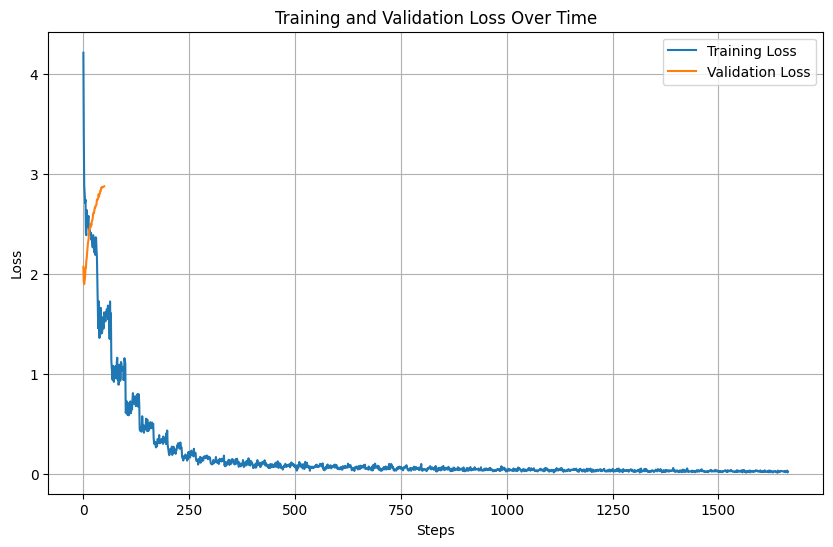

In [ ]:
model, tokenizer, history, eval_results, trainer = train_and_evaluate_model('dataset.json')

In [19]:
len(history['eval_loss'])

50

In [ ]:
print(f"BLEU Score: {eval_results['bleu_score']:.4f}")

BLEU Score: 0.0426


In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    train_steps = np.arange(len(history['train_loss']))
    plt.plot(train_steps, history['train_loss'],
             label='Training Loss', alpha=0.6)

    if len(history['eval_loss']) > 1:
        total_steps = len(history['train_loss'])
        eval_steps = np.linspace(0, total_steps-1, len(history['eval_loss']))

        plt.plot(eval_steps, history['eval_loss'],
                label='Validation Loss', marker='o')

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True)

    ax2 = plt.gca().twiny()
    ax2.set_xlim(plt.gca().get_xlim())
    ax2.set_xticks(np.linspace(0, total_steps, 11))
    ax2.set_xticklabels([f'{x:.0f}' for x in np.linspace(0, 50, 11)])
    ax2.set_xlabel('Epochs')

    plt.tight_layout()
    plt.show()

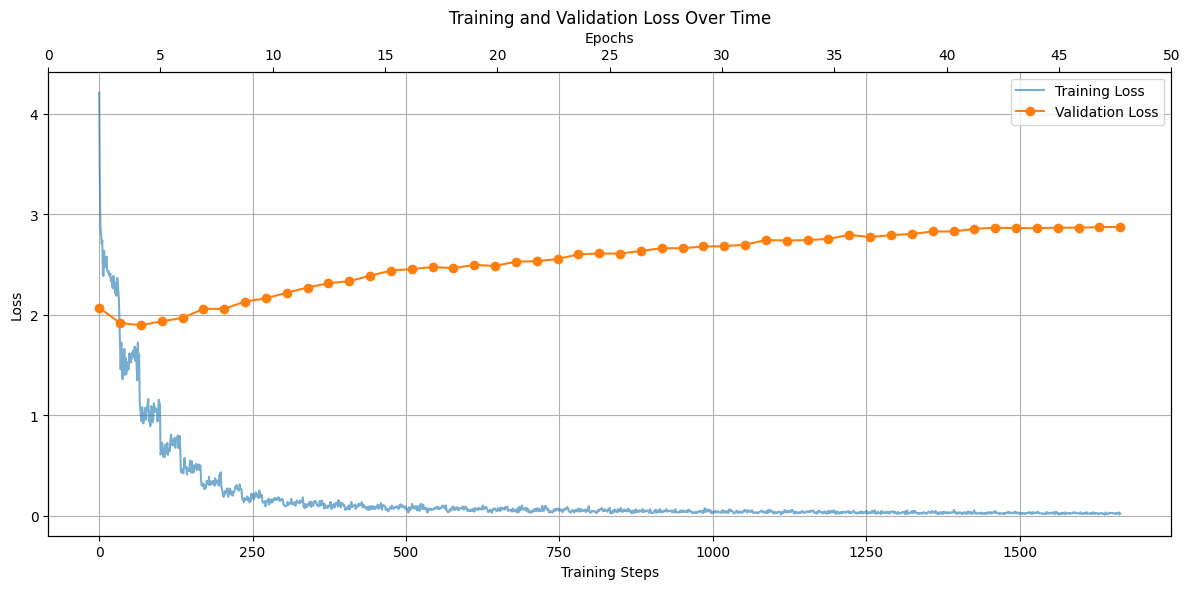

In [ ]:
plot_training_history(history)

# Use

In [22]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

In [23]:
class TranslationModelLoader:
    def __init__(self, model_path):
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)
        self.model.eval()

    def translate(self, text, max_length=32, num_beams=4, length_penalty=0.6):
        inputs = self.tokenizer(text.lower().strip(),
                              return_tensors="pt",
                              max_length=max_length,
                              truncation=True)

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model.generate(
                **inputs,
                max_length=max_length,
                num_beams=num_beams,
                length_penalty=length_penalty,
                early_stopping=True
            )

        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)

    def translate_batch(self, texts, batch_size=32, **kwargs):
        translations = []

        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            batch_translations = [self.translate(text, **kwargs) for text in batch]
            translations.extend(batch_translations)

        return translations

In [29]:
model_path = "./models/en_lev_ar_model/checkpoint-16650"
my_translator = TranslationModelLoader(model_path)

english_texts = [
    "I want to eat because I am hungry",
    "thank you",
    "how are you?",
    "i am eating"
]

my_arabic_translations = my_translator.translate_batch(english_texts)

for en, ar in zip(english_texts, my_arabic_translations):
    print(f"English: {en}")
    print(f"Arabic: {ar}")
    print("-" * 30)

English: I want to eat because I am hungry
Arabic: بدي أكل عشان أنا جوعان
------------------------------
English: thank you
Arabic: شكرا
------------------------------
English: how are you?
Arabic: كيف حالك؟
------------------------------
English: i am eating
Arabic: عم بأكل
------------------------------


In [ ]:
model_path = "Helsinki-NLP/opus-mt-en-ar"
original_translator = TranslationModelLoader(model_path)

original_arabic_translations = original_translator.translate_batch(english_texts)

for en, ar in zip(english_texts, original_arabic_translations):
    print(f"English: {en}")
    print(f"Arabic: {ar}")
    print("-" * 30)